In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import trimesh
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import random
from copy import copy
import h5py
from tqdm.auto import tqdm
#import pytorch3d

/fsx-repligen/xingchenliu/envs/miniconda3/envs/ddpm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset:

In [2]:
#borrow from https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/dataset.py

synsetid_to_cate = {
    '02691156': 'airplane', '02773838': 'bag', '02801938': 'basket',
    '02808440': 'bathtub', '02818832': 'bed', '02828884': 'bench',
    '02876657': 'bottle', '02880940': 'bowl', '02924116': 'bus',
    '02933112': 'cabinet', '02747177': 'can', '02942699': 'camera',
    '02954340': 'cap', '02958343': 'car', '03001627': 'chair',
    '03046257': 'clock', '03207941': 'dishwasher', '03211117': 'monitor',
    '04379243': 'table', '04401088': 'telephone', '02946921': 'tin_can',
    '04460130': 'tower', '04468005': 'train', '03085013': 'keyboard',
    '03261776': 'earphone', '03325088': 'faucet', '03337140': 'file',
    '03467517': 'guitar', '03513137': 'helmet', '03593526': 'jar',
    '03624134': 'knife', '03636649': 'lamp', '03642806': 'laptop',
    '03691459': 'speaker', '03710193': 'mailbox', '03759954': 'microphone',
    '03761084': 'microwave', '03790512': 'motorcycle', '03797390': 'mug',
    '03928116': 'piano', '03938244': 'pillow', '03948459': 'pistol',
    '03991062': 'pot', '04004475': 'printer', '04074963': 'remote_control',
    '04090263': 'rifle', '04099429': 'rocket', '04225987': 'skateboard',
    '04256520': 'sofa', '04330267': 'stove', '04530566': 'vessel',
    '04554684': 'washer', '02992529': 'cellphone',
    '02843684': 'birdhouse', '02871439': 'bookshelf',
    # '02858304': 'boat', no boat in our dataset, merged into vessels
    # '02834778': 'bicycle', not in our taxonomy
}
cate_to_synsetid = {v: k for k, v in synsetid_to_cate.items()}


class ShapeNetCore(Dataset):

    GRAVITATIONAL_AXIS = 1
    
    def __init__(self, path, cates, split, scale_mode, transform=None):
        super().__init__()
        assert isinstance(cates, list), '`cates` must be a list of cate names.'
        assert split in ('train', 'val', 'test')
        assert scale_mode is None or scale_mode in ('global_unit', 'shape_unit', 'shape_bbox', 'shape_half', 'shape_34')
        self.path = path
        if 'all' in cates:
            cates = cate_to_synsetid.keys()
        self.cate_synsetids = [cate_to_synsetid[s] for s in cates]
        self.cate_synsetids.sort()
        self.split = split
        self.scale_mode = scale_mode
        self.transform = transform

        self.pointclouds = []
        self.stats = None

        self.get_statistics()
        self.load()

    def get_statistics(self):

        basename = os.path.basename(self.path)
        dsetname = basename[:basename.rfind('.')]
        stats_dir = os.path.join(os.path.dirname(self.path), dsetname + '_stats')
        os.makedirs(stats_dir, exist_ok=True)

        if len(self.cate_synsetids) == len(cate_to_synsetid):
            stats_save_path = os.path.join(stats_dir, 'stats_all.pt')
        else:
            stats_save_path = os.path.join(stats_dir, 'stats_' + '_'.join(self.cate_synsetids) + '.pt')
        if os.path.exists(stats_save_path):
            self.stats = torch.load(stats_save_path)
            return self.stats

        with h5py.File(self.path, 'r') as f:
            pointclouds = []
            for synsetid in self.cate_synsetids:
                for split in ('train', 'val', 'test'):
                    pointclouds.append(torch.from_numpy(f[synsetid][split][...]))

        all_points = torch.cat(pointclouds, dim=0) # (B, N, 3)
        B, N, _ = all_points.size()
        mean = all_points.view(B*N, -1).mean(dim=0) # (1, 3)
        std = all_points.view(-1).std(dim=0)        # (1, )

        self.stats = {'mean': mean, 'std': std}
        torch.save(self.stats, stats_save_path)
        return self.stats

    def load(self):

        def _enumerate_pointclouds(f):
            for synsetid in self.cate_synsetids:
                cate_name = synsetid_to_cate[synsetid]
                for j, pc in enumerate(f[synsetid][self.split]):
                    yield torch.from_numpy(pc), j, cate_name
        
        with h5py.File(self.path, mode='r') as f:
            for pc, pc_id, cate_name in _enumerate_pointclouds(f):

                if self.scale_mode == 'global_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = self.stats['std'].reshape(1, 1)
                elif self.scale_mode == 'shape_unit':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1)
                elif self.scale_mode == 'shape_half':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.5)
                elif self.scale_mode == 'shape_34':
                    shift = pc.mean(dim=0).reshape(1, 3)
                    scale = pc.flatten().std().reshape(1, 1) / (0.75)
                elif self.scale_mode == 'shape_bbox':
                    pc_max, _ = pc.max(dim=0, keepdim=True) # (1, 3)
                    pc_min, _ = pc.min(dim=0, keepdim=True) # (1, 3)
                    shift = ((pc_min + pc_max) / 2).view(1, 3)
                    scale = (pc_max - pc_min).max().reshape(1, 1) / 2
                else:
                    shift = torch.zeros([1, 3])
                    scale = torch.ones([1, 1])

                pc = (pc - shift) / scale

                self.pointclouds.append({
                    'pointcloud': pc,
                    'cate': cate_name,
                    'id': pc_id,
                    'shift': shift,
                    'scale': scale
                })

        # Deterministically shuffle the dataset
        self.pointclouds.sort(key=lambda data: data['id'], reverse=False)
        random.Random(2020).shuffle(self.pointclouds)

    def __len__(self):
        return len(self.pointclouds)

    def __getitem__(self, idx):
        data = {k:v.clone() if isinstance(v, torch.Tensor) else copy(v) for k, v in self.pointclouds[idx].items()}
        if self.transform is not None:
            data = self.transform(data)
        return data

In [3]:
#https://github.com/luost26/diffusion-point-cloud/blob/1e30d48d018820fbc7c67c8b3190215bd41878e4/utils/data.py
def get_train_val_test_datasets(dataset, train_ratio, val_ratio):
    assert (train_ratio + val_ratio) <= 1
    train_size = int(len(dataset) * train_ratio)
    val_size = int(len(dataset) * val_ratio)
    test_size = len(dataset) - train_size - val_size
    
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
    return train_set, val_set, test_set


def get_train_val_test_loaders(dataset, train_ratio, val_ratio, train_batch_size, val_test_batch_size, num_workers):
    train_set, val_set, test_set = get_train_val_test_datasets(dataset, train_ratio, val_ratio)

    train_loader = DataLoader(train_set, train_batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_set, val_test_batch_size, shuffle=False, num_workers=num_workers)
    
    return train_loader, val_loader, test_loader


def get_data_iterator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, data in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [4]:
# Parameters
path_to_shapenet = "data/shapenet.hdf5"
categories = ['airplane']  # Use the categories you're interested in
scale_mode = 'shape_unit'  # or whichever scale mode you want to use
train_batch_size = 128
val_batch_size = 128
num_workers = 0

# Transform
transform = None
# Uncomment and replace with your own transform if needed.
# transform = RandomRotate(180, ['pointcloud'], axis=1)

# Datasets and loaders
train_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='train',
    scale_mode=scale_mode,
    transform=transform,
)
val_dset = ShapeNetCore(
    path=path_to_shapenet,
    cates=categories,
    split='val',
    scale_mode=scale_mode,
    transform=transform,
)

# Note: The original code uses get_data_iterator, which allows for an infinite loop.
# If you don't want an infinite loop, simply use DataLoader directly as shown below.
train_loader = DataLoader(train_dset, batch_size=train_batch_size, num_workers=num_workers)
val_loader = DataLoader(val_dset, batch_size=val_batch_size, num_workers=num_workers)

# If you want the infinite loop, use get_data_iterator instead:
# train_iter = get_data_iterator(train_loader)

Visualize the dataset

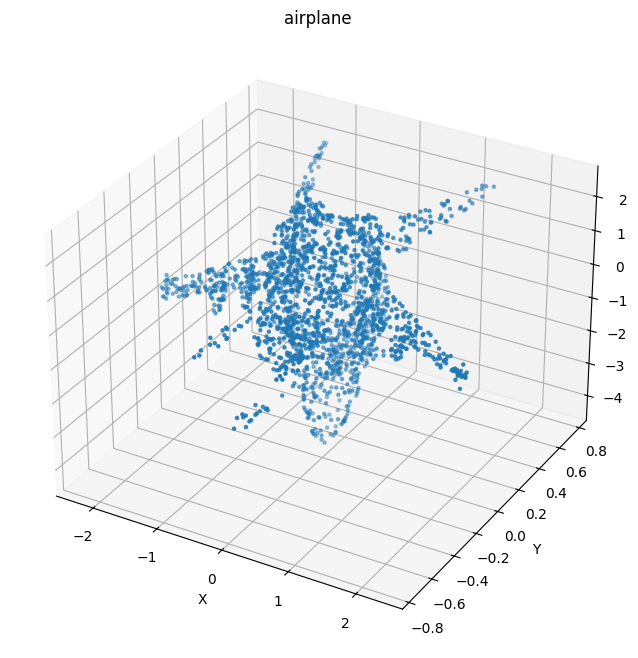

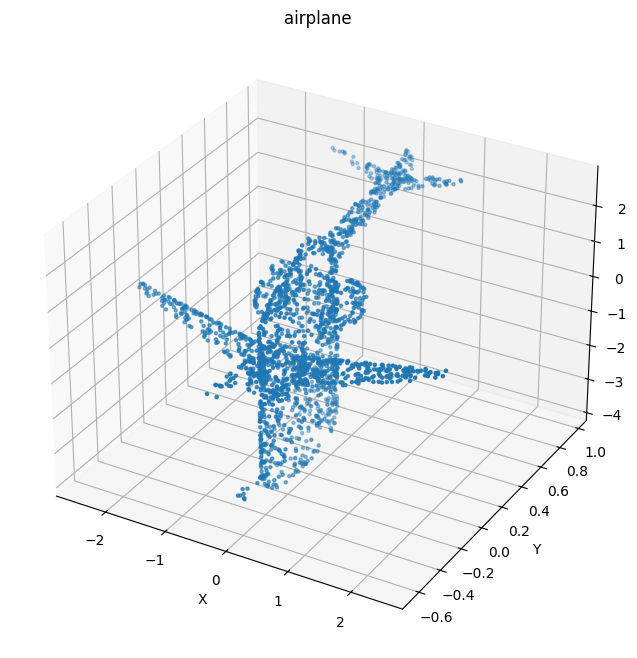

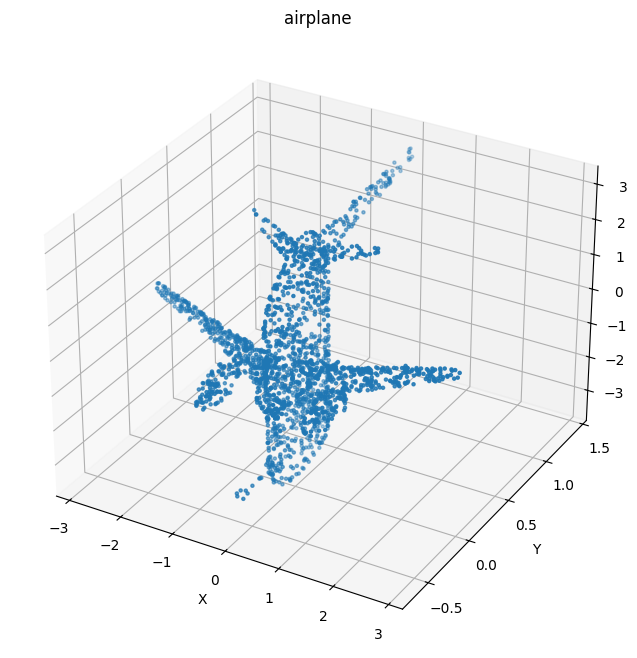

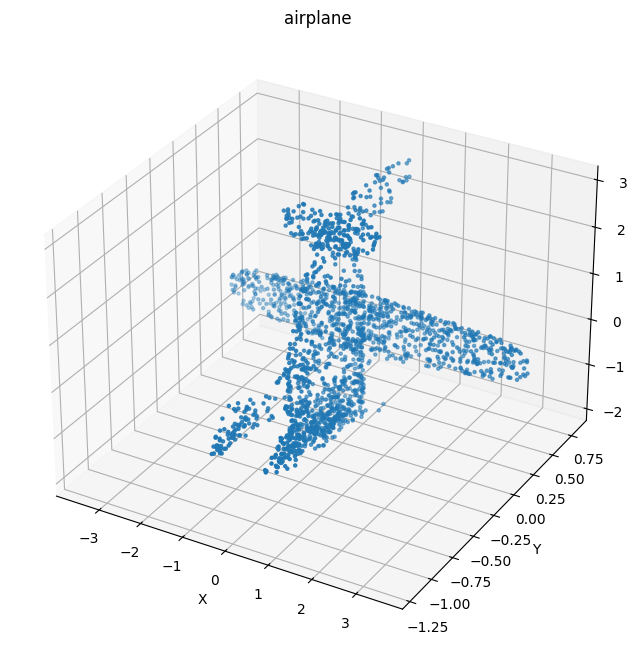

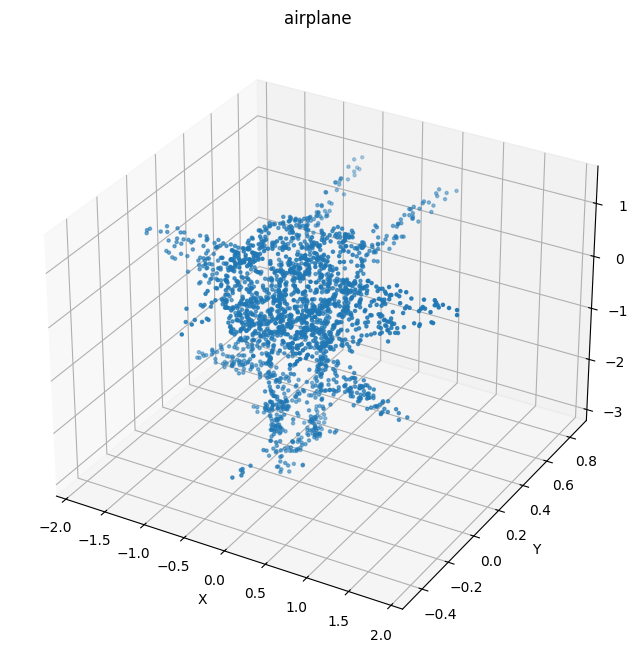

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_pointcloud(points, title=""):
    """Visualize a single point cloud."""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    ax.set_title(title)
    plt.show()

def visualize_dataset(dataset, num_samples=5):
    """Visualize random samples from the dataset."""
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].numpy()
        title = sample['cate']
        visualize_pointcloud(points, title=title)

# Usage:
visualize_dataset(train_dset)

Encoder:

In [6]:
class TransformNet(nn.Module):
    def __init__(self, k=3):
        super(TransformNet, self).__init__()
        
        # Layers
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)  # k*k for transformation matrix
        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        
        # Initialize the weights/bias with Identity transformation
        self.fc3.weight.data.zero_()
        self.fc3.bias.data.copy_(torch.eye(k).view(-1))

    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.gelu(self.bn1(self.conv1(x)))
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        x = F.gelu(self.bn4(self.fc1(x)))
        x = F.gelu(self.bn5(self.fc2(x)))
        
        x = self.fc3(x)
        
        # Reshape to the transformation matrix
        x = x.view(batch_size, -1)
        iden = torch.eye(self.fc3.out_features // x.size(-1)).view(-1).to(x.device)
        x = x + iden
        x = x.view(batch_size, x.size(1) // int(x.size(1)**0.5), int(x.size(1)**0.5))
        
        return x

In [7]:
class VariationalPointNetEncoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(VariationalPointNetEncoder, self).__init__()
        
        # Input transform
        self.input_transform = TransformNet(k=3)
        
        # Shared MLP
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        
        # Feature transform
        self.feature_transform = TransformNet(k=64)
        
        # Batch Norm layers
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        
        # Transition layers before latent space calculation
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # For mu and log variance
        self.fc_mu = nn.Linear(256, latent_size)
        self.fc_log_var = nn.Linear(256, latent_size)
        
        # Normal distribution and KL divergence
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.transpose(2, 1)
        
        # Apply input transform
        input_transform = self.input_transform(x)
        x = torch.bmm(x.transpose(1, 2), input_transform).transpose(1, 2)

        
        # Shared MLP layers
        x = F.gelu(self.bn1(self.conv1(x)))
        
        # Apply feature transform
        feature_transform = self.feature_transform(x)
        x = torch.bmm(x.transpose(1, 2), feature_transform).transpose(1, 2)

        
        x = F.gelu(self.bn2(self.conv2(x)))
        x = F.gelu(self.bn3(self.conv3(x)))
        
        # Global max pooling
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)
        
        # Transition layers
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        
        # Get mu and log variance
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        
        # Reparametrization trick
        sigma = torch.exp(0.5 * log_var)
        z = mu + sigma * self.N.sample(mu.shape)
        
        # KL divergence
        self.kl = (0.5 * (sigma**2 + mu**2 - log_var - 1)).sum()
        
        return z


Decoder:

In [8]:
class PointNetDecoder(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointNetDecoder, self).__init__()
        
        self.num_points = num_points
        
        # More expressive layers
        self.fc1 = nn.Linear(latent_size, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, num_points * 3)
        
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = F.gelu(self.fc2(x))
        x = self.dropout(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        
        return x.view(-1, self.num_points, 3)


In [9]:
def chamfer_distance(p1, p2):
    """
    Compute the Chamfer Distance between two point clouds.
    
    Args:
    - p1 (torch.Tensor): A tensor of shape (B, N, D) representing a batch of point clouds, each of which has N points of dimension D.
    - p2 (torch.Tensor): A tensor of the same shape as p1.
    
    Returns:
    - distance (torch.Tensor): A tensor of shape (B,) representing the Chamfer Distance for each pair of point clouds in the batch.
    """
    
    # Compute the pairwise squared distances between points
    # p1 has shape (B, N, D) and p2 has shape (B, M, D)
    # The resulting dists will have shape (B, N, M)
    dists = torch.sum(p1**2, dim=2).unsqueeze(2) + torch.sum(p2**2, dim=2).unsqueeze(1) - 2 * torch.matmul(p1, p2.permute(0, 2, 1))
    
    # For each point in p1, find the closest distance in p2
    min_dists_p1 = torch.min(dists, dim=2)[0]  # Shape (B, N)
    
    # For each point in p2, find the closest distance in p1
    min_dists_p2 = torch.min(dists, dim=1)[0]  # Shape (B, M)
    
    # Combine the two distances by taking the average
    distance = (torch.sum(min_dists_p1, dim=1) + torch.sum(min_dists_p2, dim=1)) / 2
    
    return distance

# Test with the given point clouds
p1 = torch.tensor([[[8.8977, 4.1709, 1.2839],
                    [8.5640, 7.7767, 9.4214]],
                   [[0.5431, 6.4495, 11.4914],
                    [3.2126, 8.0865, 3.1018]]], dtype=torch.float)
p2 = torch.tensor([[[6.9340, 6.1152, 3.4435],
                    [0.1032, 9.8181, 11.3350]],
                   [[11.4006, 2.2154, 7.9589],
                    [4.2586, 1.4133, 7.2606]]], dtype=torch.float)

print(chamfer_distance(p1, p2))  # Expected output: tensor([ 72.5838, 151.0809])


tensor([ 72.5838, 151.0809])


VAE

In [10]:
class PointCloudVAE(nn.Module):
    def __init__(self, num_points=2048, latent_size=256):
        super(PointCloudVAE, self).__init__()
        
        # Using the VariationalPointNetEncoder
        self.encoder = VariationalPointNetEncoder(num_points=num_points, latent_size=latent_size)
        self.decoder = PointNetDecoder(num_points=num_points, latent_size=latent_size)

    def forward(self, x):
        # Encode input point cloud and get latent variable z
        z = self.encoder(x)
        
        # Decode z to get the reconstructed point cloud
        reconstructed = self.decoder(z)
        
        return reconstructed, self.encoder.kl

# The vae_loss function needs to be updated since we won't have mu and logvar separately
def vae_loss(reconstructed, original, kl_div, beta=0.0):
    # Reconstruction loss
    recon_loss = chamfer_distance(reconstructed, original).mean()
    
    # Return combined loss
    return recon_loss + beta * kl_div

# Usage remains largely the same:

# Create a VAE
vae = PointCloudVAE(num_points=2048, latent_size=256)

# Forward pass would now look something like this:
# reconstructed, kl_div = vae(point_cloud)

# Compute loss
# loss = vae_loss(reconstructed, point_cloud, kl_div)


Train

In [11]:
def train_vae(model, train_loader, val_loader, optimizer, epochs=100, device='cuda'):
    """
    Trains the VAE model.
    """
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss, total_kl_div, total_recon_loss = 0, 0, 0
        
        # Training
        for i, batch in enumerate(tqdm(train_loader)):
            point_clouds = batch['pointcloud'].to(device)
            
            optimizer.zero_grad()
            reconstructed, kl_div = model(point_clouds)
            
            recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
            combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
            
            combined_loss.backward()
            optimizer.step()
            
            total_train_loss += combined_loss.item()
            total_kl_div += kl_div.item()
            total_recon_loss += recon_loss.item()
            
            # Print batch-level losses
            print(f"Epoch {epoch+1}, Batch {i+1} - Combined Loss: {combined_loss.item():.4f}, KL Div: {kl_div.item():.4f}, Recon Loss: {recon_loss.item():.4f}")
            
        avg_train_loss = total_train_loss / len(train_loader)
        avg_train_kl_div = total_kl_div / len(train_loader)
        avg_train_recon_loss = total_recon_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss, total_val_kl_div, total_val_recon_loss = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                point_clouds = batch['pointcloud'].to(device)
                reconstructed, kl_div = model(point_clouds)
                
                recon_loss = chamfer_distance(reconstructed, point_clouds).mean()
                combined_loss = vae_loss(reconstructed, point_clouds, kl_div)
                
                total_val_loss += combined_loss.item()
                total_val_kl_div += kl_div.item()
                total_val_recon_loss += recon_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        avg_val_kl_div = total_val_kl_div / len(val_loader)
        avg_val_recon_loss = total_val_recon_loss / len(val_loader)
        
        # Print epoch-level average losses
        print(f"\nEpoch: {epoch+1} Summary:")
        print(f"Train Avg Combined Loss: {avg_train_loss:.4f}, Train Avg KL Div: {avg_train_kl_div:.4f}, Train Avg Recon Loss: {avg_train_recon_loss:.4f}")
        print(f"Val Avg Combined Loss: {avg_val_loss:.4f}, Val Avg KL Div: {avg_val_kl_div:.4f}, Val Avg Recon Loss: {avg_val_recon_loss:.4f}\n")



In [12]:
vae = PointCloudVAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001, weight_decay=0)

In [13]:
train_vae(vae, train_loader, val_loader, optimizer)

  7%|▋         | 2/27 [00:02<00:24,  1.04it/s]

Epoch 1, Batch 1 - Combined Loss: 2417.7747, KL Div: 1331.5732, Recon Loss: 2417.7747
Epoch 1, Batch 2 - Combined Loss: 1592.9236, KL Div: 27856.2930, Recon Loss: 1592.9236


 15%|█▍        | 4/27 [00:02<00:08,  2.57it/s]

Epoch 1, Batch 3 - Combined Loss: 3010.0156, KL Div: 527251.0000, Recon Loss: 3010.0156
Epoch 1, Batch 4 - Combined Loss: 627.2949, KL Div: 62962.3594, Recon Loss: 627.2949


 22%|██▏       | 6/27 [00:02<00:04,  4.40it/s]

Epoch 1, Batch 5 - Combined Loss: 1068.7084, KL Div: 31173.0078, Recon Loss: 1068.7084
Epoch 1, Batch 6 - Combined Loss: 935.5602, KL Div: 28213.2422, Recon Loss: 935.5602


 30%|██▉       | 8/27 [00:02<00:03,  6.13it/s]

Epoch 1, Batch 7 - Combined Loss: 543.2030, KL Div: 37004.8984, Recon Loss: 543.2030
Epoch 1, Batch 8 - Combined Loss: 371.4712, KL Div: 59021.0000, Recon Loss: 371.4712


 37%|███▋      | 10/27 [00:03<00:02,  7.44it/s]

Epoch 1, Batch 9 - Combined Loss: 361.3895, KL Div: 86490.6172, Recon Loss: 361.3895
Epoch 1, Batch 10 - Combined Loss: 361.6067, KL Div: 102124.0781, Recon Loss: 361.6067


 44%|████▍     | 12/27 [00:03<00:01,  8.28it/s]

Epoch 1, Batch 11 - Combined Loss: 265.6755, KL Div: 88467.2656, Recon Loss: 265.6755
Epoch 1, Batch 12 - Combined Loss: 173.9074, KL Div: 63079.3984, Recon Loss: 173.9074


 52%|█████▏    | 14/27 [00:03<00:01,  8.75it/s]

Epoch 1, Batch 13 - Combined Loss: 147.0421, KL Div: 46801.3359, Recon Loss: 147.0421
Epoch 1, Batch 14 - Combined Loss: 144.7450, KL Div: 37741.7969, Recon Loss: 144.7450


 59%|█████▉    | 16/27 [00:03<00:01,  9.00it/s]

Epoch 1, Batch 15 - Combined Loss: 128.3039, KL Div: 32917.2148, Recon Loss: 128.3039
Epoch 1, Batch 16 - Combined Loss: 109.4383, KL Div: 32160.3320, Recon Loss: 109.4383


 67%|██████▋   | 18/27 [00:04<00:00,  9.08it/s]

Epoch 1, Batch 17 - Combined Loss: 96.9022, KL Div: 31515.8203, Recon Loss: 96.9022
Epoch 1, Batch 18 - Combined Loss: 93.5876, KL Div: 31933.5840, Recon Loss: 93.5876


 74%|███████▍  | 20/27 [00:04<00:00,  9.17it/s]

Epoch 1, Batch 19 - Combined Loss: 96.2476, KL Div: 30691.9688, Recon Loss: 96.2476
Epoch 1, Batch 20 - Combined Loss: 93.0848, KL Div: 30193.9590, Recon Loss: 93.0848


 81%|████████▏ | 22/27 [00:04<00:00,  9.22it/s]

Epoch 1, Batch 21 - Combined Loss: 87.7524, KL Div: 28108.3379, Recon Loss: 87.7524
Epoch 1, Batch 22 - Combined Loss: 82.5032, KL Div: 25994.9824, Recon Loss: 82.5032


 89%|████████▉ | 24/27 [00:04<00:00,  9.23it/s]

Epoch 1, Batch 23 - Combined Loss: 82.0106, KL Div: 24656.1094, Recon Loss: 82.0106
Epoch 1, Batch 24 - Combined Loss: 81.0470, KL Div: 23171.4531, Recon Loss: 81.0470


 96%|█████████▋| 26/27 [00:04<00:00,  9.25it/s]

Epoch 1, Batch 25 - Combined Loss: 87.3742, KL Div: 22407.7012, Recon Loss: 87.3742
Epoch 1, Batch 26 - Combined Loss: 83.3943, KL Div: 22460.9141, Recon Loss: 83.3943


100%|██████████| 27/27 [00:04<00:00,  5.41it/s]


Epoch 1, Batch 27 - Combined Loss: 81.7360, KL Div: 18732.3535, Recon Loss: 81.7360

Epoch: 1 Summary:
Train Avg Combined Loss: 489.8037, Train Avg KL Div: 57572.6888, Train Avg Recon Loss: 489.8037
Val Avg Combined Loss: 73.4192, Val Avg KL Div: 17351.2205, Val Avg Recon Loss: 73.4192



  4%|▎         | 1/27 [00:00<00:02,  9.30it/s]

Epoch 2, Batch 1 - Combined Loss: 72.8815, KL Div: 22118.8281, Recon Loss: 72.8815


  7%|▋         | 2/27 [00:00<00:02,  9.27it/s]

Epoch 2, Batch 2 - Combined Loss: 79.5626, KL Div: 22120.3906, Recon Loss: 79.5626


 11%|█         | 3/27 [00:00<00:02,  9.27it/s]

Epoch 2, Batch 3 - Combined Loss: 69.8898, KL Div: 22456.9473, Recon Loss: 69.8898


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 2, Batch 4 - Combined Loss: 78.9972, KL Div: 23420.4297, Recon Loss: 78.9972


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 2, Batch 5 - Combined Loss: 69.5972, KL Div: 22648.9160, Recon Loss: 69.5972


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 2, Batch 6 - Combined Loss: 70.2763, KL Div: 23304.2578, Recon Loss: 70.2763


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 2, Batch 7 - Combined Loss: 70.7797, KL Div: 23086.0020, Recon Loss: 70.7797


 30%|██▉       | 8/27 [00:00<00:02,  9.27it/s]

Epoch 2, Batch 8 - Combined Loss: 74.1291, KL Div: 23555.2500, Recon Loss: 74.1291


 33%|███▎      | 9/27 [00:00<00:01,  9.27it/s]

Epoch 2, Batch 9 - Combined Loss: 72.9601, KL Div: 23960.7051, Recon Loss: 72.9601


 37%|███▋      | 10/27 [00:01<00:01,  9.27it/s]

Epoch 2, Batch 10 - Combined Loss: 63.4947, KL Div: 24215.5625, Recon Loss: 63.4947


 41%|████      | 11/27 [00:01<00:01,  9.27it/s]

Epoch 2, Batch 11 - Combined Loss: 63.7131, KL Div: 24703.8008, Recon Loss: 63.7131


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 2, Batch 12 - Combined Loss: 71.1664, KL Div: 25186.5078, Recon Loss: 71.1664


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 2, Batch 13 - Combined Loss: 68.0780, KL Div: 25706.9922, Recon Loss: 68.0780


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 2, Batch 14 - Combined Loss: 66.0384, KL Div: 26096.2227, Recon Loss: 66.0384


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 2, Batch 15 - Combined Loss: 67.5182, KL Div: 25730.4297, Recon Loss: 67.5182


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 2, Batch 16 - Combined Loss: 66.5196, KL Div: 26571.1172, Recon Loss: 66.5196


 63%|██████▎   | 17/27 [00:01<00:01,  9.26it/s]

Epoch 2, Batch 17 - Combined Loss: 63.5316, KL Div: 26608.0664, Recon Loss: 63.5316


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 2, Batch 18 - Combined Loss: 63.9028, KL Div: 27066.9473, Recon Loss: 63.9028


 70%|███████   | 19/27 [00:02<00:00,  9.27it/s]

Epoch 2, Batch 19 - Combined Loss: 67.3488, KL Div: 26484.0566, Recon Loss: 67.3488


 74%|███████▍  | 20/27 [00:02<00:00,  9.24it/s]

Epoch 2, Batch 20 - Combined Loss: 63.3929, KL Div: 27010.5469, Recon Loss: 63.3929


 78%|███████▊  | 21/27 [00:02<00:00,  9.23it/s]

Epoch 2, Batch 21 - Combined Loss: 62.3756, KL Div: 26581.4570, Recon Loss: 62.3756


 81%|████████▏ | 22/27 [00:02<00:00,  9.23it/s]

Epoch 2, Batch 22 - Combined Loss: 63.0246, KL Div: 26534.0801, Recon Loss: 63.0246


 85%|████████▌ | 23/27 [00:02<00:00,  9.18it/s]

Epoch 2, Batch 23 - Combined Loss: 63.9429, KL Div: 26847.1328, Recon Loss: 63.9429


 89%|████████▉ | 24/27 [00:02<00:00,  9.17it/s]

Epoch 2, Batch 24 - Combined Loss: 65.6935, KL Div: 26710.0156, Recon Loss: 65.6935


 93%|█████████▎| 25/27 [00:02<00:00,  9.16it/s]

Epoch 2, Batch 25 - Combined Loss: 68.7361, KL Div: 26883.4805, Recon Loss: 68.7361


 96%|█████████▋| 26/27 [00:02<00:00,  9.15it/s]

Epoch 2, Batch 26 - Combined Loss: 64.3343, KL Div: 27259.6328, Recon Loss: 64.3343
Epoch 2, Batch 27 - Combined Loss: 67.8605, KL Div: 22712.4941, Recon Loss: 67.8605


100%|██████████| 27/27 [00:02<00:00,  9.29it/s]



Epoch: 2 Summary:
Train Avg Combined Loss: 68.1387, Train Avg KL Div: 25021.4915, Train Avg Recon Loss: 68.1387
Val Avg Combined Loss: 59.7855, Val Avg KL Div: 25503.5621, Val Avg Recon Loss: 59.7855



  4%|▎         | 1/27 [00:00<00:02,  9.28it/s]

Epoch 3, Batch 1 - Combined Loss: 60.7735, KL Div: 26772.6836, Recon Loss: 60.7735


  7%|▋         | 2/27 [00:00<00:02,  9.25it/s]

Epoch 3, Batch 2 - Combined Loss: 64.5281, KL Div: 26703.8359, Recon Loss: 64.5281


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 3, Batch 3 - Combined Loss: 55.3737, KL Div: 27145.4570, Recon Loss: 55.3737


 15%|█▍        | 4/27 [00:00<00:02,  9.23it/s]

Epoch 3, Batch 4 - Combined Loss: 64.6136, KL Div: 28433.4609, Recon Loss: 64.6136


 19%|█▊        | 5/27 [00:00<00:02,  9.22it/s]

Epoch 3, Batch 5 - Combined Loss: 60.5129, KL Div: 27699.3320, Recon Loss: 60.5129


 22%|██▏       | 6/27 [00:00<00:02,  9.22it/s]

Epoch 3, Batch 6 - Combined Loss: 61.2761, KL Div: 28752.1465, Recon Loss: 61.2761


 26%|██▌       | 7/27 [00:00<00:02,  9.22it/s]

Epoch 3, Batch 7 - Combined Loss: 63.6378, KL Div: 28452.2617, Recon Loss: 63.6378


 30%|██▉       | 8/27 [00:00<00:02,  9.21it/s]

Epoch 3, Batch 8 - Combined Loss: 66.7646, KL Div: 29327.5605, Recon Loss: 66.7646


 33%|███▎      | 9/27 [00:00<00:01,  9.18it/s]

Epoch 3, Batch 9 - Combined Loss: 68.0534, KL Div: 29967.2500, Recon Loss: 68.0534


 37%|███▋      | 10/27 [00:01<00:01,  9.17it/s]

Epoch 3, Batch 10 - Combined Loss: 57.4489, KL Div: 30468.4961, Recon Loss: 57.4489


 41%|████      | 11/27 [00:01<00:01,  9.17it/s]

Epoch 3, Batch 11 - Combined Loss: 57.0698, KL Div: 31157.7109, Recon Loss: 57.0698


 44%|████▍     | 12/27 [00:01<00:01,  9.18it/s]

Epoch 3, Batch 12 - Combined Loss: 65.1333, KL Div: 31948.2988, Recon Loss: 65.1333


 48%|████▊     | 13/27 [00:01<00:01,  9.17it/s]

Epoch 3, Batch 13 - Combined Loss: 63.7006, KL Div: 32446.5234, Recon Loss: 63.7006


 52%|█████▏    | 14/27 [00:01<00:01,  9.18it/s]

Epoch 3, Batch 14 - Combined Loss: 60.6064, KL Div: 33001.2500, Recon Loss: 60.6064


 56%|█████▌    | 15/27 [00:01<00:01,  9.19it/s]

Epoch 3, Batch 15 - Combined Loss: 63.3213, KL Div: 32653.8945, Recon Loss: 63.3213


 59%|█████▉    | 16/27 [00:01<00:01,  9.21it/s]

Epoch 3, Batch 16 - Combined Loss: 62.5490, KL Div: 33818.0547, Recon Loss: 62.5490


 63%|██████▎   | 17/27 [00:01<00:01,  9.21it/s]

Epoch 3, Batch 17 - Combined Loss: 57.8086, KL Div: 34351.5547, Recon Loss: 57.8086


 67%|██████▋   | 18/27 [00:01<00:00,  9.22it/s]

Epoch 3, Batch 18 - Combined Loss: 59.2042, KL Div: 34915.7969, Recon Loss: 59.2042


 70%|███████   | 19/27 [00:02<00:00,  9.23it/s]

Epoch 3, Batch 19 - Combined Loss: 64.5861, KL Div: 34398.8125, Recon Loss: 64.5861


 74%|███████▍  | 20/27 [00:02<00:00,  9.23it/s]

Epoch 3, Batch 20 - Combined Loss: 61.2624, KL Div: 35611.8594, Recon Loss: 61.2624


 78%|███████▊  | 21/27 [00:02<00:00,  9.24it/s]

Epoch 3, Batch 21 - Combined Loss: 58.1744, KL Div: 35589.3438, Recon Loss: 58.1744


 81%|████████▏ | 22/27 [00:02<00:00,  9.25it/s]

Epoch 3, Batch 22 - Combined Loss: 57.6105, KL Div: 35789.3008, Recon Loss: 57.6105


 85%|████████▌ | 23/27 [00:02<00:00,  9.25it/s]

Epoch 3, Batch 23 - Combined Loss: 60.4764, KL Div: 36400.4336, Recon Loss: 60.4764


 89%|████████▉ | 24/27 [00:02<00:00,  9.25it/s]

Epoch 3, Batch 24 - Combined Loss: 62.6826, KL Div: 36512.0234, Recon Loss: 62.6826


 93%|█████████▎| 25/27 [00:02<00:00,  9.25it/s]

Epoch 3, Batch 25 - Combined Loss: 65.9307, KL Div: 36890.0469, Recon Loss: 65.9307


 96%|█████████▋| 26/27 [00:02<00:00,  9.25it/s]

Epoch 3, Batch 26 - Combined Loss: 61.7395, KL Div: 37078.8906, Recon Loss: 61.7395
Epoch 3, Batch 27 - Combined Loss: 66.0778, KL Div: 30817.7812, Recon Loss: 66.0778


100%|██████████| 27/27 [00:02<00:00,  9.27it/s]



Epoch: 3 Summary:
Train Avg Combined Loss: 61.8858, Train Avg KL Div: 32114.9652, Train Avg Recon Loss: 61.8858
Val Avg Combined Loss: 57.6860, Val Avg KL Div: 35016.3391, Val Avg Recon Loss: 57.6860



  4%|▎         | 1/27 [00:00<00:02,  9.30it/s]

Epoch 4, Batch 1 - Combined Loss: 57.2237, KL Div: 36514.1719, Recon Loss: 57.2237


  7%|▋         | 2/27 [00:00<00:02,  9.28it/s]

Epoch 4, Batch 2 - Combined Loss: 62.0104, KL Div: 36241.9414, Recon Loss: 62.0104


 11%|█         | 3/27 [00:00<00:02,  9.27it/s]

Epoch 4, Batch 3 - Combined Loss: 53.7899, KL Div: 36599.5742, Recon Loss: 53.7899


 15%|█▍        | 4/27 [00:00<00:02,  9.26it/s]

Epoch 4, Batch 4 - Combined Loss: 62.1932, KL Div: 38086.7109, Recon Loss: 62.1932


 19%|█▊        | 5/27 [00:00<00:02,  9.28it/s]

Epoch 4, Batch 5 - Combined Loss: 58.2702, KL Div: 36843.4219, Recon Loss: 58.2702


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 4, Batch 6 - Combined Loss: 59.1506, KL Div: 38173.6094, Recon Loss: 59.1506


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 4, Batch 7 - Combined Loss: 59.9184, KL Div: 37813.7969, Recon Loss: 59.9184


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 4, Batch 8 - Combined Loss: 63.6701, KL Div: 38364.4844, Recon Loss: 63.6701


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 4, Batch 9 - Combined Loss: 65.2720, KL Div: 38777.4844, Recon Loss: 65.2720


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 4, Batch 10 - Combined Loss: 55.8473, KL Div: 38726.9023, Recon Loss: 55.8473


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 4, Batch 11 - Combined Loss: 55.6884, KL Div: 39175.4375, Recon Loss: 55.6884


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 4, Batch 12 - Combined Loss: 64.0088, KL Div: 39696.4141, Recon Loss: 64.0088


 48%|████▊     | 13/27 [00:01<00:01,  9.26it/s]

Epoch 4, Batch 13 - Combined Loss: 61.6695, KL Div: 39925.2070, Recon Loss: 61.6695


 52%|█████▏    | 14/27 [00:01<00:01,  9.25it/s]

Epoch 4, Batch 14 - Combined Loss: 58.5018, KL Div: 40362.6484, Recon Loss: 58.5018


 56%|█████▌    | 15/27 [00:01<00:01,  9.24it/s]

Epoch 4, Batch 15 - Combined Loss: 60.5837, KL Div: 39920.9375, Recon Loss: 60.5837


 59%|█████▉    | 16/27 [00:01<00:01,  9.24it/s]

Epoch 4, Batch 16 - Combined Loss: 60.0909, KL Div: 40929.8828, Recon Loss: 60.0909


 63%|██████▎   | 17/27 [00:01<00:01,  9.23it/s]

Epoch 4, Batch 17 - Combined Loss: 56.3847, KL Div: 41683.2891, Recon Loss: 56.3847


 67%|██████▋   | 18/27 [00:01<00:00,  9.18it/s]

Epoch 4, Batch 18 - Combined Loss: 58.1898, KL Div: 42514.7305, Recon Loss: 58.1898


 70%|███████   | 19/27 [00:02<00:00,  9.18it/s]

Epoch 4, Batch 19 - Combined Loss: 61.6842, KL Div: 41652.6523, Recon Loss: 61.6842


 74%|███████▍  | 20/27 [00:02<00:00,  9.18it/s]

Epoch 4, Batch 20 - Combined Loss: 58.4175, KL Div: 43140.6719, Recon Loss: 58.4175


 78%|███████▊  | 21/27 [00:02<00:00,  9.20it/s]

Epoch 4, Batch 21 - Combined Loss: 56.5724, KL Div: 42837.7578, Recon Loss: 56.5724


 81%|████████▏ | 22/27 [00:02<00:00,  9.20it/s]

Epoch 4, Batch 22 - Combined Loss: 56.1777, KL Div: 42861.1094, Recon Loss: 56.1777


 85%|████████▌ | 23/27 [00:02<00:00,  9.18it/s]

Epoch 4, Batch 23 - Combined Loss: 58.9816, KL Div: 43195.5586, Recon Loss: 58.9816


 89%|████████▉ | 24/27 [00:02<00:00,  9.19it/s]

Epoch 4, Batch 24 - Combined Loss: 61.7037, KL Div: 43262.3750, Recon Loss: 61.7037


 93%|█████████▎| 25/27 [00:02<00:00,  9.21it/s]

Epoch 4, Batch 25 - Combined Loss: 64.8882, KL Div: 43126.9297, Recon Loss: 64.8882


 96%|█████████▋| 26/27 [00:02<00:00,  9.22it/s]

Epoch 4, Batch 26 - Combined Loss: 59.4290, KL Div: 43131.4141, Recon Loss: 59.4290
Epoch 4, Batch 27 - Combined Loss: 65.4726, KL Div: 35627.3242, Recon Loss: 65.4726


100%|██████████| 27/27 [00:02<00:00,  9.29it/s]



Epoch: 4 Summary:
Train Avg Combined Loss: 59.8441, Train Avg KL Div: 39969.8681, Train Avg Recon Loss: 59.8441
Val Avg Combined Loss: 56.8157, Val Avg KL Div: 40066.4242, Val Avg Recon Loss: 56.8157



  4%|▎         | 1/27 [00:00<00:02,  9.29it/s]

Epoch 5, Batch 1 - Combined Loss: 55.7190, KL Div: 42018.7500, Recon Loss: 55.7190


  7%|▋         | 2/27 [00:00<00:02,  9.27it/s]

Epoch 5, Batch 2 - Combined Loss: 59.9910, KL Div: 41595.2344, Recon Loss: 59.9910


 11%|█         | 3/27 [00:00<00:02,  9.26it/s]

Epoch 5, Batch 3 - Combined Loss: 51.5632, KL Div: 41868.4219, Recon Loss: 51.5632


 15%|█▍        | 4/27 [00:00<00:02,  9.25it/s]

Epoch 5, Batch 4 - Combined Loss: 61.1324, KL Div: 43455.2344, Recon Loss: 61.1324


 19%|█▊        | 5/27 [00:00<00:02,  9.22it/s]

Epoch 5, Batch 5 - Combined Loss: 57.7434, KL Div: 42087.2812, Recon Loss: 57.7434


 22%|██▏       | 6/27 [00:00<00:02,  9.22it/s]

Epoch 5, Batch 6 - Combined Loss: 59.0138, KL Div: 43641.8555, Recon Loss: 59.0138


 26%|██▌       | 7/27 [00:00<00:02,  9.22it/s]

Epoch 5, Batch 7 - Combined Loss: 59.3226, KL Div: 43229.9453, Recon Loss: 59.3226


 30%|██▉       | 8/27 [00:00<00:02,  9.22it/s]

Epoch 5, Batch 8 - Combined Loss: 62.8902, KL Div: 43562.6758, Recon Loss: 62.8902


 33%|███▎      | 9/27 [00:00<00:01,  9.22it/s]

Epoch 5, Batch 9 - Combined Loss: 64.3363, KL Div: 44134.9297, Recon Loss: 64.3363


 37%|███▋      | 10/27 [00:01<00:01,  9.22it/s]

Epoch 5, Batch 10 - Combined Loss: 54.0823, KL Div: 43893.2266, Recon Loss: 54.0823


 41%|████      | 11/27 [00:01<00:01,  9.22it/s]

Epoch 5, Batch 11 - Combined Loss: 54.6480, KL Div: 44307.0156, Recon Loss: 54.6480


 44%|████▍     | 12/27 [00:01<00:01,  9.18it/s]

Epoch 5, Batch 12 - Combined Loss: 62.2878, KL Div: 45099.2734, Recon Loss: 62.2878


 48%|████▊     | 13/27 [00:01<00:01,  9.18it/s]

Epoch 5, Batch 13 - Combined Loss: 60.5919, KL Div: 45346.6562, Recon Loss: 60.5919


 52%|█████▏    | 14/27 [00:01<00:01,  9.18it/s]

Epoch 5, Batch 14 - Combined Loss: 57.4140, KL Div: 45929.6641, Recon Loss: 57.4140


 56%|█████▌    | 15/27 [00:01<00:01,  9.20it/s]

Epoch 5, Batch 15 - Combined Loss: 58.9233, KL Div: 45364.3672, Recon Loss: 58.9233


 59%|█████▉    | 16/27 [00:01<00:01,  9.21it/s]

Epoch 5, Batch 16 - Combined Loss: 58.9409, KL Div: 45878.5000, Recon Loss: 58.9409


 63%|██████▎   | 17/27 [00:01<00:01,  9.21it/s]

Epoch 5, Batch 17 - Combined Loss: 54.9631, KL Div: 46500.6367, Recon Loss: 54.9631


 67%|██████▋   | 18/27 [00:01<00:00,  9.19it/s]

Epoch 5, Batch 18 - Combined Loss: 56.4108, KL Div: 47301.6836, Recon Loss: 56.4108


 70%|███████   | 19/27 [00:02<00:00,  9.21it/s]

Epoch 5, Batch 19 - Combined Loss: 60.8099, KL Div: 45665.9297, Recon Loss: 60.8099


 74%|███████▍  | 20/27 [00:02<00:00,  9.22it/s]

Epoch 5, Batch 20 - Combined Loss: 58.1069, KL Div: 46755.2500, Recon Loss: 58.1069


 78%|███████▊  | 21/27 [00:02<00:00,  9.23it/s]

Epoch 5, Batch 21 - Combined Loss: 55.1786, KL Div: 46051.8984, Recon Loss: 55.1786


 81%|████████▏ | 22/27 [00:02<00:00,  9.23it/s]

Epoch 5, Batch 22 - Combined Loss: 55.0463, KL Div: 45875.2578, Recon Loss: 55.0463


 85%|████████▌ | 23/27 [00:02<00:00,  9.23it/s]

Epoch 5, Batch 23 - Combined Loss: 58.3248, KL Div: 46154.8125, Recon Loss: 58.3248


 89%|████████▉ | 24/27 [00:02<00:00,  9.23it/s]

Epoch 5, Batch 24 - Combined Loss: 59.5993, KL Div: 46355.2930, Recon Loss: 59.5993


 93%|█████████▎| 25/27 [00:02<00:00,  9.23it/s]

Epoch 5, Batch 25 - Combined Loss: 62.2658, KL Div: 46184.5156, Recon Loss: 62.2658


 96%|█████████▋| 26/27 [00:02<00:00,  9.24it/s]

Epoch 5, Batch 26 - Combined Loss: 59.1533, KL Div: 46486.7969, Recon Loss: 59.1533
Epoch 5, Batch 27 - Combined Loss: 62.3016, KL Div: 38829.8594, Recon Loss: 62.3016


100%|██████████| 27/27 [00:02<00:00,  9.27it/s]



Epoch: 5 Summary:
Train Avg Combined Loss: 58.5467, Train Avg KL Div: 44576.8505, Train Avg Recon Loss: 58.5467
Val Avg Combined Loss: 55.2086, Val Avg KL Div: 45299.0945, Val Avg Recon Loss: 55.2086



  4%|▎         | 1/27 [00:00<00:02,  9.30it/s]

Epoch 6, Batch 1 - Combined Loss: 54.4576, KL Div: 46807.8125, Recon Loss: 54.4576


  7%|▋         | 2/27 [00:00<00:02,  9.28it/s]

Epoch 6, Batch 2 - Combined Loss: 59.8191, KL Div: 46859.5312, Recon Loss: 59.8191


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 6, Batch 3 - Combined Loss: 51.2543, KL Div: 47499.9531, Recon Loss: 51.2543


 15%|█▍        | 4/27 [00:00<00:02,  9.23it/s]

Epoch 6, Batch 4 - Combined Loss: 58.6008, KL Div: 48565.4844, Recon Loss: 58.6008


 19%|█▊        | 5/27 [00:00<00:02,  9.23it/s]

Epoch 6, Batch 5 - Combined Loss: 55.2156, KL Div: 46553.6172, Recon Loss: 55.2156


 22%|██▏       | 6/27 [00:00<00:02,  9.22it/s]

Epoch 6, Batch 6 - Combined Loss: 56.5977, KL Div: 48191.5703, Recon Loss: 56.5977


 26%|██▌       | 7/27 [00:00<00:02,  9.22it/s]

Epoch 6, Batch 7 - Combined Loss: 56.4352, KL Div: 47070.3125, Recon Loss: 56.4352


 30%|██▉       | 8/27 [00:00<00:02,  9.23it/s]

Epoch 6, Batch 8 - Combined Loss: 60.8356, KL Div: 46581.7031, Recon Loss: 60.8356


 33%|███▎      | 9/27 [00:00<00:01,  9.23it/s]

Epoch 6, Batch 9 - Combined Loss: 61.7900, KL Div: 47981.7891, Recon Loss: 61.7900


 37%|███▋      | 10/27 [00:01<00:01,  9.23it/s]

Epoch 6, Batch 10 - Combined Loss: 53.0827, KL Div: 47650.6172, Recon Loss: 53.0827


 41%|████      | 11/27 [00:01<00:01,  9.23it/s]

Epoch 6, Batch 11 - Combined Loss: 52.8832, KL Div: 48499.3164, Recon Loss: 52.8832


 44%|████▍     | 12/27 [00:01<00:01,  9.19it/s]

Epoch 6, Batch 12 - Combined Loss: 60.9291, KL Div: 47842.8984, Recon Loss: 60.9291


 48%|████▊     | 13/27 [00:01<00:01,  9.18it/s]

Epoch 6, Batch 13 - Combined Loss: 58.7142, KL Div: 48550.8359, Recon Loss: 58.7142


 52%|█████▏    | 14/27 [00:01<00:01,  9.18it/s]

Epoch 6, Batch 14 - Combined Loss: 55.0033, KL Div: 48781.1406, Recon Loss: 55.0033


 56%|█████▌    | 15/27 [00:01<00:01,  9.20it/s]

Epoch 6, Batch 15 - Combined Loss: 57.1926, KL Div: 47383.5078, Recon Loss: 57.1926


 59%|█████▉    | 16/27 [00:01<00:01,  9.22it/s]

Epoch 6, Batch 16 - Combined Loss: 56.4196, KL Div: 47313.4062, Recon Loss: 56.4196


 63%|██████▎   | 17/27 [00:01<00:01,  9.22it/s]

Epoch 6, Batch 17 - Combined Loss: 53.1769, KL Div: 47908.0078, Recon Loss: 53.1769


 67%|██████▋   | 18/27 [00:01<00:00,  9.23it/s]

Epoch 6, Batch 18 - Combined Loss: 53.7571, KL Div: 49979.7852, Recon Loss: 53.7571


 70%|███████   | 19/27 [00:02<00:00,  9.23it/s]

Epoch 6, Batch 19 - Combined Loss: 57.5269, KL Div: 48278.4141, Recon Loss: 57.5269


 74%|███████▍  | 20/27 [00:02<00:00,  9.21it/s]

Epoch 6, Batch 20 - Combined Loss: 55.2074, KL Div: 50136.6016, Recon Loss: 55.2074


 78%|███████▊  | 21/27 [00:02<00:00,  9.21it/s]

Epoch 6, Batch 21 - Combined Loss: 53.7464, KL Div: 49742.5742, Recon Loss: 53.7464


 81%|████████▏ | 22/27 [00:02<00:00,  9.22it/s]

Epoch 6, Batch 22 - Combined Loss: 53.0840, KL Div: 49799.3320, Recon Loss: 53.0840


 85%|████████▌ | 23/27 [00:02<00:00,  9.23it/s]

Epoch 6, Batch 23 - Combined Loss: 54.7011, KL Div: 50424.5273, Recon Loss: 54.7011


 89%|████████▉ | 24/27 [00:02<00:00,  9.24it/s]

Epoch 6, Batch 24 - Combined Loss: 58.1991, KL Div: 51285.3984, Recon Loss: 58.1991


 93%|█████████▎| 25/27 [00:02<00:00,  9.24it/s]

Epoch 6, Batch 25 - Combined Loss: 59.5552, KL Div: 50733.4609, Recon Loss: 59.5552


 96%|█████████▋| 26/27 [00:02<00:00,  9.25it/s]

Epoch 6, Batch 26 - Combined Loss: 55.4984, KL Div: 51248.1484, Recon Loss: 55.4984
Epoch 6, Batch 27 - Combined Loss: 58.0590, KL Div: 42805.4180, Recon Loss: 58.0590


100%|██████████| 27/27 [00:02<00:00,  9.27it/s]



Epoch: 6 Summary:
Train Avg Combined Loss: 56.3608, Train Avg KL Div: 48313.8950, Train Avg Recon Loss: 56.3608
Val Avg Combined Loss: 51.9997, Val Avg KL Div: 47120.2461, Val Avg Recon Loss: 51.9997



  4%|▎         | 1/27 [00:00<00:02,  9.30it/s]

Epoch 7, Batch 1 - Combined Loss: 52.4415, KL Div: 52040.5781, Recon Loss: 52.4415


  7%|▋         | 2/27 [00:00<00:02,  9.28it/s]

Epoch 7, Batch 2 - Combined Loss: 56.9292, KL Div: 51350.9297, Recon Loss: 56.9292


 11%|█         | 3/27 [00:00<00:02,  9.27it/s]

Epoch 7, Batch 3 - Combined Loss: 49.9037, KL Div: 53617.9688, Recon Loss: 49.9037


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 7, Batch 4 - Combined Loss: 55.1826, KL Div: 52157.9336, Recon Loss: 55.1826


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 7, Batch 5 - Combined Loss: 52.5302, KL Div: 50076.1602, Recon Loss: 52.5302


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 7, Batch 6 - Combined Loss: 54.6435, KL Div: 52768.4180, Recon Loss: 54.6435


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 7, Batch 7 - Combined Loss: 53.4421, KL Div: 51977.9453, Recon Loss: 53.4421


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 7, Batch 8 - Combined Loss: 56.3805, KL Div: 52100.4961, Recon Loss: 56.3805


 33%|███▎      | 9/27 [00:00<00:01,  9.26it/s]

Epoch 7, Batch 9 - Combined Loss: 59.1919, KL Div: 54880.5469, Recon Loss: 59.1919


 37%|███▋      | 10/27 [00:01<00:01,  9.25it/s]

Epoch 7, Batch 10 - Combined Loss: 50.1495, KL Div: 53572.0625, Recon Loss: 50.1495


 41%|████      | 11/27 [00:01<00:01,  9.24it/s]

Epoch 7, Batch 11 - Combined Loss: 51.4402, KL Div: 54655.6211, Recon Loss: 51.4402


 44%|████▍     | 12/27 [00:01<00:01,  9.23it/s]

Epoch 7, Batch 12 - Combined Loss: 58.4593, KL Div: 51319.4883, Recon Loss: 58.4593


 48%|████▊     | 13/27 [00:01<00:01,  9.23it/s]

Epoch 7, Batch 13 - Combined Loss: 56.2356, KL Div: 51209.1484, Recon Loss: 56.2356


 52%|█████▏    | 14/27 [00:01<00:01,  9.23it/s]

Epoch 7, Batch 14 - Combined Loss: 53.3204, KL Div: 50385.3945, Recon Loss: 53.3204


 56%|█████▌    | 15/27 [00:01<00:01,  9.23it/s]

Epoch 7, Batch 15 - Combined Loss: 54.9892, KL Div: 51452.3438, Recon Loss: 54.9892


 59%|█████▉    | 16/27 [00:01<00:01,  9.24it/s]

Epoch 7, Batch 16 - Combined Loss: 54.6043, KL Div: 52624.6875, Recon Loss: 54.6043


 63%|██████▎   | 17/27 [00:01<00:01,  9.24it/s]

Epoch 7, Batch 17 - Combined Loss: 50.7012, KL Div: 55753.8516, Recon Loss: 50.7012


 67%|██████▋   | 18/27 [00:01<00:00,  9.24it/s]

Epoch 7, Batch 18 - Combined Loss: 51.8355, KL Div: 56986.9570, Recon Loss: 51.8355


 70%|███████   | 19/27 [00:02<00:00,  9.19it/s]

Epoch 7, Batch 19 - Combined Loss: 54.6950, KL Div: 53913.4922, Recon Loss: 54.6950


 74%|███████▍  | 20/27 [00:02<00:00,  9.19it/s]

Epoch 7, Batch 20 - Combined Loss: 52.7597, KL Div: 53767.9766, Recon Loss: 52.7597


 78%|███████▊  | 21/27 [00:02<00:00,  9.19it/s]

Epoch 7, Batch 21 - Combined Loss: 51.1338, KL Div: 51543.0625, Recon Loss: 51.1338


 81%|████████▏ | 22/27 [00:02<00:00,  9.21it/s]

Epoch 7, Batch 22 - Combined Loss: 51.3930, KL Div: 51248.7578, Recon Loss: 51.3930


 85%|████████▌ | 23/27 [00:02<00:00,  9.22it/s]

Epoch 7, Batch 23 - Combined Loss: 52.4803, KL Div: 51422.7891, Recon Loss: 52.4803


 89%|████████▉ | 24/27 [00:02<00:00,  9.23it/s]

Epoch 7, Batch 24 - Combined Loss: 54.5087, KL Div: 54499.2305, Recon Loss: 54.5087


 93%|█████████▎| 25/27 [00:02<00:00,  9.24it/s]

Epoch 7, Batch 25 - Combined Loss: 56.6278, KL Div: 54712.3008, Recon Loss: 56.6278


 96%|█████████▋| 26/27 [00:02<00:00,  9.24it/s]

Epoch 7, Batch 26 - Combined Loss: 53.1524, KL Div: 56231.3672, Recon Loss: 53.1524
Epoch 7, Batch 27 - Combined Loss: 55.6843, KL Div: 46495.5977, Recon Loss: 55.6843


100%|██████████| 27/27 [00:02<00:00,  9.29it/s]



Epoch: 7 Summary:
Train Avg Combined Loss: 53.8821, Train Avg KL Div: 52695.0039, Train Avg Recon Loss: 53.8821
Val Avg Combined Loss: 48.6768, Val Avg KL Div: 52134.7812, Val Avg Recon Loss: 48.6768



  4%|▎         | 1/27 [00:00<00:02,  9.25it/s]

Epoch 8, Batch 1 - Combined Loss: 50.2779, KL Div: 54665.8438, Recon Loss: 50.2779


  7%|▋         | 2/27 [00:00<00:02,  9.25it/s]

Epoch 8, Batch 2 - Combined Loss: 53.1557, KL Div: 51883.1133, Recon Loss: 53.1557


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 8, Batch 3 - Combined Loss: 47.4639, KL Div: 53167.6328, Recon Loss: 47.4639


 15%|█▍        | 4/27 [00:00<00:02,  9.25it/s]

Epoch 8, Batch 4 - Combined Loss: 52.8695, KL Div: 51811.2031, Recon Loss: 52.8695


 19%|█▊        | 5/27 [00:00<00:02,  9.25it/s]

Epoch 8, Batch 5 - Combined Loss: 49.8084, KL Div: 51104.9336, Recon Loss: 49.8084


 22%|██▏       | 6/27 [00:00<00:02,  9.26it/s]

Epoch 8, Batch 6 - Combined Loss: 51.9574, KL Div: 54748.7031, Recon Loss: 51.9574


 26%|██▌       | 7/27 [00:00<00:02,  9.26it/s]

Epoch 8, Batch 7 - Combined Loss: 50.3704, KL Div: 55263.2578, Recon Loss: 50.3704


 30%|██▉       | 8/27 [00:00<00:02,  9.26it/s]

Epoch 8, Batch 8 - Combined Loss: 53.3376, KL Div: 56233.3477, Recon Loss: 53.3376


 33%|███▎      | 9/27 [00:00<00:01,  9.26it/s]

Epoch 8, Batch 9 - Combined Loss: 56.1010, KL Div: 57476.1016, Recon Loss: 56.1010


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 8, Batch 10 - Combined Loss: 47.2902, KL Div: 54655.2578, Recon Loss: 47.2902


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 8, Batch 11 - Combined Loss: 47.0795, KL Div: 55362.5859, Recon Loss: 47.0795


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 8, Batch 12 - Combined Loss: 56.0823, KL Div: 53066.0078, Recon Loss: 56.0823


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 8, Batch 13 - Combined Loss: 52.7300, KL Div: 52891.8047, Recon Loss: 52.7300


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 8, Batch 14 - Combined Loss: 49.7423, KL Div: 52718.5312, Recon Loss: 49.7423


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 8, Batch 15 - Combined Loss: 50.5484, KL Div: 54934.8359, Recon Loss: 50.5484


 59%|█████▉    | 16/27 [00:01<00:01,  9.32it/s]

Epoch 8, Batch 16 - Combined Loss: 50.6614, KL Div: 56011.0625, Recon Loss: 50.6614


 63%|██████▎   | 17/27 [00:01<00:01,  9.32it/s]

Epoch 8, Batch 17 - Combined Loss: 47.3708, KL Div: 58309.8516, Recon Loss: 47.3708


 67%|██████▋   | 18/27 [00:01<00:00,  9.32it/s]

Epoch 8, Batch 18 - Combined Loss: 48.4930, KL Div: 58439.8516, Recon Loss: 48.4930


 70%|███████   | 19/27 [00:02<00:00,  9.32it/s]

Epoch 8, Batch 19 - Combined Loss: 51.4842, KL Div: 53991.7656, Recon Loss: 51.4842


 74%|███████▍  | 20/27 [00:02<00:00,  9.32it/s]

Epoch 8, Batch 20 - Combined Loss: 48.8661, KL Div: 53688.6250, Recon Loss: 48.8661


 78%|███████▊  | 21/27 [00:02<00:00,  9.32it/s]

Epoch 8, Batch 21 - Combined Loss: 48.0173, KL Div: 54005.2969, Recon Loss: 48.0173


 81%|████████▏ | 22/27 [00:02<00:00,  9.31it/s]

Epoch 8, Batch 22 - Combined Loss: 46.7726, KL Div: 55257.8398, Recon Loss: 46.7726


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 8, Batch 23 - Combined Loss: 48.5742, KL Div: 56496.3828, Recon Loss: 48.5742


 89%|████████▉ | 24/27 [00:02<00:00,  9.25it/s]

Epoch 8, Batch 24 - Combined Loss: 50.6014, KL Div: 59756.2891, Recon Loss: 50.6014


 93%|█████████▎| 25/27 [00:02<00:00,  9.24it/s]

Epoch 8, Batch 25 - Combined Loss: 52.8055, KL Div: 58900.3594, Recon Loss: 52.8055


 96%|█████████▋| 26/27 [00:02<00:00,  9.23it/s]

Epoch 8, Batch 26 - Combined Loss: 49.2674, KL Div: 58950.8125, Recon Loss: 49.2674
Epoch 8, Batch 27 - Combined Loss: 52.4194, KL Div: 48484.0391, Recon Loss: 52.4194


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 8 Summary:
Train Avg Combined Loss: 50.5240, Train Avg KL Div: 54899.0865, Train Avg Recon Loss: 50.5240
Val Avg Combined Loss: 45.5441, Val Avg KL Div: 57384.8078, Val Avg Recon Loss: 45.5441



  4%|▎         | 1/27 [00:00<00:02,  9.26it/s]

Epoch 9, Batch 1 - Combined Loss: 46.0976, KL Div: 56444.5469, Recon Loss: 46.0976


  7%|▋         | 2/27 [00:00<00:02,  9.24it/s]

Epoch 9, Batch 2 - Combined Loss: 50.4361, KL Div: 54527.9961, Recon Loss: 50.4361


 11%|█         | 3/27 [00:00<00:02,  9.24it/s]

Epoch 9, Batch 3 - Combined Loss: 43.9777, KL Div: 57361.2461, Recon Loss: 43.9777


 15%|█▍        | 4/27 [00:00<00:02,  9.24it/s]

Epoch 9, Batch 4 - Combined Loss: 48.8109, KL Div: 57245.1094, Recon Loss: 48.8109


 19%|█▊        | 5/27 [00:00<00:02,  9.24it/s]

Epoch 9, Batch 5 - Combined Loss: 45.6706, KL Div: 56628.3203, Recon Loss: 45.6706


 22%|██▏       | 6/27 [00:00<00:02,  9.24it/s]

Epoch 9, Batch 6 - Combined Loss: 47.6495, KL Div: 59027.3164, Recon Loss: 47.6495


 26%|██▌       | 7/27 [00:00<00:02,  9.19it/s]

Epoch 9, Batch 7 - Combined Loss: 47.1797, KL Div: 57990.9297, Recon Loss: 47.1797


 30%|██▉       | 8/27 [00:00<00:02,  9.18it/s]

Epoch 9, Batch 8 - Combined Loss: 49.2375, KL Div: 59849.3281, Recon Loss: 49.2375


 33%|███▎      | 9/27 [00:00<00:01,  9.19it/s]

Epoch 9, Batch 9 - Combined Loss: 51.4308, KL Div: 60961.3438, Recon Loss: 51.4308


 37%|███▋      | 10/27 [00:01<00:01,  9.20it/s]

Epoch 9, Batch 10 - Combined Loss: 43.3304, KL Div: 58773.9922, Recon Loss: 43.3304


 41%|████      | 11/27 [00:01<00:01,  9.22it/s]

Epoch 9, Batch 11 - Combined Loss: 43.6878, KL Div: 58098.0469, Recon Loss: 43.6878


 44%|████▍     | 12/27 [00:01<00:01,  9.23it/s]

Epoch 9, Batch 12 - Combined Loss: 52.7225, KL Div: 56186.3281, Recon Loss: 52.7225


 48%|████▊     | 13/27 [00:01<00:01,  9.23it/s]

Epoch 9, Batch 13 - Combined Loss: 47.2417, KL Div: 56804.8672, Recon Loss: 47.2417


 52%|█████▏    | 14/27 [00:01<00:01,  9.24it/s]

Epoch 9, Batch 14 - Combined Loss: 44.6699, KL Div: 57630.8320, Recon Loss: 44.6699


 56%|█████▌    | 15/27 [00:01<00:01,  9.24it/s]

Epoch 9, Batch 15 - Combined Loss: 47.9701, KL Div: 59331.9922, Recon Loss: 47.9701


 59%|█████▉    | 16/27 [00:01<00:01,  9.24it/s]

Epoch 9, Batch 16 - Combined Loss: 45.3363, KL Div: 60611.9336, Recon Loss: 45.3363


 63%|██████▎   | 17/27 [00:01<00:01,  9.25it/s]

Epoch 9, Batch 17 - Combined Loss: 42.8255, KL Div: 59728.4531, Recon Loss: 42.8255


 67%|██████▋   | 18/27 [00:01<00:00,  9.25it/s]

Epoch 9, Batch 18 - Combined Loss: 43.6056, KL Div: 60067.1914, Recon Loss: 43.6056


 70%|███████   | 19/27 [00:02<00:00,  9.24it/s]

Epoch 9, Batch 19 - Combined Loss: 45.7366, KL Div: 57263.4922, Recon Loss: 45.7366


 74%|███████▍  | 20/27 [00:02<00:00,  9.22it/s]

Epoch 9, Batch 20 - Combined Loss: 44.2652, KL Div: 57379.3359, Recon Loss: 44.2652


 78%|███████▊  | 21/27 [00:02<00:00,  9.23it/s]

Epoch 9, Batch 21 - Combined Loss: 43.6410, KL Div: 58325.0039, Recon Loss: 43.6410


 81%|████████▏ | 22/27 [00:02<00:00,  9.23it/s]

Epoch 9, Batch 22 - Combined Loss: 43.3529, KL Div: 57239.3359, Recon Loss: 43.3529


 85%|████████▌ | 23/27 [00:02<00:00,  9.26it/s]

Epoch 9, Batch 23 - Combined Loss: 44.4650, KL Div: 57916.4453, Recon Loss: 44.4650


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 9, Batch 24 - Combined Loss: 46.6400, KL Div: 60068.2422, Recon Loss: 46.6400


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 9, Batch 25 - Combined Loss: 48.0119, KL Div: 60521.1719, Recon Loss: 48.0119


100%|██████████| 27/27 [00:02<00:00,  9.29it/s]

Epoch 9, Batch 26 - Combined Loss: 46.1620, KL Div: 62473.6641, Recon Loss: 46.1620
Epoch 9, Batch 27 - Combined Loss: 47.8266, KL Div: 50876.5469, Recon Loss: 47.8266



Epoch: 9 Summary:
Train Avg Combined Loss: 46.3697, Train Avg KL Div: 58123.4449, Train Avg Recon Loss: 46.3697
Val Avg Combined Loss: 41.3037, Val Avg KL Div: 58071.7500, Val Avg Recon Loss: 41.3037



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 10, Batch 1 - Combined Loss: 42.8174, KL Div: 56869.5469, Recon Loss: 42.8174


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 10, Batch 2 - Combined Loss: 44.8074, KL Div: 52524.1172, Recon Loss: 44.8074


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 10, Batch 3 - Combined Loss: 39.9770, KL Div: 54534.9688, Recon Loss: 39.9770


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 10, Batch 4 - Combined Loss: 45.2833, KL Div: 55543.0547, Recon Loss: 45.2833


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 10, Batch 5 - Combined Loss: 41.5261, KL Div: 57063.7188, Recon Loss: 41.5261


 22%|██▏       | 6/27 [00:00<00:02,  9.32it/s]

Epoch 10, Batch 6 - Combined Loss: 43.8910, KL Div: 60634.1875, Recon Loss: 43.8910


 26%|██▌       | 7/27 [00:00<00:02,  9.32it/s]

Epoch 10, Batch 7 - Combined Loss: 41.9959, KL Div: 57946.8828, Recon Loss: 41.9959


 30%|██▉       | 8/27 [00:00<00:02,  9.32it/s]

Epoch 10, Batch 8 - Combined Loss: 43.9226, KL Div: 58406.8672, Recon Loss: 43.9226


 33%|███▎      | 9/27 [00:00<00:01,  9.32it/s]

Epoch 10, Batch 9 - Combined Loss: 46.3011, KL Div: 58951.0156, Recon Loss: 46.3011


 37%|███▋      | 10/27 [00:01<00:01,  9.32it/s]

Epoch 10, Batch 10 - Combined Loss: 38.9042, KL Div: 56266.4023, Recon Loss: 38.9042


 41%|████      | 11/27 [00:01<00:01,  9.32it/s]

Epoch 10, Batch 11 - Combined Loss: 40.5229, KL Div: 56355.9102, Recon Loss: 40.5229


 44%|████▍     | 12/27 [00:01<00:01,  9.32it/s]

Epoch 10, Batch 12 - Combined Loss: 47.0673, KL Div: 55283.9648, Recon Loss: 47.0673


 48%|████▊     | 13/27 [00:01<00:01,  9.32it/s]

Epoch 10, Batch 13 - Combined Loss: 42.5128, KL Div: 56900.8047, Recon Loss: 42.5128


 52%|█████▏    | 14/27 [00:01<00:01,  9.32it/s]

Epoch 10, Batch 14 - Combined Loss: 41.1757, KL Div: 57507.5859, Recon Loss: 41.1757


 56%|█████▌    | 15/27 [00:01<00:01,  9.32it/s]

Epoch 10, Batch 15 - Combined Loss: 44.3031, KL Div: 58929.8359, Recon Loss: 44.3031


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 10, Batch 16 - Combined Loss: 41.7657, KL Div: 61455.7969, Recon Loss: 41.7657


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 10, Batch 17 - Combined Loss: 40.0599, KL Div: 60471.5039, Recon Loss: 40.0599


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 10, Batch 18 - Combined Loss: 41.2838, KL Div: 62868.8906, Recon Loss: 41.2838


 70%|███████   | 19/27 [00:02<00:00,  9.32it/s]

Epoch 10, Batch 19 - Combined Loss: 41.9864, KL Div: 60010.3516, Recon Loss: 41.9864


 74%|███████▍  | 20/27 [00:02<00:00,  9.31it/s]

Epoch 10, Batch 20 - Combined Loss: 40.7043, KL Div: 59443.7422, Recon Loss: 40.7043


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 10, Batch 21 - Combined Loss: 40.7286, KL Div: 59620.6797, Recon Loss: 40.7286


 81%|████████▏ | 22/27 [00:02<00:00,  9.25it/s]

Epoch 10, Batch 22 - Combined Loss: 39.4368, KL Div: 57755.6797, Recon Loss: 39.4368


 85%|████████▌ | 23/27 [00:02<00:00,  9.24it/s]

Epoch 10, Batch 23 - Combined Loss: 42.9873, KL Div: 58093.7891, Recon Loss: 42.9873


 89%|████████▉ | 24/27 [00:02<00:00,  9.24it/s]

Epoch 10, Batch 24 - Combined Loss: 42.1663, KL Div: 60399.7344, Recon Loss: 42.1663


 93%|█████████▎| 25/27 [00:02<00:00,  9.23it/s]

Epoch 10, Batch 25 - Combined Loss: 43.8577, KL Div: 61525.7266, Recon Loss: 43.8577


 96%|█████████▋| 26/27 [00:02<00:00,  9.23it/s]

Epoch 10, Batch 26 - Combined Loss: 43.7273, KL Div: 64395.5781, Recon Loss: 43.7273
Epoch 10, Batch 27 - Combined Loss: 44.3909, KL Div: 53225.2031, Recon Loss: 44.3909


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 10 Summary:
Train Avg Combined Loss: 42.5223, Train Avg KL Div: 58258.7237, Train Avg Recon Loss: 42.5223
Val Avg Combined Loss: 39.4868, Val Avg KL Div: 62694.8344, Val Avg Recon Loss: 39.4868



  4%|▎         | 1/27 [00:00<00:02,  9.27it/s]

Epoch 11, Batch 1 - Combined Loss: 42.1595, KL Div: 60586.7969, Recon Loss: 42.1595


  7%|▋         | 2/27 [00:00<00:02,  9.25it/s]

Epoch 11, Batch 2 - Combined Loss: 42.7436, KL Div: 57269.7734, Recon Loss: 42.7436


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 11, Batch 3 - Combined Loss: 37.8683, KL Div: 59267.8516, Recon Loss: 37.8683


 15%|█▍        | 4/27 [00:00<00:02,  9.24it/s]

Epoch 11, Batch 4 - Combined Loss: 42.6431, KL Div: 59141.5195, Recon Loss: 42.6431


 19%|█▊        | 5/27 [00:00<00:02,  9.24it/s]

Epoch 11, Batch 5 - Combined Loss: 39.9241, KL Div: 60077.4297, Recon Loss: 39.9241


 22%|██▏       | 6/27 [00:00<00:02,  9.24it/s]

Epoch 11, Batch 6 - Combined Loss: 42.7489, KL Div: 63267.1328, Recon Loss: 42.7489


 26%|██▌       | 7/27 [00:00<00:02,  9.24it/s]

Epoch 11, Batch 7 - Combined Loss: 39.8537, KL Div: 60356.7695, Recon Loss: 39.8537


 30%|██▉       | 8/27 [00:00<00:02,  9.23it/s]

Epoch 11, Batch 8 - Combined Loss: 44.1017, KL Div: 62291.3516, Recon Loss: 44.1017


 33%|███▎      | 9/27 [00:00<00:01,  9.20it/s]

Epoch 11, Batch 9 - Combined Loss: 46.4026, KL Div: 64323.6328, Recon Loss: 46.4026


 37%|███▋      | 10/27 [00:01<00:01,  9.19it/s]

Epoch 11, Batch 10 - Combined Loss: 37.6973, KL Div: 61745.0352, Recon Loss: 37.6973


 41%|████      | 11/27 [00:01<00:01,  9.19it/s]

Epoch 11, Batch 11 - Combined Loss: 38.9410, KL Div: 62197.2031, Recon Loss: 38.9410


 44%|████▍     | 12/27 [00:01<00:01,  9.21it/s]

Epoch 11, Batch 12 - Combined Loss: 45.2254, KL Div: 60133.8516, Recon Loss: 45.2254


 48%|████▊     | 13/27 [00:01<00:01,  9.22it/s]

Epoch 11, Batch 13 - Combined Loss: 41.9736, KL Div: 58707.5898, Recon Loss: 41.9736


 52%|█████▏    | 14/27 [00:01<00:01,  9.23it/s]

Epoch 11, Batch 14 - Combined Loss: 40.1224, KL Div: 58318.1914, Recon Loss: 40.1224


 56%|█████▌    | 15/27 [00:01<00:01,  9.24it/s]

Epoch 11, Batch 15 - Combined Loss: 44.5239, KL Div: 59350.2812, Recon Loss: 44.5239


 59%|█████▉    | 16/27 [00:01<00:01,  9.25it/s]

Epoch 11, Batch 16 - Combined Loss: 40.4026, KL Div: 61847.3828, Recon Loss: 40.4026


 63%|██████▎   | 17/27 [00:01<00:01,  9.25it/s]

Epoch 11, Batch 17 - Combined Loss: 39.9511, KL Div: 63207.7891, Recon Loss: 39.9511


 67%|██████▋   | 18/27 [00:01<00:00,  9.25it/s]

Epoch 11, Batch 18 - Combined Loss: 40.4959, KL Div: 65336.4375, Recon Loss: 40.4959


 70%|███████   | 19/27 [00:02<00:00,  9.25it/s]

Epoch 11, Batch 19 - Combined Loss: 41.1954, KL Div: 62747.7109, Recon Loss: 41.1954


 74%|███████▍  | 20/27 [00:02<00:00,  9.25it/s]

Epoch 11, Batch 20 - Combined Loss: 39.1948, KL Div: 61406.8008, Recon Loss: 39.1948


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 11, Batch 21 - Combined Loss: 39.8263, KL Div: 60130.0547, Recon Loss: 39.8263


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 11, Batch 22 - Combined Loss: 38.8372, KL Div: 57752.5547, Recon Loss: 38.8372


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 11, Batch 23 - Combined Loss: 42.1668, KL Div: 58708.8281, Recon Loss: 42.1668


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 11, Batch 24 - Combined Loss: 41.5491, KL Div: 60877.9102, Recon Loss: 41.5491


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 11, Batch 25 - Combined Loss: 41.8931, KL Div: 63278.4141, Recon Loss: 41.8931


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 11, Batch 26 - Combined Loss: 43.8849, KL Div: 67110.8125, Recon Loss: 43.8849
Epoch 11, Batch 27 - Combined Loss: 43.8684, KL Div: 55313.1406, Recon Loss: 43.8684


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]



Epoch: 11 Summary:
Train Avg Combined Loss: 41.4887, Train Avg KL Div: 60916.7499, Train Avg Recon Loss: 41.4887
Val Avg Combined Loss: 39.0580, Val Avg KL Div: 59283.6414, Val Avg Recon Loss: 39.0580



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 12, Batch 1 - Combined Loss: 41.1508, KL Div: 62852.1211, Recon Loss: 41.1508


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 12, Batch 2 - Combined Loss: 41.4786, KL Div: 59894.5234, Recon Loss: 41.4786


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 12, Batch 3 - Combined Loss: 37.7378, KL Div: 61198.1719, Recon Loss: 37.7378


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 12, Batch 4 - Combined Loss: 41.3806, KL Div: 60116.4492, Recon Loss: 41.3806


 19%|█▊        | 5/27 [00:00<00:02,  9.32it/s]

Epoch 12, Batch 5 - Combined Loss: 39.3124, KL Div: 61178.8984, Recon Loss: 39.3124


 22%|██▏       | 6/27 [00:00<00:02,  9.32it/s]

Epoch 12, Batch 6 - Combined Loss: 41.6777, KL Div: 64810.0078, Recon Loss: 41.6777


 26%|██▌       | 7/27 [00:00<00:02,  9.32it/s]

Epoch 12, Batch 7 - Combined Loss: 39.0176, KL Div: 62147.9492, Recon Loss: 39.0176


 30%|██▉       | 8/27 [00:00<00:02,  9.32it/s]

Epoch 12, Batch 8 - Combined Loss: 42.3045, KL Div: 63962.2656, Recon Loss: 42.3045


 33%|███▎      | 9/27 [00:00<00:01,  9.32it/s]

Epoch 12, Batch 9 - Combined Loss: 45.0093, KL Div: 65520.2109, Recon Loss: 45.0093


 37%|███▋      | 10/27 [00:01<00:01,  9.32it/s]

Epoch 12, Batch 10 - Combined Loss: 37.4616, KL Div: 63127.1406, Recon Loss: 37.4616


 41%|████      | 11/27 [00:01<00:01,  9.32it/s]

Epoch 12, Batch 11 - Combined Loss: 37.9110, KL Div: 63676.7188, Recon Loss: 37.9110


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 12, Batch 12 - Combined Loss: 43.9959, KL Div: 62279.8438, Recon Loss: 43.9959


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 12, Batch 13 - Combined Loss: 40.8049, KL Div: 61388.8828, Recon Loss: 40.8049


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 12, Batch 14 - Combined Loss: 40.2997, KL Div: 60330.3242, Recon Loss: 40.2997


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 12, Batch 15 - Combined Loss: 42.3737, KL Div: 61969.7500, Recon Loss: 42.3737


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 12, Batch 16 - Combined Loss: 40.8429, KL Div: 65009.7031, Recon Loss: 40.8429


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 12, Batch 17 - Combined Loss: 38.4740, KL Div: 64743.4766, Recon Loss: 38.4740


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 12, Batch 18 - Combined Loss: 40.1717, KL Div: 68304.3438, Recon Loss: 40.1717


 70%|███████   | 19/27 [00:02<00:00,  9.32it/s]

Epoch 12, Batch 19 - Combined Loss: 40.2174, KL Div: 66331.4062, Recon Loss: 40.2174


 74%|███████▍  | 20/27 [00:02<00:00,  9.32it/s]

Epoch 12, Batch 20 - Combined Loss: 38.3013, KL Div: 65519.7930, Recon Loss: 38.3013


 78%|███████▊  | 21/27 [00:02<00:00,  9.32it/s]

Epoch 12, Batch 21 - Combined Loss: 39.1004, KL Div: 63301.8516, Recon Loss: 39.1004


 81%|████████▏ | 22/27 [00:02<00:00,  9.32it/s]

Epoch 12, Batch 22 - Combined Loss: 37.9593, KL Div: 60630.9844, Recon Loss: 37.9593


 85%|████████▌ | 23/27 [00:02<00:00,  9.32it/s]

Epoch 12, Batch 23 - Combined Loss: 41.7911, KL Div: 60047.2266, Recon Loss: 41.7911


 89%|████████▉ | 24/27 [00:02<00:00,  9.32it/s]

Epoch 12, Batch 24 - Combined Loss: 40.8167, KL Div: 61454.1875, Recon Loss: 40.8167


 93%|█████████▎| 25/27 [00:02<00:00,  9.32it/s]

Epoch 12, Batch 25 - Combined Loss: 41.3604, KL Div: 63498.1797, Recon Loss: 41.3604


100%|██████████| 27/27 [00:02<00:00,  9.36it/s]

Epoch 12, Batch 26 - Combined Loss: 42.7826, KL Div: 68640.5234, Recon Loss: 42.7826
Epoch 12, Batch 27 - Combined Loss: 43.2517, KL Div: 57735.0703, Recon Loss: 43.2517



Epoch: 12 Summary:
Train Avg Combined Loss: 40.6291, Train Avg KL Div: 62950.7409, Train Avg Recon Loss: 40.6291
Val Avg Combined Loss: 39.8026, Val Avg KL Div: 57297.9695, Val Avg Recon Loss: 39.8026



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 13, Batch 1 - Combined Loss: 41.2685, KL Div: 66389.6953, Recon Loss: 41.2685


  7%|▋         | 2/27 [00:00<00:02,  9.34it/s]

Epoch 13, Batch 2 - Combined Loss: 42.4274, KL Div: 62892.3047, Recon Loss: 42.4274


 11%|█         | 3/27 [00:00<00:02,  9.33it/s]

Epoch 13, Batch 3 - Combined Loss: 38.4128, KL Div: 63719.6016, Recon Loss: 38.4128


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 13, Batch 4 - Combined Loss: 40.8601, KL Div: 61387.4297, Recon Loss: 40.8601


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 13, Batch 5 - Combined Loss: 38.2114, KL Div: 61020.2656, Recon Loss: 38.2114


 22%|██▏       | 6/27 [00:00<00:02,  9.26it/s]

Epoch 13, Batch 6 - Combined Loss: 43.8716, KL Div: 63583.3086, Recon Loss: 43.8716


 26%|██▌       | 7/27 [00:00<00:02,  9.24it/s]

Epoch 13, Batch 7 - Combined Loss: 38.6460, KL Div: 60485.2734, Recon Loss: 38.6460


 30%|██▉       | 8/27 [00:00<00:02,  9.23it/s]

Epoch 13, Batch 8 - Combined Loss: 42.0418, KL Div: 61626.4883, Recon Loss: 42.0418


 33%|███▎      | 9/27 [00:00<00:01,  9.23it/s]

Epoch 13, Batch 9 - Combined Loss: 44.8965, KL Div: 64560.4062, Recon Loss: 44.8965


 37%|███▋      | 10/27 [00:01<00:01,  9.22it/s]

Epoch 13, Batch 10 - Combined Loss: 38.1546, KL Div: 62720.1875, Recon Loss: 38.1546


 41%|████      | 11/27 [00:01<00:01,  9.22it/s]

Epoch 13, Batch 11 - Combined Loss: 38.8141, KL Div: 64401.9453, Recon Loss: 38.8141


 44%|████▍     | 12/27 [00:01<00:01,  9.22it/s]

Epoch 13, Batch 12 - Combined Loss: 43.8711, KL Div: 63049.2344, Recon Loss: 43.8711


 48%|████▊     | 13/27 [00:01<00:01,  9.23it/s]

Epoch 13, Batch 13 - Combined Loss: 39.9662, KL Div: 61342.6875, Recon Loss: 39.9662


 52%|█████▏    | 14/27 [00:01<00:01,  9.23it/s]

Epoch 13, Batch 14 - Combined Loss: 38.1498, KL Div: 58597.2109, Recon Loss: 38.1498


 56%|█████▌    | 15/27 [00:01<00:01,  9.23it/s]

Epoch 13, Batch 15 - Combined Loss: 43.7728, KL Div: 57178.9883, Recon Loss: 43.7728


 59%|█████▉    | 16/27 [00:01<00:01,  9.24it/s]

Epoch 13, Batch 16 - Combined Loss: 39.3755, KL Div: 57910.3359, Recon Loss: 39.3755


 63%|██████▎   | 17/27 [00:01<00:01,  9.24it/s]

Epoch 13, Batch 17 - Combined Loss: 37.7643, KL Div: 57253.7188, Recon Loss: 37.7643


 67%|██████▋   | 18/27 [00:01<00:00,  9.24it/s]

Epoch 13, Batch 18 - Combined Loss: 37.9423, KL Div: 60163.8906, Recon Loss: 37.9423


 70%|███████   | 19/27 [00:02<00:00,  9.24it/s]

Epoch 13, Batch 19 - Combined Loss: 39.0252, KL Div: 61193.2656, Recon Loss: 39.0252


 74%|███████▍  | 20/27 [00:02<00:00,  9.24it/s]

Epoch 13, Batch 20 - Combined Loss: 39.0802, KL Div: 62899.5625, Recon Loss: 39.0802


 78%|███████▊  | 21/27 [00:02<00:00,  9.25it/s]

Epoch 13, Batch 21 - Combined Loss: 38.3393, KL Div: 62508.1953, Recon Loss: 38.3393


 81%|████████▏ | 22/27 [00:02<00:00,  9.25it/s]

Epoch 13, Batch 22 - Combined Loss: 36.8344, KL Div: 59484.5664, Recon Loss: 36.8344


 85%|████████▌ | 23/27 [00:02<00:00,  9.25it/s]

Epoch 13, Batch 23 - Combined Loss: 40.4543, KL Div: 58252.6602, Recon Loss: 40.4543


 89%|████████▉ | 24/27 [00:02<00:00,  9.25it/s]

Epoch 13, Batch 24 - Combined Loss: 39.6452, KL Div: 58204.8125, Recon Loss: 39.6452


 93%|█████████▎| 25/27 [00:02<00:00,  9.25it/s]

Epoch 13, Batch 25 - Combined Loss: 40.0660, KL Div: 58297.8086, Recon Loss: 40.0660


 96%|█████████▋| 26/27 [00:02<00:00,  9.25it/s]

Epoch 13, Batch 26 - Combined Loss: 42.1760, KL Div: 62231.6328, Recon Loss: 42.1760
Epoch 13, Batch 27 - Combined Loss: 43.8139, KL Div: 52946.3945, Recon Loss: 43.8139


100%|██████████| 27/27 [00:02<00:00,  9.29it/s]



Epoch: 13 Summary:
Train Avg Combined Loss: 40.2919, Train Avg KL Div: 60900.0693, Train Avg Recon Loss: 40.2919
Val Avg Combined Loss: 37.3639, Val Avg KL Div: 59953.4094, Val Avg Recon Loss: 37.3639



  4%|▎         | 1/27 [00:00<00:02,  9.29it/s]

Epoch 14, Batch 1 - Combined Loss: 39.6633, KL Div: 63469.9297, Recon Loss: 39.6633


  7%|▋         | 2/27 [00:00<00:02,  9.27it/s]

Epoch 14, Batch 2 - Combined Loss: 39.8856, KL Div: 61342.7969, Recon Loss: 39.8856


 11%|█         | 3/27 [00:00<00:02,  9.27it/s]

Epoch 14, Batch 3 - Combined Loss: 38.8819, KL Div: 63115.3281, Recon Loss: 38.8819


 15%|█▍        | 4/27 [00:00<00:02,  9.26it/s]

Epoch 14, Batch 4 - Combined Loss: 42.8082, KL Div: 61025.4219, Recon Loss: 42.8082


 19%|█▊        | 5/27 [00:00<00:02,  9.26it/s]

Epoch 14, Batch 5 - Combined Loss: 37.6435, KL Div: 61087.9492, Recon Loss: 37.6435


 22%|██▏       | 6/27 [00:00<00:02,  9.28it/s]

Epoch 14, Batch 6 - Combined Loss: 39.8284, KL Div: 64448.8203, Recon Loss: 39.8284


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 14, Batch 7 - Combined Loss: 40.3079, KL Div: 60943.4297, Recon Loss: 40.3079


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 14, Batch 8 - Combined Loss: 41.3798, KL Div: 61621.8945, Recon Loss: 41.3798


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 14, Batch 9 - Combined Loss: 43.0463, KL Div: 61945.3320, Recon Loss: 43.0463


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 14, Batch 10 - Combined Loss: 35.2133, KL Div: 58787.2539, Recon Loss: 35.2133


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 14, Batch 11 - Combined Loss: 37.2576, KL Div: 60373.9141, Recon Loss: 37.2576


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 14, Batch 12 - Combined Loss: 43.2743, KL Div: 61903.8477, Recon Loss: 43.2743


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 14, Batch 13 - Combined Loss: 40.0269, KL Div: 62778.0547, Recon Loss: 40.0269


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 14, Batch 14 - Combined Loss: 37.5298, KL Div: 63870.8672, Recon Loss: 37.5298


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 14, Batch 15 - Combined Loss: 40.2751, KL Div: 63497.2812, Recon Loss: 40.2751


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 14, Batch 16 - Combined Loss: 38.3757, KL Div: 62941.6562, Recon Loss: 38.3757


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 14, Batch 17 - Combined Loss: 37.7244, KL Div: 60329.3984, Recon Loss: 37.7244


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 14, Batch 18 - Combined Loss: 38.0037, KL Div: 60680.9219, Recon Loss: 38.0037


 70%|███████   | 19/27 [00:02<00:00,  9.31it/s]

Epoch 14, Batch 19 - Combined Loss: 39.3043, KL Div: 60703.9180, Recon Loss: 39.3043


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 14, Batch 20 - Combined Loss: 38.5323, KL Div: 62376.5977, Recon Loss: 38.5323


 78%|███████▊  | 21/27 [00:02<00:00,  9.26it/s]

Epoch 14, Batch 21 - Combined Loss: 37.6651, KL Div: 63784.5391, Recon Loss: 37.6651


 81%|████████▏ | 22/27 [00:02<00:00,  9.15it/s]

Epoch 14, Batch 22 - Combined Loss: 36.3079, KL Div: 63442.7344, Recon Loss: 36.3079


 85%|████████▌ | 23/27 [00:02<00:00,  9.17it/s]

Epoch 14, Batch 23 - Combined Loss: 38.8766, KL Div: 63549.6172, Recon Loss: 38.8766


 89%|████████▉ | 24/27 [00:02<00:00,  9.19it/s]

Epoch 14, Batch 24 - Combined Loss: 39.6485, KL Div: 63499.2266, Recon Loss: 39.6485


 93%|█████████▎| 25/27 [00:02<00:00,  9.21it/s]

Epoch 14, Batch 25 - Combined Loss: 39.1561, KL Div: 62894.4414, Recon Loss: 39.1561


 96%|█████████▋| 26/27 [00:02<00:00,  9.21it/s]

Epoch 14, Batch 26 - Combined Loss: 40.0247, KL Div: 64675.2109, Recon Loss: 40.0247
Epoch 14, Batch 27 - Combined Loss: 42.6132, KL Div: 54065.7500, Recon Loss: 42.6132


100%|██████████| 27/27 [00:02<00:00,  9.31it/s]



Epoch: 14 Summary:
Train Avg Combined Loss: 39.3798, Train Avg KL Div: 61968.7457, Train Avg Recon Loss: 39.3798
Val Avg Combined Loss: 38.0136, Val Avg KL Div: 55736.7906, Val Avg Recon Loss: 38.0136



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 15, Batch 1 - Combined Loss: 38.9445, KL Div: 64353.0156, Recon Loss: 38.9445


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 15, Batch 2 - Combined Loss: 39.5224, KL Div: 63416.7227, Recon Loss: 39.5224


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 15, Batch 3 - Combined Loss: 36.7981, KL Div: 65685.2656, Recon Loss: 36.7981


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 15, Batch 4 - Combined Loss: 41.4784, KL Div: 64635.1172, Recon Loss: 41.4784


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 15, Batch 5 - Combined Loss: 37.5421, KL Div: 65066.7578, Recon Loss: 37.5421


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 15, Batch 6 - Combined Loss: 38.9541, KL Div: 68480.2500, Recon Loss: 38.9541


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 15, Batch 7 - Combined Loss: 37.9169, KL Div: 64547.0234, Recon Loss: 37.9169


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 15, Batch 8 - Combined Loss: 40.7772, KL Div: 64505.3008, Recon Loss: 40.7772


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 15, Batch 9 - Combined Loss: 42.6097, KL Div: 63910.6172, Recon Loss: 42.6097


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 15, Batch 10 - Combined Loss: 34.5190, KL Div: 61248.4766, Recon Loss: 34.5190


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 15, Batch 11 - Combined Loss: 35.6926, KL Div: 63888.0000, Recon Loss: 35.6926


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 15, Batch 12 - Combined Loss: 41.8066, KL Div: 65412.7734, Recon Loss: 41.8066


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 15, Batch 13 - Combined Loss: 39.0409, KL Div: 66747.1641, Recon Loss: 39.0409


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 15, Batch 14 - Combined Loss: 37.0541, KL Div: 66881.9688, Recon Loss: 37.0541


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 15, Batch 15 - Combined Loss: 40.0593, KL Div: 67230.1172, Recon Loss: 40.0593


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 15, Batch 16 - Combined Loss: 37.8960, KL Div: 66983.6719, Recon Loss: 37.8960


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 15, Batch 17 - Combined Loss: 36.5971, KL Div: 64959.4297, Recon Loss: 36.5971


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 15, Batch 18 - Combined Loss: 36.8141, KL Div: 64542.9688, Recon Loss: 36.8141


 70%|███████   | 19/27 [00:02<00:00,  9.32it/s]

Epoch 15, Batch 19 - Combined Loss: 38.8365, KL Div: 64438.3125, Recon Loss: 38.8365


 74%|███████▍  | 20/27 [00:02<00:00,  9.32it/s]

Epoch 15, Batch 20 - Combined Loss: 37.3660, KL Div: 65746.1172, Recon Loss: 37.3660


 78%|███████▊  | 21/27 [00:02<00:00,  9.32it/s]

Epoch 15, Batch 21 - Combined Loss: 36.9306, KL Div: 66432.3516, Recon Loss: 36.9306


 81%|████████▏ | 22/27 [00:02<00:00,  9.32it/s]

Epoch 15, Batch 22 - Combined Loss: 35.8989, KL Div: 65503.2734, Recon Loss: 35.8989


 85%|████████▌ | 23/27 [00:02<00:00,  9.32it/s]

Epoch 15, Batch 23 - Combined Loss: 38.5506, KL Div: 65909.8984, Recon Loss: 38.5506


 89%|████████▉ | 24/27 [00:02<00:00,  9.32it/s]

Epoch 15, Batch 24 - Combined Loss: 37.4912, KL Div: 66022.5703, Recon Loss: 37.4912


 93%|█████████▎| 25/27 [00:02<00:00,  9.32it/s]

Epoch 15, Batch 25 - Combined Loss: 38.1083, KL Div: 66396.9219, Recon Loss: 38.1083


100%|██████████| 27/27 [00:02<00:00,  9.36it/s]

Epoch 15, Batch 26 - Combined Loss: 39.5604, KL Div: 68429.7188, Recon Loss: 39.5604
Epoch 15, Batch 27 - Combined Loss: 41.1048, KL Div: 57009.4297, Recon Loss: 41.1048



Epoch: 15 Summary:
Train Avg Combined Loss: 38.4396, Train Avg KL Div: 65125.3050, Train Avg Recon Loss: 38.4396
Val Avg Combined Loss: 35.9505, Val Avg KL Div: 63844.9359, Val Avg Recon Loss: 35.9505



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 16, Batch 1 - Combined Loss: 38.1183, KL Div: 67418.2969, Recon Loss: 38.1183


  7%|▋         | 2/27 [00:00<00:02,  9.34it/s]

Epoch 16, Batch 2 - Combined Loss: 38.4038, KL Div: 65428.1250, Recon Loss: 38.4038


 11%|█         | 3/27 [00:00<00:02,  9.33it/s]

Epoch 16, Batch 3 - Combined Loss: 35.8386, KL Div: 68486.5078, Recon Loss: 35.8386


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 16, Batch 4 - Combined Loss: 41.1641, KL Div: 67098.1562, Recon Loss: 41.1641


 19%|█▊        | 5/27 [00:00<00:02,  9.32it/s]

Epoch 16, Batch 5 - Combined Loss: 35.3219, KL Div: 67039.0781, Recon Loss: 35.3219


 22%|██▏       | 6/27 [00:00<00:02,  9.32it/s]

Epoch 16, Batch 6 - Combined Loss: 39.1090, KL Div: 71515.8359, Recon Loss: 39.1090


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 16, Batch 7 - Combined Loss: 37.4550, KL Div: 67897.2812, Recon Loss: 37.4550


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 16, Batch 8 - Combined Loss: 39.5028, KL Div: 68359.7969, Recon Loss: 39.5028


 33%|███▎      | 9/27 [00:00<00:01,  9.26it/s]

Epoch 16, Batch 9 - Combined Loss: 41.6863, KL Div: 67944.9062, Recon Loss: 41.6863


 37%|███▋      | 10/27 [00:01<00:01,  9.24it/s]

Epoch 16, Batch 10 - Combined Loss: 34.5208, KL Div: 65896.7188, Recon Loss: 34.5208


 41%|████      | 11/27 [00:01<00:01,  9.20it/s]

Epoch 16, Batch 11 - Combined Loss: 35.6465, KL Div: 68586.1094, Recon Loss: 35.6465


 44%|████▍     | 12/27 [00:01<00:01,  9.18it/s]

Epoch 16, Batch 12 - Combined Loss: 40.8176, KL Div: 69832.9219, Recon Loss: 40.8176


 48%|████▊     | 13/27 [00:01<00:01,  9.17it/s]

Epoch 16, Batch 13 - Combined Loss: 38.3065, KL Div: 69925.8750, Recon Loss: 38.3065


 52%|█████▏    | 14/27 [00:01<00:01,  9.16it/s]

Epoch 16, Batch 14 - Combined Loss: 36.4495, KL Div: 70183.6094, Recon Loss: 36.4495


 56%|█████▌    | 15/27 [00:01<00:01,  9.16it/s]

Epoch 16, Batch 15 - Combined Loss: 38.8313, KL Div: 71151.6719, Recon Loss: 38.8313


 59%|█████▉    | 16/27 [00:01<00:01,  9.15it/s]

Epoch 16, Batch 16 - Combined Loss: 37.2246, KL Div: 71599.2500, Recon Loss: 37.2246


 63%|██████▎   | 17/27 [00:01<00:01,  9.15it/s]

Epoch 16, Batch 17 - Combined Loss: 36.2392, KL Div: 70023.4375, Recon Loss: 36.2392


 67%|██████▋   | 18/27 [00:01<00:00,  9.15it/s]

Epoch 16, Batch 18 - Combined Loss: 35.7183, KL Div: 70745.5703, Recon Loss: 35.7183


 70%|███████   | 19/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 19 - Combined Loss: 38.0967, KL Div: 70399.2656, Recon Loss: 38.0967


 74%|███████▍  | 20/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 20 - Combined Loss: 37.6871, KL Div: 71479.1094, Recon Loss: 37.6871


 78%|███████▊  | 21/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 21 - Combined Loss: 37.0810, KL Div: 72586.1562, Recon Loss: 37.0810


 81%|████████▏ | 22/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 22 - Combined Loss: 34.7401, KL Div: 71218.0781, Recon Loss: 34.7401


 85%|████████▌ | 23/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 23 - Combined Loss: 37.5789, KL Div: 70982.0469, Recon Loss: 37.5789


 89%|████████▉ | 24/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 24 - Combined Loss: 38.1745, KL Div: 70216.4219, Recon Loss: 38.1745


 93%|█████████▎| 25/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 25 - Combined Loss: 37.4409, KL Div: 71723.7266, Recon Loss: 37.4409


 96%|█████████▋| 26/27 [00:02<00:00,  9.16it/s]

Epoch 16, Batch 26 - Combined Loss: 38.2789, KL Div: 73994.7344, Recon Loss: 38.2789
Epoch 16, Batch 27 - Combined Loss: 40.7548, KL Div: 62483.2422, Recon Loss: 40.7548


100%|██████████| 27/27 [00:02<00:00,  9.25it/s]



Epoch: 16 Summary:
Train Avg Combined Loss: 37.7847, Train Avg KL Div: 69415.4048, Train Avg Recon Loss: 37.7847
Val Avg Combined Loss: 35.6750, Val Avg KL Div: 64428.3172, Val Avg Recon Loss: 35.6750



  4%|▎         | 1/27 [00:00<00:02,  9.25it/s]

Epoch 17, Batch 1 - Combined Loss: 37.6680, KL Div: 73228.7188, Recon Loss: 37.6680


  7%|▋         | 2/27 [00:00<00:02,  9.20it/s]

Epoch 17, Batch 2 - Combined Loss: 37.8943, KL Div: 70889.5547, Recon Loss: 37.8943


 11%|█         | 3/27 [00:00<00:02,  9.19it/s]

Epoch 17, Batch 3 - Combined Loss: 35.6576, KL Div: 73899.1406, Recon Loss: 35.6576


 15%|█▍        | 4/27 [00:00<00:02,  9.18it/s]

Epoch 17, Batch 4 - Combined Loss: 39.6472, KL Div: 72099.2031, Recon Loss: 39.6472


 19%|█▊        | 5/27 [00:00<00:02,  9.19it/s]

Epoch 17, Batch 5 - Combined Loss: 35.6496, KL Div: 72182.5625, Recon Loss: 35.6496


 22%|██▏       | 6/27 [00:00<00:02,  9.19it/s]

Epoch 17, Batch 6 - Combined Loss: 38.4403, KL Div: 75999.4844, Recon Loss: 38.4403


 26%|██▌       | 7/27 [00:00<00:02,  9.18it/s]

Epoch 17, Batch 7 - Combined Loss: 36.5655, KL Div: 73729.4375, Recon Loss: 36.5655


 30%|██▉       | 8/27 [00:00<00:02,  9.13it/s]

Epoch 17, Batch 8 - Combined Loss: 40.1201, KL Div: 74959.9844, Recon Loss: 40.1201


 33%|███▎      | 9/27 [00:00<00:01,  9.13it/s]

Epoch 17, Batch 9 - Combined Loss: 41.0295, KL Div: 74898.9219, Recon Loss: 41.0295


 37%|███▋      | 10/27 [00:01<00:01,  9.12it/s]

Epoch 17, Batch 10 - Combined Loss: 33.8706, KL Div: 72267.7734, Recon Loss: 33.8706


 41%|████      | 11/27 [00:01<00:01,  9.16it/s]

Epoch 17, Batch 11 - Combined Loss: 35.8152, KL Div: 74737.5000, Recon Loss: 35.8152


 44%|████▍     | 12/27 [00:01<00:01,  9.18it/s]

Epoch 17, Batch 12 - Combined Loss: 40.7876, KL Div: 74678.1406, Recon Loss: 40.7876


 48%|████▊     | 13/27 [00:01<00:01,  9.20it/s]

Epoch 17, Batch 13 - Combined Loss: 37.6615, KL Div: 74392.5781, Recon Loss: 37.6615


 52%|█████▏    | 14/27 [00:01<00:01,  9.21it/s]

Epoch 17, Batch 14 - Combined Loss: 36.0843, KL Div: 74356.5312, Recon Loss: 36.0843


 56%|█████▌    | 15/27 [00:01<00:01,  9.22it/s]

Epoch 17, Batch 15 - Combined Loss: 39.6170, KL Div: 74443.1094, Recon Loss: 39.6170


 59%|█████▉    | 16/27 [00:01<00:01,  9.22it/s]

Epoch 17, Batch 16 - Combined Loss: 37.1480, KL Div: 75367.0156, Recon Loss: 37.1480


 63%|██████▎   | 17/27 [00:01<00:01,  9.23it/s]

Epoch 17, Batch 17 - Combined Loss: 36.2581, KL Div: 73821.6719, Recon Loss: 36.2581


 67%|██████▋   | 18/27 [00:01<00:00,  9.23it/s]

Epoch 17, Batch 18 - Combined Loss: 34.9077, KL Div: 73880.2109, Recon Loss: 34.9077


 70%|███████   | 19/27 [00:02<00:00,  9.24it/s]

Epoch 17, Batch 19 - Combined Loss: 37.6265, KL Div: 73414.3203, Recon Loss: 37.6265


 74%|███████▍  | 20/27 [00:02<00:00,  9.24it/s]

Epoch 17, Batch 20 - Combined Loss: 36.5364, KL Div: 73950.0938, Recon Loss: 36.5364


 78%|███████▊  | 21/27 [00:02<00:00,  9.24it/s]

Epoch 17, Batch 21 - Combined Loss: 36.0752, KL Div: 74032.0781, Recon Loss: 36.0752


 81%|████████▏ | 22/27 [00:02<00:00,  9.24it/s]

Epoch 17, Batch 22 - Combined Loss: 35.0302, KL Div: 72060.6719, Recon Loss: 35.0302


 85%|████████▌ | 23/27 [00:02<00:00,  9.24it/s]

Epoch 17, Batch 23 - Combined Loss: 38.2933, KL Div: 72209.9531, Recon Loss: 38.2933


 89%|████████▉ | 24/27 [00:02<00:00,  9.23it/s]

Epoch 17, Batch 24 - Combined Loss: 36.9621, KL Div: 71321.1250, Recon Loss: 36.9621


 93%|█████████▎| 25/27 [00:02<00:00,  9.23it/s]

Epoch 17, Batch 25 - Combined Loss: 37.2134, KL Div: 72606.3594, Recon Loss: 37.2134


 96%|█████████▋| 26/27 [00:02<00:00,  9.24it/s]

Epoch 17, Batch 26 - Combined Loss: 38.8969, KL Div: 76135.0312, Recon Loss: 38.8969
Epoch 17, Batch 27 - Combined Loss: 40.1396, KL Div: 64427.5312, Recon Loss: 40.1396


100%|██████████| 27/27 [00:02<00:00,  9.25it/s]



Epoch: 17 Summary:
Train Avg Combined Loss: 37.4665, Train Avg KL Div: 73332.9149, Train Avg Recon Loss: 37.4665
Val Avg Combined Loss: 35.8548, Val Avg KL Div: 64923.6820, Val Avg Recon Loss: 35.8548



  4%|▎         | 1/27 [00:00<00:02,  9.31it/s]

Epoch 18, Batch 1 - Combined Loss: 37.6602, KL Div: 75211.0781, Recon Loss: 37.6602


  7%|▋         | 2/27 [00:00<00:02,  9.27it/s]

Epoch 18, Batch 2 - Combined Loss: 37.6621, KL Div: 71965.6953, Recon Loss: 37.6621


 11%|█         | 3/27 [00:00<00:02,  9.26it/s]

Epoch 18, Batch 3 - Combined Loss: 35.0049, KL Div: 74134.8828, Recon Loss: 35.0049


 15%|█▍        | 4/27 [00:00<00:02,  9.25it/s]

Epoch 18, Batch 4 - Combined Loss: 40.0408, KL Div: 72014.6719, Recon Loss: 40.0408


 19%|█▊        | 5/27 [00:00<00:02,  9.20it/s]

Epoch 18, Batch 5 - Combined Loss: 35.2234, KL Div: 73038.5312, Recon Loss: 35.2234


 22%|██▏       | 6/27 [00:00<00:02,  9.20it/s]

Epoch 18, Batch 6 - Combined Loss: 38.4544, KL Div: 78045.3359, Recon Loss: 38.4544


 26%|██▌       | 7/27 [00:00<00:02,  9.21it/s]

Epoch 18, Batch 7 - Combined Loss: 36.0022, KL Div: 76301.0781, Recon Loss: 36.0022


 30%|██▉       | 8/27 [00:00<00:02,  9.21it/s]

Epoch 18, Batch 8 - Combined Loss: 38.9659, KL Div: 77208.0547, Recon Loss: 38.9659


 33%|███▎      | 9/27 [00:00<00:01,  9.22it/s]

Epoch 18, Batch 9 - Combined Loss: 40.8666, KL Div: 75004.8750, Recon Loss: 40.8666


 37%|███▋      | 10/27 [00:01<00:01,  9.22it/s]

Epoch 18, Batch 10 - Combined Loss: 33.3053, KL Div: 71338.2812, Recon Loss: 33.3053


 41%|████      | 11/27 [00:01<00:01,  9.22it/s]

Epoch 18, Batch 11 - Combined Loss: 34.7448, KL Div: 73449.4531, Recon Loss: 34.7448


 44%|████▍     | 12/27 [00:01<00:01,  9.22it/s]

Epoch 18, Batch 12 - Combined Loss: 41.5579, KL Div: 73931.4688, Recon Loss: 41.5579


 48%|████▊     | 13/27 [00:01<00:01,  9.22it/s]

Epoch 18, Batch 13 - Combined Loss: 37.6422, KL Div: 74179.7031, Recon Loss: 37.6422


 52%|█████▏    | 14/27 [00:01<00:01,  9.23it/s]

Epoch 18, Batch 14 - Combined Loss: 35.6217, KL Div: 75192.0703, Recon Loss: 35.6217


 56%|█████▌    | 15/27 [00:01<00:01,  9.23it/s]

Epoch 18, Batch 15 - Combined Loss: 39.5995, KL Div: 75799.1875, Recon Loss: 39.5995


 59%|█████▉    | 16/27 [00:01<00:01,  9.23it/s]

Epoch 18, Batch 16 - Combined Loss: 36.8914, KL Div: 76897.3359, Recon Loss: 36.8914


 63%|██████▎   | 17/27 [00:01<00:01,  9.23it/s]

Epoch 18, Batch 17 - Combined Loss: 35.0014, KL Div: 75184.0938, Recon Loss: 35.0014


 67%|██████▋   | 18/27 [00:01<00:00,  9.24it/s]

Epoch 18, Batch 18 - Combined Loss: 35.0614, KL Div: 74844.8750, Recon Loss: 35.0614


 70%|███████   | 19/27 [00:02<00:00,  9.24it/s]

Epoch 18, Batch 19 - Combined Loss: 38.6690, KL Div: 75242.5703, Recon Loss: 38.6690


 74%|███████▍  | 20/27 [00:02<00:00,  9.24it/s]

Epoch 18, Batch 20 - Combined Loss: 36.9297, KL Div: 76341.9766, Recon Loss: 36.9297


 78%|███████▊  | 21/27 [00:02<00:00,  9.24it/s]

Epoch 18, Batch 21 - Combined Loss: 36.3934, KL Div: 76094.4844, Recon Loss: 36.3934


 81%|████████▏ | 22/27 [00:02<00:00,  9.24it/s]

Epoch 18, Batch 22 - Combined Loss: 34.5944, KL Div: 74981.1406, Recon Loss: 34.5944


 85%|████████▌ | 23/27 [00:02<00:00,  9.24it/s]

Epoch 18, Batch 23 - Combined Loss: 36.8552, KL Div: 74704.3750, Recon Loss: 36.8552


 89%|████████▉ | 24/27 [00:02<00:00,  9.24it/s]

Epoch 18, Batch 24 - Combined Loss: 37.1054, KL Div: 73033.6875, Recon Loss: 37.1054


 93%|█████████▎| 25/27 [00:02<00:00,  9.24it/s]

Epoch 18, Batch 25 - Combined Loss: 36.5643, KL Div: 74027.2500, Recon Loss: 36.5643


 96%|█████████▋| 26/27 [00:02<00:00,  9.23it/s]

Epoch 18, Batch 26 - Combined Loss: 38.2977, KL Div: 77002.3672, Recon Loss: 38.2977
Epoch 18, Batch 27 - Combined Loss: 40.0363, KL Div: 64337.6172, Recon Loss: 40.0363


100%|██████████| 27/27 [00:02<00:00,  9.28it/s]



Epoch: 18 Summary:
Train Avg Combined Loss: 37.2130, Train Avg KL Div: 74426.1534, Train Avg Recon Loss: 37.2130
Val Avg Combined Loss: 35.0002, Val Avg KL Div: 69659.4672, Val Avg Recon Loss: 35.0002



  4%|▎         | 1/27 [00:00<00:02,  9.31it/s]

Epoch 19, Batch 1 - Combined Loss: 37.4900, KL Div: 75650.2188, Recon Loss: 37.4900


  7%|▋         | 2/27 [00:00<00:02,  9.24it/s]

Epoch 19, Batch 2 - Combined Loss: 37.7485, KL Div: 74141.0000, Recon Loss: 37.7485


 11%|█         | 3/27 [00:00<00:02,  9.23it/s]

Epoch 19, Batch 3 - Combined Loss: 35.6051, KL Div: 77380.7109, Recon Loss: 35.6051


 15%|█▍        | 4/27 [00:00<00:02,  9.23it/s]

Epoch 19, Batch 4 - Combined Loss: 38.3347, KL Div: 74311.2812, Recon Loss: 38.3347


 19%|█▊        | 5/27 [00:00<00:02,  9.23it/s]

Epoch 19, Batch 5 - Combined Loss: 35.4949, KL Div: 72414.5234, Recon Loss: 35.4949


 22%|██▏       | 6/27 [00:00<00:02,  9.24it/s]

Epoch 19, Batch 6 - Combined Loss: 36.6947, KL Div: 76334.1016, Recon Loss: 36.6947


 26%|██▌       | 7/27 [00:00<00:02,  9.23it/s]

Epoch 19, Batch 7 - Combined Loss: 36.2271, KL Div: 73930.7500, Recon Loss: 36.2271


 30%|██▉       | 8/27 [00:00<00:02,  9.24it/s]

Epoch 19, Batch 8 - Combined Loss: 38.6792, KL Div: 77759.9375, Recon Loss: 38.6792


 33%|███▎      | 9/27 [00:00<00:01,  9.24it/s]

Epoch 19, Batch 9 - Combined Loss: 41.0868, KL Div: 78923.5156, Recon Loss: 41.0868


 37%|███▋      | 10/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 10 - Combined Loss: 33.8058, KL Div: 75951.8984, Recon Loss: 33.8058


 41%|████      | 11/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 11 - Combined Loss: 34.8967, KL Div: 75905.4688, Recon Loss: 34.8967


 44%|████▍     | 12/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 12 - Combined Loss: 40.5506, KL Div: 75743.1094, Recon Loss: 40.5506


 48%|████▊     | 13/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 13 - Combined Loss: 37.6805, KL Div: 75053.1484, Recon Loss: 37.6805


 52%|█████▏    | 14/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 14 - Combined Loss: 35.8660, KL Div: 75468.7031, Recon Loss: 35.8660


 56%|█████▌    | 15/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 15 - Combined Loss: 38.0873, KL Div: 77285.4453, Recon Loss: 38.0873


 59%|█████▉    | 16/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 16 - Combined Loss: 37.8686, KL Div: 79228.6094, Recon Loss: 37.8686


 63%|██████▎   | 17/27 [00:01<00:01,  9.24it/s]

Epoch 19, Batch 17 - Combined Loss: 35.1537, KL Div: 77632.6016, Recon Loss: 35.1537


 67%|██████▋   | 18/27 [00:01<00:00,  9.24it/s]

Epoch 19, Batch 18 - Combined Loss: 34.2091, KL Div: 76871.2656, Recon Loss: 34.2091


 70%|███████   | 19/27 [00:02<00:00,  9.25it/s]

Epoch 19, Batch 19 - Combined Loss: 37.3354, KL Div: 74868.1328, Recon Loss: 37.3354


 74%|███████▍  | 20/27 [00:02<00:00,  9.26it/s]

Epoch 19, Batch 20 - Combined Loss: 36.6861, KL Div: 74243.2344, Recon Loss: 36.6861


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 19, Batch 21 - Combined Loss: 35.7817, KL Div: 74318.4844, Recon Loss: 35.7817


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 19, Batch 22 - Combined Loss: 34.4373, KL Div: 74513.3047, Recon Loss: 34.4373


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 19, Batch 23 - Combined Loss: 37.0953, KL Div: 75833.9297, Recon Loss: 37.0953


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 19, Batch 24 - Combined Loss: 36.5271, KL Div: 75557.3438, Recon Loss: 36.5271


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 19, Batch 25 - Combined Loss: 36.9481, KL Div: 75527.6250, Recon Loss: 36.9481


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]

Epoch 19, Batch 26 - Combined Loss: 37.7624, KL Div: 77522.1875, Recon Loss: 37.7624
Epoch 19, Batch 27 - Combined Loss: 39.6765, KL Div: 64838.2578, Recon Loss: 39.6765



Epoch: 19 Summary:
Train Avg Combined Loss: 36.9529, Train Avg KL Div: 75452.1774, Train Avg Recon Loss: 36.9529
Val Avg Combined Loss: 36.3994, Val Avg KL Div: 68522.1344, Val Avg Recon Loss: 36.3994



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 20, Batch 1 - Combined Loss: 35.9327, KL Div: 75590.4609, Recon Loss: 35.9327


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 20, Batch 2 - Combined Loss: 37.4783, KL Div: 74625.1250, Recon Loss: 37.4783


 11%|█         | 3/27 [00:00<00:02,  9.33it/s]

Epoch 20, Batch 3 - Combined Loss: 34.3247, KL Div: 77349.7031, Recon Loss: 34.3247


 15%|█▍        | 4/27 [00:00<00:02,  9.33it/s]

Epoch 20, Batch 4 - Combined Loss: 38.4129, KL Div: 75348.7812, Recon Loss: 38.4129


 19%|█▊        | 5/27 [00:00<00:02,  9.32it/s]

Epoch 20, Batch 5 - Combined Loss: 34.6778, KL Div: 75524.2969, Recon Loss: 34.6778


 22%|██▏       | 6/27 [00:00<00:02,  9.32it/s]

Epoch 20, Batch 6 - Combined Loss: 37.7306, KL Div: 79408.4531, Recon Loss: 37.7306


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 20, Batch 7 - Combined Loss: 35.0874, KL Div: 77104.9062, Recon Loss: 35.0874


 30%|██▉       | 8/27 [00:00<00:02,  9.26it/s]

Epoch 20, Batch 8 - Combined Loss: 37.8050, KL Div: 78862.2344, Recon Loss: 37.8050


 33%|███▎      | 9/27 [00:00<00:01,  9.24it/s]

Epoch 20, Batch 9 - Combined Loss: 39.4006, KL Div: 78569.1172, Recon Loss: 39.4006


 37%|███▋      | 10/27 [00:01<00:01,  9.24it/s]

Epoch 20, Batch 10 - Combined Loss: 33.4496, KL Div: 76512.8047, Recon Loss: 33.4496


 41%|████      | 11/27 [00:01<00:01,  9.23it/s]

Epoch 20, Batch 11 - Combined Loss: 35.0917, KL Div: 78929.9062, Recon Loss: 35.0917


 44%|████▍     | 12/27 [00:01<00:01,  9.23it/s]

Epoch 20, Batch 12 - Combined Loss: 39.4421, KL Div: 79484.9219, Recon Loss: 39.4421


 48%|████▊     | 13/27 [00:01<00:01,  9.22it/s]

Epoch 20, Batch 13 - Combined Loss: 37.2068, KL Div: 79338.4375, Recon Loss: 37.2068


 52%|█████▏    | 14/27 [00:01<00:01,  9.22it/s]

Epoch 20, Batch 14 - Combined Loss: 35.0347, KL Div: 79599.3281, Recon Loss: 35.0347


 56%|█████▌    | 15/27 [00:01<00:01,  9.22it/s]

Epoch 20, Batch 15 - Combined Loss: 37.6591, KL Div: 80415.2812, Recon Loss: 37.6591


 59%|█████▉    | 16/27 [00:01<00:01,  9.22it/s]

Epoch 20, Batch 16 - Combined Loss: 36.8066, KL Div: 82621.6875, Recon Loss: 36.8066


 63%|██████▎   | 17/27 [00:01<00:01,  9.22it/s]

Epoch 20, Batch 17 - Combined Loss: 34.8279, KL Div: 81511.3828, Recon Loss: 34.8279


 67%|██████▋   | 18/27 [00:01<00:00,  9.23it/s]

Epoch 20, Batch 18 - Combined Loss: 34.6601, KL Div: 82073.5703, Recon Loss: 34.6601


 70%|███████   | 19/27 [00:02<00:00,  9.23it/s]

Epoch 20, Batch 19 - Combined Loss: 36.7497, KL Div: 80346.8125, Recon Loss: 36.7497


 74%|███████▍  | 20/27 [00:02<00:00,  9.23it/s]

Epoch 20, Batch 20 - Combined Loss: 36.7895, KL Div: 80061.7031, Recon Loss: 36.7895


 78%|███████▊  | 21/27 [00:02<00:00,  9.24it/s]

Epoch 20, Batch 21 - Combined Loss: 35.2037, KL Div: 79743.7109, Recon Loss: 35.2037


 81%|████████▏ | 22/27 [00:02<00:00,  9.24it/s]

Epoch 20, Batch 22 - Combined Loss: 34.2059, KL Div: 78414.8750, Recon Loss: 34.2059


 85%|████████▌ | 23/27 [00:02<00:00,  9.24it/s]

Epoch 20, Batch 23 - Combined Loss: 37.2076, KL Div: 79457.7812, Recon Loss: 37.2076


 89%|████████▉ | 24/27 [00:02<00:00,  9.24it/s]

Epoch 20, Batch 24 - Combined Loss: 36.1272, KL Div: 78499.6016, Recon Loss: 36.1272


 93%|█████████▎| 25/27 [00:02<00:00,  9.24it/s]

Epoch 20, Batch 25 - Combined Loss: 35.2902, KL Div: 79971.1562, Recon Loss: 35.2902


 96%|█████████▋| 26/27 [00:02<00:00,  9.24it/s]

Epoch 20, Batch 26 - Combined Loss: 37.8767, KL Div: 82348.0000, Recon Loss: 37.8767
Epoch 20, Batch 27 - Combined Loss: 39.1597, KL Div: 68455.3750, Recon Loss: 39.1597


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]



Epoch: 20 Summary:
Train Avg Combined Loss: 36.4311, Train Avg KL Div: 78524.7931, Train Avg Recon Loss: 36.4311
Val Avg Combined Loss: 34.5583, Val Avg KL Div: 71162.5359, Val Avg Recon Loss: 34.5583



  4%|▎         | 1/27 [00:00<00:02,  9.28it/s]

Epoch 21, Batch 1 - Combined Loss: 35.5623, KL Div: 79318.6406, Recon Loss: 35.5623


  7%|▋         | 2/27 [00:00<00:02,  9.26it/s]

Epoch 21, Batch 2 - Combined Loss: 36.8902, KL Div: 77443.7500, Recon Loss: 36.8902


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 21, Batch 3 - Combined Loss: 35.0002, KL Div: 80181.7812, Recon Loss: 35.0002


 15%|█▍        | 4/27 [00:00<00:02,  9.25it/s]

Epoch 21, Batch 4 - Combined Loss: 37.6298, KL Div: 78271.0781, Recon Loss: 37.6298


 19%|█▊        | 5/27 [00:00<00:02,  9.25it/s]

Epoch 21, Batch 5 - Combined Loss: 34.3964, KL Div: 78083.9062, Recon Loss: 34.3964


 22%|██▏       | 6/27 [00:00<00:02,  9.25it/s]

Epoch 21, Batch 6 - Combined Loss: 37.3502, KL Div: 82328.9688, Recon Loss: 37.3502


 26%|██▌       | 7/27 [00:00<00:02,  9.25it/s]

Epoch 21, Batch 7 - Combined Loss: 34.7625, KL Div: 80663.6016, Recon Loss: 34.7625


 30%|██▉       | 8/27 [00:00<00:02,  9.27it/s]

Epoch 21, Batch 8 - Combined Loss: 37.1813, KL Div: 83526.8125, Recon Loss: 37.1813


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 21, Batch 9 - Combined Loss: 39.2215, KL Div: 81507.8906, Recon Loss: 39.2215


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 21, Batch 10 - Combined Loss: 32.6308, KL Div: 77297.5000, Recon Loss: 32.6308


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 21, Batch 11 - Combined Loss: 34.1853, KL Div: 78837.2344, Recon Loss: 34.1853


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 21, Batch 12 - Combined Loss: 40.1627, KL Div: 79817.6094, Recon Loss: 40.1627


 48%|████▊     | 13/27 [00:01<00:01,  9.26it/s]

Epoch 21, Batch 13 - Combined Loss: 36.2807, KL Div: 80530.4297, Recon Loss: 36.2807


 52%|█████▏    | 14/27 [00:01<00:01,  9.25it/s]

Epoch 21, Batch 14 - Combined Loss: 34.6980, KL Div: 82007.5781, Recon Loss: 34.6980


 56%|█████▌    | 15/27 [00:01<00:01,  9.25it/s]

Epoch 21, Batch 15 - Combined Loss: 36.4916, KL Div: 82021.1328, Recon Loss: 36.4916


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 21, Batch 16 - Combined Loss: 36.6496, KL Div: 83773.6016, Recon Loss: 36.6496


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 21, Batch 17 - Combined Loss: 34.5058, KL Div: 81564.6797, Recon Loss: 34.5058


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 21, Batch 18 - Combined Loss: 33.5131, KL Div: 82741.2969, Recon Loss: 33.5131


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 21, Batch 19 - Combined Loss: 36.6720, KL Div: 81904.2422, Recon Loss: 36.6720


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 21, Batch 20 - Combined Loss: 35.9721, KL Div: 81622.0312, Recon Loss: 35.9721


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 21, Batch 21 - Combined Loss: 35.6164, KL Div: 81834.4062, Recon Loss: 35.6164


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 21, Batch 22 - Combined Loss: 33.1495, KL Div: 78664.7422, Recon Loss: 33.1495


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 21, Batch 23 - Combined Loss: 36.9453, KL Div: 80972.6250, Recon Loss: 36.9453


 89%|████████▉ | 24/27 [00:02<00:00,  9.31it/s]

Epoch 21, Batch 24 - Combined Loss: 35.8570, KL Div: 78564.6875, Recon Loss: 35.8570


 93%|█████████▎| 25/27 [00:02<00:00,  9.31it/s]

Epoch 21, Batch 25 - Combined Loss: 34.9874, KL Div: 80563.5156, Recon Loss: 34.9874


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]

Epoch 21, Batch 26 - Combined Loss: 37.4983, KL Div: 82710.2656, Recon Loss: 37.4983
Epoch 21, Batch 27 - Combined Loss: 39.7446, KL Div: 69640.0312, Recon Loss: 39.7446



Epoch: 21 Summary:
Train Avg Combined Loss: 36.0576, Train Avg KL Div: 80236.8163, Train Avg Recon Loss: 36.0576
Val Avg Combined Loss: 34.0440, Val Avg KL Div: 72163.1805, Val Avg Recon Loss: 34.0440



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 22, Batch 1 - Combined Loss: 35.4109, KL Div: 81347.5156, Recon Loss: 35.4109


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 22, Batch 2 - Combined Loss: 36.7310, KL Div: 79176.4375, Recon Loss: 36.7310


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 22, Batch 3 - Combined Loss: 35.5856, KL Div: 81646.8906, Recon Loss: 35.5856


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 22, Batch 4 - Combined Loss: 37.7998, KL Div: 80425.8359, Recon Loss: 37.7998


 19%|█▊        | 5/27 [00:00<00:02,  9.32it/s]

Epoch 22, Batch 5 - Combined Loss: 34.1516, KL Div: 79579.7266, Recon Loss: 34.1516


 22%|██▏       | 6/27 [00:00<00:02,  9.32it/s]

Epoch 22, Batch 6 - Combined Loss: 36.7906, KL Div: 83689.1406, Recon Loss: 36.7906


 26%|██▌       | 7/27 [00:00<00:02,  9.32it/s]

Epoch 22, Batch 7 - Combined Loss: 34.8467, KL Div: 79956.4453, Recon Loss: 34.8467


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 22, Batch 8 - Combined Loss: 37.7452, KL Div: 81571.5625, Recon Loss: 37.7452


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 22, Batch 9 - Combined Loss: 38.4477, KL Div: 81848.0156, Recon Loss: 38.4477


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 22, Batch 10 - Combined Loss: 32.3170, KL Div: 79255.5781, Recon Loss: 32.3170


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 22, Batch 11 - Combined Loss: 34.1737, KL Div: 80324.9219, Recon Loss: 34.1737


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 22, Batch 12 - Combined Loss: 39.0726, KL Div: 79859.4219, Recon Loss: 39.0726


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 22, Batch 13 - Combined Loss: 36.4349, KL Div: 79875.6172, Recon Loss: 36.4349


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 22, Batch 14 - Combined Loss: 34.5582, KL Div: 80106.5781, Recon Loss: 34.5582


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 22, Batch 15 - Combined Loss: 36.9249, KL Div: 80235.9844, Recon Loss: 36.9249


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 22, Batch 16 - Combined Loss: 36.5733, KL Div: 83238.4219, Recon Loss: 36.5733


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 22, Batch 17 - Combined Loss: 33.8509, KL Div: 81002.4844, Recon Loss: 33.8509


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 22, Batch 18 - Combined Loss: 33.2791, KL Div: 81457.4062, Recon Loss: 33.2791


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 22, Batch 19 - Combined Loss: 35.8382, KL Div: 79610.4219, Recon Loss: 35.8382


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 22, Batch 20 - Combined Loss: 35.1626, KL Div: 79309.7188, Recon Loss: 35.1626


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 22, Batch 21 - Combined Loss: 34.5073, KL Div: 78246.7656, Recon Loss: 34.5073


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 22, Batch 22 - Combined Loss: 33.3053, KL Div: 76020.3125, Recon Loss: 33.3053


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 22, Batch 23 - Combined Loss: 36.4599, KL Div: 79301.2188, Recon Loss: 36.4599


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 22, Batch 24 - Combined Loss: 34.7673, KL Div: 76845.9844, Recon Loss: 34.7673


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 22, Batch 25 - Combined Loss: 34.4855, KL Div: 78076.1172, Recon Loss: 34.4855


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 22, Batch 26 - Combined Loss: 36.8723, KL Div: 79892.9375, Recon Loss: 36.8723
Epoch 22, Batch 27 - Combined Loss: 38.4010, KL Div: 66853.8594, Recon Loss: 38.4010



Epoch: 22 Summary:
Train Avg Combined Loss: 35.7220, Train Avg KL Div: 79583.5304, Train Avg Recon Loss: 35.7220
Val Avg Combined Loss: 34.0337, Val Avg KL Div: 68109.3234, Val Avg Recon Loss: 34.0337



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 23, Batch 1 - Combined Loss: 34.9468, KL Div: 77358.1250, Recon Loss: 34.9468


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 23, Batch 2 - Combined Loss: 35.5964, KL Div: 76034.7188, Recon Loss: 35.5964


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 23, Batch 3 - Combined Loss: 32.8937, KL Div: 77834.3828, Recon Loss: 32.8937


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 23, Batch 4 - Combined Loss: 36.3234, KL Div: 77606.7812, Recon Loss: 36.3234


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 23, Batch 5 - Combined Loss: 34.3412, KL Div: 78467.3594, Recon Loss: 34.3412


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 23, Batch 6 - Combined Loss: 35.9734, KL Div: 83715.2578, Recon Loss: 35.9734


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 23, Batch 7 - Combined Loss: 34.0675, KL Div: 80136.0000, Recon Loss: 34.0675


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 23, Batch 8 - Combined Loss: 36.4314, KL Div: 80947.9297, Recon Loss: 36.4314


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 23, Batch 9 - Combined Loss: 38.3229, KL Div: 80026.9844, Recon Loss: 38.3229


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 10 - Combined Loss: 32.1930, KL Div: 77707.1094, Recon Loss: 32.1930


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 11 - Combined Loss: 33.1905, KL Div: 80990.6562, Recon Loss: 33.1905


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 12 - Combined Loss: 37.7605, KL Div: 82340.6953, Recon Loss: 37.7605


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 13 - Combined Loss: 36.3698, KL Div: 82818.9609, Recon Loss: 36.3698


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 14 - Combined Loss: 34.6414, KL Div: 81866.1406, Recon Loss: 34.6414


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 15 - Combined Loss: 36.1967, KL Div: 80174.9375, Recon Loss: 36.1967


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 16 - Combined Loss: 35.2173, KL Div: 83114.6484, Recon Loss: 35.2173


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 23, Batch 17 - Combined Loss: 34.1111, KL Div: 81660.7500, Recon Loss: 34.1111


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 23, Batch 18 - Combined Loss: 33.1768, KL Div: 82848.9766, Recon Loss: 33.1768


 70%|███████   | 19/27 [00:02<00:00,  9.31it/s]

Epoch 23, Batch 19 - Combined Loss: 35.4936, KL Div: 81519.9688, Recon Loss: 35.4936


 74%|███████▍  | 20/27 [00:02<00:00,  9.31it/s]

Epoch 23, Batch 20 - Combined Loss: 35.3792, KL Div: 80123.1406, Recon Loss: 35.3792


 78%|███████▊  | 21/27 [00:02<00:00,  9.31it/s]

Epoch 23, Batch 21 - Combined Loss: 33.8280, KL Div: 79491.3125, Recon Loss: 33.8280


 81%|████████▏ | 22/27 [00:02<00:00,  9.31it/s]

Epoch 23, Batch 22 - Combined Loss: 32.2034, KL Div: 78343.7500, Recon Loss: 32.2034


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 23, Batch 23 - Combined Loss: 36.9718, KL Div: 81114.2656, Recon Loss: 36.9718


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 23, Batch 24 - Combined Loss: 33.7441, KL Div: 80223.4375, Recon Loss: 33.7441


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 23, Batch 25 - Combined Loss: 34.0168, KL Div: 81675.6484, Recon Loss: 34.0168


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 23, Batch 26 - Combined Loss: 35.5528, KL Div: 85153.8906, Recon Loss: 35.5528
Epoch 23, Batch 27 - Combined Loss: 37.1646, KL Div: 70002.1719, Recon Loss: 37.1646



Epoch: 23 Summary:
Train Avg Combined Loss: 35.0410, Train Avg KL Div: 80122.1481, Train Avg Recon Loss: 35.0410
Val Avg Combined Loss: 33.6999, Val Avg KL Div: 70014.0070, Val Avg Recon Loss: 33.6999



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 24, Batch 1 - Combined Loss: 33.8514, KL Div: 80490.4688, Recon Loss: 33.8514


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 24, Batch 2 - Combined Loss: 35.1857, KL Div: 77991.4375, Recon Loss: 35.1857


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 24, Batch 3 - Combined Loss: 31.9584, KL Div: 79619.3672, Recon Loss: 31.9584


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 24, Batch 4 - Combined Loss: 37.0768, KL Div: 79371.3438, Recon Loss: 37.0768


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 24, Batch 5 - Combined Loss: 33.4236, KL Div: 81736.3281, Recon Loss: 33.4236


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 24, Batch 6 - Combined Loss: 35.2755, KL Div: 86427.2812, Recon Loss: 35.2755


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 24, Batch 7 - Combined Loss: 33.7428, KL Div: 82996.6953, Recon Loss: 33.7428


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 24, Batch 8 - Combined Loss: 35.4805, KL Div: 82640.8125, Recon Loss: 35.4805


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 24, Batch 9 - Combined Loss: 37.6471, KL Div: 82130.6797, Recon Loss: 37.6471


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 10 - Combined Loss: 32.1355, KL Div: 77788.4844, Recon Loss: 32.1355


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 11 - Combined Loss: 32.1768, KL Div: 78592.0312, Recon Loss: 32.1768


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 12 - Combined Loss: 38.0965, KL Div: 80313.1094, Recon Loss: 38.0965


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 13 - Combined Loss: 36.5447, KL Div: 81372.1406, Recon Loss: 36.5447


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 14 - Combined Loss: 34.1723, KL Div: 81577.1719, Recon Loss: 34.1723


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 15 - Combined Loss: 35.7055, KL Div: 79920.0312, Recon Loss: 35.7055


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 16 - Combined Loss: 35.0887, KL Div: 80786.5781, Recon Loss: 35.0887


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 24, Batch 17 - Combined Loss: 32.9889, KL Div: 78580.0469, Recon Loss: 32.9889


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 24, Batch 18 - Combined Loss: 33.4215, KL Div: 79786.9688, Recon Loss: 33.4215


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 24, Batch 19 - Combined Loss: 36.0687, KL Div: 79749.3359, Recon Loss: 36.0687


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 24, Batch 20 - Combined Loss: 33.8824, KL Div: 78675.7656, Recon Loss: 33.8824


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 24, Batch 21 - Combined Loss: 33.0949, KL Div: 77854.9219, Recon Loss: 33.0949


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 24, Batch 22 - Combined Loss: 31.1775, KL Div: 76216.0000, Recon Loss: 31.1775


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 24, Batch 23 - Combined Loss: 37.2336, KL Div: 76936.4844, Recon Loss: 37.2336


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 24, Batch 24 - Combined Loss: 34.5981, KL Div: 76150.6250, Recon Loss: 34.5981


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 24, Batch 25 - Combined Loss: 34.7621, KL Div: 78643.9062, Recon Loss: 34.7621


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 24, Batch 26 - Combined Loss: 35.5666, KL Div: 81698.6250, Recon Loss: 35.5666
Epoch 24, Batch 27 - Combined Loss: 37.0069, KL Div: 67046.2969, Recon Loss: 37.0069



Epoch: 24 Summary:
Train Avg Combined Loss: 34.7171, Train Avg KL Div: 79447.8866, Train Avg Recon Loss: 34.7171
Val Avg Combined Loss: 35.0560, Val Avg KL Div: 62728.1016, Val Avg Recon Loss: 35.0560



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 25, Batch 1 - Combined Loss: 34.4517, KL Div: 75433.1484, Recon Loss: 34.4517


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 25, Batch 2 - Combined Loss: 36.5825, KL Div: 72177.1875, Recon Loss: 36.5825


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 25, Batch 3 - Combined Loss: 30.9981, KL Div: 74842.2734, Recon Loss: 30.9981


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 25, Batch 4 - Combined Loss: 36.0414, KL Div: 74477.5547, Recon Loss: 36.0414


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 25, Batch 5 - Combined Loss: 34.4804, KL Div: 77941.7109, Recon Loss: 34.4804


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 25, Batch 6 - Combined Loss: 35.9684, KL Div: 81792.6875, Recon Loss: 35.9684


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 25, Batch 7 - Combined Loss: 33.2336, KL Div: 77092.8516, Recon Loss: 33.2336


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 25, Batch 8 - Combined Loss: 35.5937, KL Div: 77732.3828, Recon Loss: 35.5937


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 25, Batch 9 - Combined Loss: 37.8461, KL Div: 78070.3750, Recon Loss: 37.8461


 37%|███▋      | 10/27 [00:01<00:01,  9.26it/s]

Epoch 25, Batch 10 - Combined Loss: 31.9876, KL Div: 73707.2812, Recon Loss: 31.9876


 41%|████      | 11/27 [00:01<00:01,  9.24it/s]

Epoch 25, Batch 11 - Combined Loss: 32.9083, KL Div: 73591.2734, Recon Loss: 32.9083


 44%|████▍     | 12/27 [00:01<00:01,  9.23it/s]

Epoch 25, Batch 12 - Combined Loss: 37.2879, KL Div: 74742.3750, Recon Loss: 37.2879


 48%|████▊     | 13/27 [00:01<00:01,  9.22it/s]

Epoch 25, Batch 13 - Combined Loss: 35.1740, KL Div: 75263.0703, Recon Loss: 35.1740


 52%|█████▏    | 14/27 [00:01<00:01,  9.22it/s]

Epoch 25, Batch 14 - Combined Loss: 34.0069, KL Div: 76809.6484, Recon Loss: 34.0069


 56%|█████▌    | 15/27 [00:01<00:01,  9.22it/s]

Epoch 25, Batch 15 - Combined Loss: 35.6465, KL Div: 77232.1875, Recon Loss: 35.6465


 59%|█████▉    | 16/27 [00:01<00:01,  9.22it/s]

Epoch 25, Batch 16 - Combined Loss: 35.2536, KL Div: 78570.7344, Recon Loss: 35.2536


 63%|██████▎   | 17/27 [00:01<00:01,  9.22it/s]

Epoch 25, Batch 17 - Combined Loss: 32.4319, KL Div: 75944.9375, Recon Loss: 32.4319


 67%|██████▋   | 18/27 [00:01<00:00,  9.22it/s]

Epoch 25, Batch 18 - Combined Loss: 31.3517, KL Div: 75007.6094, Recon Loss: 31.3517


 70%|███████   | 19/27 [00:02<00:00,  9.22it/s]

Epoch 25, Batch 19 - Combined Loss: 34.9524, KL Div: 74794.0469, Recon Loss: 34.9524


 74%|███████▍  | 20/27 [00:02<00:00,  9.23it/s]

Epoch 25, Batch 20 - Combined Loss: 33.8084, KL Div: 73155.6094, Recon Loss: 33.8084


 78%|███████▊  | 21/27 [00:02<00:00,  9.23it/s]

Epoch 25, Batch 21 - Combined Loss: 32.9021, KL Div: 73029.5781, Recon Loss: 32.9021


 81%|████████▏ | 22/27 [00:02<00:00,  9.23it/s]

Epoch 25, Batch 22 - Combined Loss: 30.9431, KL Div: 72127.9766, Recon Loss: 30.9431


 85%|████████▌ | 23/27 [00:02<00:00,  9.23it/s]

Epoch 25, Batch 23 - Combined Loss: 35.3870, KL Div: 73470.4688, Recon Loss: 35.3870


 89%|████████▉ | 24/27 [00:02<00:00,  9.23it/s]

Epoch 25, Batch 24 - Combined Loss: 33.0609, KL Div: 73293.9531, Recon Loss: 33.0609


 93%|█████████▎| 25/27 [00:02<00:00,  9.24it/s]

Epoch 25, Batch 25 - Combined Loss: 34.6542, KL Div: 74542.1641, Recon Loss: 34.6542


 96%|█████████▋| 26/27 [00:02<00:00,  9.23it/s]

Epoch 25, Batch 26 - Combined Loss: 35.8376, KL Div: 78262.5391, Recon Loss: 35.8376
Epoch 25, Batch 27 - Combined Loss: 35.2649, KL Div: 65031.0781, Recon Loss: 35.2649


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]



Epoch: 25 Summary:
Train Avg Combined Loss: 34.3724, Train Avg KL Div: 75116.1742, Train Avg Recon Loss: 34.3724
Val Avg Combined Loss: 32.9855, Val Avg KL Div: 63322.7695, Val Avg Recon Loss: 32.9855



  4%|▎         | 1/27 [00:00<00:02,  9.28it/s]

Epoch 26, Batch 1 - Combined Loss: 32.5454, KL Div: 73200.0469, Recon Loss: 32.5454


  7%|▋         | 2/27 [00:00<00:02,  9.26it/s]

Epoch 26, Batch 2 - Combined Loss: 35.2692, KL Div: 70802.1094, Recon Loss: 35.2692


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 26, Batch 3 - Combined Loss: 31.4485, KL Div: 72483.1250, Recon Loss: 31.4485


 15%|█▍        | 4/27 [00:00<00:02,  9.25it/s]

Epoch 26, Batch 4 - Combined Loss: 35.1193, KL Div: 71896.7656, Recon Loss: 35.1193


 19%|█▊        | 5/27 [00:00<00:02,  9.25it/s]

Epoch 26, Batch 5 - Combined Loss: 32.7105, KL Div: 73704.4375, Recon Loss: 32.7105


 22%|██▏       | 6/27 [00:00<00:02,  9.25it/s]

Epoch 26, Batch 6 - Combined Loss: 34.4195, KL Div: 77638.5781, Recon Loss: 34.4195


 26%|██▌       | 7/27 [00:00<00:02,  9.25it/s]

Epoch 26, Batch 7 - Combined Loss: 32.6906, KL Div: 76596.3750, Recon Loss: 32.6906


 30%|██▉       | 8/27 [00:00<00:02,  9.25it/s]

Epoch 26, Batch 8 - Combined Loss: 35.9609, KL Div: 78381.4531, Recon Loss: 35.9609


 33%|███▎      | 9/27 [00:00<00:01,  9.25it/s]

Epoch 26, Batch 9 - Combined Loss: 36.9636, KL Div: 78583.8750, Recon Loss: 36.9636


 37%|███▋      | 10/27 [00:01<00:01,  9.27it/s]

Epoch 26, Batch 10 - Combined Loss: 30.6176, KL Div: 74797.1016, Recon Loss: 30.6176


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 26, Batch 11 - Combined Loss: 32.1809, KL Div: 74040.3203, Recon Loss: 32.1809


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 26, Batch 12 - Combined Loss: 37.8207, KL Div: 73277.7656, Recon Loss: 37.8207


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 26, Batch 13 - Combined Loss: 34.3970, KL Div: 73631.0234, Recon Loss: 34.3970


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 26, Batch 14 - Combined Loss: 32.8900, KL Div: 76307.3281, Recon Loss: 32.8900


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 26, Batch 15 - Combined Loss: 35.1148, KL Div: 77857.1719, Recon Loss: 35.1148


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 26, Batch 16 - Combined Loss: 35.2544, KL Div: 79366.8516, Recon Loss: 35.2544


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 26, Batch 17 - Combined Loss: 32.3194, KL Div: 78974.4375, Recon Loss: 32.3194


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 26, Batch 18 - Combined Loss: 30.4920, KL Div: 78110.0547, Recon Loss: 30.4920


 70%|███████   | 19/27 [00:02<00:00,  9.31it/s]

Epoch 26, Batch 19 - Combined Loss: 34.3143, KL Div: 78015.7969, Recon Loss: 34.3143


 74%|███████▍  | 20/27 [00:02<00:00,  9.31it/s]

Epoch 26, Batch 20 - Combined Loss: 33.3062, KL Div: 74716.2656, Recon Loss: 33.3062


 78%|███████▊  | 21/27 [00:02<00:00,  9.31it/s]

Epoch 26, Batch 21 - Combined Loss: 32.5571, KL Div: 75353.9609, Recon Loss: 32.5571


 81%|████████▏ | 22/27 [00:02<00:00,  9.31it/s]

Epoch 26, Batch 22 - Combined Loss: 30.4116, KL Div: 73799.1484, Recon Loss: 30.4116


 85%|████████▌ | 23/27 [00:02<00:00,  9.31it/s]

Epoch 26, Batch 23 - Combined Loss: 34.2775, KL Div: 75802.4688, Recon Loss: 34.2775


 89%|████████▉ | 24/27 [00:02<00:00,  9.31it/s]

Epoch 26, Batch 24 - Combined Loss: 32.7835, KL Div: 77404.9297, Recon Loss: 32.7835


 93%|█████████▎| 25/27 [00:02<00:00,  9.26it/s]

Epoch 26, Batch 25 - Combined Loss: 33.2294, KL Div: 78799.0312, Recon Loss: 33.2294


 96%|█████████▋| 26/27 [00:02<00:00,  9.25it/s]

Epoch 26, Batch 26 - Combined Loss: 35.1503, KL Div: 82689.3359, Recon Loss: 35.1503
Epoch 26, Batch 27 - Combined Loss: 35.3890, KL Div: 68589.8906, Recon Loss: 35.3890


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 26 Summary:
Train Avg Combined Loss: 33.6901, Train Avg KL Div: 75734.0611, Train Avg Recon Loss: 33.6901
Val Avg Combined Loss: 31.3422, Val Avg KL Div: 70836.7164, Val Avg Recon Loss: 31.3422



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 27, Batch 1 - Combined Loss: 31.7002, KL Div: 75783.7422, Recon Loss: 31.7002


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 27, Batch 2 - Combined Loss: 34.4898, KL Div: 73019.2266, Recon Loss: 34.4898


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 27, Batch 3 - Combined Loss: 30.9333, KL Div: 74472.8203, Recon Loss: 30.9333


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 27, Batch 4 - Combined Loss: 33.4440, KL Div: 75032.9688, Recon Loss: 33.4440


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 27, Batch 5 - Combined Loss: 31.7103, KL Div: 77885.1016, Recon Loss: 31.7103


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 27, Batch 6 - Combined Loss: 34.5999, KL Div: 81292.8125, Recon Loss: 34.5999


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 27, Batch 7 - Combined Loss: 32.3470, KL Div: 77669.1641, Recon Loss: 32.3470


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 27, Batch 8 - Combined Loss: 33.7325, KL Div: 77792.7812, Recon Loss: 33.7325


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 27, Batch 9 - Combined Loss: 35.0796, KL Div: 80338.1875, Recon Loss: 35.0796


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 10 - Combined Loss: 30.0948, KL Div: 77938.6719, Recon Loss: 30.0948


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 11 - Combined Loss: 31.1889, KL Div: 77787.0859, Recon Loss: 31.1889


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 12 - Combined Loss: 35.6080, KL Div: 76802.5625, Recon Loss: 35.6080


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 13 - Combined Loss: 34.3076, KL Div: 76874.2656, Recon Loss: 34.3076


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 14 - Combined Loss: 33.0145, KL Div: 78259.0938, Recon Loss: 33.0145


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 15 - Combined Loss: 33.0998, KL Div: 79562.5625, Recon Loss: 33.0998


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 16 - Combined Loss: 34.7716, KL Div: 80721.6875, Recon Loss: 34.7716


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 27, Batch 17 - Combined Loss: 31.7145, KL Div: 81704.3906, Recon Loss: 31.7145


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 27, Batch 18 - Combined Loss: 31.5192, KL Div: 82466.7422, Recon Loss: 31.5192


 70%|███████   | 19/27 [00:02<00:00,  9.31it/s]

Epoch 27, Batch 19 - Combined Loss: 32.7282, KL Div: 80833.5312, Recon Loss: 32.7282


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 27, Batch 20 - Combined Loss: 32.8585, KL Div: 77781.3203, Recon Loss: 32.8585


 78%|███████▊  | 21/27 [00:02<00:00,  9.31it/s]

Epoch 27, Batch 21 - Combined Loss: 31.6794, KL Div: 77057.8906, Recon Loss: 31.6794


 81%|████████▏ | 22/27 [00:02<00:00,  9.31it/s]

Epoch 27, Batch 22 - Combined Loss: 29.9818, KL Div: 74866.3281, Recon Loss: 29.9818


 85%|████████▌ | 23/27 [00:02<00:00,  9.31it/s]

Epoch 27, Batch 23 - Combined Loss: 33.3977, KL Div: 76735.3281, Recon Loss: 33.3977


 89%|████████▉ | 24/27 [00:02<00:00,  9.31it/s]

Epoch 27, Batch 24 - Combined Loss: 32.5071, KL Div: 78786.0625, Recon Loss: 32.5071


 93%|█████████▎| 25/27 [00:02<00:00,  9.31it/s]

Epoch 27, Batch 25 - Combined Loss: 32.9942, KL Div: 78841.6250, Recon Loss: 32.9942


100%|██████████| 27/27 [00:02<00:00,  9.36it/s]

Epoch 27, Batch 26 - Combined Loss: 34.0811, KL Div: 82631.8594, Recon Loss: 34.0811
Epoch 27, Batch 27 - Combined Loss: 34.3006, KL Div: 69185.3125, Recon Loss: 34.3006



Epoch: 27 Summary:
Train Avg Combined Loss: 32.8846, Train Avg KL Div: 77856.4120, Train Avg Recon Loss: 32.8846
Val Avg Combined Loss: 31.0395, Val Avg KL Div: 72234.4742, Val Avg Recon Loss: 31.0395



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 28, Batch 1 - Combined Loss: 32.0782, KL Div: 77653.7812, Recon Loss: 32.0782


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 28, Batch 2 - Combined Loss: 33.1801, KL Div: 72938.4766, Recon Loss: 33.1801


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 28, Batch 3 - Combined Loss: 29.7989, KL Div: 73460.9531, Recon Loss: 29.7989


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 28, Batch 4 - Combined Loss: 34.9586, KL Div: 72060.3516, Recon Loss: 34.9586


 19%|█▊        | 5/27 [00:00<00:02,  9.32it/s]

Epoch 28, Batch 5 - Combined Loss: 31.2808, KL Div: 76099.0312, Recon Loss: 31.2808


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 28, Batch 6 - Combined Loss: 33.5116, KL Div: 80317.0703, Recon Loss: 33.5116


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 28, Batch 7 - Combined Loss: 31.3583, KL Div: 78588.4531, Recon Loss: 31.3583


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 28, Batch 8 - Combined Loss: 33.9671, KL Div: 79800.7578, Recon Loss: 33.9671


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 28, Batch 9 - Combined Loss: 34.4345, KL Div: 80813.4375, Recon Loss: 34.4345


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 28, Batch 10 - Combined Loss: 29.8770, KL Div: 77443.1875, Recon Loss: 29.8770


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 28, Batch 11 - Combined Loss: 30.9598, KL Div: 76970.4375, Recon Loss: 30.9598


 44%|████▍     | 12/27 [00:01<00:01,  9.27it/s]

Epoch 28, Batch 12 - Combined Loss: 35.8876, KL Div: 74855.6641, Recon Loss: 35.8876


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 28, Batch 13 - Combined Loss: 33.5128, KL Div: 75750.4844, Recon Loss: 33.5128


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 28, Batch 14 - Combined Loss: 31.1975, KL Div: 77311.1719, Recon Loss: 31.1975


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 28, Batch 15 - Combined Loss: 33.5392, KL Div: 77699.2812, Recon Loss: 33.5392


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 28, Batch 16 - Combined Loss: 32.6179, KL Div: 80535.9844, Recon Loss: 32.6179


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 28, Batch 17 - Combined Loss: 30.7081, KL Div: 81579.9531, Recon Loss: 30.7081


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 28, Batch 18 - Combined Loss: 31.2559, KL Div: 83078.7344, Recon Loss: 31.2559


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 28, Batch 19 - Combined Loss: 31.9808, KL Div: 83322.2812, Recon Loss: 31.9808


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 28, Batch 20 - Combined Loss: 31.2740, KL Div: 79401.5312, Recon Loss: 31.2740


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 28, Batch 21 - Combined Loss: 30.5144, KL Div: 77975.8203, Recon Loss: 30.5144


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 28, Batch 22 - Combined Loss: 30.0605, KL Div: 74942.4844, Recon Loss: 30.0605


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 28, Batch 23 - Combined Loss: 33.8243, KL Div: 75751.1094, Recon Loss: 33.8243


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 28, Batch 24 - Combined Loss: 31.8961, KL Div: 78289.0156, Recon Loss: 31.8961


 93%|█████████▎| 25/27 [00:02<00:00,  9.31it/s]

Epoch 28, Batch 25 - Combined Loss: 32.1799, KL Div: 79413.2031, Recon Loss: 32.1799


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 28, Batch 26 - Combined Loss: 34.6305, KL Div: 87280.4688, Recon Loss: 34.6305
Epoch 28, Batch 27 - Combined Loss: 34.9759, KL Div: 74423.4219, Recon Loss: 34.9759



Epoch: 28 Summary:
Train Avg Combined Loss: 32.4245, Train Avg KL Div: 78065.0573, Train Avg Recon Loss: 32.4245
Val Avg Combined Loss: 30.8381, Val Avg KL Div: 73007.6266, Val Avg Recon Loss: 30.8381



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 29, Batch 1 - Combined Loss: 31.8133, KL Div: 83035.7031, Recon Loss: 31.8133


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 29, Batch 2 - Combined Loss: 32.7987, KL Div: 78075.9062, Recon Loss: 32.7987


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 29, Batch 3 - Combined Loss: 29.4210, KL Div: 75785.3516, Recon Loss: 29.4210


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 29, Batch 4 - Combined Loss: 35.8676, KL Div: 73581.9375, Recon Loss: 35.8676


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 29, Batch 5 - Combined Loss: 31.4078, KL Div: 75878.6250, Recon Loss: 31.4078


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 29, Batch 6 - Combined Loss: 34.2817, KL Div: 80635.7500, Recon Loss: 34.2817


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 29, Batch 7 - Combined Loss: 32.3872, KL Div: 79324.6719, Recon Loss: 32.3872


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 29, Batch 8 - Combined Loss: 34.4876, KL Div: 82637.6094, Recon Loss: 34.4876


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 29, Batch 9 - Combined Loss: 34.8991, KL Div: 84662.8594, Recon Loss: 34.8991


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 10 - Combined Loss: 30.2682, KL Div: 82012.2344, Recon Loss: 30.2682


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 11 - Combined Loss: 31.2639, KL Div: 81735.7812, Recon Loss: 31.2639


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 12 - Combined Loss: 34.2867, KL Div: 78937.2812, Recon Loss: 34.2867


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 13 - Combined Loss: 33.2366, KL Div: 77067.3281, Recon Loss: 33.2366


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 14 - Combined Loss: 32.9562, KL Div: 76448.9844, Recon Loss: 32.9562


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 15 - Combined Loss: 34.7495, KL Div: 76545.8125, Recon Loss: 34.7495


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 16 - Combined Loss: 32.4776, KL Div: 79298.4688, Recon Loss: 32.4776


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 29, Batch 17 - Combined Loss: 30.8738, KL Div: 81432.9688, Recon Loss: 30.8738


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 29, Batch 18 - Combined Loss: 32.8631, KL Div: 85807.0703, Recon Loss: 32.8631


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 29, Batch 19 - Combined Loss: 33.3509, KL Div: 88328.5078, Recon Loss: 33.3509


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 29, Batch 20 - Combined Loss: 32.0726, KL Div: 83793.4766, Recon Loss: 32.0726


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 29, Batch 21 - Combined Loss: 30.2431, KL Div: 80466.2188, Recon Loss: 30.2431


 81%|████████▏ | 22/27 [00:02<00:00,  9.31it/s]

Epoch 29, Batch 22 - Combined Loss: 29.8087, KL Div: 72455.6094, Recon Loss: 29.8087


 85%|████████▌ | 23/27 [00:02<00:00,  9.31it/s]

Epoch 29, Batch 23 - Combined Loss: 37.3328, KL Div: 71890.3594, Recon Loss: 37.3328


 89%|████████▉ | 24/27 [00:02<00:00,  9.31it/s]

Epoch 29, Batch 24 - Combined Loss: 34.0646, KL Div: 73065.4844, Recon Loss: 34.0646


 93%|█████████▎| 25/27 [00:02<00:00,  9.31it/s]

Epoch 29, Batch 25 - Combined Loss: 32.4022, KL Div: 73453.3594, Recon Loss: 32.4022


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 29, Batch 26 - Combined Loss: 33.7532, KL Div: 80953.3906, Recon Loss: 33.7532
Epoch 29, Batch 27 - Combined Loss: 35.7536, KL Div: 72696.4062, Recon Loss: 35.7536


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]



Epoch: 29 Summary:
Train Avg Combined Loss: 32.9304, Train Avg KL Div: 78889.1539, Train Avg Recon Loss: 32.9304
Val Avg Combined Loss: 32.4786, Val Avg KL Div: 80195.7109, Val Avg Recon Loss: 32.4786



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 30, Batch 1 - Combined Loss: 34.0188, KL Div: 84924.2266, Recon Loss: 34.0188


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 30, Batch 2 - Combined Loss: 35.7046, KL Div: 83103.7188, Recon Loss: 35.7046


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 30, Batch 3 - Combined Loss: 31.1968, KL Div: 81215.1406, Recon Loss: 31.1968


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 30, Batch 4 - Combined Loss: 34.0239, KL Div: 76419.7656, Recon Loss: 34.0239


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 30, Batch 5 - Combined Loss: 31.1778, KL Div: 73506.8828, Recon Loss: 31.1778


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 30, Batch 6 - Combined Loss: 34.3139, KL Div: 73854.2969, Recon Loss: 34.3139


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 30, Batch 7 - Combined Loss: 32.8825, KL Div: 70592.5078, Recon Loss: 32.8825


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 30, Batch 8 - Combined Loss: 35.5198, KL Div: 73134.3281, Recon Loss: 35.5198


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 30, Batch 9 - Combined Loss: 35.5092, KL Div: 75793.5000, Recon Loss: 35.5092


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 10 - Combined Loss: 30.2243, KL Div: 75854.0625, Recon Loss: 30.2243


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 11 - Combined Loss: 32.5418, KL Div: 79474.5000, Recon Loss: 32.5418


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 12 - Combined Loss: 34.2472, KL Div: 78690.3594, Recon Loss: 34.2472


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 13 - Combined Loss: 34.0905, KL Div: 77511.7656, Recon Loss: 34.0905


 52%|█████▏    | 14/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 14 - Combined Loss: 33.5691, KL Div: 75331.7031, Recon Loss: 33.5691


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 15 - Combined Loss: 33.4359, KL Div: 72771.5156, Recon Loss: 33.4359


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 16 - Combined Loss: 33.4787, KL Div: 73384.2188, Recon Loss: 33.4787


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 30, Batch 17 - Combined Loss: 30.8599, KL Div: 75152.4375, Recon Loss: 30.8599


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 30, Batch 18 - Combined Loss: 30.9020, KL Div: 78579.6250, Recon Loss: 30.9020


 70%|███████   | 19/27 [00:02<00:00,  9.31it/s]

Epoch 30, Batch 19 - Combined Loss: 33.4673, KL Div: 81723.1562, Recon Loss: 33.4673


 74%|███████▍  | 20/27 [00:02<00:00,  9.31it/s]

Epoch 30, Batch 20 - Combined Loss: 32.4918, KL Div: 79725.3203, Recon Loss: 32.4918


 78%|███████▊  | 21/27 [00:02<00:00,  9.31it/s]

Epoch 30, Batch 21 - Combined Loss: 30.9306, KL Div: 79059.8984, Recon Loss: 30.9306


 81%|████████▏ | 22/27 [00:02<00:00,  9.31it/s]

Epoch 30, Batch 22 - Combined Loss: 29.2934, KL Div: 75620.2812, Recon Loss: 29.2934


 85%|████████▌ | 23/27 [00:02<00:00,  9.31it/s]

Epoch 30, Batch 23 - Combined Loss: 33.7279, KL Div: 71636.1797, Recon Loss: 33.7279


 89%|████████▉ | 24/27 [00:02<00:00,  9.31it/s]

Epoch 30, Batch 24 - Combined Loss: 33.2860, KL Div: 72321.1172, Recon Loss: 33.2860


 93%|█████████▎| 25/27 [00:02<00:00,  9.31it/s]

Epoch 30, Batch 25 - Combined Loss: 31.5685, KL Div: 72943.5625, Recon Loss: 31.5685


100%|██████████| 27/27 [00:02<00:00,  9.36it/s]

Epoch 30, Batch 26 - Combined Loss: 32.9957, KL Div: 77968.0625, Recon Loss: 32.9957
Epoch 30, Batch 27 - Combined Loss: 35.5700, KL Div: 68743.1094, Recon Loss: 35.5700



Epoch: 30 Summary:
Train Avg Combined Loss: 33.0010, Train Avg KL Div: 76260.5645, Train Avg Recon Loss: 33.0010
Val Avg Combined Loss: 32.2161, Val Avg KL Div: 76625.3281, Val Avg Recon Loss: 32.2161



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 31, Batch 1 - Combined Loss: 32.2249, KL Div: 81011.9688, Recon Loss: 32.2249


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 31, Batch 2 - Combined Loss: 33.7156, KL Div: 78965.0781, Recon Loss: 33.7156


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 31, Batch 3 - Combined Loss: 29.5158, KL Div: 79534.9219, Recon Loss: 29.5158


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 31, Batch 4 - Combined Loss: 34.0488, KL Div: 73443.4297, Recon Loss: 34.0488


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 31, Batch 5 - Combined Loss: 31.7944, KL Div: 73192.7812, Recon Loss: 31.7944


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 31, Batch 6 - Combined Loss: 33.4116, KL Div: 74941.1406, Recon Loss: 33.4116


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 31, Batch 7 - Combined Loss: 31.1240, KL Div: 73125.8203, Recon Loss: 31.1240


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 31, Batch 8 - Combined Loss: 32.8141, KL Div: 77303.7266, Recon Loss: 32.8141


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 31, Batch 9 - Combined Loss: 34.8242, KL Div: 80139.3828, Recon Loss: 34.8242


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 31, Batch 10 - Combined Loss: 30.4440, KL Div: 79163.3281, Recon Loss: 30.4440


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 31, Batch 11 - Combined Loss: 31.3156, KL Div: 81009.0156, Recon Loss: 31.3156


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 31, Batch 12 - Combined Loss: 34.0254, KL Div: 79321.9688, Recon Loss: 34.0254


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 31, Batch 13 - Combined Loss: 31.9331, KL Div: 76561.3594, Recon Loss: 31.9331


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 31, Batch 14 - Combined Loss: 30.6946, KL Div: 75588.1406, Recon Loss: 30.6946


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 31, Batch 15 - Combined Loss: 31.9725, KL Div: 73643.3125, Recon Loss: 31.9725


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 31, Batch 16 - Combined Loss: 33.3672, KL Div: 74553.5234, Recon Loss: 33.3672


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 31, Batch 17 - Combined Loss: 29.4241, KL Div: 76148.7344, Recon Loss: 29.4241


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 31, Batch 18 - Combined Loss: 29.5171, KL Div: 79559.0469, Recon Loss: 29.5171


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 31, Batch 19 - Combined Loss: 31.7832, KL Div: 83197.4375, Recon Loss: 31.7832


 74%|███████▍  | 20/27 [00:02<00:00,  9.31it/s]

Epoch 31, Batch 20 - Combined Loss: 32.1995, KL Div: 81547.2422, Recon Loss: 32.1995


 78%|███████▊  | 21/27 [00:02<00:00,  9.31it/s]

Epoch 31, Batch 21 - Combined Loss: 30.9665, KL Div: 81651.5781, Recon Loss: 30.9665


 81%|████████▏ | 22/27 [00:02<00:00,  9.31it/s]

Epoch 31, Batch 22 - Combined Loss: 29.1223, KL Div: 76896.6641, Recon Loss: 29.1223


 85%|████████▌ | 23/27 [00:02<00:00,  9.31it/s]

Epoch 31, Batch 23 - Combined Loss: 33.4460, KL Div: 73324.5781, Recon Loss: 33.4460


 89%|████████▉ | 24/27 [00:02<00:00,  9.31it/s]

Epoch 31, Batch 24 - Combined Loss: 33.4026, KL Div: 71775.0000, Recon Loss: 33.4026


 93%|█████████▎| 25/27 [00:02<00:00,  9.31it/s]

Epoch 31, Batch 25 - Combined Loss: 33.1560, KL Div: 71772.6250, Recon Loss: 33.1560


 96%|█████████▋| 26/27 [00:02<00:00,  9.30it/s]

Epoch 31, Batch 26 - Combined Loss: 32.2773, KL Div: 76502.3438, Recon Loss: 32.2773
Epoch 31, Batch 27 - Combined Loss: 34.1149, KL Div: 66525.2188, Recon Loss: 34.1149


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]



Epoch: 31 Summary:
Train Avg Combined Loss: 32.0976, Train Avg KL Div: 76681.4580, Train Avg Recon Loss: 32.0976
Val Avg Combined Loss: 31.0415, Val Avg KL Div: 73606.7781, Val Avg Recon Loss: 31.0415



  4%|▎         | 1/27 [00:00<00:02,  9.25it/s]

Epoch 32, Batch 1 - Combined Loss: 31.1911, KL Div: 79193.8516, Recon Loss: 31.1911


  7%|▋         | 2/27 [00:00<00:02,  9.22it/s]

Epoch 32, Batch 2 - Combined Loss: 32.3476, KL Div: 80611.0078, Recon Loss: 32.3476


 11%|█         | 3/27 [00:00<00:02,  9.22it/s]

Epoch 32, Batch 3 - Combined Loss: 29.5229, KL Div: 83367.4609, Recon Loss: 29.5229


 15%|█▍        | 4/27 [00:00<00:02,  9.22it/s]

Epoch 32, Batch 4 - Combined Loss: 32.7980, KL Div: 80353.5859, Recon Loss: 32.7980


 19%|█▊        | 5/27 [00:00<00:02,  9.22it/s]

Epoch 32, Batch 5 - Combined Loss: 30.8709, KL Div: 77181.7734, Recon Loss: 30.8709


 22%|██▏       | 6/27 [00:00<00:02,  9.22it/s]

Epoch 32, Batch 6 - Combined Loss: 32.2903, KL Div: 76284.4375, Recon Loss: 32.2903


 26%|██▌       | 7/27 [00:00<00:02,  9.22it/s]

Epoch 32, Batch 7 - Combined Loss: 32.1957, KL Div: 71465.0859, Recon Loss: 32.1957


 30%|██▉       | 8/27 [00:00<00:02,  9.22it/s]

Epoch 32, Batch 8 - Combined Loss: 34.3308, KL Div: 73069.5312, Recon Loss: 34.3308


 33%|███▎      | 9/27 [00:00<00:01,  9.22it/s]

Epoch 32, Batch 9 - Combined Loss: 33.2897, KL Div: 75665.7422, Recon Loss: 33.2897


 37%|███▋      | 10/27 [00:01<00:01,  9.22it/s]

Epoch 32, Batch 10 - Combined Loss: 28.6421, KL Div: 74820.0938, Recon Loss: 28.6421


 41%|████      | 11/27 [00:01<00:01,  9.22it/s]

Epoch 32, Batch 11 - Combined Loss: 30.4536, KL Div: 78677.3516, Recon Loss: 30.4536


 44%|████▍     | 12/27 [00:01<00:01,  9.22it/s]

Epoch 32, Batch 12 - Combined Loss: 33.2034, KL Div: 79919.3438, Recon Loss: 33.2034


 48%|████▊     | 13/27 [00:01<00:01,  9.23it/s]

Epoch 32, Batch 13 - Combined Loss: 32.1737, KL Div: 79919.2578, Recon Loss: 32.1737


 52%|█████▏    | 14/27 [00:01<00:01,  9.23it/s]

Epoch 32, Batch 14 - Combined Loss: 31.5477, KL Div: 80164.3438, Recon Loss: 31.5477


 56%|█████▌    | 15/27 [00:01<00:01,  9.23it/s]

Epoch 32, Batch 15 - Combined Loss: 31.5027, KL Div: 76186.0078, Recon Loss: 31.5027


 59%|█████▉    | 16/27 [00:01<00:01,  9.23it/s]

Epoch 32, Batch 16 - Combined Loss: 31.6772, KL Div: 74223.4219, Recon Loss: 31.6772


 63%|██████▎   | 17/27 [00:01<00:01,  9.23it/s]

Epoch 32, Batch 17 - Combined Loss: 29.8306, KL Div: 74088.6719, Recon Loss: 29.8306


 67%|██████▋   | 18/27 [00:01<00:00,  9.23it/s]

Epoch 32, Batch 18 - Combined Loss: 29.4776, KL Div: 76559.8281, Recon Loss: 29.4776


 70%|███████   | 19/27 [00:02<00:00,  9.23it/s]

Epoch 32, Batch 19 - Combined Loss: 32.2183, KL Div: 78597.9219, Recon Loss: 32.2183


 74%|███████▍  | 20/27 [00:02<00:00,  9.24it/s]

Epoch 32, Batch 20 - Combined Loss: 30.2193, KL Div: 76771.8281, Recon Loss: 30.2193


 78%|███████▊  | 21/27 [00:02<00:00,  9.23it/s]

Epoch 32, Batch 21 - Combined Loss: 29.8601, KL Div: 78876.6328, Recon Loss: 29.8601


 81%|████████▏ | 22/27 [00:02<00:00,  9.24it/s]

Epoch 32, Batch 22 - Combined Loss: 28.3822, KL Div: 77865.5938, Recon Loss: 28.3822


 85%|████████▌ | 23/27 [00:02<00:00,  9.24it/s]

Epoch 32, Batch 23 - Combined Loss: 33.5924, KL Div: 75872.7422, Recon Loss: 33.5924


 89%|████████▉ | 24/27 [00:02<00:00,  9.24it/s]

Epoch 32, Batch 24 - Combined Loss: 31.7090, KL Div: 73999.3750, Recon Loss: 31.7090


 93%|█████████▎| 25/27 [00:02<00:00,  9.24it/s]

Epoch 32, Batch 25 - Combined Loss: 29.8008, KL Div: 72552.2109, Recon Loss: 29.8008


 96%|█████████▋| 26/27 [00:02<00:00,  9.25it/s]

Epoch 32, Batch 26 - Combined Loss: 31.0979, KL Div: 76050.9062, Recon Loss: 31.0979
Epoch 32, Batch 27 - Combined Loss: 34.3267, KL Div: 64821.9961, Recon Loss: 34.3267


100%|██████████| 27/27 [00:02<00:00,  9.28it/s]



Epoch: 32 Summary:
Train Avg Combined Loss: 31.4279, Train Avg KL Div: 76561.4816, Train Avg Recon Loss: 31.4279
Val Avg Combined Loss: 29.9631, Val Avg KL Div: 69642.9516, Val Avg Recon Loss: 29.9631



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 33, Batch 1 - Combined Loss: 30.8087, KL Div: 75194.1875, Recon Loss: 30.8087


  7%|▋         | 2/27 [00:00<00:02,  9.34it/s]

Epoch 33, Batch 2 - Combined Loss: 32.0352, KL Div: 74617.7031, Recon Loss: 32.0352


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 33, Batch 3 - Combined Loss: 29.5312, KL Div: 77619.3750, Recon Loss: 29.5312


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 33, Batch 4 - Combined Loss: 31.1930, KL Div: 75482.8125, Recon Loss: 31.1930


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 33, Batch 5 - Combined Loss: 30.3471, KL Div: 76344.6250, Recon Loss: 30.3471


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 33, Batch 6 - Combined Loss: 32.4962, KL Div: 77256.8906, Recon Loss: 32.4962


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 33, Batch 7 - Combined Loss: 30.5590, KL Div: 73335.8438, Recon Loss: 30.5590


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 33, Batch 8 - Combined Loss: 33.3847, KL Div: 75021.8594, Recon Loss: 33.3847


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 33, Batch 9 - Combined Loss: 33.5508, KL Div: 76182.9844, Recon Loss: 33.5508


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 33, Batch 10 - Combined Loss: 28.8420, KL Div: 74477.4375, Recon Loss: 28.8420


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 33, Batch 11 - Combined Loss: 31.8136, KL Div: 76704.0469, Recon Loss: 31.8136


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 33, Batch 12 - Combined Loss: 33.2446, KL Div: 77192.9766, Recon Loss: 33.2446


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 33, Batch 13 - Combined Loss: 30.4520, KL Div: 77449.4219, Recon Loss: 30.4520


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 33, Batch 14 - Combined Loss: 30.9426, KL Div: 77869.2031, Recon Loss: 30.9426


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 33, Batch 15 - Combined Loss: 31.2189, KL Div: 75941.9141, Recon Loss: 31.2189


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 33, Batch 16 - Combined Loss: 32.5276, KL Div: 76040.6797, Recon Loss: 32.5276


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 33, Batch 17 - Combined Loss: 29.3772, KL Div: 75661.7344, Recon Loss: 29.3772


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 33, Batch 18 - Combined Loss: 29.1819, KL Div: 77725.0469, Recon Loss: 29.1819


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 19 - Combined Loss: 31.4620, KL Div: 78862.7031, Recon Loss: 31.4620


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 20 - Combined Loss: 30.6693, KL Div: 76685.1406, Recon Loss: 30.6693


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 21 - Combined Loss: 30.0541, KL Div: 78017.1406, Recon Loss: 30.0541


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 22 - Combined Loss: 28.2936, KL Div: 76024.1094, Recon Loss: 28.2936


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 23 - Combined Loss: 32.1388, KL Div: 74600.7969, Recon Loss: 32.1388


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 24 - Combined Loss: 30.6460, KL Div: 73393.1250, Recon Loss: 30.6460


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 25 - Combined Loss: 30.5227, KL Div: 73552.9375, Recon Loss: 30.5227


 96%|█████████▋| 26/27 [00:02<00:00,  9.30it/s]

Epoch 33, Batch 26 - Combined Loss: 31.1784, KL Div: 78623.2734, Recon Loss: 31.1784


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]

Epoch 33, Batch 27 - Combined Loss: 34.0835, KL Div: 67401.7812, Recon Loss: 34.0835



Epoch: 33 Summary:
Train Avg Combined Loss: 31.1317, Train Avg KL Div: 75825.1759, Train Avg Recon Loss: 31.1317
Val Avg Combined Loss: 29.2142, Val Avg KL Div: 66871.2367, Val Avg Recon Loss: 29.2142



  4%|▎         | 1/27 [00:00<00:02,  9.31it/s]

Epoch 34, Batch 1 - Combined Loss: 29.8425, KL Div: 77319.6484, Recon Loss: 29.8425


  7%|▋         | 2/27 [00:00<00:02,  9.27it/s]

Epoch 34, Batch 2 - Combined Loss: 31.0372, KL Div: 75947.1406, Recon Loss: 31.0372


 11%|█         | 3/27 [00:00<00:02,  9.26it/s]

Epoch 34, Batch 3 - Combined Loss: 28.4640, KL Div: 76889.5469, Recon Loss: 28.4640


 15%|█▍        | 4/27 [00:00<00:02,  9.25it/s]

Epoch 34, Batch 4 - Combined Loss: 31.2002, KL Div: 74575.3594, Recon Loss: 31.2002


 19%|█▊        | 5/27 [00:00<00:02,  9.25it/s]

Epoch 34, Batch 5 - Combined Loss: 28.8586, KL Div: 75185.4844, Recon Loss: 28.8586


 22%|██▏       | 6/27 [00:00<00:02,  9.25it/s]

Epoch 34, Batch 6 - Combined Loss: 30.9559, KL Div: 76306.7812, Recon Loss: 30.9559


 26%|██▌       | 7/27 [00:00<00:02,  9.26it/s]

Epoch 34, Batch 7 - Combined Loss: 29.9554, KL Div: 72637.5469, Recon Loss: 29.9554


 30%|██▉       | 8/27 [00:00<00:02,  9.27it/s]

Epoch 34, Batch 8 - Combined Loss: 32.2555, KL Div: 75005.2188, Recon Loss: 32.2555


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 34, Batch 9 - Combined Loss: 33.0460, KL Div: 75945.9062, Recon Loss: 33.0460


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 34, Batch 10 - Combined Loss: 27.4006, KL Div: 74766.8594, Recon Loss: 27.4006


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 34, Batch 11 - Combined Loss: 29.5125, KL Div: 77284.7031, Recon Loss: 29.5125


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 34, Batch 12 - Combined Loss: 32.5850, KL Div: 76898.6719, Recon Loss: 32.5850


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 34, Batch 13 - Combined Loss: 29.6712, KL Div: 76851.5469, Recon Loss: 29.6712


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 34, Batch 14 - Combined Loss: 30.0167, KL Div: 78051.3438, Recon Loss: 30.0167


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 34, Batch 15 - Combined Loss: 30.2224, KL Div: 76232.4844, Recon Loss: 30.2224


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 34, Batch 16 - Combined Loss: 31.4933, KL Div: 76958.0156, Recon Loss: 31.4933


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 34, Batch 17 - Combined Loss: 28.2509, KL Div: 78177.3125, Recon Loss: 28.2509


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 34, Batch 18 - Combined Loss: 27.5878, KL Div: 80922.0312, Recon Loss: 27.5878


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 34, Batch 19 - Combined Loss: 30.1682, KL Div: 81627.6875, Recon Loss: 30.1682


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 34, Batch 20 - Combined Loss: 29.5030, KL Div: 78307.1562, Recon Loss: 29.5030


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 34, Batch 21 - Combined Loss: 28.7505, KL Div: 79178.4844, Recon Loss: 28.7505


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 34, Batch 22 - Combined Loss: 26.9316, KL Div: 77761.2500, Recon Loss: 26.9316


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 34, Batch 23 - Combined Loss: 30.7877, KL Div: 75516.1406, Recon Loss: 30.7877


 89%|████████▉ | 24/27 [00:02<00:00,  9.31it/s]

Epoch 34, Batch 24 - Combined Loss: 30.1643, KL Div: 73973.0625, Recon Loss: 30.1643


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 34, Batch 25 - Combined Loss: 29.3852, KL Div: 74713.7188, Recon Loss: 29.3852


 96%|█████████▋| 26/27 [00:02<00:00,  9.30it/s]

Epoch 34, Batch 26 - Combined Loss: 30.1964, KL Div: 79568.0469, Recon Loss: 30.1964
Epoch 34, Batch 27 - Combined Loss: 32.4151, KL Div: 67417.9688, Recon Loss: 32.4151


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 34 Summary:
Train Avg Combined Loss: 30.0244, Train Avg KL Div: 76445.1525, Train Avg Recon Loss: 30.0244
Val Avg Combined Loss: 28.8479, Val Avg KL Div: 70171.9062, Val Avg Recon Loss: 28.8479



  4%|▎         | 1/27 [00:00<00:02,  9.37it/s]

Epoch 35, Batch 1 - Combined Loss: 28.7944, KL Div: 78551.1797, Recon Loss: 28.7944


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 35, Batch 2 - Combined Loss: 30.5445, KL Div: 78248.8906, Recon Loss: 30.5445


 11%|█         | 3/27 [00:00<00:02,  9.33it/s]

Epoch 35, Batch 3 - Combined Loss: 28.1822, KL Div: 80043.2500, Recon Loss: 28.1822


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 35, Batch 4 - Combined Loss: 29.6852, KL Div: 78567.4766, Recon Loss: 29.6852


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 35, Batch 5 - Combined Loss: 28.7659, KL Div: 79378.0938, Recon Loss: 28.7659


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 35, Batch 6 - Combined Loss: 30.9222, KL Div: 79343.4688, Recon Loss: 30.9222


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 35, Batch 7 - Combined Loss: 29.5798, KL Div: 75920.1953, Recon Loss: 29.5798


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 35, Batch 8 - Combined Loss: 31.9751, KL Div: 78150.0938, Recon Loss: 31.9751


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 35, Batch 9 - Combined Loss: 32.0790, KL Div: 79515.3281, Recon Loss: 32.0790


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 35, Batch 10 - Combined Loss: 27.2253, KL Div: 78828.0469, Recon Loss: 27.2253


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 35, Batch 11 - Combined Loss: 29.8277, KL Div: 81895.0391, Recon Loss: 29.8277


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 35, Batch 12 - Combined Loss: 32.8117, KL Div: 82052.9688, Recon Loss: 32.8117


 48%|████▊     | 13/27 [00:01<00:01,  9.27it/s]

Epoch 35, Batch 13 - Combined Loss: 29.1074, KL Div: 82019.7656, Recon Loss: 29.1074


 52%|█████▏    | 14/27 [00:01<00:01,  9.27it/s]

Epoch 35, Batch 14 - Combined Loss: 29.4563, KL Div: 83157.4297, Recon Loss: 29.4563


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 35, Batch 15 - Combined Loss: 30.1036, KL Div: 81002.4531, Recon Loss: 30.1036


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 35, Batch 16 - Combined Loss: 32.0589, KL Div: 80796.5469, Recon Loss: 32.0589


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 35, Batch 17 - Combined Loss: 28.0305, KL Div: 80992.5547, Recon Loss: 28.0305


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 35, Batch 18 - Combined Loss: 27.8097, KL Div: 83621.1562, Recon Loss: 27.8097


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 35, Batch 19 - Combined Loss: 29.9039, KL Div: 84966.0938, Recon Loss: 29.9039


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 35, Batch 20 - Combined Loss: 29.6613, KL Div: 81707.8438, Recon Loss: 29.6613


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 35, Batch 21 - Combined Loss: 28.5995, KL Div: 83540.0625, Recon Loss: 28.5995


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 35, Batch 22 - Combined Loss: 26.9204, KL Div: 81732.3359, Recon Loss: 26.9204


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 35, Batch 23 - Combined Loss: 30.6696, KL Div: 79850.5156, Recon Loss: 30.6696


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 35, Batch 24 - Combined Loss: 29.4522, KL Div: 77349.4297, Recon Loss: 29.4522


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 35, Batch 25 - Combined Loss: 28.6829, KL Div: 76710.0312, Recon Loss: 28.6829


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 35, Batch 26 - Combined Loss: 30.1336, KL Div: 80955.3359, Recon Loss: 30.1336
Epoch 35, Batch 27 - Combined Loss: 31.9537, KL Div: 68184.7266, Recon Loss: 31.9537


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 35 Summary:
Train Avg Combined Loss: 29.7384, Train Avg KL Div: 79891.8634, Train Avg Recon Loss: 29.7384
Val Avg Combined Loss: 29.3469, Val Avg KL Div: 74423.7523, Val Avg Recon Loss: 29.3469



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 36, Batch 1 - Combined Loss: 28.6801, KL Div: 78575.6016, Recon Loss: 28.6801


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 36, Batch 2 - Combined Loss: 29.7072, KL Div: 78630.2344, Recon Loss: 29.7072


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 36, Batch 3 - Combined Loss: 26.8801, KL Div: 81041.9219, Recon Loss: 26.8801


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 36, Batch 4 - Combined Loss: 29.4664, KL Div: 80600.4141, Recon Loss: 29.4664


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 36, Batch 5 - Combined Loss: 28.8562, KL Div: 81756.4297, Recon Loss: 28.8562


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 36, Batch 6 - Combined Loss: 30.4745, KL Div: 81517.1250, Recon Loss: 30.4745


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 36, Batch 7 - Combined Loss: 28.7751, KL Div: 77896.3203, Recon Loss: 28.7751


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 36, Batch 8 - Combined Loss: 31.1748, KL Div: 79800.0000, Recon Loss: 31.1748


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 36, Batch 9 - Combined Loss: 31.3789, KL Div: 80339.2734, Recon Loss: 31.3789


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 36, Batch 10 - Combined Loss: 26.9355, KL Div: 78816.6250, Recon Loss: 26.9355


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 36, Batch 11 - Combined Loss: 29.2814, KL Div: 82053.3828, Recon Loss: 29.2814


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 36, Batch 12 - Combined Loss: 31.8470, KL Div: 82239.3828, Recon Loss: 31.8470


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 36, Batch 13 - Combined Loss: 29.2013, KL Div: 82700.3125, Recon Loss: 29.2013


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 36, Batch 14 - Combined Loss: 28.1665, KL Div: 83723.2031, Recon Loss: 28.1665


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 36, Batch 15 - Combined Loss: 30.3516, KL Div: 82527.1719, Recon Loss: 30.3516


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 36, Batch 16 - Combined Loss: 30.6394, KL Div: 82574.2734, Recon Loss: 30.6394


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 36, Batch 17 - Combined Loss: 28.2205, KL Div: 83279.5469, Recon Loss: 28.2205


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 36, Batch 18 - Combined Loss: 27.6783, KL Div: 84455.1250, Recon Loss: 27.6783


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 36, Batch 19 - Combined Loss: 28.9926, KL Div: 87303.4844, Recon Loss: 28.9926


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 36, Batch 20 - Combined Loss: 29.0842, KL Div: 83804.6406, Recon Loss: 29.0842


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 36, Batch 21 - Combined Loss: 28.2393, KL Div: 85562.8125, Recon Loss: 28.2393


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 36, Batch 22 - Combined Loss: 26.8186, KL Div: 84468.2812, Recon Loss: 26.8186


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 36, Batch 23 - Combined Loss: 30.3708, KL Div: 82557.7188, Recon Loss: 30.3708


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 36, Batch 24 - Combined Loss: 29.9890, KL Div: 80422.7031, Recon Loss: 29.9890


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 36, Batch 25 - Combined Loss: 28.2152, KL Div: 79906.4844, Recon Loss: 28.2152


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]

Epoch 36, Batch 26 - Combined Loss: 29.6954, KL Div: 85014.4609, Recon Loss: 29.6954
Epoch 36, Batch 27 - Combined Loss: 32.2192, KL Div: 71783.4609, Recon Loss: 32.2192



Epoch: 36 Summary:
Train Avg Combined Loss: 29.3089, Train Avg KL Div: 81605.5700, Train Avg Recon Loss: 29.3089
Val Avg Combined Loss: 28.2279, Val Avg KL Div: 75743.2063, Val Avg Recon Loss: 28.2279



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 37, Batch 1 - Combined Loss: 28.0737, KL Div: 83957.4375, Recon Loss: 28.0737


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 37, Batch 2 - Combined Loss: 29.8540, KL Div: 83136.7031, Recon Loss: 29.8540


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 37, Batch 3 - Combined Loss: 27.8092, KL Div: 85731.0000, Recon Loss: 27.8092


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 37, Batch 4 - Combined Loss: 29.1652, KL Div: 85901.5703, Recon Loss: 29.1652


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 37, Batch 5 - Combined Loss: 28.4363, KL Div: 86870.0000, Recon Loss: 28.4363


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 37, Batch 6 - Combined Loss: 30.3870, KL Div: 86137.4219, Recon Loss: 30.3870


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 37, Batch 7 - Combined Loss: 28.9507, KL Div: 81928.6719, Recon Loss: 28.9507


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 37, Batch 8 - Combined Loss: 31.8305, KL Div: 83822.7500, Recon Loss: 31.8305


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 37, Batch 9 - Combined Loss: 31.5199, KL Div: 84921.2891, Recon Loss: 31.5199


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 10 - Combined Loss: 26.3809, KL Div: 82864.6250, Recon Loss: 26.3809


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 11 - Combined Loss: 29.4041, KL Div: 86172.9609, Recon Loss: 29.4041


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 12 - Combined Loss: 31.0928, KL Div: 86954.7812, Recon Loss: 31.0928


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 13 - Combined Loss: 28.9818, KL Div: 86902.1953, Recon Loss: 28.9818


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 14 - Combined Loss: 28.3445, KL Div: 88172.1250, Recon Loss: 28.3445


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 15 - Combined Loss: 30.2135, KL Div: 86198.3594, Recon Loss: 30.2135


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 16 - Combined Loss: 30.1168, KL Div: 86179.0156, Recon Loss: 30.1168


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 37, Batch 17 - Combined Loss: 27.9453, KL Div: 86811.3438, Recon Loss: 27.9453


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 37, Batch 18 - Combined Loss: 27.2899, KL Div: 88483.3828, Recon Loss: 27.2899


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 37, Batch 19 - Combined Loss: 30.2970, KL Div: 89953.3047, Recon Loss: 30.2970


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 37, Batch 20 - Combined Loss: 28.9324, KL Div: 86123.1016, Recon Loss: 28.9324


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 37, Batch 21 - Combined Loss: 27.9833, KL Div: 87874.2188, Recon Loss: 27.9833


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 37, Batch 22 - Combined Loss: 26.6826, KL Div: 87112.6875, Recon Loss: 26.6826


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 37, Batch 23 - Combined Loss: 30.0650, KL Div: 84290.1250, Recon Loss: 30.0650


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 37, Batch 24 - Combined Loss: 29.7906, KL Div: 82384.3516, Recon Loss: 29.7906


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 37, Batch 25 - Combined Loss: 29.1950, KL Div: 81678.1562, Recon Loss: 29.1950


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 37, Batch 26 - Combined Loss: 29.9534, KL Div: 86340.4062, Recon Loss: 29.9534
Epoch 37, Batch 27 - Combined Loss: 32.4436, KL Div: 72564.6797, Recon Loss: 32.4436


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]



Epoch: 37 Summary:
Train Avg Combined Loss: 29.3014, Train Avg KL Div: 85165.4320, Train Avg Recon Loss: 29.3014
Val Avg Combined Loss: 29.4572, Val Avg KL Div: 76997.2500, Val Avg Recon Loss: 29.4572



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 38, Batch 1 - Combined Loss: 28.1173, KL Div: 84233.9688, Recon Loss: 28.1173


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 38, Batch 2 - Combined Loss: 29.6661, KL Div: 83114.7656, Recon Loss: 29.6661


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 38, Batch 3 - Combined Loss: 26.7813, KL Div: 84724.2578, Recon Loss: 26.7813


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 38, Batch 4 - Combined Loss: 29.1423, KL Div: 85315.1719, Recon Loss: 29.1423


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 38, Batch 5 - Combined Loss: 28.7556, KL Div: 86628.0312, Recon Loss: 28.7556


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 38, Batch 6 - Combined Loss: 29.7637, KL Div: 85920.4922, Recon Loss: 29.7637


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 38, Batch 7 - Combined Loss: 28.2297, KL Div: 81702.4688, Recon Loss: 28.2297


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 38, Batch 8 - Combined Loss: 30.9056, KL Div: 83038.8281, Recon Loss: 30.9056


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 38, Batch 9 - Combined Loss: 31.8941, KL Div: 83445.7344, Recon Loss: 31.8941


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 38, Batch 10 - Combined Loss: 25.8607, KL Div: 80932.7734, Recon Loss: 25.8607


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 38, Batch 11 - Combined Loss: 28.3114, KL Div: 84432.3281, Recon Loss: 28.3114


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 38, Batch 12 - Combined Loss: 31.0565, KL Div: 85816.2578, Recon Loss: 31.0565


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 38, Batch 13 - Combined Loss: 28.7206, KL Div: 85784.0000, Recon Loss: 28.7206


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 38, Batch 14 - Combined Loss: 29.1036, KL Div: 87356.6875, Recon Loss: 29.1036


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 38, Batch 15 - Combined Loss: 28.8706, KL Div: 85304.3203, Recon Loss: 28.8706


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 38, Batch 16 - Combined Loss: 29.8614, KL Div: 84739.0938, Recon Loss: 29.8614


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 38, Batch 17 - Combined Loss: 27.2616, KL Div: 85747.4375, Recon Loss: 27.2616


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 38, Batch 18 - Combined Loss: 26.9742, KL Div: 87483.6250, Recon Loss: 26.9742


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 38, Batch 19 - Combined Loss: 29.4129, KL Div: 89779.2031, Recon Loss: 29.4129


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 38, Batch 20 - Combined Loss: 28.0109, KL Div: 84729.0234, Recon Loss: 28.0109


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 38, Batch 21 - Combined Loss: 27.1984, KL Div: 87538.4688, Recon Loss: 27.1984


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 38, Batch 22 - Combined Loss: 26.4167, KL Div: 87527.5000, Recon Loss: 26.4167


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 38, Batch 23 - Combined Loss: 29.6613, KL Div: 86184.7031, Recon Loss: 29.6613


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 38, Batch 24 - Combined Loss: 29.1096, KL Div: 84138.7188, Recon Loss: 29.1096


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 38, Batch 25 - Combined Loss: 28.4071, KL Div: 83232.7031, Recon Loss: 28.4071


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 38, Batch 26 - Combined Loss: 29.3692, KL Div: 86720.1562, Recon Loss: 29.3692
Epoch 38, Batch 27 - Combined Loss: 31.5559, KL Div: 72377.9219, Recon Loss: 31.5559



Epoch: 38 Summary:
Train Avg Combined Loss: 28.8303, Train Avg KL Div: 84738.8385, Train Avg Recon Loss: 28.8303
Val Avg Combined Loss: 27.8677, Val Avg KL Div: 78680.6328, Val Avg Recon Loss: 27.8677



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 39, Batch 1 - Combined Loss: 27.8466, KL Div: 84259.2109, Recon Loss: 27.8466


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 39, Batch 2 - Combined Loss: 29.1880, KL Div: 82445.3359, Recon Loss: 29.1880


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 39, Batch 3 - Combined Loss: 26.2587, KL Div: 85306.1406, Recon Loss: 26.2587


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 39, Batch 4 - Combined Loss: 28.9028, KL Div: 86846.9219, Recon Loss: 28.9028


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 39, Batch 5 - Combined Loss: 27.8377, KL Div: 89420.7188, Recon Loss: 27.8377


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 39, Batch 6 - Combined Loss: 29.6891, KL Div: 88479.4062, Recon Loss: 29.6891


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 39, Batch 7 - Combined Loss: 28.0098, KL Div: 85305.7422, Recon Loss: 28.0098


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 39, Batch 8 - Combined Loss: 30.7381, KL Div: 85412.9922, Recon Loss: 30.7381


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 39, Batch 9 - Combined Loss: 31.4404, KL Div: 85310.1016, Recon Loss: 31.4404


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 10 - Combined Loss: 26.8680, KL Div: 81867.2969, Recon Loss: 26.8680


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 11 - Combined Loss: 29.0675, KL Div: 83947.9375, Recon Loss: 29.0675


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 12 - Combined Loss: 31.0812, KL Div: 85629.8750, Recon Loss: 31.0812


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 13 - Combined Loss: 28.9882, KL Div: 86415.9141, Recon Loss: 28.9882


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 14 - Combined Loss: 29.6642, KL Div: 87066.4844, Recon Loss: 29.6642


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 15 - Combined Loss: 29.2295, KL Div: 85457.0938, Recon Loss: 29.2295


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 16 - Combined Loss: 30.7208, KL Div: 85073.9766, Recon Loss: 30.7208


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 39, Batch 17 - Combined Loss: 27.0086, KL Div: 86065.5391, Recon Loss: 27.0086


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 39, Batch 18 - Combined Loss: 27.2676, KL Div: 87013.1719, Recon Loss: 27.2676


 70%|███████   | 19/27 [00:02<00:00,  9.31it/s]

Epoch 39, Batch 19 - Combined Loss: 29.1879, KL Div: 89365.9766, Recon Loss: 29.1879


 74%|███████▍  | 20/27 [00:02<00:00,  9.31it/s]

Epoch 39, Batch 20 - Combined Loss: 28.7227, KL Div: 83392.0781, Recon Loss: 28.7227


 78%|███████▊  | 21/27 [00:02<00:00,  9.31it/s]

Epoch 39, Batch 21 - Combined Loss: 27.5479, KL Div: 84754.0781, Recon Loss: 27.5479


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 39, Batch 22 - Combined Loss: 25.8631, KL Div: 84728.3828, Recon Loss: 25.8631


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 39, Batch 23 - Combined Loss: 29.3151, KL Div: 83048.6406, Recon Loss: 29.3151


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 39, Batch 24 - Combined Loss: 28.7541, KL Div: 81496.2188, Recon Loss: 28.7541


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 39, Batch 25 - Combined Loss: 28.0234, KL Div: 80353.1875, Recon Loss: 28.0234


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 39, Batch 26 - Combined Loss: 29.0816, KL Div: 84124.6094, Recon Loss: 29.0816
Epoch 39, Batch 27 - Combined Loss: 30.7253, KL Div: 70343.8359, Recon Loss: 30.7253



Epoch: 39 Summary:
Train Avg Combined Loss: 28.7788, Train Avg KL Div: 84552.9951, Train Avg Recon Loss: 28.7788
Val Avg Combined Loss: 27.8613, Val Avg KL Div: 72207.4844, Val Avg Recon Loss: 27.8613



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 40, Batch 1 - Combined Loss: 27.8448, KL Div: 81028.1641, Recon Loss: 27.8448


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 40, Batch 2 - Combined Loss: 29.2779, KL Div: 79316.6328, Recon Loss: 29.2779


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 40, Batch 3 - Combined Loss: 25.7947, KL Div: 81218.5000, Recon Loss: 25.7947


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 40, Batch 4 - Combined Loss: 28.4208, KL Div: 82991.4297, Recon Loss: 28.4208


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 40, Batch 5 - Combined Loss: 27.6245, KL Div: 86117.7344, Recon Loss: 27.6245


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 40, Batch 6 - Combined Loss: 29.8006, KL Div: 85155.4609, Recon Loss: 29.8006


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 40, Batch 7 - Combined Loss: 28.1689, KL Div: 82705.9688, Recon Loss: 28.1689


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 40, Batch 8 - Combined Loss: 30.2340, KL Div: 84869.6641, Recon Loss: 30.2340


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 40, Batch 9 - Combined Loss: 30.6891, KL Div: 84472.5781, Recon Loss: 30.6891


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 40, Batch 10 - Combined Loss: 25.7650, KL Div: 81511.4688, Recon Loss: 25.7650


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 40, Batch 11 - Combined Loss: 28.1892, KL Div: 83161.8984, Recon Loss: 28.1892


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 40, Batch 12 - Combined Loss: 30.5222, KL Div: 83913.5000, Recon Loss: 30.5222


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 40, Batch 13 - Combined Loss: 28.9840, KL Div: 84034.7500, Recon Loss: 28.9840


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 40, Batch 14 - Combined Loss: 28.0334, KL Div: 84339.6875, Recon Loss: 28.0334


 56%|█████▌    | 15/27 [00:01<00:01,  9.25it/s]

Epoch 40, Batch 15 - Combined Loss: 28.4379, KL Div: 83587.8828, Recon Loss: 28.4379


 59%|█████▉    | 16/27 [00:01<00:01,  9.23it/s]

Epoch 40, Batch 16 - Combined Loss: 30.6183, KL Div: 82828.6641, Recon Loss: 30.6183


 63%|██████▎   | 17/27 [00:01<00:01,  9.22it/s]

Epoch 40, Batch 17 - Combined Loss: 27.0334, KL Div: 84430.2188, Recon Loss: 27.0334


 67%|██████▋   | 18/27 [00:01<00:00,  9.22it/s]

Epoch 40, Batch 18 - Combined Loss: 26.9059, KL Div: 85395.4375, Recon Loss: 26.9059


 70%|███████   | 19/27 [00:02<00:00,  9.21it/s]

Epoch 40, Batch 19 - Combined Loss: 28.6340, KL Div: 87736.4766, Recon Loss: 28.6340


 74%|███████▍  | 20/27 [00:02<00:00,  9.21it/s]

Epoch 40, Batch 20 - Combined Loss: 26.9053, KL Div: 82595.4688, Recon Loss: 26.9053


 78%|███████▊  | 21/27 [00:02<00:00,  9.21it/s]

Epoch 40, Batch 21 - Combined Loss: 26.7521, KL Div: 85076.0000, Recon Loss: 26.7521


 81%|████████▏ | 22/27 [00:02<00:00,  9.21it/s]

Epoch 40, Batch 22 - Combined Loss: 26.7086, KL Div: 85864.0547, Recon Loss: 26.7086


 85%|████████▌ | 23/27 [00:02<00:00,  9.21it/s]

Epoch 40, Batch 23 - Combined Loss: 29.4730, KL Div: 84679.1250, Recon Loss: 29.4730


 89%|████████▉ | 24/27 [00:02<00:00,  9.22it/s]

Epoch 40, Batch 24 - Combined Loss: 28.5449, KL Div: 83243.6250, Recon Loss: 28.5449


 93%|█████████▎| 25/27 [00:02<00:00,  9.22it/s]

Epoch 40, Batch 25 - Combined Loss: 28.1545, KL Div: 83076.5469, Recon Loss: 28.1545


 96%|█████████▋| 26/27 [00:02<00:00,  9.22it/s]

Epoch 40, Batch 26 - Combined Loss: 28.9091, KL Div: 88088.8906, Recon Loss: 28.9091
Epoch 40, Batch 27 - Combined Loss: 31.1512, KL Div: 73343.5938, Recon Loss: 31.1512


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]



Epoch: 40 Summary:
Train Avg Combined Loss: 28.4288, Train Avg KL Div: 83510.4971, Train Avg Recon Loss: 28.4288
Val Avg Combined Loss: 27.7763, Val Avg KL Div: 80916.4891, Val Avg Recon Loss: 27.7763



  4%|▎         | 1/27 [00:00<00:02,  9.27it/s]

Epoch 41, Batch 1 - Combined Loss: 27.1940, KL Div: 85203.9375, Recon Loss: 27.1940


  7%|▋         | 2/27 [00:00<00:02,  9.25it/s]

Epoch 41, Batch 2 - Combined Loss: 28.8856, KL Div: 83390.1094, Recon Loss: 28.8856


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 41, Batch 3 - Combined Loss: 25.8908, KL Div: 84381.5703, Recon Loss: 25.8908


 15%|█▍        | 4/27 [00:00<00:02,  9.24it/s]

Epoch 41, Batch 4 - Combined Loss: 27.7304, KL Div: 85313.7656, Recon Loss: 27.7304


 19%|█▊        | 5/27 [00:00<00:02,  9.24it/s]

Epoch 41, Batch 5 - Combined Loss: 27.7961, KL Div: 87748.8906, Recon Loss: 27.7961


 22%|██▏       | 6/27 [00:00<00:02,  9.24it/s]

Epoch 41, Batch 6 - Combined Loss: 29.3946, KL Div: 86543.8125, Recon Loss: 29.3946


 26%|██▌       | 7/27 [00:00<00:02,  9.24it/s]

Epoch 41, Batch 7 - Combined Loss: 27.4824, KL Div: 83922.2422, Recon Loss: 27.4824


 30%|██▉       | 8/27 [00:00<00:02,  9.24it/s]

Epoch 41, Batch 8 - Combined Loss: 30.4235, KL Div: 86261.9062, Recon Loss: 30.4235


 33%|███▎      | 9/27 [00:00<00:01,  9.24it/s]

Epoch 41, Batch 9 - Combined Loss: 31.4029, KL Div: 86310.5000, Recon Loss: 31.4029


 37%|███▋      | 10/27 [00:01<00:01,  9.24it/s]

Epoch 41, Batch 10 - Combined Loss: 25.4017, KL Div: 84229.8672, Recon Loss: 25.4017


 41%|████      | 11/27 [00:01<00:01,  9.24it/s]

Epoch 41, Batch 11 - Combined Loss: 27.6887, KL Div: 86383.9688, Recon Loss: 27.6887


 44%|████▍     | 12/27 [00:01<00:01,  9.24it/s]

Epoch 41, Batch 12 - Combined Loss: 30.2164, KL Div: 88530.5703, Recon Loss: 30.2164


 48%|████▊     | 13/27 [00:01<00:01,  9.24it/s]

Epoch 41, Batch 13 - Combined Loss: 28.2246, KL Div: 88705.1016, Recon Loss: 28.2246


 52%|█████▏    | 14/27 [00:01<00:01,  9.24it/s]

Epoch 41, Batch 14 - Combined Loss: 27.6928, KL Div: 89465.5156, Recon Loss: 27.6928


 56%|█████▌    | 15/27 [00:01<00:01,  9.26it/s]

Epoch 41, Batch 15 - Combined Loss: 28.5944, KL Div: 87723.8750, Recon Loss: 28.5944


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 41, Batch 16 - Combined Loss: 28.7863, KL Div: 87792.0703, Recon Loss: 28.7863


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 41, Batch 17 - Combined Loss: 26.7056, KL Div: 88395.1250, Recon Loss: 26.7056


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 41, Batch 18 - Combined Loss: 26.4358, KL Div: 90383.3594, Recon Loss: 26.4358


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 41, Batch 19 - Combined Loss: 28.0898, KL Div: 92878.1719, Recon Loss: 28.0898


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 41, Batch 20 - Combined Loss: 27.5399, KL Div: 87122.5859, Recon Loss: 27.5399


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 41, Batch 21 - Combined Loss: 27.1574, KL Div: 90518.6094, Recon Loss: 27.1574


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 41, Batch 22 - Combined Loss: 26.0802, KL Div: 90893.2891, Recon Loss: 26.0802


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 41, Batch 23 - Combined Loss: 29.5029, KL Div: 89241.6562, Recon Loss: 29.5029


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 41, Batch 24 - Combined Loss: 28.4785, KL Div: 87473.7031, Recon Loss: 28.4785


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 41, Batch 25 - Combined Loss: 27.9089, KL Div: 85966.6797, Recon Loss: 27.9089


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]

Epoch 41, Batch 26 - Combined Loss: 29.2275, KL Div: 91744.3906, Recon Loss: 29.2275
Epoch 41, Batch 27 - Combined Loss: 30.5295, KL Div: 75947.8672, Recon Loss: 30.5295



Epoch: 41 Summary:
Train Avg Combined Loss: 28.1652, Train Avg KL Div: 87128.6348, Train Avg Recon Loss: 28.1652
Val Avg Combined Loss: 28.2935, Val Avg KL Div: 79939.6297, Val Avg Recon Loss: 28.2935



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 42, Batch 1 - Combined Loss: 27.7151, KL Div: 87725.8438, Recon Loss: 27.7151


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 42, Batch 2 - Combined Loss: 29.1196, KL Div: 86261.6094, Recon Loss: 29.1196


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 42, Batch 3 - Combined Loss: 25.3549, KL Div: 86019.6250, Recon Loss: 25.3549


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 42, Batch 4 - Combined Loss: 27.9201, KL Div: 87835.9375, Recon Loss: 27.9201


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 42, Batch 5 - Combined Loss: 27.6487, KL Div: 91320.6172, Recon Loss: 27.6487


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 42, Batch 6 - Combined Loss: 29.2580, KL Div: 90796.9297, Recon Loss: 29.2580


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 42, Batch 7 - Combined Loss: 27.3057, KL Div: 88423.2031, Recon Loss: 27.3057


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 42, Batch 8 - Combined Loss: 29.4852, KL Div: 91506.3281, Recon Loss: 29.4852


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 42, Batch 9 - Combined Loss: 30.8463, KL Div: 91957.4609, Recon Loss: 30.8463


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 10 - Combined Loss: 25.6083, KL Div: 89061.0703, Recon Loss: 25.6083


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 11 - Combined Loss: 28.1074, KL Div: 90180.2266, Recon Loss: 28.1074


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 12 - Combined Loss: 30.5565, KL Div: 90632.2266, Recon Loss: 30.5565


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 13 - Combined Loss: 27.6775, KL Div: 91490.8203, Recon Loss: 27.6775


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 14 - Combined Loss: 28.1764, KL Div: 92405.9141, Recon Loss: 28.1764


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 15 - Combined Loss: 28.0208, KL Div: 90841.2656, Recon Loss: 28.0208


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 16 - Combined Loss: 29.1231, KL Div: 90848.6406, Recon Loss: 29.1231


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 42, Batch 17 - Combined Loss: 26.7535, KL Div: 91314.9766, Recon Loss: 26.7535


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 42, Batch 18 - Combined Loss: 26.1691, KL Div: 92863.0312, Recon Loss: 26.1691


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 42, Batch 19 - Combined Loss: 28.8380, KL Div: 94986.3750, Recon Loss: 28.8380


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 42, Batch 20 - Combined Loss: 26.9334, KL Div: 89551.9688, Recon Loss: 26.9334


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 42, Batch 21 - Combined Loss: 26.4289, KL Div: 92422.0156, Recon Loss: 26.4289


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 42, Batch 22 - Combined Loss: 25.2989, KL Div: 93000.3672, Recon Loss: 25.2989


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 42, Batch 23 - Combined Loss: 28.6885, KL Div: 91393.3125, Recon Loss: 28.6885


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 42, Batch 24 - Combined Loss: 27.6809, KL Div: 91382.4375, Recon Loss: 27.6809


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 42, Batch 25 - Combined Loss: 26.6399, KL Div: 91102.5312, Recon Loss: 26.6399


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 42, Batch 26 - Combined Loss: 28.8846, KL Div: 94079.7031, Recon Loss: 28.8846
Epoch 42, Batch 27 - Combined Loss: 30.9635, KL Div: 77729.9531, Recon Loss: 30.9635



Epoch: 42 Summary:
Train Avg Combined Loss: 27.9705, Train Avg KL Div: 90264.2367, Train Avg Recon Loss: 27.9705
Val Avg Combined Loss: 27.2501, Val Avg KL Div: 88236.7375, Val Avg Recon Loss: 27.2501



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 43, Batch 1 - Combined Loss: 27.0371, KL Div: 90277.1250, Recon Loss: 27.0371


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 43, Batch 2 - Combined Loss: 28.4486, KL Div: 87291.3750, Recon Loss: 28.4486


 11%|█         | 3/27 [00:00<00:02,  9.24it/s]

Epoch 43, Batch 3 - Combined Loss: 25.1586, KL Div: 88596.2344, Recon Loss: 25.1586


 15%|█▍        | 4/27 [00:00<00:02,  9.24it/s]

Epoch 43, Batch 4 - Combined Loss: 27.6604, KL Div: 90485.2500, Recon Loss: 27.6604


 19%|█▊        | 5/27 [00:00<00:02,  9.24it/s]

Epoch 43, Batch 5 - Combined Loss: 27.0219, KL Div: 93371.7578, Recon Loss: 27.0219


 22%|██▏       | 6/27 [00:00<00:02,  9.26it/s]

Epoch 43, Batch 6 - Combined Loss: 29.1521, KL Div: 91941.5703, Recon Loss: 29.1521


 26%|██▌       | 7/27 [00:00<00:02,  9.27it/s]

Epoch 43, Batch 7 - Combined Loss: 26.6213, KL Div: 88811.3594, Recon Loss: 26.6213


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 43, Batch 8 - Combined Loss: 30.1940, KL Div: 90322.3750, Recon Loss: 30.1940


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 43, Batch 9 - Combined Loss: 30.1834, KL Div: 89971.8906, Recon Loss: 30.1834


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 43, Batch 10 - Combined Loss: 25.1884, KL Div: 87547.9531, Recon Loss: 25.1884


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 43, Batch 11 - Combined Loss: 27.2967, KL Div: 89674.3438, Recon Loss: 27.2967


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 43, Batch 12 - Combined Loss: 29.5354, KL Div: 91249.9219, Recon Loss: 29.5354


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 43, Batch 13 - Combined Loss: 27.7716, KL Div: 92275.2969, Recon Loss: 27.7716


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 43, Batch 14 - Combined Loss: 27.8003, KL Div: 93602.0625, Recon Loss: 27.8003


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 43, Batch 15 - Combined Loss: 27.4223, KL Div: 92409.8984, Recon Loss: 27.4223


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 43, Batch 16 - Combined Loss: 29.4894, KL Div: 92500.1719, Recon Loss: 29.4894


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 43, Batch 17 - Combined Loss: 26.8981, KL Div: 93334.7969, Recon Loss: 26.8981


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 43, Batch 18 - Combined Loss: 25.9355, KL Div: 95430.9531, Recon Loss: 25.9355


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 43, Batch 19 - Combined Loss: 28.1300, KL Div: 98762.0000, Recon Loss: 28.1300


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 43, Batch 20 - Combined Loss: 26.8115, KL Div: 91896.5469, Recon Loss: 26.8115


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 43, Batch 21 - Combined Loss: 26.0593, KL Div: 93338.0234, Recon Loss: 26.0593


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 43, Batch 22 - Combined Loss: 25.3657, KL Div: 93753.8906, Recon Loss: 25.3657


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 43, Batch 23 - Combined Loss: 29.0858, KL Div: 90726.1406, Recon Loss: 29.0858


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 43, Batch 24 - Combined Loss: 27.9248, KL Div: 89907.9219, Recon Loss: 27.9248


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 43, Batch 25 - Combined Loss: 26.8311, KL Div: 89558.9062, Recon Loss: 26.8311


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]

Epoch 43, Batch 26 - Combined Loss: 28.4688, KL Div: 94584.2500, Recon Loss: 28.4688
Epoch 43, Batch 27 - Combined Loss: 29.9411, KL Div: 79633.7812, Recon Loss: 29.9411



Epoch: 43 Summary:
Train Avg Combined Loss: 27.6827, Train Avg KL Div: 91157.6221, Train Avg Recon Loss: 27.6827
Val Avg Combined Loss: 26.8226, Val Avg KL Div: 86456.2250, Val Avg Recon Loss: 26.8226



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 44, Batch 1 - Combined Loss: 26.6443, KL Div: 92599.9688, Recon Loss: 26.6443


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 44, Batch 2 - Combined Loss: 28.7061, KL Div: 91111.8906, Recon Loss: 28.7061


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 44, Batch 3 - Combined Loss: 25.1698, KL Div: 90958.6250, Recon Loss: 25.1698


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 44, Batch 4 - Combined Loss: 27.8947, KL Div: 93131.9375, Recon Loss: 27.8947


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 44, Batch 5 - Combined Loss: 27.1762, KL Div: 95486.0000, Recon Loss: 27.1762


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 44, Batch 6 - Combined Loss: 28.3653, KL Div: 93135.6016, Recon Loss: 28.3653


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 44, Batch 7 - Combined Loss: 26.2407, KL Div: 90572.6875, Recon Loss: 26.2407


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 44, Batch 8 - Combined Loss: 29.3876, KL Div: 93406.3906, Recon Loss: 29.3876


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 44, Batch 9 - Combined Loss: 29.7547, KL Div: 93215.6406, Recon Loss: 29.7547


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 10 - Combined Loss: 25.2504, KL Div: 90208.0156, Recon Loss: 25.2504


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 11 - Combined Loss: 27.2331, KL Div: 92636.9688, Recon Loss: 27.2331


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 12 - Combined Loss: 29.9235, KL Div: 93754.1953, Recon Loss: 29.9235


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 13 - Combined Loss: 27.4650, KL Div: 93631.0391, Recon Loss: 27.4650


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 14 - Combined Loss: 27.4572, KL Div: 94382.0000, Recon Loss: 27.4572


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 15 - Combined Loss: 28.1130, KL Div: 93584.0156, Recon Loss: 28.1130


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 16 - Combined Loss: 28.7193, KL Div: 93544.7969, Recon Loss: 28.7193


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 44, Batch 17 - Combined Loss: 26.1583, KL Div: 95044.9297, Recon Loss: 26.1583


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 44, Batch 18 - Combined Loss: 25.9556, KL Div: 96987.8438, Recon Loss: 25.9556


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 44, Batch 19 - Combined Loss: 27.9572, KL Div: 100116.1250, Recon Loss: 27.9572


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 44, Batch 20 - Combined Loss: 26.6763, KL Div: 92900.8359, Recon Loss: 26.6763


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 44, Batch 21 - Combined Loss: 25.5926, KL Div: 94153.1719, Recon Loss: 25.5926


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 44, Batch 22 - Combined Loss: 24.8738, KL Div: 94658.8594, Recon Loss: 24.8738


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 44, Batch 23 - Combined Loss: 28.4156, KL Div: 94391.1094, Recon Loss: 28.4156


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 44, Batch 24 - Combined Loss: 27.6088, KL Div: 93437.8594, Recon Loss: 27.6088


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 44, Batch 25 - Combined Loss: 26.9579, KL Div: 93056.5156, Recon Loss: 26.9579


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 44, Batch 26 - Combined Loss: 28.3830, KL Div: 98089.0234, Recon Loss: 28.3830
Epoch 44, Batch 27 - Combined Loss: 29.2928, KL Div: 81190.5938, Recon Loss: 29.2928


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]



Epoch: 44 Summary:
Train Avg Combined Loss: 27.4582, Train Avg KL Div: 93310.6163, Train Avg Recon Loss: 27.4582
Val Avg Combined Loss: 26.7624, Val Avg KL Div: 86848.6438, Val Avg Recon Loss: 26.7624



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 45, Batch 1 - Combined Loss: 26.7541, KL Div: 92799.7344, Recon Loss: 26.7541


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 45, Batch 2 - Combined Loss: 27.9203, KL Div: 91838.7188, Recon Loss: 27.9203


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 45, Batch 3 - Combined Loss: 24.0085, KL Div: 91481.4844, Recon Loss: 24.0085


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 45, Batch 4 - Combined Loss: 27.5723, KL Div: 94906.2344, Recon Loss: 27.5723


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 45, Batch 5 - Combined Loss: 27.0797, KL Div: 98244.5547, Recon Loss: 27.0797


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 45, Batch 6 - Combined Loss: 28.8544, KL Div: 96073.6562, Recon Loss: 28.8544


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 45, Batch 7 - Combined Loss: 26.2488, KL Div: 94490.9375, Recon Loss: 26.2488


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 45, Batch 8 - Combined Loss: 29.1680, KL Div: 95509.7344, Recon Loss: 29.1680


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 45, Batch 9 - Combined Loss: 29.4033, KL Div: 94717.1875, Recon Loss: 29.4033


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 45, Batch 10 - Combined Loss: 24.5766, KL Div: 91084.3125, Recon Loss: 24.5766


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 45, Batch 11 - Combined Loss: 26.5003, KL Div: 92367.7188, Recon Loss: 26.5003


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 45, Batch 12 - Combined Loss: 29.8978, KL Div: 94496.1875, Recon Loss: 29.8978


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 45, Batch 13 - Combined Loss: 27.2843, KL Div: 95971.4375, Recon Loss: 27.2843


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 45, Batch 14 - Combined Loss: 27.2924, KL Div: 96759.6406, Recon Loss: 27.2924


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 45, Batch 15 - Combined Loss: 27.6942, KL Div: 95361.5000, Recon Loss: 27.6942


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 45, Batch 16 - Combined Loss: 28.4744, KL Div: 95021.8906, Recon Loss: 28.4744


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 45, Batch 17 - Combined Loss: 26.2801, KL Div: 95557.0000, Recon Loss: 26.2801


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 45, Batch 18 - Combined Loss: 25.9171, KL Div: 97647.6094, Recon Loss: 25.9171


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 45, Batch 19 - Combined Loss: 27.7676, KL Div: 100095.2266, Recon Loss: 27.7676


 74%|███████▍  | 20/27 [00:02<00:00,  9.26it/s]

Epoch 45, Batch 20 - Combined Loss: 26.7137, KL Div: 92233.0625, Recon Loss: 26.7137


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 45, Batch 21 - Combined Loss: 25.3608, KL Div: 96857.2969, Recon Loss: 25.3608


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 45, Batch 22 - Combined Loss: 24.9767, KL Div: 98321.9375, Recon Loss: 24.9767


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 45, Batch 23 - Combined Loss: 28.0503, KL Div: 95973.7500, Recon Loss: 28.0503


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 45, Batch 24 - Combined Loss: 27.6338, KL Div: 95373.2656, Recon Loss: 27.6338


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 45, Batch 25 - Combined Loss: 26.5330, KL Div: 94118.1250, Recon Loss: 26.5330


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]

Epoch 45, Batch 26 - Combined Loss: 28.5854, KL Div: 98400.0391, Recon Loss: 28.5854
Epoch 45, Batch 27 - Combined Loss: 29.5982, KL Div: 81402.7812, Recon Loss: 29.5982



Epoch: 45 Summary:
Train Avg Combined Loss: 27.2647, Train Avg KL Div: 94707.5935, Train Avg Recon Loss: 27.2647
Val Avg Combined Loss: 26.7693, Val Avg KL Div: 94118.2875, Val Avg Recon Loss: 26.7693



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 46, Batch 1 - Combined Loss: 26.8930, KL Div: 93292.4766, Recon Loss: 26.8930


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 46, Batch 2 - Combined Loss: 28.3358, KL Div: 91717.6875, Recon Loss: 28.3358


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 46, Batch 3 - Combined Loss: 24.4791, KL Div: 89863.9922, Recon Loss: 24.4791


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 46, Batch 4 - Combined Loss: 27.3462, KL Div: 92465.7891, Recon Loss: 27.3462


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 46, Batch 5 - Combined Loss: 27.0563, KL Div: 97363.9297, Recon Loss: 27.0563


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 46, Batch 6 - Combined Loss: 28.0821, KL Div: 95821.1875, Recon Loss: 28.0821


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 46, Batch 7 - Combined Loss: 26.3830, KL Div: 95285.9141, Recon Loss: 26.3830


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 46, Batch 8 - Combined Loss: 28.8645, KL Div: 97497.1250, Recon Loss: 28.8645


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 46, Batch 9 - Combined Loss: 29.2698, KL Div: 98049.4688, Recon Loss: 29.2698


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 10 - Combined Loss: 24.8563, KL Div: 95129.5000, Recon Loss: 24.8563


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 11 - Combined Loss: 27.0259, KL Div: 96232.3047, Recon Loss: 27.0259


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 12 - Combined Loss: 30.0345, KL Div: 96778.3906, Recon Loss: 30.0345


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 13 - Combined Loss: 27.3027, KL Div: 98143.8516, Recon Loss: 27.3027


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 14 - Combined Loss: 27.8361, KL Div: 96997.1016, Recon Loss: 27.8361


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 15 - Combined Loss: 27.3410, KL Div: 94760.3516, Recon Loss: 27.3410


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 16 - Combined Loss: 29.4459, KL Div: 93519.2812, Recon Loss: 29.4459


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 46, Batch 17 - Combined Loss: 25.8977, KL Div: 94036.5156, Recon Loss: 25.8977


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 46, Batch 18 - Combined Loss: 25.3736, KL Div: 97426.9219, Recon Loss: 25.3736


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 46, Batch 19 - Combined Loss: 28.1618, KL Div: 102132.5469, Recon Loss: 28.1618


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 46, Batch 20 - Combined Loss: 26.3138, KL Div: 95906.4531, Recon Loss: 26.3138


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 46, Batch 21 - Combined Loss: 26.2901, KL Div: 98189.9062, Recon Loss: 26.2901


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 46, Batch 22 - Combined Loss: 24.9172, KL Div: 97514.1172, Recon Loss: 24.9172


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 46, Batch 23 - Combined Loss: 28.6593, KL Div: 95604.4453, Recon Loss: 28.6593


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 46, Batch 24 - Combined Loss: 27.5395, KL Div: 94720.5312, Recon Loss: 27.5395


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 46, Batch 25 - Combined Loss: 26.2943, KL Div: 94047.6094, Recon Loss: 26.2943


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 46, Batch 26 - Combined Loss: 27.9061, KL Div: 99611.7656, Recon Loss: 27.9061
Epoch 46, Batch 27 - Combined Loss: 28.6829, KL Div: 83480.4062, Recon Loss: 28.6829



Epoch: 46 Summary:
Train Avg Combined Loss: 27.2810, Train Avg KL Div: 95392.2063, Train Avg Recon Loss: 27.2810
Val Avg Combined Loss: 26.6690, Val Avg KL Div: 89072.3062, Val Avg Recon Loss: 26.6690



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 47, Batch 1 - Combined Loss: 27.0390, KL Div: 96373.3125, Recon Loss: 27.0390


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 47, Batch 2 - Combined Loss: 27.8912, KL Div: 93804.0938, Recon Loss: 27.8912


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 47, Batch 3 - Combined Loss: 24.0979, KL Div: 91748.7422, Recon Loss: 24.0979


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 47, Batch 4 - Combined Loss: 27.1406, KL Div: 93493.1250, Recon Loss: 27.1406


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 47, Batch 5 - Combined Loss: 26.7499, KL Div: 97216.4844, Recon Loss: 26.7499


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 47, Batch 6 - Combined Loss: 28.6204, KL Div: 96897.9062, Recon Loss: 28.6204


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 47, Batch 7 - Combined Loss: 26.6325, KL Div: 95436.1562, Recon Loss: 26.6325


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 47, Batch 8 - Combined Loss: 28.9242, KL Div: 97704.9844, Recon Loss: 28.9242


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 47, Batch 9 - Combined Loss: 29.5105, KL Div: 96885.4531, Recon Loss: 29.5105


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 10 - Combined Loss: 25.0480, KL Div: 93072.6719, Recon Loss: 25.0480


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 11 - Combined Loss: 27.2380, KL Div: 95078.9062, Recon Loss: 27.2380


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 12 - Combined Loss: 29.2786, KL Div: 97137.9219, Recon Loss: 29.2786


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 13 - Combined Loss: 27.4049, KL Div: 97412.8438, Recon Loss: 27.4049


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 14 - Combined Loss: 27.5802, KL Div: 99607.7188, Recon Loss: 27.5802


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 15 - Combined Loss: 27.6366, KL Div: 97690.5938, Recon Loss: 27.6366


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 16 - Combined Loss: 28.1182, KL Div: 96961.9297, Recon Loss: 28.1182


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 47, Batch 17 - Combined Loss: 25.5420, KL Div: 97532.3281, Recon Loss: 25.5420


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 47, Batch 18 - Combined Loss: 25.2316, KL Div: 96605.1953, Recon Loss: 25.2316


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 47, Batch 19 - Combined Loss: 27.9309, KL Div: 101094.0000, Recon Loss: 27.9309


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 47, Batch 20 - Combined Loss: 26.1147, KL Div: 93809.7734, Recon Loss: 26.1147


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 47, Batch 21 - Combined Loss: 25.7272, KL Div: 98511.7422, Recon Loss: 25.7272


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 47, Batch 22 - Combined Loss: 25.2788, KL Div: 100114.2031, Recon Loss: 25.2788


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 47, Batch 23 - Combined Loss: 28.5253, KL Div: 97822.3984, Recon Loss: 28.5253


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 47, Batch 24 - Combined Loss: 27.0111, KL Div: 96612.6250, Recon Loss: 27.0111


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 47, Batch 25 - Combined Loss: 26.2771, KL Div: 95019.1641, Recon Loss: 26.2771


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 47, Batch 26 - Combined Loss: 27.8039, KL Div: 99004.9766, Recon Loss: 27.8039
Epoch 47, Batch 27 - Combined Loss: 29.5238, KL Div: 80696.3828, Recon Loss: 29.5238



Epoch: 47 Summary:
Train Avg Combined Loss: 27.1806, Train Avg KL Div: 96049.8383, Train Avg Recon Loss: 27.1806
Val Avg Combined Loss: 27.3335, Val Avg KL Div: 88537.7953, Val Avg Recon Loss: 27.3335



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 48, Batch 1 - Combined Loss: 26.2258, KL Div: 94169.2812, Recon Loss: 26.2258


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 48, Batch 2 - Combined Loss: 28.5212, KL Div: 92931.2812, Recon Loss: 28.5212


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 48, Batch 3 - Combined Loss: 25.3133, KL Div: 93134.4219, Recon Loss: 25.3133


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 48, Batch 4 - Combined Loss: 26.8397, KL Div: 96194.8281, Recon Loss: 26.8397


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 48, Batch 5 - Combined Loss: 26.7279, KL Div: 99036.0469, Recon Loss: 26.7279


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 48, Batch 6 - Combined Loss: 28.4285, KL Div: 96816.4531, Recon Loss: 28.4285


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 48, Batch 7 - Combined Loss: 26.5078, KL Div: 95354.0469, Recon Loss: 26.5078


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 48, Batch 8 - Combined Loss: 29.1176, KL Div: 96746.6875, Recon Loss: 29.1176


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 48, Batch 9 - Combined Loss: 28.6120, KL Div: 96795.6250, Recon Loss: 28.6120


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 48, Batch 10 - Combined Loss: 24.9887, KL Div: 93292.6406, Recon Loss: 24.9887


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 48, Batch 11 - Combined Loss: 26.6525, KL Div: 94785.6094, Recon Loss: 26.6525


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 48, Batch 12 - Combined Loss: 29.4098, KL Div: 96424.7188, Recon Loss: 29.4098


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 48, Batch 13 - Combined Loss: 26.7731, KL Div: 96693.6797, Recon Loss: 26.7731


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 48, Batch 14 - Combined Loss: 26.9236, KL Div: 96979.8984, Recon Loss: 26.9236


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 48, Batch 15 - Combined Loss: 26.9469, KL Div: 96863.0625, Recon Loss: 26.9469


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 48, Batch 16 - Combined Loss: 27.9849, KL Div: 96913.0938, Recon Loss: 27.9849


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 48, Batch 17 - Combined Loss: 25.5627, KL Div: 98883.5391, Recon Loss: 25.5627


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 48, Batch 18 - Combined Loss: 25.5389, KL Div: 98673.6719, Recon Loss: 25.5389


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 48, Batch 19 - Combined Loss: 27.3765, KL Div: 102481.3906, Recon Loss: 27.3765


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 48, Batch 20 - Combined Loss: 25.8746, KL Div: 93868.9844, Recon Loss: 25.8746


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 48, Batch 21 - Combined Loss: 25.2525, KL Div: 95829.3594, Recon Loss: 25.2525


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 48, Batch 22 - Combined Loss: 24.6567, KL Div: 97838.4141, Recon Loss: 24.6567


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 48, Batch 23 - Combined Loss: 28.3342, KL Div: 96572.6406, Recon Loss: 28.3342


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 48, Batch 24 - Combined Loss: 27.5167, KL Div: 96132.1328, Recon Loss: 27.5167


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 48, Batch 25 - Combined Loss: 25.6285, KL Div: 96456.6719, Recon Loss: 25.6285


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 48, Batch 26 - Combined Loss: 28.0537, KL Div: 100759.2109, Recon Loss: 28.0537
Epoch 48, Batch 27 - Combined Loss: 28.6889, KL Div: 83447.1953, Recon Loss: 28.6889



Epoch: 48 Summary:
Train Avg Combined Loss: 26.9799, Train Avg KL Div: 96076.8365, Train Avg Recon Loss: 26.9799
Val Avg Combined Loss: 27.1601, Val Avg KL Div: 86125.2594, Val Avg Recon Loss: 27.1601



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 49, Batch 1 - Combined Loss: 26.2002, KL Div: 94084.9922, Recon Loss: 26.2002


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 49, Batch 2 - Combined Loss: 27.8918, KL Div: 92937.3594, Recon Loss: 27.8918


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 49, Batch 3 - Combined Loss: 23.9977, KL Div: 91255.3516, Recon Loss: 23.9977


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 49, Batch 4 - Combined Loss: 27.0725, KL Div: 94883.9297, Recon Loss: 27.0725


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 49, Batch 5 - Combined Loss: 26.6339, KL Div: 99142.8047, Recon Loss: 26.6339


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 49, Batch 6 - Combined Loss: 28.0438, KL Div: 97589.7188, Recon Loss: 28.0438


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 49, Batch 7 - Combined Loss: 26.1346, KL Div: 96501.7188, Recon Loss: 26.1346


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 49, Batch 8 - Combined Loss: 28.4927, KL Div: 99048.0938, Recon Loss: 28.4927


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 49, Batch 9 - Combined Loss: 28.9382, KL Div: 99569.5312, Recon Loss: 28.9382


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 10 - Combined Loss: 24.3941, KL Div: 96947.9688, Recon Loss: 24.3941


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 11 - Combined Loss: 26.3268, KL Div: 98689.8906, Recon Loss: 26.3268


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 12 - Combined Loss: 28.6145, KL Div: 99549.0859, Recon Loss: 28.6145


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 13 - Combined Loss: 26.9541, KL Div: 99489.3047, Recon Loss: 26.9541


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 14 - Combined Loss: 26.5991, KL Div: 99023.8906, Recon Loss: 26.5991


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 15 - Combined Loss: 27.3782, KL Div: 98493.1094, Recon Loss: 27.3782


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 16 - Combined Loss: 27.3641, KL Div: 98651.0625, Recon Loss: 27.3641


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 49, Batch 17 - Combined Loss: 25.1128, KL Div: 99719.2344, Recon Loss: 25.1128


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 49, Batch 18 - Combined Loss: 25.0111, KL Div: 101002.6172, Recon Loss: 25.0111


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 49, Batch 19 - Combined Loss: 26.9567, KL Div: 104725.5625, Recon Loss: 26.9567


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 49, Batch 20 - Combined Loss: 25.8803, KL Div: 96621.9844, Recon Loss: 25.8803


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 49, Batch 21 - Combined Loss: 24.8810, KL Div: 99180.1875, Recon Loss: 24.8810


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 49, Batch 22 - Combined Loss: 25.1593, KL Div: 100930.4609, Recon Loss: 25.1593


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 49, Batch 23 - Combined Loss: 27.6614, KL Div: 99911.1406, Recon Loss: 27.6614


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 49, Batch 24 - Combined Loss: 26.4784, KL Div: 99017.8438, Recon Loss: 26.4784


 93%|█████████▎| 25/27 [00:02<00:00,  9.31it/s]

Epoch 49, Batch 25 - Combined Loss: 25.7887, KL Div: 97762.7656, Recon Loss: 25.7887


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 49, Batch 26 - Combined Loss: 27.6919, KL Div: 101271.7969, Recon Loss: 27.6919
Epoch 49, Batch 27 - Combined Loss: 28.9586, KL Div: 83946.2656, Recon Loss: 28.9586



Epoch: 49 Summary:
Train Avg Combined Loss: 26.6895, Train Avg KL Div: 97775.8397, Train Avg Recon Loss: 26.6895
Val Avg Combined Loss: 26.3807, Val Avg KL Div: 89190.1984, Val Avg Recon Loss: 26.3807



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 50, Batch 1 - Combined Loss: 25.8237, KL Div: 95831.2188, Recon Loss: 25.8237


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 50, Batch 2 - Combined Loss: 27.2101, KL Div: 95979.6875, Recon Loss: 27.2101


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 50, Batch 3 - Combined Loss: 24.1742, KL Div: 93101.1562, Recon Loss: 24.1742


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 50, Batch 4 - Combined Loss: 26.9616, KL Div: 98236.0156, Recon Loss: 26.9616


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 50, Batch 5 - Combined Loss: 27.4925, KL Div: 102562.6406, Recon Loss: 27.4925


 22%|██▏       | 6/27 [00:00<00:02,  9.31it/s]

Epoch 50, Batch 6 - Combined Loss: 28.2044, KL Div: 100581.0469, Recon Loss: 28.2044


 26%|██▌       | 7/27 [00:00<00:02,  9.31it/s]

Epoch 50, Batch 7 - Combined Loss: 26.4403, KL Div: 99943.4688, Recon Loss: 26.4403


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 50, Batch 8 - Combined Loss: 29.4505, KL Div: 99362.3516, Recon Loss: 29.4505


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 50, Batch 9 - Combined Loss: 29.1387, KL Div: 98434.8047, Recon Loss: 29.1387


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 50, Batch 10 - Combined Loss: 24.3918, KL Div: 95924.5000, Recon Loss: 24.3918


 41%|████      | 11/27 [00:01<00:01,  9.31it/s]

Epoch 50, Batch 11 - Combined Loss: 27.1062, KL Div: 98007.5625, Recon Loss: 27.1062


 44%|████▍     | 12/27 [00:01<00:01,  9.31it/s]

Epoch 50, Batch 12 - Combined Loss: 29.1147, KL Div: 100808.4297, Recon Loss: 29.1147


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 50, Batch 13 - Combined Loss: 27.0063, KL Div: 100626.8281, Recon Loss: 27.0063


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 50, Batch 14 - Combined Loss: 27.6346, KL Div: 98264.0000, Recon Loss: 27.6346


 56%|█████▌    | 15/27 [00:01<00:01,  9.31it/s]

Epoch 50, Batch 15 - Combined Loss: 27.3174, KL Div: 97008.9688, Recon Loss: 27.3174


 59%|█████▉    | 16/27 [00:01<00:01,  9.31it/s]

Epoch 50, Batch 16 - Combined Loss: 28.4937, KL Div: 96914.2812, Recon Loss: 28.4937


 63%|██████▎   | 17/27 [00:01<00:01,  9.31it/s]

Epoch 50, Batch 17 - Combined Loss: 26.2904, KL Div: 100242.4766, Recon Loss: 26.2904


 67%|██████▋   | 18/27 [00:01<00:00,  9.31it/s]

Epoch 50, Batch 18 - Combined Loss: 25.6149, KL Div: 99590.1406, Recon Loss: 25.6149


 70%|███████   | 19/27 [00:02<00:00,  9.31it/s]

Epoch 50, Batch 19 - Combined Loss: 27.2155, KL Div: 104505.2031, Recon Loss: 27.2155


 74%|███████▍  | 20/27 [00:02<00:00,  9.31it/s]

Epoch 50, Batch 20 - Combined Loss: 25.7902, KL Div: 97295.4844, Recon Loss: 25.7902


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 50, Batch 21 - Combined Loss: 24.6326, KL Div: 98104.9688, Recon Loss: 24.6326


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 50, Batch 22 - Combined Loss: 24.5986, KL Div: 99150.8750, Recon Loss: 24.5986


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 50, Batch 23 - Combined Loss: 27.5683, KL Div: 97498.0312, Recon Loss: 27.5683


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 50, Batch 24 - Combined Loss: 26.8024, KL Div: 97228.8828, Recon Loss: 26.8024


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 50, Batch 25 - Combined Loss: 25.3084, KL Div: 97981.1250, Recon Loss: 25.3084


100%|██████████| 27/27 [00:02<00:00,  9.35it/s]

Epoch 50, Batch 26 - Combined Loss: 28.3843, KL Div: 103620.7969, Recon Loss: 28.3843
Epoch 50, Batch 27 - Combined Loss: 28.9356, KL Div: 85402.2500, Recon Loss: 28.9356



Epoch: 50 Summary:
Train Avg Combined Loss: 26.9297, Train Avg KL Div: 98229.8961, Train Avg Recon Loss: 26.9297
Val Avg Combined Loss: 26.7675, Val Avg KL Div: 90387.3578, Val Avg Recon Loss: 26.7675



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 51, Batch 1 - Combined Loss: 26.1571, KL Div: 97616.8906, Recon Loss: 26.1571


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 51, Batch 2 - Combined Loss: 27.0193, KL Div: 95651.2031, Recon Loss: 27.0193


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 51, Batch 3 - Combined Loss: 24.1689, KL Div: 93002.5938, Recon Loss: 24.1689


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 51, Batch 4 - Combined Loss: 26.8574, KL Div: 97994.9844, Recon Loss: 26.8574


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 51, Batch 5 - Combined Loss: 26.6336, KL Div: 101713.4219, Recon Loss: 26.6336


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 51, Batch 6 - Combined Loss: 28.1409, KL Div: 99815.5938, Recon Loss: 28.1409


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 51, Batch 7 - Combined Loss: 25.2377, KL Div: 98056.7656, Recon Loss: 25.2377


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 51, Batch 8 - Combined Loss: 28.3465, KL Div: 99351.2500, Recon Loss: 28.3465


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 51, Batch 9 - Combined Loss: 28.6654, KL Div: 97890.2656, Recon Loss: 28.6654


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 10 - Combined Loss: 24.1531, KL Div: 94996.5938, Recon Loss: 24.1531


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 11 - Combined Loss: 26.2174, KL Div: 96222.6719, Recon Loss: 26.2174


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 12 - Combined Loss: 28.5834, KL Div: 99617.5625, Recon Loss: 28.5834


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 13 - Combined Loss: 26.8366, KL Div: 100792.5547, Recon Loss: 26.8366


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 14 - Combined Loss: 27.1349, KL Div: 100513.8750, Recon Loss: 27.1349


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 15 - Combined Loss: 27.1062, KL Div: 99903.4531, Recon Loss: 27.1062


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 16 - Combined Loss: 27.4287, KL Div: 100054.4219, Recon Loss: 27.4287


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 51, Batch 17 - Combined Loss: 25.5845, KL Div: 100780.8750, Recon Loss: 25.5845


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 51, Batch 18 - Combined Loss: 24.9846, KL Div: 100220.2109, Recon Loss: 24.9846


 70%|███████   | 19/27 [00:02<00:00,  9.25it/s]

Epoch 51, Batch 19 - Combined Loss: 26.7795, KL Div: 104450.1953, Recon Loss: 26.7795


 74%|███████▍  | 20/27 [00:02<00:00,  9.24it/s]

Epoch 51, Batch 20 - Combined Loss: 26.1139, KL Div: 97208.9141, Recon Loss: 26.1139


 78%|███████▊  | 21/27 [00:02<00:00,  9.23it/s]

Epoch 51, Batch 21 - Combined Loss: 25.1975, KL Div: 99077.6172, Recon Loss: 25.1975


 81%|████████▏ | 22/27 [00:02<00:00,  9.22it/s]

Epoch 51, Batch 22 - Combined Loss: 24.9592, KL Div: 100274.1875, Recon Loss: 24.9592


 85%|████████▌ | 23/27 [00:02<00:00,  9.22it/s]

Epoch 51, Batch 23 - Combined Loss: 27.8286, KL Div: 97229.4219, Recon Loss: 27.8286


 89%|████████▉ | 24/27 [00:02<00:00,  9.22it/s]

Epoch 51, Batch 24 - Combined Loss: 27.2510, KL Div: 96252.3750, Recon Loss: 27.2510


 93%|█████████▎| 25/27 [00:02<00:00,  9.22it/s]

Epoch 51, Batch 25 - Combined Loss: 25.3157, KL Div: 96232.8984, Recon Loss: 25.3157


 96%|█████████▋| 26/27 [00:02<00:00,  9.22it/s]

Epoch 51, Batch 26 - Combined Loss: 27.9635, KL Div: 99500.4531, Recon Loss: 27.9635
Epoch 51, Batch 27 - Combined Loss: 28.9564, KL Div: 83084.3047, Recon Loss: 28.9564


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 51 Summary:
Train Avg Combined Loss: 26.6527, Train Avg KL Div: 98055.7613, Train Avg Recon Loss: 26.6527
Val Avg Combined Loss: 26.6588, Val Avg KL Div: 87400.8656, Val Avg Recon Loss: 26.6588



  4%|▎         | 1/27 [00:00<00:02,  9.27it/s]

Epoch 52, Batch 1 - Combined Loss: 25.7480, KL Div: 95611.3750, Recon Loss: 25.7480


  7%|▋         | 2/27 [00:00<00:02,  9.24it/s]

Epoch 52, Batch 2 - Combined Loss: 27.1829, KL Div: 94238.1953, Recon Loss: 27.1829


 11%|█         | 3/27 [00:00<00:02,  9.23it/s]

Epoch 52, Batch 3 - Combined Loss: 23.4075, KL Div: 90823.0859, Recon Loss: 23.4075


 15%|█▍        | 4/27 [00:00<00:02,  9.23it/s]

Epoch 52, Batch 4 - Combined Loss: 26.4586, KL Div: 95406.3984, Recon Loss: 26.4586


 19%|█▊        | 5/27 [00:00<00:02,  9.23it/s]

Epoch 52, Batch 5 - Combined Loss: 26.6295, KL Div: 100918.3047, Recon Loss: 26.6295


 22%|██▏       | 6/27 [00:00<00:02,  9.24it/s]

Epoch 52, Batch 6 - Combined Loss: 27.6336, KL Div: 99823.2422, Recon Loss: 27.6336


 26%|██▌       | 7/27 [00:00<00:02,  9.24it/s]

Epoch 52, Batch 7 - Combined Loss: 25.7936, KL Div: 99848.5000, Recon Loss: 25.7936


 30%|██▉       | 8/27 [00:00<00:02,  9.24it/s]

Epoch 52, Batch 8 - Combined Loss: 28.0747, KL Div: 101000.0000, Recon Loss: 28.0747


 33%|███▎      | 9/27 [00:00<00:01,  9.24it/s]

Epoch 52, Batch 9 - Combined Loss: 28.8698, KL Div: 99442.0938, Recon Loss: 28.8698


 37%|███▋      | 10/27 [00:01<00:01,  9.24it/s]

Epoch 52, Batch 10 - Combined Loss: 24.1469, KL Div: 95337.7578, Recon Loss: 24.1469


 41%|████      | 11/27 [00:01<00:01,  9.24it/s]

Epoch 52, Batch 11 - Combined Loss: 26.0083, KL Div: 96368.9844, Recon Loss: 26.0083


 44%|████▍     | 12/27 [00:01<00:01,  9.24it/s]

Epoch 52, Batch 12 - Combined Loss: 28.6040, KL Div: 97704.5000, Recon Loss: 28.6040


 48%|████▊     | 13/27 [00:01<00:01,  9.22it/s]

Epoch 52, Batch 13 - Combined Loss: 26.3022, KL Div: 99940.3516, Recon Loss: 26.3022


 52%|█████▏    | 14/27 [00:01<00:01,  9.22it/s]

Epoch 52, Batch 14 - Combined Loss: 26.9384, KL Div: 100458.4375, Recon Loss: 26.9384


 56%|█████▌    | 15/27 [00:01<00:01,  9.23it/s]

Epoch 52, Batch 15 - Combined Loss: 26.6917, KL Div: 99626.1094, Recon Loss: 26.6917


 59%|█████▉    | 16/27 [00:01<00:01,  9.23it/s]

Epoch 52, Batch 16 - Combined Loss: 26.9078, KL Div: 99136.7031, Recon Loss: 26.9078


 63%|██████▎   | 17/27 [00:01<00:01,  9.23it/s]

Epoch 52, Batch 17 - Combined Loss: 25.0626, KL Div: 99035.5312, Recon Loss: 25.0626


 67%|██████▋   | 18/27 [00:01<00:00,  9.23it/s]

Epoch 52, Batch 18 - Combined Loss: 25.3906, KL Div: 100626.9219, Recon Loss: 25.3906


 70%|███████   | 19/27 [00:02<00:00,  9.25it/s]

Epoch 52, Batch 19 - Combined Loss: 27.8360, KL Div: 104969.1562, Recon Loss: 27.8360


 74%|███████▍  | 20/27 [00:02<00:00,  9.26it/s]

Epoch 52, Batch 20 - Combined Loss: 25.5437, KL Div: 98825.1797, Recon Loss: 25.5437


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 52, Batch 21 - Combined Loss: 24.8546, KL Div: 101925.2578, Recon Loss: 24.8546


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 52, Batch 22 - Combined Loss: 24.7664, KL Div: 103497.2500, Recon Loss: 24.7664


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 52, Batch 23 - Combined Loss: 27.4215, KL Div: 101182.3906, Recon Loss: 27.4215


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 52, Batch 24 - Combined Loss: 26.1685, KL Div: 100595.0938, Recon Loss: 26.1685


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 52, Batch 25 - Combined Loss: 25.6361, KL Div: 99324.6328, Recon Loss: 25.6361


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]

Epoch 52, Batch 26 - Combined Loss: 27.6241, KL Div: 103118.4766, Recon Loss: 27.6241
Epoch 52, Batch 27 - Combined Loss: 27.6158, KL Div: 86127.7344, Recon Loss: 27.6158



Epoch: 52 Summary:
Train Avg Combined Loss: 26.4192, Train Avg KL Div: 98700.4320, Train Avg Recon Loss: 26.4192
Val Avg Combined Loss: 26.4476, Val Avg KL Div: 92207.2297, Val Avg Recon Loss: 26.4476



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 53, Batch 1 - Combined Loss: 25.4283, KL Div: 98571.3906, Recon Loss: 25.4283


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 53, Batch 2 - Combined Loss: 26.4825, KL Div: 96876.6641, Recon Loss: 26.4825


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 53, Batch 3 - Combined Loss: 23.2340, KL Div: 93050.4375, Recon Loss: 23.2340


 15%|█▍        | 4/27 [00:00<00:02,  9.22it/s]

Epoch 53, Batch 4 - Combined Loss: 26.8855, KL Div: 96702.5938, Recon Loss: 26.8855


 19%|█▊        | 5/27 [00:00<00:02,  9.21it/s]

Epoch 53, Batch 5 - Combined Loss: 26.1297, KL Div: 101533.0078, Recon Loss: 26.1297


 22%|██▏       | 6/27 [00:00<00:02,  9.21it/s]

Epoch 53, Batch 6 - Combined Loss: 27.8159, KL Div: 98864.3438, Recon Loss: 27.8159


 26%|██▌       | 7/27 [00:00<00:02,  9.22it/s]

Epoch 53, Batch 7 - Combined Loss: 24.8063, KL Div: 100175.4219, Recon Loss: 24.8063


 30%|██▉       | 8/27 [00:00<00:02,  9.22it/s]

Epoch 53, Batch 8 - Combined Loss: 27.5176, KL Div: 102148.3594, Recon Loss: 27.5176


 33%|███▎      | 9/27 [00:00<00:01,  9.22it/s]

Epoch 53, Batch 9 - Combined Loss: 28.3870, KL Div: 101777.3594, Recon Loss: 28.3870


 37%|███▋      | 10/27 [00:01<00:01,  9.23it/s]

Epoch 53, Batch 10 - Combined Loss: 23.8701, KL Div: 97069.9453, Recon Loss: 23.8701


 41%|████      | 11/27 [00:01<00:01,  9.20it/s]

Epoch 53, Batch 11 - Combined Loss: 25.5445, KL Div: 99978.5781, Recon Loss: 25.5445


 44%|████▍     | 12/27 [00:01<00:01,  9.21it/s]

Epoch 53, Batch 12 - Combined Loss: 27.9734, KL Div: 102059.0938, Recon Loss: 27.9734


 48%|████▊     | 13/27 [00:01<00:01,  9.22it/s]

Epoch 53, Batch 13 - Combined Loss: 26.6678, KL Div: 101898.4531, Recon Loss: 26.6678


 52%|█████▏    | 14/27 [00:01<00:01,  9.23it/s]

Epoch 53, Batch 14 - Combined Loss: 26.1859, KL Div: 101966.1406, Recon Loss: 26.1859


 56%|█████▌    | 15/27 [00:01<00:01,  9.24it/s]

Epoch 53, Batch 15 - Combined Loss: 27.2580, KL Div: 101864.2656, Recon Loss: 27.2580


 59%|█████▉    | 16/27 [00:01<00:01,  9.25it/s]

Epoch 53, Batch 16 - Combined Loss: 27.2422, KL Div: 101715.9688, Recon Loss: 27.2422


 63%|██████▎   | 17/27 [00:01<00:01,  9.26it/s]

Epoch 53, Batch 17 - Combined Loss: 25.0562, KL Div: 102195.6328, Recon Loss: 25.0562


 67%|██████▋   | 18/27 [00:01<00:00,  9.26it/s]

Epoch 53, Batch 18 - Combined Loss: 24.5385, KL Div: 103173.7969, Recon Loss: 24.5385


 70%|███████   | 19/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 19 - Combined Loss: 26.5279, KL Div: 107997.3828, Recon Loss: 26.5279


 74%|███████▍  | 20/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 20 - Combined Loss: 26.0542, KL Div: 100457.7188, Recon Loss: 26.0542


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 21 - Combined Loss: 25.0838, KL Div: 103308.8359, Recon Loss: 25.0838


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 22 - Combined Loss: 24.6856, KL Div: 104110.6875, Recon Loss: 24.6856


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 23 - Combined Loss: 27.3464, KL Div: 102520.5859, Recon Loss: 27.3464


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 24 - Combined Loss: 26.7781, KL Div: 101901.7031, Recon Loss: 26.7781


 93%|█████████▎| 25/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 25 - Combined Loss: 25.3432, KL Div: 100887.5000, Recon Loss: 25.3432


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 53, Batch 26 - Combined Loss: 27.6625, KL Div: 104173.2812, Recon Loss: 27.6625
Epoch 53, Batch 27 - Combined Loss: 28.8121, KL Div: 86154.3281, Recon Loss: 28.8121


100%|██████████| 27/27 [00:02<00:00,  9.29it/s]



Epoch: 53 Summary:
Train Avg Combined Loss: 26.2710, Train Avg KL Div: 100486.4251, Train Avg Recon Loss: 26.2710
Val Avg Combined Loss: 27.1790, Val Avg KL Div: 101934.9844, Val Avg Recon Loss: 27.1790



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 54, Batch 1 - Combined Loss: 25.5933, KL Div: 98402.8672, Recon Loss: 25.5933


  7%|▋         | 2/27 [00:00<00:02,  9.29it/s]

Epoch 54, Batch 2 - Combined Loss: 26.9586, KL Div: 97813.0781, Recon Loss: 26.9586


 11%|█         | 3/27 [00:00<00:02,  9.28it/s]

Epoch 54, Batch 3 - Combined Loss: 24.0519, KL Div: 94856.5625, Recon Loss: 24.0519


 15%|█▍        | 4/27 [00:00<00:02,  9.28it/s]

Epoch 54, Batch 4 - Combined Loss: 26.4210, KL Div: 98413.4219, Recon Loss: 26.4210


 19%|█▊        | 5/27 [00:00<00:02,  9.28it/s]

Epoch 54, Batch 5 - Combined Loss: 26.6050, KL Div: 103756.8906, Recon Loss: 26.6050


 22%|██▏       | 6/27 [00:00<00:02,  9.27it/s]

Epoch 54, Batch 6 - Combined Loss: 27.8363, KL Div: 102115.8750, Recon Loss: 27.8363


 26%|██▌       | 7/27 [00:00<00:02,  9.27it/s]

Epoch 54, Batch 7 - Combined Loss: 25.7938, KL Div: 100843.1406, Recon Loss: 25.7938


 30%|██▉       | 8/27 [00:00<00:02,  9.27it/s]

Epoch 54, Batch 8 - Combined Loss: 28.2938, KL Div: 100718.3906, Recon Loss: 28.2938


 33%|███▎      | 9/27 [00:00<00:01,  9.27it/s]

Epoch 54, Batch 9 - Combined Loss: 28.0707, KL Div: 101377.9062, Recon Loss: 28.0707


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 10 - Combined Loss: 24.0836, KL Div: 97653.1250, Recon Loss: 24.0836


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 11 - Combined Loss: 25.9482, KL Div: 97780.2266, Recon Loss: 25.9482


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 12 - Combined Loss: 28.3368, KL Div: 99175.1406, Recon Loss: 28.3368


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 13 - Combined Loss: 26.2689, KL Div: 98776.7812, Recon Loss: 26.2689


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 14 - Combined Loss: 26.0536, KL Div: 99728.0781, Recon Loss: 26.0536


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 15 - Combined Loss: 26.7082, KL Div: 98551.6172, Recon Loss: 26.7082


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 16 - Combined Loss: 27.1176, KL Div: 98935.6641, Recon Loss: 27.1176


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 54, Batch 17 - Combined Loss: 24.6328, KL Div: 99649.0938, Recon Loss: 24.6328


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 54, Batch 18 - Combined Loss: 24.5096, KL Div: 100161.4141, Recon Loss: 24.5096


 70%|███████   | 19/27 [00:02<00:00,  9.25it/s]

Epoch 54, Batch 19 - Combined Loss: 26.6743, KL Div: 105393.4688, Recon Loss: 26.6743


 74%|███████▍  | 20/27 [00:02<00:00,  9.25it/s]

Epoch 54, Batch 20 - Combined Loss: 25.5562, KL Div: 97042.9375, Recon Loss: 25.5562


 78%|███████▊  | 21/27 [00:02<00:00,  9.26it/s]

Epoch 54, Batch 21 - Combined Loss: 24.5831, KL Div: 98043.0938, Recon Loss: 24.5831


 81%|████████▏ | 22/27 [00:02<00:00,  9.26it/s]

Epoch 54, Batch 22 - Combined Loss: 24.4136, KL Div: 99016.1328, Recon Loss: 24.4136


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 54, Batch 23 - Combined Loss: 27.3441, KL Div: 97516.1328, Recon Loss: 27.3441


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 54, Batch 24 - Combined Loss: 26.5895, KL Div: 96791.4141, Recon Loss: 26.5895


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 54, Batch 25 - Combined Loss: 25.0937, KL Div: 96406.8750, Recon Loss: 25.0937


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 54, Batch 26 - Combined Loss: 27.1802, KL Div: 100808.5234, Recon Loss: 27.1802
Epoch 54, Batch 27 - Combined Loss: 28.1584, KL Div: 84057.0781, Recon Loss: 28.1584


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 54 Summary:
Train Avg Combined Loss: 26.2547, Train Avg KL Div: 98658.7011, Train Avg Recon Loss: 26.2547
Val Avg Combined Loss: 25.6122, Val Avg KL Div: 93716.0281, Val Avg Recon Loss: 25.6122



  4%|▎         | 1/27 [00:00<00:02,  9.27it/s]

Epoch 55, Batch 1 - Combined Loss: 25.1385, KL Div: 95091.9688, Recon Loss: 25.1385


  7%|▋         | 2/27 [00:00<00:02,  9.28it/s]

Epoch 55, Batch 2 - Combined Loss: 27.0654, KL Div: 93089.5859, Recon Loss: 27.0654


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 55, Batch 3 - Combined Loss: 23.4198, KL Div: 90423.0469, Recon Loss: 23.4198


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 55, Batch 4 - Combined Loss: 26.1474, KL Div: 96984.7578, Recon Loss: 26.1474


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 55, Batch 5 - Combined Loss: 26.0704, KL Div: 101445.9766, Recon Loss: 26.0704


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 55, Batch 6 - Combined Loss: 27.2461, KL Div: 99606.2188, Recon Loss: 27.2461


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 55, Batch 7 - Combined Loss: 24.8203, KL Div: 98858.6250, Recon Loss: 24.8203


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 55, Batch 8 - Combined Loss: 27.0739, KL Div: 99313.3125, Recon Loss: 27.0739


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 55, Batch 9 - Combined Loss: 27.3239, KL Div: 97794.8906, Recon Loss: 27.3239


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 55, Batch 10 - Combined Loss: 23.9157, KL Div: 93395.8125, Recon Loss: 23.9157


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 55, Batch 11 - Combined Loss: 25.3117, KL Div: 95007.8906, Recon Loss: 25.3117


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 55, Batch 12 - Combined Loss: 28.3846, KL Div: 98917.0547, Recon Loss: 28.3846


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 55, Batch 13 - Combined Loss: 25.5473, KL Div: 100058.1406, Recon Loss: 25.5473


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 55, Batch 14 - Combined Loss: 26.0709, KL Div: 100365.0156, Recon Loss: 26.0709


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 55, Batch 15 - Combined Loss: 25.9077, KL Div: 99209.2500, Recon Loss: 25.9077


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 55, Batch 16 - Combined Loss: 26.8771, KL Div: 98522.8281, Recon Loss: 26.8771


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 55, Batch 17 - Combined Loss: 24.6753, KL Div: 99324.4219, Recon Loss: 24.6753


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 55, Batch 18 - Combined Loss: 24.6411, KL Div: 98001.2812, Recon Loss: 24.6411


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 55, Batch 19 - Combined Loss: 26.6967, KL Div: 103244.3672, Recon Loss: 26.6967


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 55, Batch 20 - Combined Loss: 24.9319, KL Div: 95550.8359, Recon Loss: 24.9319


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 55, Batch 21 - Combined Loss: 24.1264, KL Div: 99065.4766, Recon Loss: 24.1264


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 55, Batch 22 - Combined Loss: 23.8106, KL Div: 101055.1562, Recon Loss: 23.8106


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 55, Batch 23 - Combined Loss: 26.4823, KL Div: 99616.2812, Recon Loss: 26.4823


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 55, Batch 24 - Combined Loss: 26.3323, KL Div: 98862.7578, Recon Loss: 26.3323


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 55, Batch 25 - Combined Loss: 25.0337, KL Div: 99588.2500, Recon Loss: 25.0337


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 55, Batch 26 - Combined Loss: 26.6486, KL Div: 102238.4453, Recon Loss: 26.6486
Epoch 55, Batch 27 - Combined Loss: 27.5033, KL Div: 84308.1875, Recon Loss: 27.5033


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 55 Summary:
Train Avg Combined Loss: 25.8223, Train Avg KL Div: 97738.5124, Train Avg Recon Loss: 25.8223
Val Avg Combined Loss: 25.4022, Val Avg KL Div: 96902.6547, Val Avg Recon Loss: 25.4022



  4%|▎         | 1/27 [00:00<00:02,  9.29it/s]

Epoch 56, Batch 1 - Combined Loss: 25.1654, KL Div: 95735.0938, Recon Loss: 25.1654


  7%|▋         | 2/27 [00:00<00:02,  9.26it/s]

Epoch 56, Batch 2 - Combined Loss: 26.6270, KL Div: 93145.4375, Recon Loss: 26.6270


 11%|█         | 3/27 [00:00<00:02,  9.27it/s]

Epoch 56, Batch 3 - Combined Loss: 23.2153, KL Div: 91018.9531, Recon Loss: 23.2153


 15%|█▍        | 4/27 [00:00<00:02,  9.27it/s]

Epoch 56, Batch 4 - Combined Loss: 25.9252, KL Div: 96975.6250, Recon Loss: 25.9252


 19%|█▊        | 5/27 [00:00<00:02,  9.28it/s]

Epoch 56, Batch 5 - Combined Loss: 25.7990, KL Div: 101452.3906, Recon Loss: 25.7990


 22%|██▏       | 6/27 [00:00<00:02,  9.28it/s]

Epoch 56, Batch 6 - Combined Loss: 27.5048, KL Div: 98494.5625, Recon Loss: 27.5048


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 56, Batch 7 - Combined Loss: 23.7981, KL Div: 99251.7344, Recon Loss: 23.7981


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 56, Batch 8 - Combined Loss: 26.9580, KL Div: 100370.4688, Recon Loss: 26.9580


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 56, Batch 9 - Combined Loss: 27.2294, KL Div: 100127.1484, Recon Loss: 27.2294


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 56, Batch 10 - Combined Loss: 23.2831, KL Div: 96970.6875, Recon Loss: 23.2831


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 56, Batch 11 - Combined Loss: 25.3727, KL Div: 97616.2812, Recon Loss: 25.3727


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 56, Batch 12 - Combined Loss: 27.7803, KL Div: 99219.8594, Recon Loss: 27.7803


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 56, Batch 13 - Combined Loss: 25.7315, KL Div: 98563.7344, Recon Loss: 25.7315


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 56, Batch 14 - Combined Loss: 25.3559, KL Div: 98665.5938, Recon Loss: 25.3559


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 56, Batch 15 - Combined Loss: 25.6306, KL Div: 99575.6562, Recon Loss: 25.6306


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 56, Batch 16 - Combined Loss: 26.4670, KL Div: 99201.5312, Recon Loss: 26.4670


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 56, Batch 17 - Combined Loss: 23.7452, KL Div: 100489.4375, Recon Loss: 23.7452


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 56, Batch 18 - Combined Loss: 24.1286, KL Div: 100869.9062, Recon Loss: 24.1286


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 56, Batch 19 - Combined Loss: 26.4914, KL Div: 102657.3828, Recon Loss: 26.4914


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 56, Batch 20 - Combined Loss: 24.7622, KL Div: 94532.9531, Recon Loss: 24.7622


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 56, Batch 21 - Combined Loss: 24.3894, KL Div: 96712.0859, Recon Loss: 24.3894


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 56, Batch 22 - Combined Loss: 23.9956, KL Div: 97517.3125, Recon Loss: 23.9956


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 56, Batch 23 - Combined Loss: 26.5091, KL Div: 97718.8125, Recon Loss: 26.5091


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 56, Batch 24 - Combined Loss: 26.0648, KL Div: 97370.5938, Recon Loss: 26.0648


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 56, Batch 25 - Combined Loss: 24.8843, KL Div: 97319.4062, Recon Loss: 24.8843


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 56, Batch 26 - Combined Loss: 27.0017, KL Div: 100673.5469, Recon Loss: 27.0017
Epoch 56, Batch 27 - Combined Loss: 26.7827, KL Div: 84452.0000, Recon Loss: 26.7827


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 56 Summary:
Train Avg Combined Loss: 25.5777, Train Avg KL Div: 97655.4887, Train Avg Recon Loss: 25.5777
Val Avg Combined Loss: 25.3636, Val Avg KL Div: 91702.6594, Val Avg Recon Loss: 25.3636



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 57, Batch 1 - Combined Loss: 25.2411, KL Div: 96094.3438, Recon Loss: 25.2411


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 57, Batch 2 - Combined Loss: 26.4504, KL Div: 95001.6250, Recon Loss: 26.4504


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 57, Batch 3 - Combined Loss: 23.3353, KL Div: 91154.0859, Recon Loss: 23.3353


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 57, Batch 4 - Combined Loss: 24.9258, KL Div: 95778.0547, Recon Loss: 24.9258


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 57, Batch 5 - Combined Loss: 25.1847, KL Div: 97959.7109, Recon Loss: 25.1847


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 57, Batch 6 - Combined Loss: 27.2635, KL Div: 98303.8125, Recon Loss: 27.2635


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 57, Batch 7 - Combined Loss: 24.7823, KL Div: 97375.3984, Recon Loss: 24.7823


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 57, Batch 8 - Combined Loss: 27.1327, KL Div: 100120.0078, Recon Loss: 27.1327


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 57, Batch 9 - Combined Loss: 28.0105, KL Div: 100550.4375, Recon Loss: 28.0105


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 57, Batch 10 - Combined Loss: 23.2262, KL Div: 97893.5469, Recon Loss: 23.2262


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 57, Batch 11 - Combined Loss: 24.5893, KL Div: 97564.0781, Recon Loss: 24.5893


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 57, Batch 12 - Combined Loss: 27.3119, KL Div: 98366.3984, Recon Loss: 27.3119


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 57, Batch 13 - Combined Loss: 25.6438, KL Div: 97838.9609, Recon Loss: 25.6438


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 57, Batch 14 - Combined Loss: 25.6226, KL Div: 96830.7109, Recon Loss: 25.6226


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 57, Batch 15 - Combined Loss: 25.9255, KL Div: 96556.6797, Recon Loss: 25.9255


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 57, Batch 16 - Combined Loss: 26.6544, KL Div: 96209.8828, Recon Loss: 26.6544


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 57, Batch 17 - Combined Loss: 24.1038, KL Div: 98043.9062, Recon Loss: 24.1038


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 57, Batch 18 - Combined Loss: 24.3265, KL Div: 98972.8750, Recon Loss: 24.3265


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 57, Batch 19 - Combined Loss: 26.2826, KL Div: 101809.2188, Recon Loss: 26.2826


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 57, Batch 20 - Combined Loss: 24.6481, KL Div: 94416.8281, Recon Loss: 24.6481


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 57, Batch 21 - Combined Loss: 24.6467, KL Div: 96018.7344, Recon Loss: 24.6467


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 57, Batch 22 - Combined Loss: 23.7948, KL Div: 97882.6875, Recon Loss: 23.7948


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 57, Batch 23 - Combined Loss: 27.0463, KL Div: 97516.9766, Recon Loss: 27.0463


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 57, Batch 24 - Combined Loss: 26.3688, KL Div: 95554.4219, Recon Loss: 26.3688


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 57, Batch 25 - Combined Loss: 24.9162, KL Div: 95226.2500, Recon Loss: 24.9162


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 57, Batch 26 - Combined Loss: 26.8461, KL Div: 98453.5859, Recon Loss: 26.8461
Epoch 57, Batch 27 - Combined Loss: 27.4514, KL Div: 81116.7109, Recon Loss: 27.4514


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 57 Summary:
Train Avg Combined Loss: 25.6197, Train Avg KL Div: 96615.1826, Train Avg Recon Loss: 25.6197
Val Avg Combined Loss: 25.8972, Val Avg KL Div: 95019.7000, Val Avg Recon Loss: 25.8972



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 58, Batch 1 - Combined Loss: 24.6483, KL Div: 91101.5938, Recon Loss: 24.6483


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 58, Batch 2 - Combined Loss: 27.0346, KL Div: 89773.7188, Recon Loss: 27.0346


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 58, Batch 3 - Combined Loss: 23.4191, KL Div: 88571.5781, Recon Loss: 23.4191


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 58, Batch 4 - Combined Loss: 25.8013, KL Div: 94858.5312, Recon Loss: 25.8013


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 58, Batch 5 - Combined Loss: 26.1079, KL Div: 98888.4375, Recon Loss: 26.1079


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 58, Batch 6 - Combined Loss: 27.5876, KL Div: 96721.2031, Recon Loss: 27.5876


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 58, Batch 7 - Combined Loss: 25.0457, KL Div: 95822.4297, Recon Loss: 25.0457


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 58, Batch 8 - Combined Loss: 27.0985, KL Div: 94590.9844, Recon Loss: 27.0985


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 58, Batch 9 - Combined Loss: 26.9550, KL Div: 94200.2812, Recon Loss: 26.9550


 37%|███▋      | 10/27 [00:01<00:01,  9.27it/s]

Epoch 58, Batch 10 - Combined Loss: 23.6629, KL Div: 91515.1641, Recon Loss: 23.6629


 41%|████      | 11/27 [00:01<00:01,  9.24it/s]

Epoch 58, Batch 11 - Combined Loss: 25.2780, KL Div: 94115.8906, Recon Loss: 25.2780


 44%|████▍     | 12/27 [00:01<00:01,  9.25it/s]

Epoch 58, Batch 12 - Combined Loss: 28.2384, KL Div: 97675.4062, Recon Loss: 28.2384


 48%|████▊     | 13/27 [00:01<00:01,  9.26it/s]

Epoch 58, Batch 13 - Combined Loss: 25.6625, KL Div: 95776.3906, Recon Loss: 25.6625


 52%|█████▏    | 14/27 [00:01<00:01,  9.26it/s]

Epoch 58, Batch 14 - Combined Loss: 26.0033, KL Div: 91884.7344, Recon Loss: 26.0033


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Epoch 58, Batch 15 - Combined Loss: 26.5560, KL Div: 91602.6250, Recon Loss: 26.5560


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 58, Batch 16 - Combined Loss: 27.1052, KL Div: 91652.0938, Recon Loss: 27.1052


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 58, Batch 17 - Combined Loss: 24.5185, KL Div: 94672.2344, Recon Loss: 24.5185


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 58, Batch 18 - Combined Loss: 23.9657, KL Div: 94747.8281, Recon Loss: 23.9657


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 58, Batch 19 - Combined Loss: 26.2563, KL Div: 98885.1250, Recon Loss: 26.2563


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 58, Batch 20 - Combined Loss: 24.7152, KL Div: 92924.7578, Recon Loss: 24.7152


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 58, Batch 21 - Combined Loss: 24.2689, KL Div: 94608.1406, Recon Loss: 24.2689


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 58, Batch 22 - Combined Loss: 23.9227, KL Div: 95063.5625, Recon Loss: 23.9227


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 58, Batch 23 - Combined Loss: 26.3696, KL Div: 95478.3281, Recon Loss: 26.3696


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 58, Batch 24 - Combined Loss: 25.8879, KL Div: 96075.5938, Recon Loss: 25.8879


 93%|█████████▎| 25/27 [00:02<00:00,  9.26it/s]

Epoch 58, Batch 25 - Combined Loss: 25.0443, KL Div: 96170.7500, Recon Loss: 25.0443


 96%|█████████▋| 26/27 [00:02<00:00,  9.25it/s]

Epoch 58, Batch 26 - Combined Loss: 26.6016, KL Div: 98700.1328, Recon Loss: 26.6016
Epoch 58, Batch 27 - Combined Loss: 27.3085, KL Div: 82186.9375, Recon Loss: 27.3085


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 58 Summary:
Train Avg Combined Loss: 25.7431, Train Avg KL Div: 94009.7946, Train Avg Recon Loss: 25.7431
Val Avg Combined Loss: 25.9779, Val Avg KL Div: 91846.3406, Val Avg Recon Loss: 25.9779



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 59, Batch 1 - Combined Loss: 24.6117, KL Div: 92111.5938, Recon Loss: 24.6117


  7%|▋         | 2/27 [00:00<00:02,  9.28it/s]

Epoch 59, Batch 2 - Combined Loss: 26.3494, KL Div: 90964.5625, Recon Loss: 26.3494


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 59, Batch 3 - Combined Loss: 22.5986, KL Div: 87871.1406, Recon Loss: 22.5986


 15%|█▍        | 4/27 [00:00<00:02,  9.24it/s]

Epoch 59, Batch 4 - Combined Loss: 25.3878, KL Div: 92983.2969, Recon Loss: 25.3878


 19%|█▊        | 5/27 [00:00<00:02,  9.22it/s]

Epoch 59, Batch 5 - Combined Loss: 25.1971, KL Div: 96794.1094, Recon Loss: 25.1971


 22%|██▏       | 6/27 [00:00<00:02,  9.22it/s]

Epoch 59, Batch 6 - Combined Loss: 27.0673, KL Div: 95992.1953, Recon Loss: 27.0673


 26%|██▌       | 7/27 [00:00<00:02,  9.23it/s]

Epoch 59, Batch 7 - Combined Loss: 24.5076, KL Div: 96369.2188, Recon Loss: 24.5076


 30%|██▉       | 8/27 [00:00<00:02,  9.24it/s]

Epoch 59, Batch 8 - Combined Loss: 26.8814, KL Div: 97392.0156, Recon Loss: 26.8814


 33%|███▎      | 9/27 [00:00<00:01,  9.25it/s]

Epoch 59, Batch 9 - Combined Loss: 26.8604, KL Div: 96777.6172, Recon Loss: 26.8604


 37%|███▋      | 10/27 [00:01<00:01,  9.26it/s]

Epoch 59, Batch 10 - Combined Loss: 23.3520, KL Div: 93610.8750, Recon Loss: 23.3520


 41%|████      | 11/27 [00:01<00:01,  9.26it/s]

Epoch 59, Batch 11 - Combined Loss: 24.7775, KL Div: 92421.9219, Recon Loss: 24.7775


 44%|████▍     | 12/27 [00:01<00:01,  9.27it/s]

Epoch 59, Batch 12 - Combined Loss: 27.2587, KL Div: 95297.2891, Recon Loss: 27.2587


 48%|████▊     | 13/27 [00:01<00:01,  9.27it/s]

Epoch 59, Batch 13 - Combined Loss: 25.1972, KL Div: 95720.2969, Recon Loss: 25.1972


 52%|█████▏    | 14/27 [00:01<00:01,  9.27it/s]

Epoch 59, Batch 14 - Combined Loss: 24.9770, KL Div: 94397.5547, Recon Loss: 24.9770


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Epoch 59, Batch 15 - Combined Loss: 25.5125, KL Div: 95580.5156, Recon Loss: 25.5125


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 59, Batch 16 - Combined Loss: 26.3154, KL Div: 95112.8516, Recon Loss: 26.3154


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 59, Batch 17 - Combined Loss: 23.3031, KL Div: 97151.8281, Recon Loss: 23.3031


 67%|██████▋   | 18/27 [00:01<00:00,  9.26it/s]

Epoch 59, Batch 18 - Combined Loss: 23.9576, KL Div: 96823.7656, Recon Loss: 23.9576


 70%|███████   | 19/27 [00:02<00:00,  9.26it/s]

Epoch 59, Batch 19 - Combined Loss: 25.9924, KL Div: 99785.0156, Recon Loss: 25.9924


 74%|███████▍  | 20/27 [00:02<00:00,  9.27it/s]

Epoch 59, Batch 20 - Combined Loss: 24.4888, KL Div: 93863.2031, Recon Loss: 24.4888


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 59, Batch 21 - Combined Loss: 24.2151, KL Div: 95371.3281, Recon Loss: 24.2151


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 59, Batch 22 - Combined Loss: 23.9272, KL Div: 96319.1953, Recon Loss: 23.9272


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 59, Batch 23 - Combined Loss: 26.3329, KL Div: 95410.7344, Recon Loss: 26.3329


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 59, Batch 24 - Combined Loss: 25.4970, KL Div: 94613.6797, Recon Loss: 25.4970


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 59, Batch 25 - Combined Loss: 25.0675, KL Div: 94106.7891, Recon Loss: 25.0675


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 59, Batch 26 - Combined Loss: 25.7122, KL Div: 99113.4688, Recon Loss: 25.7122
Epoch 59, Batch 27 - Combined Loss: 28.1745, KL Div: 84518.7578, Recon Loss: 28.1745


100%|██████████| 27/27 [00:02<00:00,  9.31it/s]



Epoch: 59 Summary:
Train Avg Combined Loss: 25.3155, Train Avg KL Div: 94684.2526, Train Avg Recon Loss: 25.3155
Val Avg Combined Loss: 25.0526, Val Avg KL Div: 89101.1625, Val Avg Recon Loss: 25.0526



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 60, Batch 1 - Combined Loss: 23.8808, KL Div: 96086.2500, Recon Loss: 23.8808


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 60, Batch 2 - Combined Loss: 25.6957, KL Div: 94391.2734, Recon Loss: 25.6957


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 60, Batch 3 - Combined Loss: 22.5401, KL Div: 91036.6875, Recon Loss: 22.5401


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 60, Batch 4 - Combined Loss: 25.1645, KL Div: 94469.7656, Recon Loss: 25.1645


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 60, Batch 5 - Combined Loss: 24.9399, KL Div: 97223.6406, Recon Loss: 24.9399


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 60, Batch 6 - Combined Loss: 26.3567, KL Div: 95634.9141, Recon Loss: 26.3567


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 60, Batch 7 - Combined Loss: 23.8519, KL Div: 99825.8906, Recon Loss: 23.8519


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 60, Batch 8 - Combined Loss: 26.7092, KL Div: 101238.7031, Recon Loss: 26.7092


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 60, Batch 9 - Combined Loss: 26.3656, KL Div: 100723.1562, Recon Loss: 26.3656


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 60, Batch 10 - Combined Loss: 23.0652, KL Div: 97117.0078, Recon Loss: 23.0652


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 60, Batch 11 - Combined Loss: 24.4811, KL Div: 96227.3594, Recon Loss: 24.4811


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 60, Batch 12 - Combined Loss: 27.0963, KL Div: 100369.9688, Recon Loss: 27.0963


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 60, Batch 13 - Combined Loss: 25.1411, KL Div: 99263.5000, Recon Loss: 25.1411


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 60, Batch 14 - Combined Loss: 24.8594, KL Div: 97632.9688, Recon Loss: 24.8594


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 60, Batch 15 - Combined Loss: 25.4821, KL Div: 100105.0625, Recon Loss: 25.4821


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 60, Batch 16 - Combined Loss: 26.0539, KL Div: 100426.9219, Recon Loss: 26.0539


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 60, Batch 17 - Combined Loss: 23.5131, KL Div: 102002.7812, Recon Loss: 23.5131


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 60, Batch 18 - Combined Loss: 23.7182, KL Div: 101065.2188, Recon Loss: 23.7182


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 60, Batch 19 - Combined Loss: 25.6964, KL Div: 104046.8594, Recon Loss: 25.6964


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 60, Batch 20 - Combined Loss: 24.3633, KL Div: 97556.2812, Recon Loss: 24.3633


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 60, Batch 21 - Combined Loss: 23.7570, KL Div: 98361.6875, Recon Loss: 23.7570


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 60, Batch 22 - Combined Loss: 23.5890, KL Div: 101143.5469, Recon Loss: 23.5890


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 60, Batch 23 - Combined Loss: 25.5708, KL Div: 100504.8125, Recon Loss: 25.5708


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 60, Batch 24 - Combined Loss: 25.2065, KL Div: 101436.0312, Recon Loss: 25.2065


 93%|█████████▎| 25/27 [00:02<00:00,  9.27it/s]

Epoch 60, Batch 25 - Combined Loss: 23.7006, KL Div: 101367.4453, Recon Loss: 23.7006


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 60, Batch 26 - Combined Loss: 26.3829, KL Div: 105675.2500, Recon Loss: 26.3829
Epoch 60, Batch 27 - Combined Loss: 26.7592, KL Div: 88265.7266, Recon Loss: 26.7592


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 60 Summary:
Train Avg Combined Loss: 24.9608, Train Avg KL Div: 98636.9893, Train Avg Recon Loss: 24.9608
Val Avg Combined Loss: 24.9147, Val Avg KL Div: 90064.6641, Val Avg Recon Loss: 24.9147



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 61, Batch 1 - Combined Loss: 23.8109, KL Div: 100131.4688, Recon Loss: 23.8109


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 61, Batch 2 - Combined Loss: 25.6829, KL Div: 98778.0938, Recon Loss: 25.6829


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 61, Batch 3 - Combined Loss: 21.9303, KL Div: 94891.1562, Recon Loss: 21.9303


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 61, Batch 4 - Combined Loss: 24.5242, KL Div: 98910.1016, Recon Loss: 24.5242


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 61, Batch 5 - Combined Loss: 24.7292, KL Div: 103603.6562, Recon Loss: 24.7292


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 61, Batch 6 - Combined Loss: 26.3452, KL Div: 101409.4062, Recon Loss: 26.3452


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 61, Batch 7 - Combined Loss: 23.6010, KL Div: 101074.1094, Recon Loss: 23.6010


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 61, Batch 8 - Combined Loss: 25.7316, KL Div: 103081.4922, Recon Loss: 25.7316


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 61, Batch 9 - Combined Loss: 26.3456, KL Div: 103329.0156, Recon Loss: 26.3456


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 61, Batch 10 - Combined Loss: 22.7730, KL Div: 100602.7344, Recon Loss: 22.7730


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 61, Batch 11 - Combined Loss: 24.0892, KL Div: 100629.5156, Recon Loss: 24.0892


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 61, Batch 12 - Combined Loss: 26.3554, KL Div: 104069.9531, Recon Loss: 26.3554


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 61, Batch 13 - Combined Loss: 25.1261, KL Div: 104329.0625, Recon Loss: 25.1261


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 61, Batch 14 - Combined Loss: 25.1395, KL Div: 102578.2656, Recon Loss: 25.1395


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 61, Batch 15 - Combined Loss: 26.0581, KL Div: 102124.2344, Recon Loss: 26.0581


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 61, Batch 16 - Combined Loss: 25.7874, KL Div: 101172.4531, Recon Loss: 25.7874


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 61, Batch 17 - Combined Loss: 23.1966, KL Div: 102707.3047, Recon Loss: 23.1966


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 61, Batch 18 - Combined Loss: 23.3754, KL Div: 103314.9922, Recon Loss: 23.3754


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 61, Batch 19 - Combined Loss: 25.6739, KL Div: 106190.4844, Recon Loss: 25.6739


 74%|███████▍  | 20/27 [00:02<00:00,  9.27it/s]

Epoch 61, Batch 20 - Combined Loss: 24.5112, KL Div: 98720.0469, Recon Loss: 24.5112


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 61, Batch 21 - Combined Loss: 24.0578, KL Div: 100037.6328, Recon Loss: 24.0578


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 61, Batch 22 - Combined Loss: 23.1681, KL Div: 101746.5469, Recon Loss: 23.1681


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 61, Batch 23 - Combined Loss: 25.5691, KL Div: 102083.4844, Recon Loss: 25.5691


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 61, Batch 24 - Combined Loss: 25.5784, KL Div: 101983.0781, Recon Loss: 25.5784


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 61, Batch 25 - Combined Loss: 24.1910, KL Div: 102552.3750, Recon Loss: 24.1910


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 61, Batch 26 - Combined Loss: 25.5360, KL Div: 105476.3281, Recon Loss: 25.5360
Epoch 61, Batch 27 - Combined Loss: 26.6774, KL Div: 87995.1875, Recon Loss: 26.6774


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 61 Summary:
Train Avg Combined Loss: 24.7987, Train Avg KL Div: 101241.5622, Train Avg Recon Loss: 24.7987
Val Avg Combined Loss: 26.5866, Val Avg KL Div: 101202.4703, Val Avg Recon Loss: 26.5866



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 62, Batch 1 - Combined Loss: 24.2781, KL Div: 97611.4688, Recon Loss: 24.2781


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 62, Batch 2 - Combined Loss: 26.0117, KL Div: 97273.1250, Recon Loss: 26.0117


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 62, Batch 3 - Combined Loss: 22.6572, KL Div: 95195.0156, Recon Loss: 22.6572


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 62, Batch 4 - Combined Loss: 24.9528, KL Div: 99951.4531, Recon Loss: 24.9528


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 62, Batch 5 - Combined Loss: 24.9072, KL Div: 103822.2969, Recon Loss: 24.9072


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 62, Batch 6 - Combined Loss: 26.4179, KL Div: 100267.5312, Recon Loss: 26.4179


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 62, Batch 7 - Combined Loss: 23.9338, KL Div: 102805.2969, Recon Loss: 23.9338


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 62, Batch 8 - Combined Loss: 27.0459, KL Div: 102792.8672, Recon Loss: 27.0459


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 62, Batch 9 - Combined Loss: 26.1727, KL Div: 102943.5469, Recon Loss: 26.1727


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 62, Batch 10 - Combined Loss: 22.9154, KL Div: 100471.8984, Recon Loss: 22.9154


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 62, Batch 11 - Combined Loss: 24.3134, KL Div: 100272.0312, Recon Loss: 24.3134


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 62, Batch 12 - Combined Loss: 27.2426, KL Div: 103027.9219, Recon Loss: 27.2426


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 62, Batch 13 - Combined Loss: 24.9411, KL Div: 102771.8594, Recon Loss: 24.9411


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 62, Batch 14 - Combined Loss: 25.5331, KL Div: 101902.2578, Recon Loss: 25.5331


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 62, Batch 15 - Combined Loss: 25.0837, KL Div: 102392.1875, Recon Loss: 25.0837


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 62, Batch 16 - Combined Loss: 25.9630, KL Div: 101982.2500, Recon Loss: 25.9630


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 62, Batch 17 - Combined Loss: 22.7604, KL Div: 103810.1562, Recon Loss: 22.7604


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 62, Batch 18 - Combined Loss: 23.4848, KL Div: 102076.2812, Recon Loss: 23.4848


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 62, Batch 19 - Combined Loss: 25.8671, KL Div: 106271.2266, Recon Loss: 25.8671


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 62, Batch 20 - Combined Loss: 24.1521, KL Div: 98627.5312, Recon Loss: 24.1521


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 62, Batch 21 - Combined Loss: 23.7172, KL Div: 100752.0625, Recon Loss: 23.7172


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 62, Batch 22 - Combined Loss: 23.7633, KL Div: 101732.2812, Recon Loss: 23.7633


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 62, Batch 23 - Combined Loss: 25.9075, KL Div: 102789.5781, Recon Loss: 25.9075


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 62, Batch 24 - Combined Loss: 25.1853, KL Div: 101006.3594, Recon Loss: 25.1853


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 62, Batch 25 - Combined Loss: 24.2629, KL Div: 99357.9375, Recon Loss: 24.2629


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 62, Batch 26 - Combined Loss: 25.4416, KL Div: 103097.3906, Recon Loss: 25.4416
Epoch 62, Batch 27 - Combined Loss: 26.3588, KL Div: 87054.0391, Recon Loss: 26.3588


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 62 Summary:
Train Avg Combined Loss: 24.9360, Train Avg KL Div: 100816.9575, Train Avg Recon Loss: 24.9360
Val Avg Combined Loss: 24.8950, Val Avg KL Div: 98421.4812, Val Avg Recon Loss: 24.8950



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 63, Batch 1 - Combined Loss: 23.9484, KL Div: 97600.4922, Recon Loss: 23.9484


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 63, Batch 2 - Combined Loss: 26.5469, KL Div: 97021.2812, Recon Loss: 26.5469


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 63, Batch 3 - Combined Loss: 22.3698, KL Div: 94232.2578, Recon Loss: 22.3698


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 63, Batch 4 - Combined Loss: 24.5332, KL Div: 100428.2969, Recon Loss: 24.5332


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 63, Batch 5 - Combined Loss: 25.4092, KL Div: 104851.1953, Recon Loss: 25.4092


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 63, Batch 6 - Combined Loss: 25.6407, KL Div: 100424.2969, Recon Loss: 25.6407


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 63, Batch 7 - Combined Loss: 22.7868, KL Div: 101359.8828, Recon Loss: 22.7868


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 63, Batch 8 - Combined Loss: 27.1710, KL Div: 100727.2969, Recon Loss: 27.1710


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 63, Batch 9 - Combined Loss: 25.7627, KL Div: 101483.0312, Recon Loss: 25.7627


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 63, Batch 10 - Combined Loss: 22.3509, KL Div: 99509.2188, Recon Loss: 22.3509


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 63, Batch 11 - Combined Loss: 24.0405, KL Div: 100989.7344, Recon Loss: 24.0405


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 63, Batch 12 - Combined Loss: 26.9731, KL Div: 104450.5469, Recon Loss: 26.9731


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 63, Batch 13 - Combined Loss: 25.2366, KL Div: 104777.9766, Recon Loss: 25.2366


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 63, Batch 14 - Combined Loss: 24.1256, KL Div: 101974.5156, Recon Loss: 24.1256


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 63, Batch 15 - Combined Loss: 24.9093, KL Div: 100698.8750, Recon Loss: 24.9093


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 63, Batch 16 - Combined Loss: 25.8675, KL Div: 98868.7656, Recon Loss: 25.8675


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 63, Batch 17 - Combined Loss: 22.6842, KL Div: 100765.4609, Recon Loss: 22.6842


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 63, Batch 18 - Combined Loss: 23.7098, KL Div: 100007.3125, Recon Loss: 23.7098


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 19 - Combined Loss: 25.0549, KL Div: 105441.6562, Recon Loss: 25.0549


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 20 - Combined Loss: 23.6078, KL Div: 98763.1250, Recon Loss: 23.6078


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 21 - Combined Loss: 23.7164, KL Div: 99002.8828, Recon Loss: 23.7164


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 22 - Combined Loss: 22.8648, KL Div: 99066.1250, Recon Loss: 22.8648


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 23 - Combined Loss: 25.6832, KL Div: 99516.7500, Recon Loss: 25.6832


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 24 - Combined Loss: 25.1121, KL Div: 99997.2188, Recon Loss: 25.1121


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 25 - Combined Loss: 24.4911, KL Div: 99543.9219, Recon Loss: 24.4911


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 63, Batch 26 - Combined Loss: 25.5086, KL Div: 103714.1875, Recon Loss: 25.5086
Epoch 63, Batch 27 - Combined Loss: 25.9851, KL Div: 85764.7969, Recon Loss: 25.9851


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 63 Summary:
Train Avg Combined Loss: 24.6700, Train Avg KL Div: 100036.3371, Train Avg Recon Loss: 24.6700
Val Avg Combined Loss: 25.1691, Val Avg KL Div: 100000.6000, Val Avg Recon Loss: 25.1691



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 64, Batch 1 - Combined Loss: 23.8943, KL Div: 95355.7578, Recon Loss: 23.8943


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 64, Batch 2 - Combined Loss: 25.9735, KL Div: 92457.8281, Recon Loss: 25.9735


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 64, Batch 3 - Combined Loss: 22.6826, KL Div: 90171.7031, Recon Loss: 22.6826


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 64, Batch 4 - Combined Loss: 25.0884, KL Div: 94272.5781, Recon Loss: 25.0884


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 64, Batch 5 - Combined Loss: 24.8992, KL Div: 101476.3516, Recon Loss: 24.8992


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 64, Batch 6 - Combined Loss: 26.6690, KL Div: 100800.5547, Recon Loss: 26.6690


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 64, Batch 7 - Combined Loss: 23.5913, KL Div: 102248.0469, Recon Loss: 23.5913


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 64, Batch 8 - Combined Loss: 26.0904, KL Div: 100276.8906, Recon Loss: 26.0904


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 64, Batch 9 - Combined Loss: 25.5060, KL Div: 98906.4844, Recon Loss: 25.5060


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 10 - Combined Loss: 23.0593, KL Div: 95387.5938, Recon Loss: 23.0593


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 11 - Combined Loss: 23.6634, KL Div: 95870.9453, Recon Loss: 23.6634


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 12 - Combined Loss: 26.3891, KL Div: 102724.1875, Recon Loss: 26.3891


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 13 - Combined Loss: 24.1069, KL Div: 102520.4609, Recon Loss: 24.1069


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 14 - Combined Loss: 24.1224, KL Div: 101743.7500, Recon Loss: 24.1224


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 15 - Combined Loss: 25.0541, KL Div: 101783.1719, Recon Loss: 25.0541


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 16 - Combined Loss: 25.4378, KL Div: 100375.1875, Recon Loss: 25.4378


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 64, Batch 17 - Combined Loss: 23.0450, KL Div: 102149.2656, Recon Loss: 23.0450


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 64, Batch 18 - Combined Loss: 22.7980, KL Div: 100395.0312, Recon Loss: 22.7980


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 19 - Combined Loss: 25.0278, KL Div: 104805.0547, Recon Loss: 25.0278


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 20 - Combined Loss: 23.7282, KL Div: 99349.5781, Recon Loss: 23.7282


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 21 - Combined Loss: 23.6852, KL Div: 100781.6406, Recon Loss: 23.6852


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 22 - Combined Loss: 23.2783, KL Div: 101577.1406, Recon Loss: 23.2783


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 23 - Combined Loss: 25.5090, KL Div: 102378.6016, Recon Loss: 25.5090


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 24 - Combined Loss: 24.5976, KL Div: 101081.7422, Recon Loss: 24.5976


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 25 - Combined Loss: 23.6624, KL Div: 102042.5391, Recon Loss: 23.6624


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 64, Batch 26 - Combined Loss: 25.2074, KL Div: 106261.8125, Recon Loss: 25.2074
Epoch 64, Batch 27 - Combined Loss: 26.0247, KL Div: 89990.7031, Recon Loss: 26.0247


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 64 Summary:
Train Avg Combined Loss: 24.5478, Train Avg KL Div: 99525.3556, Train Avg Recon Loss: 24.5478
Val Avg Combined Loss: 24.5186, Val Avg KL Div: 96506.7125, Val Avg Recon Loss: 24.5186



  4%|▎         | 1/27 [00:00<00:02,  9.32it/s]

Epoch 65, Batch 1 - Combined Loss: 23.3859, KL Div: 100908.7109, Recon Loss: 23.3859


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 65, Batch 2 - Combined Loss: 25.4174, KL Div: 99184.6953, Recon Loss: 25.4174


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 65, Batch 3 - Combined Loss: 21.6512, KL Div: 96543.0469, Recon Loss: 21.6512


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 65, Batch 4 - Combined Loss: 23.9789, KL Div: 100075.0625, Recon Loss: 23.9789


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 65, Batch 5 - Combined Loss: 24.5675, KL Div: 104128.2109, Recon Loss: 24.5675


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 65, Batch 6 - Combined Loss: 26.0186, KL Div: 102476.1641, Recon Loss: 26.0186


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 65, Batch 7 - Combined Loss: 24.0631, KL Div: 105079.8125, Recon Loss: 24.0631


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 65, Batch 8 - Combined Loss: 26.3457, KL Div: 105592.6328, Recon Loss: 26.3457


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 65, Batch 9 - Combined Loss: 25.2111, KL Div: 105544.0312, Recon Loss: 25.2111


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 10 - Combined Loss: 22.7817, KL Div: 102228.2500, Recon Loss: 22.7817


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 11 - Combined Loss: 23.7407, KL Div: 101633.4922, Recon Loss: 23.7407


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 12 - Combined Loss: 26.8724, KL Div: 104503.8828, Recon Loss: 26.8724


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 13 - Combined Loss: 25.1761, KL Div: 102991.9922, Recon Loss: 25.1761


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 14 - Combined Loss: 24.6138, KL Div: 101579.5078, Recon Loss: 24.6138


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 15 - Combined Loss: 25.0810, KL Div: 102357.3125, Recon Loss: 25.0810


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 16 - Combined Loss: 26.2288, KL Div: 101738.3906, Recon Loss: 26.2288


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 65, Batch 17 - Combined Loss: 23.8233, KL Div: 103689.6094, Recon Loss: 23.8233


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 65, Batch 18 - Combined Loss: 23.6881, KL Div: 100738.6875, Recon Loss: 23.6881


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 65, Batch 19 - Combined Loss: 25.1779, KL Div: 106178.9453, Recon Loss: 25.1779


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 65, Batch 20 - Combined Loss: 23.9673, KL Div: 99172.4688, Recon Loss: 23.9673


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 65, Batch 21 - Combined Loss: 24.0825, KL Div: 98350.1953, Recon Loss: 24.0825


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 65, Batch 22 - Combined Loss: 23.0697, KL Div: 98352.2500, Recon Loss: 23.0697


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 65, Batch 23 - Combined Loss: 26.7714, KL Div: 97504.7969, Recon Loss: 26.7714


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 65, Batch 24 - Combined Loss: 25.8323, KL Div: 96474.9375, Recon Loss: 25.8323


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 65, Batch 25 - Combined Loss: 24.2280, KL Div: 98726.6406, Recon Loss: 24.2280


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 65, Batch 26 - Combined Loss: 26.1876, KL Div: 102815.7812, Recon Loss: 26.1876
Epoch 65, Batch 27 - Combined Loss: 26.4458, KL Div: 87800.7500, Recon Loss: 26.4458


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 65 Summary:
Train Avg Combined Loss: 24.7558, Train Avg KL Div: 100976.6762, Train Avg Recon Loss: 24.7558
Val Avg Combined Loss: 24.5075, Val Avg KL Div: 95984.6891, Val Avg Recon Loss: 24.5075



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 66, Batch 1 - Combined Loss: 23.9821, KL Div: 98991.7344, Recon Loss: 23.9821


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 66, Batch 2 - Combined Loss: 25.1191, KL Div: 96576.0625, Recon Loss: 25.1191


 11%|█         | 3/27 [00:00<00:02,  9.23it/s]

Epoch 66, Batch 3 - Combined Loss: 21.7487, KL Div: 92475.6953, Recon Loss: 21.7487


 15%|█▍        | 4/27 [00:00<00:02,  9.21it/s]

Epoch 66, Batch 4 - Combined Loss: 24.2860, KL Div: 93275.5312, Recon Loss: 24.2860


 19%|█▊        | 5/27 [00:00<00:02,  9.20it/s]

Epoch 66, Batch 5 - Combined Loss: 24.8311, KL Div: 95704.9375, Recon Loss: 24.8311


 22%|██▏       | 6/27 [00:00<00:02,  9.20it/s]

Epoch 66, Batch 6 - Combined Loss: 25.6477, KL Div: 96175.8672, Recon Loss: 25.6477


 26%|██▌       | 7/27 [00:00<00:02,  9.20it/s]

Epoch 66, Batch 7 - Combined Loss: 23.3693, KL Div: 98064.0391, Recon Loss: 23.3693


 30%|██▉       | 8/27 [00:00<00:02,  9.20it/s]

Epoch 66, Batch 8 - Combined Loss: 26.1231, KL Div: 101532.0000, Recon Loss: 26.1231


 33%|███▎      | 9/27 [00:00<00:01,  9.20it/s]

Epoch 66, Batch 9 - Combined Loss: 25.8094, KL Div: 100795.8594, Recon Loss: 25.8094


 37%|███▋      | 10/27 [00:01<00:01,  9.20it/s]

Epoch 66, Batch 10 - Combined Loss: 22.2945, KL Div: 96448.8984, Recon Loss: 22.2945


 41%|████      | 11/27 [00:01<00:01,  9.20it/s]

Epoch 66, Batch 11 - Combined Loss: 23.5439, KL Div: 95067.9844, Recon Loss: 23.5439


 44%|████▍     | 12/27 [00:01<00:01,  9.20it/s]

Epoch 66, Batch 12 - Combined Loss: 27.0050, KL Div: 97527.6875, Recon Loss: 27.0050


 48%|████▊     | 13/27 [00:01<00:01,  9.20it/s]

Epoch 66, Batch 13 - Combined Loss: 25.1868, KL Div: 96763.6719, Recon Loss: 25.1868


 52%|█████▏    | 14/27 [00:01<00:01,  9.21it/s]

Epoch 66, Batch 14 - Combined Loss: 24.0945, KL Div: 95581.7812, Recon Loss: 24.0945


 56%|█████▌    | 15/27 [00:01<00:01,  9.21it/s]

Epoch 66, Batch 15 - Combined Loss: 25.0494, KL Div: 97140.0781, Recon Loss: 25.0494


 59%|█████▉    | 16/27 [00:01<00:01,  9.21it/s]

Epoch 66, Batch 16 - Combined Loss: 26.0191, KL Div: 97205.7109, Recon Loss: 26.0191


 63%|██████▎   | 17/27 [00:01<00:01,  9.22it/s]

Epoch 66, Batch 17 - Combined Loss: 22.5269, KL Div: 98870.5000, Recon Loss: 22.5269


 67%|██████▋   | 18/27 [00:01<00:00,  9.21it/s]

Epoch 66, Batch 18 - Combined Loss: 23.4670, KL Div: 98139.0156, Recon Loss: 23.4670


 70%|███████   | 19/27 [00:02<00:00,  9.22it/s]

Epoch 66, Batch 19 - Combined Loss: 25.4345, KL Div: 101067.2656, Recon Loss: 25.4345


 74%|███████▍  | 20/27 [00:02<00:00,  9.22it/s]

Epoch 66, Batch 20 - Combined Loss: 23.7729, KL Div: 94553.3750, Recon Loss: 23.7729


 78%|███████▊  | 21/27 [00:02<00:00,  9.22it/s]

Epoch 66, Batch 21 - Combined Loss: 23.7488, KL Div: 95755.9062, Recon Loss: 23.7488


 81%|████████▏ | 22/27 [00:02<00:00,  9.22it/s]

Epoch 66, Batch 22 - Combined Loss: 23.2430, KL Div: 96740.4062, Recon Loss: 23.2430


 85%|████████▌ | 23/27 [00:02<00:00,  9.22it/s]

Epoch 66, Batch 23 - Combined Loss: 25.2542, KL Div: 96489.8516, Recon Loss: 25.2542


 89%|████████▉ | 24/27 [00:02<00:00,  9.23it/s]

Epoch 66, Batch 24 - Combined Loss: 24.7784, KL Div: 96852.8125, Recon Loss: 24.7784


 93%|█████████▎| 25/27 [00:02<00:00,  9.23it/s]

Epoch 66, Batch 25 - Combined Loss: 23.8255, KL Div: 97564.3984, Recon Loss: 23.8255


 96%|█████████▋| 26/27 [00:02<00:00,  9.23it/s]

Epoch 66, Batch 26 - Combined Loss: 25.3388, KL Div: 99683.4219, Recon Loss: 25.3388
Epoch 66, Batch 27 - Combined Loss: 25.9639, KL Div: 85264.5312, Recon Loss: 25.9639


100%|██████████| 27/27 [00:02<00:00,  9.26it/s]



Epoch: 66 Summary:
Train Avg Combined Loss: 24.4986, Train Avg KL Div: 96678.1120, Train Avg Recon Loss: 24.4986
Val Avg Combined Loss: 25.0997, Val Avg KL Div: 95009.2297, Val Avg Recon Loss: 25.0997



  4%|▎         | 1/27 [00:00<00:02,  9.27it/s]

Epoch 67, Batch 1 - Combined Loss: 23.1730, KL Div: 96118.5469, Recon Loss: 23.1730


  7%|▋         | 2/27 [00:00<00:02,  9.26it/s]

Epoch 67, Batch 2 - Combined Loss: 25.4844, KL Div: 94732.8906, Recon Loss: 25.4844


 11%|█         | 3/27 [00:00<00:02,  9.28it/s]

Epoch 67, Batch 3 - Combined Loss: 22.0323, KL Div: 92261.0000, Recon Loss: 22.0323


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 67, Batch 4 - Combined Loss: 23.9835, KL Div: 96577.4375, Recon Loss: 23.9835


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 67, Batch 5 - Combined Loss: 24.2386, KL Div: 100146.4688, Recon Loss: 24.2386


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 67, Batch 6 - Combined Loss: 25.5112, KL Div: 99705.0000, Recon Loss: 25.5112


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 67, Batch 7 - Combined Loss: 23.1986, KL Div: 100711.2344, Recon Loss: 23.1986


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 67, Batch 8 - Combined Loss: 25.6779, KL Div: 100888.9844, Recon Loss: 25.6779


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 67, Batch 9 - Combined Loss: 25.7688, KL Div: 101167.4688, Recon Loss: 25.7688


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 10 - Combined Loss: 22.3040, KL Div: 99475.3594, Recon Loss: 22.3040


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 11 - Combined Loss: 23.3782, KL Div: 100013.5938, Recon Loss: 23.3782


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 12 - Combined Loss: 25.9313, KL Div: 103694.8750, Recon Loss: 25.9313


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 13 - Combined Loss: 24.4988, KL Div: 102776.2812, Recon Loss: 24.4988


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 14 - Combined Loss: 24.0964, KL Div: 102093.4531, Recon Loss: 24.0964


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 15 - Combined Loss: 25.0324, KL Div: 101377.8828, Recon Loss: 25.0324


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 16 - Combined Loss: 25.5063, KL Div: 99776.2656, Recon Loss: 25.5063


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 67, Batch 17 - Combined Loss: 22.0617, KL Div: 101710.9688, Recon Loss: 22.0617


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 67, Batch 18 - Combined Loss: 23.2946, KL Div: 102244.2344, Recon Loss: 23.2946


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 19 - Combined Loss: 24.7522, KL Div: 107845.2578, Recon Loss: 24.7522


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 20 - Combined Loss: 23.4801, KL Div: 102005.0000, Recon Loss: 23.4801


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 21 - Combined Loss: 23.0784, KL Div: 102747.4531, Recon Loss: 23.0784


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 22 - Combined Loss: 22.6131, KL Div: 102733.8516, Recon Loss: 22.6131


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 23 - Combined Loss: 25.6260, KL Div: 102520.9062, Recon Loss: 25.6260


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 24 - Combined Loss: 24.4604, KL Div: 102423.9062, Recon Loss: 24.4604


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 25 - Combined Loss: 23.3926, KL Div: 102344.5000, Recon Loss: 23.3926


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 67, Batch 26 - Combined Loss: 24.6785, KL Div: 106060.1094, Recon Loss: 24.6785
Epoch 67, Batch 27 - Combined Loss: 25.2328, KL Div: 90405.2812, Recon Loss: 25.2328


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 67 Summary:
Train Avg Combined Loss: 24.1661, Train Avg KL Div: 100539.1930, Train Avg Recon Loss: 24.1661
Val Avg Combined Loss: 24.1173, Val Avg KL Div: 109567.8719, Val Avg Recon Loss: 24.1173



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 68, Batch 1 - Combined Loss: 23.4404, KL Div: 101953.1406, Recon Loss: 23.4404


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 68, Batch 2 - Combined Loss: 25.1809, KL Div: 101165.1094, Recon Loss: 25.1809


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 68, Batch 3 - Combined Loss: 21.3051, KL Div: 100098.7188, Recon Loss: 21.3051


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 68, Batch 4 - Combined Loss: 24.1217, KL Div: 102744.0156, Recon Loss: 24.1217


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 68, Batch 5 - Combined Loss: 24.3235, KL Div: 105714.7344, Recon Loss: 24.3235


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 68, Batch 6 - Combined Loss: 24.8814, KL Div: 102557.1250, Recon Loss: 24.8814


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 68, Batch 7 - Combined Loss: 23.1418, KL Div: 105426.1250, Recon Loss: 23.1418


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 68, Batch 8 - Combined Loss: 25.9459, KL Div: 106551.3125, Recon Loss: 25.9459


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 68, Batch 9 - Combined Loss: 24.8719, KL Div: 107405.4531, Recon Loss: 24.8719


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 68, Batch 10 - Combined Loss: 21.8760, KL Div: 106418.9609, Recon Loss: 21.8760


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 68, Batch 11 - Combined Loss: 23.5077, KL Div: 107375.4844, Recon Loss: 23.5077


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 68, Batch 12 - Combined Loss: 25.9102, KL Div: 110190.0078, Recon Loss: 25.9102


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 68, Batch 13 - Combined Loss: 24.0664, KL Div: 108659.7109, Recon Loss: 24.0664


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 68, Batch 14 - Combined Loss: 23.3441, KL Div: 105970.9531, Recon Loss: 23.3441


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 68, Batch 15 - Combined Loss: 24.1712, KL Div: 106780.4297, Recon Loss: 24.1712


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 68, Batch 16 - Combined Loss: 25.7566, KL Div: 105316.6016, Recon Loss: 25.7566


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 68, Batch 17 - Combined Loss: 22.2660, KL Div: 107499.7344, Recon Loss: 22.2660


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 68, Batch 18 - Combined Loss: 22.3327, KL Div: 105390.0703, Recon Loss: 22.3327


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 68, Batch 19 - Combined Loss: 24.7080, KL Div: 109855.2812, Recon Loss: 24.7080


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 68, Batch 20 - Combined Loss: 23.4082, KL Div: 103472.9062, Recon Loss: 23.4082


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 68, Batch 21 - Combined Loss: 23.0484, KL Div: 105377.0156, Recon Loss: 23.0484


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 68, Batch 22 - Combined Loss: 22.8118, KL Div: 107145.0312, Recon Loss: 22.8118


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 68, Batch 23 - Combined Loss: 24.7639, KL Div: 107603.9453, Recon Loss: 24.7639


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 68, Batch 24 - Combined Loss: 24.3957, KL Div: 106663.4531, Recon Loss: 24.3957


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 68, Batch 25 - Combined Loss: 23.1083, KL Div: 106588.9141, Recon Loss: 23.1083


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]

Epoch 68, Batch 26 - Combined Loss: 24.6251, KL Div: 110181.6250, Recon Loss: 24.6251
Epoch 68, Batch 27 - Combined Loss: 25.9580, KL Div: 93079.8516, Recon Loss: 25.9580



Epoch: 68 Summary:
Train Avg Combined Loss: 23.9730, Train Avg KL Div: 105451.3226, Train Avg Recon Loss: 23.9730
Val Avg Combined Loss: 23.6452, Val Avg KL Div: 102180.7594, Val Avg Recon Loss: 23.6452



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 69, Batch 1 - Combined Loss: 22.9850, KL Div: 104960.0000, Recon Loss: 22.9850


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 69, Batch 2 - Combined Loss: 25.0118, KL Div: 103132.4531, Recon Loss: 25.0118


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 69, Batch 3 - Combined Loss: 20.9702, KL Div: 101313.8750, Recon Loss: 20.9702


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 69, Batch 4 - Combined Loss: 23.9249, KL Div: 104177.8125, Recon Loss: 23.9249


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 69, Batch 5 - Combined Loss: 23.6790, KL Div: 107570.1484, Recon Loss: 23.6790


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 69, Batch 6 - Combined Loss: 25.1029, KL Div: 106453.9219, Recon Loss: 25.1029


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 69, Batch 7 - Combined Loss: 22.6227, KL Div: 108529.8906, Recon Loss: 22.6227


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 69, Batch 8 - Combined Loss: 25.6684, KL Div: 109917.4688, Recon Loss: 25.6684


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 69, Batch 9 - Combined Loss: 25.3781, KL Div: 111333.5547, Recon Loss: 25.3781


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 10 - Combined Loss: 22.0776, KL Div: 108753.6875, Recon Loss: 22.0776


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 11 - Combined Loss: 23.1811, KL Div: 109077.9375, Recon Loss: 23.1811


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 12 - Combined Loss: 25.7934, KL Div: 112093.8594, Recon Loss: 25.7934


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 13 - Combined Loss: 24.4196, KL Div: 110054.0469, Recon Loss: 24.4196


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 14 - Combined Loss: 23.6634, KL Div: 108657.6719, Recon Loss: 23.6634


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 15 - Combined Loss: 24.8781, KL Div: 109136.5078, Recon Loss: 24.8781


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 16 - Combined Loss: 25.3059, KL Div: 108065.2188, Recon Loss: 25.3059


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 69, Batch 17 - Combined Loss: 22.7356, KL Div: 109755.0547, Recon Loss: 22.7356


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 69, Batch 18 - Combined Loss: 22.9473, KL Div: 108148.8516, Recon Loss: 22.9473


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 69, Batch 19 - Combined Loss: 25.1826, KL Div: 112003.0938, Recon Loss: 25.1826


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 69, Batch 20 - Combined Loss: 23.1528, KL Div: 105522.7266, Recon Loss: 23.1528


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 69, Batch 21 - Combined Loss: 23.0231, KL Div: 106028.0469, Recon Loss: 23.0231


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 69, Batch 22 - Combined Loss: 21.9172, KL Div: 106774.8672, Recon Loss: 21.9172


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 69, Batch 23 - Combined Loss: 24.9739, KL Div: 107003.4297, Recon Loss: 24.9739


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 69, Batch 24 - Combined Loss: 24.9280, KL Div: 107675.2656, Recon Loss: 24.9280


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 69, Batch 25 - Combined Loss: 23.4727, KL Div: 106176.0625, Recon Loss: 23.4727


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]

Epoch 69, Batch 26 - Combined Loss: 24.7178, KL Div: 110315.2734, Recon Loss: 24.7178
Epoch 69, Batch 27 - Combined Loss: 25.5986, KL Div: 93432.6016, Recon Loss: 25.5986



Epoch: 69 Summary:
Train Avg Combined Loss: 23.9745, Train Avg KL Div: 107261.6047, Train Avg Recon Loss: 23.9745
Val Avg Combined Loss: 24.5056, Val Avg KL Div: 103724.6031, Val Avg Recon Loss: 24.5056



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 70, Batch 1 - Combined Loss: 22.7567, KL Div: 104809.7188, Recon Loss: 22.7567


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 70, Batch 2 - Combined Loss: 24.4677, KL Div: 103506.9688, Recon Loss: 24.4677


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 70, Batch 3 - Combined Loss: 22.1229, KL Div: 100710.6719, Recon Loss: 22.1229


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 70, Batch 4 - Combined Loss: 23.6530, KL Div: 103053.1250, Recon Loss: 23.6530


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 70, Batch 5 - Combined Loss: 24.1295, KL Div: 105896.6875, Recon Loss: 24.1295


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 70, Batch 6 - Combined Loss: 25.2871, KL Div: 101825.8125, Recon Loss: 25.2871


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 70, Batch 7 - Combined Loss: 22.8563, KL Div: 105983.5781, Recon Loss: 22.8563


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 70, Batch 8 - Combined Loss: 25.6142, KL Div: 106759.9688, Recon Loss: 25.6142


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 70, Batch 9 - Combined Loss: 24.5788, KL Div: 108395.0078, Recon Loss: 24.5788


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 70, Batch 10 - Combined Loss: 21.9826, KL Div: 106565.2422, Recon Loss: 21.9826


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 70, Batch 11 - Combined Loss: 23.2867, KL Div: 106328.1875, Recon Loss: 23.2867


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 70, Batch 12 - Combined Loss: 25.5360, KL Div: 109295.3750, Recon Loss: 25.5360


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 70, Batch 13 - Combined Loss: 24.0142, KL Div: 108376.6953, Recon Loss: 24.0142


 52%|█████▏    | 14/27 [00:01<00:01,  9.24it/s]

Epoch 70, Batch 14 - Combined Loss: 23.2992, KL Div: 106696.6094, Recon Loss: 23.2992


 56%|█████▌    | 15/27 [00:01<00:01,  9.23it/s]

Epoch 70, Batch 15 - Combined Loss: 24.7082, KL Div: 107062.3594, Recon Loss: 24.7082


 59%|█████▉    | 16/27 [00:01<00:01,  9.23it/s]

Epoch 70, Batch 16 - Combined Loss: 25.0401, KL Div: 106797.9453, Recon Loss: 25.0401


 63%|██████▎   | 17/27 [00:01<00:01,  9.26it/s]

Epoch 70, Batch 17 - Combined Loss: 22.0854, KL Div: 109525.7344, Recon Loss: 22.0854


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 70, Batch 18 - Combined Loss: 22.6830, KL Div: 106046.0469, Recon Loss: 22.6830


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 70, Batch 19 - Combined Loss: 24.4487, KL Div: 110783.2344, Recon Loss: 24.4487


 74%|███████▍  | 20/27 [00:02<00:00,  9.27it/s]

Epoch 70, Batch 20 - Combined Loss: 22.9552, KL Div: 104803.4844, Recon Loss: 22.9552


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 70, Batch 21 - Combined Loss: 22.9735, KL Div: 107191.4531, Recon Loss: 22.9735


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 70, Batch 22 - Combined Loss: 22.0374, KL Div: 107962.4219, Recon Loss: 22.0374


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 70, Batch 23 - Combined Loss: 24.9248, KL Div: 110069.9531, Recon Loss: 24.9248


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 70, Batch 24 - Combined Loss: 24.2442, KL Div: 108445.1719, Recon Loss: 24.2442


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 70, Batch 25 - Combined Loss: 23.6311, KL Div: 107705.0312, Recon Loss: 23.6311


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]

Epoch 70, Batch 26 - Combined Loss: 24.9614, KL Div: 110367.3594, Recon Loss: 24.9614
Epoch 70, Batch 27 - Combined Loss: 25.0133, KL Div: 92983.0000, Recon Loss: 25.0133



Epoch: 70 Summary:
Train Avg Combined Loss: 23.8256, Train Avg KL Div: 106220.2535, Train Avg Recon Loss: 23.8256
Val Avg Combined Loss: 24.2336, Val Avg KL Div: 101727.5281, Val Avg Recon Loss: 24.2336



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 71, Batch 1 - Combined Loss: 22.7836, KL Div: 104665.8672, Recon Loss: 22.7836


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 71, Batch 2 - Combined Loss: 24.8600, KL Div: 102908.2422, Recon Loss: 24.8600


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 71, Batch 3 - Combined Loss: 20.7794, KL Div: 101642.6562, Recon Loss: 20.7794


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 71, Batch 4 - Combined Loss: 24.1076, KL Div: 104506.5469, Recon Loss: 24.1076


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 71, Batch 5 - Combined Loss: 24.1068, KL Div: 108427.9141, Recon Loss: 24.1068


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 71, Batch 6 - Combined Loss: 24.9235, KL Div: 106297.8125, Recon Loss: 24.9235


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 71, Batch 7 - Combined Loss: 23.0228, KL Div: 105649.5312, Recon Loss: 23.0228


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 71, Batch 8 - Combined Loss: 26.0565, KL Div: 105267.9375, Recon Loss: 26.0565


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 71, Batch 9 - Combined Loss: 24.9871, KL Div: 108273.3281, Recon Loss: 24.9871


 37%|███▋      | 10/27 [00:01<00:01,  9.27it/s]

Epoch 71, Batch 10 - Combined Loss: 22.8341, KL Div: 107238.1719, Recon Loss: 22.8341


 41%|████      | 11/27 [00:01<00:01,  9.27it/s]

Epoch 71, Batch 11 - Combined Loss: 23.4021, KL Div: 107209.7734, Recon Loss: 23.4021


 44%|████▍     | 12/27 [00:01<00:01,  9.27it/s]

Epoch 71, Batch 12 - Combined Loss: 25.7974, KL Div: 110261.1328, Recon Loss: 25.7974


 48%|████▊     | 13/27 [00:01<00:01,  9.27it/s]

Epoch 71, Batch 13 - Combined Loss: 24.4676, KL Div: 108812.0156, Recon Loss: 24.4676


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 71, Batch 14 - Combined Loss: 23.3300, KL Div: 107321.2031, Recon Loss: 23.3300


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 71, Batch 15 - Combined Loss: 24.7060, KL Div: 107573.5781, Recon Loss: 24.7060


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 71, Batch 16 - Combined Loss: 25.5548, KL Div: 105487.4688, Recon Loss: 25.5548


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 71, Batch 17 - Combined Loss: 22.2871, KL Div: 108095.0078, Recon Loss: 22.2871


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 71, Batch 18 - Combined Loss: 22.7468, KL Div: 107597.3594, Recon Loss: 22.7468


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 71, Batch 19 - Combined Loss: 24.7473, KL Div: 110116.9766, Recon Loss: 24.7473


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 71, Batch 20 - Combined Loss: 23.7510, KL Div: 102012.2188, Recon Loss: 23.7510


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 71, Batch 21 - Combined Loss: 23.2282, KL Div: 101395.9688, Recon Loss: 23.2282


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 71, Batch 22 - Combined Loss: 22.2847, KL Div: 102387.2188, Recon Loss: 22.2847


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 71, Batch 23 - Combined Loss: 24.6582, KL Div: 102671.5312, Recon Loss: 24.6582


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 71, Batch 24 - Combined Loss: 24.0203, KL Div: 101957.2266, Recon Loss: 24.0203


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 71, Batch 25 - Combined Loss: 23.1084, KL Div: 100977.8438, Recon Loss: 23.1084


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 71, Batch 26 - Combined Loss: 24.8483, KL Div: 106556.6250, Recon Loss: 24.8483
Epoch 71, Batch 27 - Combined Loss: 25.1445, KL Div: 90417.2812, Recon Loss: 25.1445


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 71 Summary:
Train Avg Combined Loss: 23.9461, Train Avg KL Div: 105026.9792, Train Avg Recon Loss: 23.9461
Val Avg Combined Loss: 24.2719, Val Avg KL Div: 98264.5703, Val Avg Recon Loss: 24.2719



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 72, Batch 1 - Combined Loss: 23.3153, KL Div: 100469.4375, Recon Loss: 23.3153


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 72, Batch 2 - Combined Loss: 25.1112, KL Div: 99326.9297, Recon Loss: 25.1112


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 72, Batch 3 - Combined Loss: 21.6298, KL Div: 96116.2812, Recon Loss: 21.6298


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 72, Batch 4 - Combined Loss: 24.0948, KL Div: 97999.0781, Recon Loss: 24.0948


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 72, Batch 5 - Combined Loss: 24.3712, KL Div: 101831.8125, Recon Loss: 24.3712


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 72, Batch 6 - Combined Loss: 24.9653, KL Div: 101116.7656, Recon Loss: 24.9653


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 72, Batch 7 - Combined Loss: 22.8699, KL Div: 101789.7344, Recon Loss: 22.8699


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 72, Batch 8 - Combined Loss: 25.5580, KL Div: 102920.9375, Recon Loss: 25.5580


 33%|███▎      | 9/27 [00:00<00:01,  9.20it/s]

Epoch 72, Batch 9 - Combined Loss: 24.8502, KL Div: 101082.6406, Recon Loss: 24.8502


 37%|███▋      | 10/27 [00:01<00:01,  8.96it/s]

Epoch 72, Batch 10 - Combined Loss: 22.0403, KL Div: 98073.8750, Recon Loss: 22.0403


 41%|████      | 11/27 [00:01<00:01,  9.04it/s]

Epoch 72, Batch 11 - Combined Loss: 23.3366, KL Div: 100988.3438, Recon Loss: 23.3366


 44%|████▍     | 12/27 [00:01<00:01,  9.10it/s]

Epoch 72, Batch 12 - Combined Loss: 25.8101, KL Div: 106491.4219, Recon Loss: 25.8101


 48%|████▊     | 13/27 [00:01<00:01,  9.14it/s]

Epoch 72, Batch 13 - Combined Loss: 24.1808, KL Div: 105020.9375, Recon Loss: 24.1808


 52%|█████▏    | 14/27 [00:01<00:01,  9.17it/s]

Epoch 72, Batch 14 - Combined Loss: 23.5593, KL Div: 103171.0000, Recon Loss: 23.5593


 56%|█████▌    | 15/27 [00:01<00:01,  9.20it/s]

Epoch 72, Batch 15 - Combined Loss: 24.0084, KL Div: 101709.1328, Recon Loss: 24.0084


 59%|█████▉    | 16/27 [00:01<00:01,  9.21it/s]

Epoch 72, Batch 16 - Combined Loss: 25.2277, KL Div: 98876.4375, Recon Loss: 25.2277


 63%|██████▎   | 17/27 [00:01<00:01,  9.22it/s]

Epoch 72, Batch 17 - Combined Loss: 22.2477, KL Div: 99199.4375, Recon Loss: 22.2477


 67%|██████▋   | 18/27 [00:01<00:00,  9.24it/s]

Epoch 72, Batch 18 - Combined Loss: 22.5903, KL Div: 97104.1641, Recon Loss: 22.5903


 70%|███████   | 19/27 [00:02<00:00,  9.25it/s]

Epoch 72, Batch 19 - Combined Loss: 24.8748, KL Div: 100725.6875, Recon Loss: 24.8748


 74%|███████▍  | 20/27 [00:02<00:00,  9.26it/s]

Epoch 72, Batch 20 - Combined Loss: 23.8460, KL Div: 95448.5156, Recon Loss: 23.8460


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 72, Batch 21 - Combined Loss: 23.9094, KL Div: 98684.7969, Recon Loss: 23.9094


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 72, Batch 22 - Combined Loss: 22.4112, KL Div: 100587.5625, Recon Loss: 22.4112


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 72, Batch 23 - Combined Loss: 25.1155, KL Div: 101319.4453, Recon Loss: 25.1155


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 72, Batch 24 - Combined Loss: 24.4907, KL Div: 99707.3438, Recon Loss: 24.4907


 93%|█████████▎| 25/27 [00:02<00:00,  9.27it/s]

Epoch 72, Batch 25 - Combined Loss: 22.7848, KL Div: 100667.1562, Recon Loss: 22.7848


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 72, Batch 26 - Combined Loss: 24.8388, KL Div: 103751.3281, Recon Loss: 24.8388
Epoch 72, Batch 27 - Combined Loss: 25.4221, KL Div: 86764.8516, Recon Loss: 25.4221


100%|██████████| 27/27 [00:02<00:00,  9.28it/s]



Epoch: 72 Summary:
Train Avg Combined Loss: 23.9800, Train Avg KL Div: 100035.0020, Train Avg Recon Loss: 23.9800
Val Avg Combined Loss: 25.0542, Val Avg KL Div: 95406.0109, Val Avg Recon Loss: 25.0542



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 73, Batch 1 - Combined Loss: 23.0486, KL Div: 96992.2500, Recon Loss: 23.0486


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 73, Batch 2 - Combined Loss: 24.9994, KL Div: 95962.4844, Recon Loss: 24.9994


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 73, Batch 3 - Combined Loss: 21.3444, KL Div: 94618.7109, Recon Loss: 21.3444


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 73, Batch 4 - Combined Loss: 23.4886, KL Div: 96279.3281, Recon Loss: 23.4886


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 73, Batch 5 - Combined Loss: 24.2222, KL Div: 100314.8750, Recon Loss: 24.2222


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 73, Batch 6 - Combined Loss: 25.6603, KL Div: 97947.9531, Recon Loss: 25.6603


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 73, Batch 7 - Combined Loss: 22.4725, KL Div: 97973.7891, Recon Loss: 22.4725


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 73, Batch 8 - Combined Loss: 25.5275, KL Div: 97114.2188, Recon Loss: 25.5275


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 73, Batch 9 - Combined Loss: 24.3254, KL Div: 96605.6719, Recon Loss: 24.3254


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 73, Batch 10 - Combined Loss: 21.8831, KL Div: 94821.7266, Recon Loss: 21.8831


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 73, Batch 11 - Combined Loss: 22.9019, KL Div: 95338.0312, Recon Loss: 22.9019


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 73, Batch 12 - Combined Loss: 25.0785, KL Div: 101685.9375, Recon Loss: 25.0785


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 73, Batch 13 - Combined Loss: 24.6336, KL Div: 101560.0625, Recon Loss: 24.6336


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 73, Batch 14 - Combined Loss: 23.0641, KL Div: 100075.5156, Recon Loss: 23.0641


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 73, Batch 15 - Combined Loss: 24.0783, KL Div: 99000.9844, Recon Loss: 24.0783


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 73, Batch 16 - Combined Loss: 25.0019, KL Div: 96792.2422, Recon Loss: 25.0019


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 73, Batch 17 - Combined Loss: 22.7243, KL Div: 97158.7266, Recon Loss: 22.7243


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 73, Batch 18 - Combined Loss: 22.5496, KL Div: 96661.4375, Recon Loss: 22.5496


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 73, Batch 19 - Combined Loss: 24.0008, KL Div: 100891.1250, Recon Loss: 24.0008


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 73, Batch 20 - Combined Loss: 23.1599, KL Div: 96147.0469, Recon Loss: 23.1599


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 73, Batch 21 - Combined Loss: 22.6990, KL Div: 97661.2266, Recon Loss: 22.6990


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 73, Batch 22 - Combined Loss: 22.2752, KL Div: 97845.4844, Recon Loss: 22.2752


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 73, Batch 23 - Combined Loss: 25.1012, KL Div: 97107.2266, Recon Loss: 25.1012


 89%|████████▉ | 24/27 [00:02<00:00,  9.24it/s]

Epoch 73, Batch 24 - Combined Loss: 24.1723, KL Div: 95475.5547, Recon Loss: 24.1723


 93%|█████████▎| 25/27 [00:02<00:00,  9.25it/s]

Epoch 73, Batch 25 - Combined Loss: 22.2962, KL Div: 95943.2656, Recon Loss: 22.2962


 96%|█████████▋| 26/27 [00:02<00:00,  9.26it/s]

Epoch 73, Batch 26 - Combined Loss: 24.1364, KL Div: 100001.2656, Recon Loss: 24.1364
Epoch 73, Batch 27 - Combined Loss: 25.4193, KL Div: 85674.8828, Recon Loss: 25.4193


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 73 Summary:
Train Avg Combined Loss: 23.7135, Train Avg KL Div: 97172.2601, Train Avg Recon Loss: 23.7135
Val Avg Combined Loss: 23.0452, Val Avg KL Div: 93504.6234, Val Avg Recon Loss: 23.0452



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 74, Batch 1 - Combined Loss: 22.5932, KL Div: 97285.1250, Recon Loss: 22.5932


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 74, Batch 2 - Combined Loss: 24.3009, KL Div: 95397.4062, Recon Loss: 24.3009


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 74, Batch 3 - Combined Loss: 21.1066, KL Div: 92350.5234, Recon Loss: 21.1066


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 74, Batch 4 - Combined Loss: 24.3223, KL Div: 95333.0391, Recon Loss: 24.3223


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 74, Batch 5 - Combined Loss: 23.5993, KL Div: 99929.4688, Recon Loss: 23.5993


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 74, Batch 6 - Combined Loss: 25.2796, KL Div: 99140.7422, Recon Loss: 25.2796


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 74, Batch 7 - Combined Loss: 22.4831, KL Div: 100096.1875, Recon Loss: 22.4831


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 74, Batch 8 - Combined Loss: 24.7256, KL Div: 101065.6406, Recon Loss: 24.7256


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 74, Batch 9 - Combined Loss: 24.6625, KL Div: 99615.2812, Recon Loss: 24.6625


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 74, Batch 10 - Combined Loss: 21.9531, KL Div: 95284.8047, Recon Loss: 21.9531


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 74, Batch 11 - Combined Loss: 23.3017, KL Div: 94952.3281, Recon Loss: 23.3017


 44%|████▍     | 12/27 [00:01<00:01,  9.27it/s]

Epoch 74, Batch 12 - Combined Loss: 25.6770, KL Div: 101075.4141, Recon Loss: 25.6770


 48%|████▊     | 13/27 [00:01<00:01,  9.26it/s]

Epoch 74, Batch 13 - Combined Loss: 23.6872, KL Div: 102102.8125, Recon Loss: 23.6872


 52%|█████▏    | 14/27 [00:01<00:01,  9.27it/s]

Epoch 74, Batch 14 - Combined Loss: 23.6068, KL Div: 102423.0234, Recon Loss: 23.6068


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Epoch 74, Batch 15 - Combined Loss: 24.3198, KL Div: 104274.1250, Recon Loss: 24.3198


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 74, Batch 16 - Combined Loss: 24.3961, KL Div: 101417.0234, Recon Loss: 24.3961


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 74, Batch 17 - Combined Loss: 21.4429, KL Div: 100789.9922, Recon Loss: 21.4429


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 74, Batch 18 - Combined Loss: 22.5742, KL Div: 98094.8594, Recon Loss: 22.5742


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 74, Batch 19 - Combined Loss: 23.9451, KL Div: 100152.3750, Recon Loss: 23.9451


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 74, Batch 20 - Combined Loss: 22.8141, KL Div: 95941.0625, Recon Loss: 22.8141


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 74, Batch 21 - Combined Loss: 22.9942, KL Div: 97964.1953, Recon Loss: 22.9942


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 74, Batch 22 - Combined Loss: 22.2121, KL Div: 100887.5000, Recon Loss: 22.2121


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 74, Batch 23 - Combined Loss: 24.2584, KL Div: 99227.1094, Recon Loss: 24.2584


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 74, Batch 24 - Combined Loss: 24.1070, KL Div: 97017.9141, Recon Loss: 24.1070


 93%|█████████▎| 25/27 [00:02<00:00,  9.26it/s]

Epoch 74, Batch 25 - Combined Loss: 23.0746, KL Div: 96841.7031, Recon Loss: 23.0746


 96%|█████████▋| 26/27 [00:02<00:00,  9.26it/s]

Epoch 74, Batch 26 - Combined Loss: 24.1192, KL Div: 99917.4219, Recon Loss: 24.1192
Epoch 74, Batch 27 - Combined Loss: 24.4384, KL Div: 86316.3281, Recon Loss: 24.4384


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 74 Summary:
Train Avg Combined Loss: 23.5554, Train Avg KL Div: 98329.3854, Train Avg Recon Loss: 23.5554
Val Avg Combined Loss: 23.3025, Val Avg KL Div: 95623.4703, Val Avg Recon Loss: 23.3025



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 75, Batch 1 - Combined Loss: 22.7999, KL Div: 98604.1094, Recon Loss: 22.7999


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 75, Batch 2 - Combined Loss: 24.0658, KL Div: 97879.0000, Recon Loss: 24.0658


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 75, Batch 3 - Combined Loss: 20.2946, KL Div: 98121.8359, Recon Loss: 20.2946


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 75, Batch 4 - Combined Loss: 23.4667, KL Div: 98292.0469, Recon Loss: 23.4667


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 75, Batch 5 - Combined Loss: 23.5529, KL Div: 100785.2344, Recon Loss: 23.5529


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 75, Batch 6 - Combined Loss: 24.6763, KL Div: 98291.3594, Recon Loss: 24.6763


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 75, Batch 7 - Combined Loss: 22.5787, KL Div: 98478.1719, Recon Loss: 22.5787


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 75, Batch 8 - Combined Loss: 24.6516, KL Div: 99826.6562, Recon Loss: 24.6516


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 75, Batch 9 - Combined Loss: 24.6181, KL Div: 98376.7031, Recon Loss: 24.6181


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 75, Batch 10 - Combined Loss: 22.1358, KL Div: 93380.4531, Recon Loss: 22.1358


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 75, Batch 11 - Combined Loss: 22.7397, KL Div: 95261.3125, Recon Loss: 22.7397


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 75, Batch 12 - Combined Loss: 25.0210, KL Div: 100203.7656, Recon Loss: 25.0210


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 75, Batch 13 - Combined Loss: 23.9787, KL Div: 99927.8203, Recon Loss: 23.9787


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 75, Batch 14 - Combined Loss: 23.0146, KL Div: 100734.8281, Recon Loss: 23.0146


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 75, Batch 15 - Combined Loss: 24.4919, KL Div: 102611.5938, Recon Loss: 24.4919


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 75, Batch 16 - Combined Loss: 24.8099, KL Div: 102130.9375, Recon Loss: 24.8099


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 75, Batch 17 - Combined Loss: 21.7994, KL Div: 102401.6328, Recon Loss: 21.7994


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 75, Batch 18 - Combined Loss: 22.3649, KL Div: 101152.5859, Recon Loss: 22.3649


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 75, Batch 19 - Combined Loss: 25.0058, KL Div: 104314.3828, Recon Loss: 25.0058


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 75, Batch 20 - Combined Loss: 22.5915, KL Div: 96678.7812, Recon Loss: 22.5915


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 75, Batch 21 - Combined Loss: 22.3258, KL Div: 97108.2188, Recon Loss: 22.3258


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 75, Batch 22 - Combined Loss: 22.2088, KL Div: 99876.8594, Recon Loss: 22.2088


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 75, Batch 23 - Combined Loss: 24.7668, KL Div: 101774.7656, Recon Loss: 24.7668


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 75, Batch 24 - Combined Loss: 23.2801, KL Div: 100625.4922, Recon Loss: 23.2801


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 75, Batch 25 - Combined Loss: 23.6770, KL Div: 99708.4062, Recon Loss: 23.6770


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 75, Batch 26 - Combined Loss: 24.6349, KL Div: 101670.0000, Recon Loss: 24.6349
Epoch 75, Batch 27 - Combined Loss: 25.8726, KL Div: 86529.3672, Recon Loss: 25.8726


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 75 Summary:
Train Avg Combined Loss: 23.5342, Train Avg KL Div: 99064.6785, Train Avg Recon Loss: 23.5342
Val Avg Combined Loss: 23.8378, Val Avg KL Div: 98910.3188, Val Avg Recon Loss: 23.8378



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 76, Batch 1 - Combined Loss: 22.2786, KL Div: 97759.8125, Recon Loss: 22.2786


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 76, Batch 2 - Combined Loss: 24.2895, KL Div: 98447.7891, Recon Loss: 24.2895


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 76, Batch 3 - Combined Loss: 21.1631, KL Div: 97889.6719, Recon Loss: 21.1631


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 76, Batch 4 - Combined Loss: 23.8204, KL Div: 100066.8438, Recon Loss: 23.8204


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 76, Batch 5 - Combined Loss: 23.4571, KL Div: 104012.7188, Recon Loss: 23.4571


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 76, Batch 6 - Combined Loss: 24.9347, KL Div: 101939.1875, Recon Loss: 24.9347


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 76, Batch 7 - Combined Loss: 22.4822, KL Div: 101775.5625, Recon Loss: 22.4822


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 76, Batch 8 - Combined Loss: 24.7071, KL Div: 101948.9219, Recon Loss: 24.7071


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 76, Batch 9 - Combined Loss: 24.1717, KL Div: 100312.4062, Recon Loss: 24.1717


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 10 - Combined Loss: 22.0968, KL Div: 97122.2891, Recon Loss: 22.0968


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 11 - Combined Loss: 23.3554, KL Div: 97562.9844, Recon Loss: 23.3554


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 12 - Combined Loss: 25.6372, KL Div: 101582.0469, Recon Loss: 25.6372


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 13 - Combined Loss: 24.1455, KL Div: 101328.9844, Recon Loss: 24.1455


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 14 - Combined Loss: 23.4410, KL Div: 102914.7188, Recon Loss: 23.4410


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 15 - Combined Loss: 24.4162, KL Div: 103343.9297, Recon Loss: 24.4162


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 16 - Combined Loss: 24.7282, KL Div: 99448.1562, Recon Loss: 24.7282


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 76, Batch 17 - Combined Loss: 21.5144, KL Div: 98549.9688, Recon Loss: 21.5144


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 76, Batch 18 - Combined Loss: 22.8244, KL Div: 97163.1719, Recon Loss: 22.8244


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 76, Batch 19 - Combined Loss: 24.5083, KL Div: 100030.1406, Recon Loss: 24.5083


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 76, Batch 20 - Combined Loss: 23.3837, KL Div: 94499.1562, Recon Loss: 23.3837


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 76, Batch 21 - Combined Loss: 22.1100, KL Div: 94361.6016, Recon Loss: 22.1100


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 76, Batch 22 - Combined Loss: 21.8926, KL Div: 97006.7656, Recon Loss: 21.8926


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 76, Batch 23 - Combined Loss: 24.1978, KL Div: 99102.9844, Recon Loss: 24.1978


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 76, Batch 24 - Combined Loss: 23.9657, KL Div: 98155.6484, Recon Loss: 23.9657


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 76, Batch 25 - Combined Loss: 22.4283, KL Div: 97310.5156, Recon Loss: 22.4283


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 76, Batch 26 - Combined Loss: 23.3681, KL Div: 99229.4062, Recon Loss: 23.3681
Epoch 76, Batch 27 - Combined Loss: 24.7409, KL Div: 84428.9844, Recon Loss: 24.7409


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 76 Summary:
Train Avg Combined Loss: 23.4837, Train Avg KL Div: 98788.6803, Train Avg Recon Loss: 23.4837
Val Avg Combined Loss: 24.5236, Val Avg KL Div: 94888.8094, Val Avg Recon Loss: 24.5236



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 77, Batch 1 - Combined Loss: 22.0291, KL Div: 95322.3281, Recon Loss: 22.0291


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 77, Batch 2 - Combined Loss: 24.4701, KL Div: 95045.1094, Recon Loss: 24.4701


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 77, Batch 3 - Combined Loss: 20.8968, KL Div: 93442.1562, Recon Loss: 20.8968


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 77, Batch 4 - Combined Loss: 23.4173, KL Div: 96577.7969, Recon Loss: 23.4173


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 77, Batch 5 - Combined Loss: 23.1273, KL Div: 99989.3984, Recon Loss: 23.1273


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 77, Batch 6 - Combined Loss: 24.5177, KL Div: 98805.5156, Recon Loss: 24.5177


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 77, Batch 7 - Combined Loss: 22.1666, KL Div: 102415.1406, Recon Loss: 22.1666


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 77, Batch 8 - Combined Loss: 25.1343, KL Div: 102600.4375, Recon Loss: 25.1343


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 77, Batch 9 - Combined Loss: 25.0271, KL Div: 101949.6250, Recon Loss: 25.0271


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 77, Batch 10 - Combined Loss: 21.8429, KL Div: 100233.1328, Recon Loss: 21.8429


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 77, Batch 11 - Combined Loss: 22.8323, KL Div: 99524.9141, Recon Loss: 22.8323


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 77, Batch 12 - Combined Loss: 25.1950, KL Div: 102731.4688, Recon Loss: 25.1950


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 77, Batch 13 - Combined Loss: 24.1591, KL Div: 102813.3594, Recon Loss: 24.1591


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 77, Batch 14 - Combined Loss: 22.7637, KL Div: 101062.1719, Recon Loss: 22.7637


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 77, Batch 15 - Combined Loss: 23.7604, KL Div: 101955.2578, Recon Loss: 23.7604


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 77, Batch 16 - Combined Loss: 24.5070, KL Div: 101859.8203, Recon Loss: 24.5070


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 77, Batch 17 - Combined Loss: 21.9565, KL Div: 101471.1797, Recon Loss: 21.9565


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 77, Batch 18 - Combined Loss: 22.0213, KL Div: 99261.0312, Recon Loss: 22.0213


 70%|███████   | 19/27 [00:02<00:00,  9.27it/s]

Epoch 77, Batch 19 - Combined Loss: 23.6261, KL Div: 100534.5000, Recon Loss: 23.6261


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 77, Batch 20 - Combined Loss: 22.2873, KL Div: 96376.0312, Recon Loss: 22.2873


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 77, Batch 21 - Combined Loss: 22.7932, KL Div: 96612.9844, Recon Loss: 22.7932


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 77, Batch 22 - Combined Loss: 22.0108, KL Div: 97942.7812, Recon Loss: 22.0108


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 77, Batch 23 - Combined Loss: 23.8000, KL Div: 97110.5625, Recon Loss: 23.8000


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 77, Batch 24 - Combined Loss: 23.4539, KL Div: 95058.4531, Recon Loss: 23.4539


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 77, Batch 25 - Combined Loss: 22.5284, KL Div: 95668.3125, Recon Loss: 22.5284


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 77, Batch 26 - Combined Loss: 24.5860, KL Div: 100538.4219, Recon Loss: 24.5860
Epoch 77, Batch 27 - Combined Loss: 25.0259, KL Div: 85151.1328, Recon Loss: 25.0259


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 77 Summary:
Train Avg Combined Loss: 23.3310, Train Avg KL Div: 98594.5564, Train Avg Recon Loss: 23.3310
Val Avg Combined Loss: 22.9907, Val Avg KL Div: 90070.0938, Val Avg Recon Loss: 22.9907



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 78, Batch 1 - Combined Loss: 22.1974, KL Div: 96276.7422, Recon Loss: 22.1974


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 78, Batch 2 - Combined Loss: 24.1405, KL Div: 95185.5469, Recon Loss: 24.1405


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 78, Batch 3 - Combined Loss: 20.9385, KL Div: 94236.0078, Recon Loss: 20.9385


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 78, Batch 4 - Combined Loss: 23.8551, KL Div: 94848.0781, Recon Loss: 23.8551


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 78, Batch 5 - Combined Loss: 23.1179, KL Div: 96978.4609, Recon Loss: 23.1179


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 78, Batch 6 - Combined Loss: 24.4880, KL Div: 93887.9609, Recon Loss: 24.4880


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 78, Batch 7 - Combined Loss: 22.1917, KL Div: 95101.0156, Recon Loss: 22.1917


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 78, Batch 8 - Combined Loss: 24.7186, KL Div: 95712.1953, Recon Loss: 24.7186


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 78, Batch 9 - Combined Loss: 25.1561, KL Div: 96141.2656, Recon Loss: 25.1561


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 10 - Combined Loss: 21.5144, KL Div: 95117.3438, Recon Loss: 21.5144


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 11 - Combined Loss: 22.9240, KL Div: 96275.2500, Recon Loss: 22.9240


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 12 - Combined Loss: 25.3337, KL Div: 98842.8359, Recon Loss: 25.3337


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 13 - Combined Loss: 24.5400, KL Div: 98358.8906, Recon Loss: 24.5400


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 14 - Combined Loss: 23.0424, KL Div: 97286.5781, Recon Loss: 23.0424


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 15 - Combined Loss: 22.9248, KL Div: 99000.2344, Recon Loss: 22.9248


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 16 - Combined Loss: 24.2383, KL Div: 98918.5469, Recon Loss: 24.2383


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 78, Batch 17 - Combined Loss: 21.9703, KL Div: 98318.9375, Recon Loss: 21.9703


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 78, Batch 18 - Combined Loss: 22.0406, KL Div: 94714.5312, Recon Loss: 22.0406


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 78, Batch 19 - Combined Loss: 24.3607, KL Div: 94982.5781, Recon Loss: 24.3607


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 78, Batch 20 - Combined Loss: 22.4643, KL Div: 91514.2344, Recon Loss: 22.4643


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 78, Batch 21 - Combined Loss: 22.3206, KL Div: 94669.1562, Recon Loss: 22.3206


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 78, Batch 22 - Combined Loss: 22.7144, KL Div: 99205.0312, Recon Loss: 22.7144


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 78, Batch 23 - Combined Loss: 24.5447, KL Div: 100346.3594, Recon Loss: 24.5447


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 78, Batch 24 - Combined Loss: 24.2515, KL Div: 99297.2344, Recon Loss: 24.2515


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 78, Batch 25 - Combined Loss: 22.4327, KL Div: 98723.3281, Recon Loss: 22.4327


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 78, Batch 26 - Combined Loss: 24.3369, KL Div: 100569.2188, Recon Loss: 24.3369
Epoch 78, Batch 27 - Combined Loss: 25.6836, KL Div: 83516.7969, Recon Loss: 25.6836


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 78 Summary:
Train Avg Combined Loss: 23.4238, Train Avg KL Div: 96223.1244, Train Avg Recon Loss: 23.4238
Val Avg Combined Loss: 23.6375, Val Avg KL Div: 93699.0484, Val Avg Recon Loss: 23.6375



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 79, Batch 1 - Combined Loss: 22.2300, KL Div: 95091.4844, Recon Loss: 22.2300


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 79, Batch 2 - Combined Loss: 23.8497, KL Div: 93206.7500, Recon Loss: 23.8497


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 79, Batch 3 - Combined Loss: 21.3167, KL Div: 93766.5781, Recon Loss: 21.3167


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 79, Batch 4 - Combined Loss: 23.1192, KL Div: 96191.3438, Recon Loss: 23.1192


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 79, Batch 5 - Combined Loss: 23.4357, KL Div: 100038.2812, Recon Loss: 23.4357


 22%|██▏       | 6/27 [00:00<00:02,  9.28it/s]

Epoch 79, Batch 6 - Combined Loss: 24.3680, KL Div: 96399.5000, Recon Loss: 24.3680


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 79, Batch 7 - Combined Loss: 21.7990, KL Div: 99332.6406, Recon Loss: 21.7990


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 79, Batch 8 - Combined Loss: 24.7619, KL Div: 98213.4844, Recon Loss: 24.7619


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 79, Batch 9 - Combined Loss: 24.5704, KL Div: 96621.4062, Recon Loss: 24.5704


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 79, Batch 10 - Combined Loss: 21.3922, KL Div: 93852.8281, Recon Loss: 21.3922


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 79, Batch 11 - Combined Loss: 22.3371, KL Div: 94036.4375, Recon Loss: 22.3371


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 79, Batch 12 - Combined Loss: 24.5833, KL Div: 100984.1094, Recon Loss: 24.5833


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 79, Batch 13 - Combined Loss: 23.2964, KL Div: 101236.7812, Recon Loss: 23.2964


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 79, Batch 14 - Combined Loss: 23.3713, KL Div: 100775.3750, Recon Loss: 23.3713


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 79, Batch 15 - Combined Loss: 22.9958, KL Div: 100863.1562, Recon Loss: 22.9958


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 79, Batch 16 - Combined Loss: 23.8972, KL Div: 98398.4219, Recon Loss: 23.8972


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 79, Batch 17 - Combined Loss: 21.6555, KL Div: 97872.9844, Recon Loss: 21.6555


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 79, Batch 18 - Combined Loss: 22.7737, KL Div: 95319.0938, Recon Loss: 22.7737


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 79, Batch 19 - Combined Loss: 23.8828, KL Div: 96244.6719, Recon Loss: 23.8828


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 79, Batch 20 - Combined Loss: 22.9560, KL Div: 89925.1484, Recon Loss: 22.9560


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 79, Batch 21 - Combined Loss: 22.7122, KL Div: 91754.3516, Recon Loss: 22.7122


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 79, Batch 22 - Combined Loss: 21.8424, KL Div: 94236.7969, Recon Loss: 21.8424


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 79, Batch 23 - Combined Loss: 23.9706, KL Div: 97879.1016, Recon Loss: 23.9706


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 79, Batch 24 - Combined Loss: 23.7421, KL Div: 98238.1562, Recon Loss: 23.7421


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 79, Batch 25 - Combined Loss: 22.4862, KL Div: 100639.5938, Recon Loss: 22.4862


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 79, Batch 26 - Combined Loss: 24.0999, KL Div: 103318.8906, Recon Loss: 24.0999
Epoch 79, Batch 27 - Combined Loss: 25.1800, KL Div: 86044.8281, Recon Loss: 25.1800


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 79 Summary:
Train Avg Combined Loss: 23.2083, Train Avg KL Div: 96684.5258, Train Avg Recon Loss: 23.2083
Val Avg Combined Loss: 23.4987, Val Avg KL Div: 93662.5016, Val Avg Recon Loss: 23.4987



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 80, Batch 1 - Combined Loss: 22.6151, KL Div: 96059.2266, Recon Loss: 22.6151


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 80, Batch 2 - Combined Loss: 24.7326, KL Div: 93527.4375, Recon Loss: 24.7326


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 80, Batch 3 - Combined Loss: 20.6116, KL Div: 92157.3281, Recon Loss: 20.6116


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 80, Batch 4 - Combined Loss: 22.8381, KL Div: 94921.3203, Recon Loss: 22.8381


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 80, Batch 5 - Combined Loss: 23.2656, KL Div: 99625.6094, Recon Loss: 23.2656


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 80, Batch 6 - Combined Loss: 24.1753, KL Div: 100593.5938, Recon Loss: 24.1753


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 80, Batch 7 - Combined Loss: 21.9491, KL Div: 103364.6875, Recon Loss: 21.9491


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 80, Batch 8 - Combined Loss: 24.0960, KL Div: 100391.0000, Recon Loss: 24.0960


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 80, Batch 9 - Combined Loss: 24.3645, KL Div: 96999.3828, Recon Loss: 24.3645


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 80, Batch 10 - Combined Loss: 21.2821, KL Div: 93991.7344, Recon Loss: 21.2821


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 80, Batch 11 - Combined Loss: 22.2963, KL Div: 94299.1406, Recon Loss: 22.2963


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 80, Batch 12 - Combined Loss: 24.6852, KL Div: 98092.3359, Recon Loss: 24.6852


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 80, Batch 13 - Combined Loss: 22.9193, KL Div: 101329.2656, Recon Loss: 22.9193


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 80, Batch 14 - Combined Loss: 22.4537, KL Div: 103182.1719, Recon Loss: 22.4537


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 80, Batch 15 - Combined Loss: 22.5309, KL Div: 106323.7500, Recon Loss: 22.5309


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 80, Batch 16 - Combined Loss: 23.8296, KL Div: 106426.3047, Recon Loss: 23.8296


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 80, Batch 17 - Combined Loss: 21.6155, KL Div: 104283.7031, Recon Loss: 21.6155


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 80, Batch 18 - Combined Loss: 21.7579, KL Div: 101466.0781, Recon Loss: 21.7579


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 80, Batch 19 - Combined Loss: 23.3289, KL Div: 101715.2812, Recon Loss: 23.3289


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 80, Batch 20 - Combined Loss: 22.2409, KL Div: 97595.2969, Recon Loss: 22.2409


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 80, Batch 21 - Combined Loss: 22.2380, KL Div: 98466.3047, Recon Loss: 22.2380


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 80, Batch 22 - Combined Loss: 21.2786, KL Div: 99756.6953, Recon Loss: 21.2786


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 80, Batch 23 - Combined Loss: 24.1097, KL Div: 101005.5859, Recon Loss: 24.1097


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 80, Batch 24 - Combined Loss: 23.0313, KL Div: 101268.2656, Recon Loss: 23.0313


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 80, Batch 25 - Combined Loss: 22.1651, KL Div: 103819.1875, Recon Loss: 22.1651


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 80, Batch 26 - Combined Loss: 23.4168, KL Div: 108191.3594, Recon Loss: 23.4168
Epoch 80, Batch 27 - Combined Loss: 23.8408, KL Div: 92044.9062, Recon Loss: 23.8408


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 80 Summary:
Train Avg Combined Loss: 22.8766, Train Avg KL Div: 99662.8501, Train Avg Recon Loss: 22.8766
Val Avg Combined Loss: 23.2607, Val Avg KL Div: 96891.9094, Val Avg Recon Loss: 23.2607



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 81, Batch 1 - Combined Loss: 21.9199, KL Div: 104984.5156, Recon Loss: 21.9199


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 81, Batch 2 - Combined Loss: 24.0645, KL Div: 103225.0938, Recon Loss: 24.0645


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 81, Batch 3 - Combined Loss: 20.2560, KL Div: 102993.6250, Recon Loss: 20.2560


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 81, Batch 4 - Combined Loss: 22.8251, KL Div: 104014.4609, Recon Loss: 22.8251


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 81, Batch 5 - Combined Loss: 22.5127, KL Div: 106902.1562, Recon Loss: 22.5127


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 81, Batch 6 - Combined Loss: 24.6135, KL Div: 105214.4766, Recon Loss: 24.6135


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 81, Batch 7 - Combined Loss: 21.8656, KL Div: 107732.3828, Recon Loss: 21.8656


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 81, Batch 8 - Combined Loss: 24.3871, KL Div: 107303.9688, Recon Loss: 24.3871


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 81, Batch 9 - Combined Loss: 23.5244, KL Div: 106789.8672, Recon Loss: 23.5244


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 10 - Combined Loss: 21.1937, KL Div: 105061.6328, Recon Loss: 21.1937


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 11 - Combined Loss: 22.5479, KL Div: 104638.1406, Recon Loss: 22.5479


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 12 - Combined Loss: 24.5838, KL Div: 105938.4844, Recon Loss: 24.5838


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 13 - Combined Loss: 23.0683, KL Div: 106024.1562, Recon Loss: 23.0683


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 14 - Combined Loss: 22.2846, KL Div: 105129.7734, Recon Loss: 22.2846


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 15 - Combined Loss: 23.0577, KL Div: 107483.1641, Recon Loss: 23.0577


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 16 - Combined Loss: 23.7395, KL Div: 107798.0391, Recon Loss: 23.7395


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 81, Batch 17 - Combined Loss: 21.2406, KL Div: 107333.9844, Recon Loss: 21.2406


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 81, Batch 18 - Combined Loss: 21.7278, KL Div: 105246.3516, Recon Loss: 21.7278


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 81, Batch 19 - Combined Loss: 23.6428, KL Div: 105441.1484, Recon Loss: 23.6428


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 81, Batch 20 - Combined Loss: 21.7530, KL Div: 100008.2188, Recon Loss: 21.7530


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 81, Batch 21 - Combined Loss: 22.2082, KL Div: 100756.7578, Recon Loss: 22.2082


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 81, Batch 22 - Combined Loss: 21.3536, KL Div: 102632.3125, Recon Loss: 21.3536


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 81, Batch 23 - Combined Loss: 23.6891, KL Div: 102567.8750, Recon Loss: 23.6891


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 81, Batch 24 - Combined Loss: 23.0600, KL Div: 103759.5781, Recon Loss: 23.0600


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 81, Batch 25 - Combined Loss: 21.2313, KL Div: 105696.6875, Recon Loss: 21.2313


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 81, Batch 26 - Combined Loss: 23.8014, KL Div: 108021.0469, Recon Loss: 23.8014
Epoch 81, Batch 27 - Combined Loss: 24.1152, KL Div: 91645.8828, Recon Loss: 24.1152


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 81 Summary:
Train Avg Combined Loss: 22.7506, Train Avg KL Div: 104605.3252, Train Avg Recon Loss: 22.7506
Val Avg Combined Loss: 22.7014, Val Avg KL Div: 99712.8859, Val Avg Recon Loss: 22.7014



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 82, Batch 1 - Combined Loss: 21.9368, KL Div: 104944.1406, Recon Loss: 21.9368


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 82, Batch 2 - Combined Loss: 23.8581, KL Div: 103917.0312, Recon Loss: 23.8581


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 82, Batch 3 - Combined Loss: 19.8002, KL Div: 104237.6797, Recon Loss: 19.8002


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 82, Batch 4 - Combined Loss: 23.1925, KL Div: 106669.8438, Recon Loss: 23.1925


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 82, Batch 5 - Combined Loss: 22.8746, KL Div: 109855.8750, Recon Loss: 22.8746


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 82, Batch 6 - Combined Loss: 24.5209, KL Div: 107841.1875, Recon Loss: 24.5209


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 82, Batch 7 - Combined Loss: 22.2642, KL Div: 109866.5078, Recon Loss: 22.2642


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 82, Batch 8 - Combined Loss: 24.1229, KL Div: 109070.2812, Recon Loss: 24.1229


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 82, Batch 9 - Combined Loss: 23.8403, KL Div: 106860.9609, Recon Loss: 23.8403


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 82, Batch 10 - Combined Loss: 21.4193, KL Div: 104672.6094, Recon Loss: 21.4193


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 82, Batch 11 - Combined Loss: 22.2713, KL Div: 105880.1953, Recon Loss: 22.2713


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 82, Batch 12 - Combined Loss: 24.9406, KL Div: 108760.2656, Recon Loss: 24.9406


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 82, Batch 13 - Combined Loss: 23.5135, KL Div: 109636.2344, Recon Loss: 23.5135


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 82, Batch 14 - Combined Loss: 22.3896, KL Div: 107564.3281, Recon Loss: 22.3896


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 82, Batch 15 - Combined Loss: 23.7430, KL Div: 107112.2578, Recon Loss: 23.7430


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 82, Batch 16 - Combined Loss: 24.5680, KL Div: 106131.6562, Recon Loss: 24.5680


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 82, Batch 17 - Combined Loss: 21.0081, KL Div: 104623.3125, Recon Loss: 21.0081


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 82, Batch 18 - Combined Loss: 22.2380, KL Div: 103278.3359, Recon Loss: 22.2380


 70%|███████   | 19/27 [00:02<00:00,  9.27it/s]

Epoch 82, Batch 19 - Combined Loss: 23.7993, KL Div: 104110.5625, Recon Loss: 23.7993


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 82, Batch 20 - Combined Loss: 22.1076, KL Div: 100113.0547, Recon Loss: 22.1076


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 82, Batch 21 - Combined Loss: 22.4177, KL Div: 100924.7188, Recon Loss: 22.4177


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 82, Batch 22 - Combined Loss: 20.9088, KL Div: 101109.0547, Recon Loss: 20.9088


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 82, Batch 23 - Combined Loss: 23.4940, KL Div: 100493.6797, Recon Loss: 23.4940


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 82, Batch 24 - Combined Loss: 22.4670, KL Div: 99771.0625, Recon Loss: 22.4670


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 82, Batch 25 - Combined Loss: 21.7337, KL Div: 101437.3906, Recon Loss: 21.7337


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 82, Batch 26 - Combined Loss: 23.7013, KL Div: 102809.9141, Recon Loss: 23.7013
Epoch 82, Batch 27 - Combined Loss: 23.9935, KL Div: 86117.3125, Recon Loss: 23.9935


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 82 Summary:
Train Avg Combined Loss: 22.8565, Train Avg KL Div: 104363.3131, Train Avg Recon Loss: 22.8565
Val Avg Combined Loss: 22.6564, Val Avg KL Div: 98876.5391, Val Avg Recon Loss: 22.6564



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 83, Batch 1 - Combined Loss: 21.8224, KL Div: 98804.0156, Recon Loss: 21.8224


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 83, Batch 2 - Combined Loss: 23.4204, KL Div: 98462.3594, Recon Loss: 23.4204


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 83, Batch 3 - Combined Loss: 20.1433, KL Div: 100533.9062, Recon Loss: 20.1433


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 83, Batch 4 - Combined Loss: 22.7094, KL Div: 100910.8750, Recon Loss: 22.7094


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 83, Batch 5 - Combined Loss: 22.4273, KL Div: 103836.5234, Recon Loss: 22.4273


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 83, Batch 6 - Combined Loss: 24.0714, KL Div: 104701.9297, Recon Loss: 24.0714


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 83, Batch 7 - Combined Loss: 21.9151, KL Div: 109046.6562, Recon Loss: 21.9151


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 83, Batch 8 - Combined Loss: 24.1871, KL Div: 108264.9609, Recon Loss: 24.1871


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 83, Batch 9 - Combined Loss: 24.0039, KL Div: 105980.6641, Recon Loss: 24.0039


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 83, Batch 10 - Combined Loss: 20.7092, KL Div: 101516.2188, Recon Loss: 20.7092


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 83, Batch 11 - Combined Loss: 21.8951, KL Div: 101551.7812, Recon Loss: 21.8951


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 83, Batch 12 - Combined Loss: 23.8745, KL Div: 104616.7812, Recon Loss: 23.8745


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 83, Batch 13 - Combined Loss: 23.0462, KL Div: 105029.1406, Recon Loss: 23.0462


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 83, Batch 14 - Combined Loss: 22.6904, KL Div: 105188.3203, Recon Loss: 22.6904


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 83, Batch 15 - Combined Loss: 23.2941, KL Div: 109108.6797, Recon Loss: 23.2941


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 83, Batch 16 - Combined Loss: 23.1757, KL Div: 109909.9219, Recon Loss: 23.1757


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 83, Batch 17 - Combined Loss: 21.3714, KL Div: 109497.5469, Recon Loss: 21.3714


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 83, Batch 18 - Combined Loss: 21.7071, KL Div: 105248.4375, Recon Loss: 21.7071


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 83, Batch 19 - Combined Loss: 22.9518, KL Div: 106151.5703, Recon Loss: 22.9518


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 83, Batch 20 - Combined Loss: 21.7151, KL Div: 101365.5469, Recon Loss: 21.7151


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 83, Batch 21 - Combined Loss: 21.7963, KL Div: 103529.0156, Recon Loss: 21.7963


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 83, Batch 22 - Combined Loss: 21.3457, KL Div: 106669.8828, Recon Loss: 21.3457


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 83, Batch 23 - Combined Loss: 23.1722, KL Div: 106897.0078, Recon Loss: 23.1722


 89%|████████▉ | 24/27 [00:02<00:00,  9.29it/s]

Epoch 83, Batch 24 - Combined Loss: 23.3493, KL Div: 106478.3281, Recon Loss: 23.3493


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 83, Batch 25 - Combined Loss: 21.7927, KL Div: 108424.9609, Recon Loss: 21.7927


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]

Epoch 83, Batch 26 - Combined Loss: 23.2241, KL Div: 112290.7344, Recon Loss: 23.2241
Epoch 83, Batch 27 - Combined Loss: 24.0165, KL Div: 94487.9844, Recon Loss: 24.0165



Epoch: 83 Summary:
Train Avg Combined Loss: 22.5862, Train Avg KL Div: 104759.3981, Train Avg Recon Loss: 22.5862
Val Avg Combined Loss: 22.5616, Val Avg KL Div: 96374.2188, Val Avg Recon Loss: 22.5616



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 84, Batch 1 - Combined Loss: 21.2745, KL Div: 108525.1406, Recon Loss: 21.2745


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 84, Batch 2 - Combined Loss: 23.3779, KL Div: 106872.3359, Recon Loss: 23.3779


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 84, Batch 3 - Combined Loss: 20.1879, KL Div: 105142.2422, Recon Loss: 20.1879


 15%|█▍        | 4/27 [00:00<00:02,  9.27it/s]

Epoch 84, Batch 4 - Combined Loss: 23.0567, KL Div: 106576.1328, Recon Loss: 23.0567


 19%|█▊        | 5/27 [00:00<00:02,  9.22it/s]

Epoch 84, Batch 5 - Combined Loss: 22.6764, KL Div: 109509.2734, Recon Loss: 22.6764


 22%|██▏       | 6/27 [00:00<00:02,  9.20it/s]

Epoch 84, Batch 6 - Combined Loss: 23.7786, KL Div: 107758.0625, Recon Loss: 23.7786


 26%|██▌       | 7/27 [00:00<00:02,  9.20it/s]

Epoch 84, Batch 7 - Combined Loss: 22.0179, KL Div: 110374.1797, Recon Loss: 22.0179


 30%|██▉       | 8/27 [00:00<00:02,  9.20it/s]

Epoch 84, Batch 8 - Combined Loss: 23.8881, KL Div: 110906.7344, Recon Loss: 23.8881


 33%|███▎      | 9/27 [00:00<00:01,  9.20it/s]

Epoch 84, Batch 9 - Combined Loss: 23.9134, KL Div: 109143.9531, Recon Loss: 23.9134


 37%|███▋      | 10/27 [00:01<00:01,  9.20it/s]

Epoch 84, Batch 10 - Combined Loss: 21.0394, KL Div: 106782.7344, Recon Loss: 21.0394


 41%|████      | 11/27 [00:01<00:01,  9.19it/s]

Epoch 84, Batch 11 - Combined Loss: 22.0785, KL Div: 107280.3750, Recon Loss: 22.0785


 44%|████▍     | 12/27 [00:01<00:01,  9.19it/s]

Epoch 84, Batch 12 - Combined Loss: 24.4840, KL Div: 108657.3125, Recon Loss: 24.4840


 48%|████▊     | 13/27 [00:01<00:01,  9.19it/s]

Epoch 84, Batch 13 - Combined Loss: 22.4433, KL Div: 109249.7344, Recon Loss: 22.4433


 52%|█████▏    | 14/27 [00:01<00:01,  9.20it/s]

Epoch 84, Batch 14 - Combined Loss: 22.4943, KL Div: 108074.0391, Recon Loss: 22.4943


 56%|█████▌    | 15/27 [00:01<00:01,  9.21it/s]

Epoch 84, Batch 15 - Combined Loss: 22.8319, KL Div: 110423.9531, Recon Loss: 22.8319


 59%|█████▉    | 16/27 [00:01<00:01,  9.21it/s]

Epoch 84, Batch 16 - Combined Loss: 24.0152, KL Div: 109800.6875, Recon Loss: 24.0152


 63%|██████▎   | 17/27 [00:01<00:01,  9.21it/s]

Epoch 84, Batch 17 - Combined Loss: 21.1274, KL Div: 109856.4062, Recon Loss: 21.1274


 67%|██████▋   | 18/27 [00:01<00:00,  9.21it/s]

Epoch 84, Batch 18 - Combined Loss: 21.3785, KL Div: 107115.4062, Recon Loss: 21.3785


 70%|███████   | 19/27 [00:02<00:00,  9.20it/s]

Epoch 84, Batch 19 - Combined Loss: 23.3301, KL Div: 108328.7656, Recon Loss: 23.3301


 74%|███████▍  | 20/27 [00:02<00:00,  9.21it/s]

Epoch 84, Batch 20 - Combined Loss: 21.9715, KL Div: 101202.3281, Recon Loss: 21.9715


 78%|███████▊  | 21/27 [00:02<00:00,  9.21it/s]

Epoch 84, Batch 21 - Combined Loss: 22.1346, KL Div: 100587.2812, Recon Loss: 22.1346


 81%|████████▏ | 22/27 [00:02<00:00,  9.22it/s]

Epoch 84, Batch 22 - Combined Loss: 21.3981, KL Div: 101457.6094, Recon Loss: 21.3981


 85%|████████▌ | 23/27 [00:02<00:00,  9.22it/s]

Epoch 84, Batch 23 - Combined Loss: 23.3668, KL Div: 100725.8438, Recon Loss: 23.3668


 89%|████████▉ | 24/27 [00:02<00:00,  9.22it/s]

Epoch 84, Batch 24 - Combined Loss: 23.2550, KL Div: 101448.9766, Recon Loss: 23.2550


 93%|█████████▎| 25/27 [00:02<00:00,  9.22it/s]

Epoch 84, Batch 25 - Combined Loss: 22.0270, KL Div: 103389.5781, Recon Loss: 22.0270


 96%|█████████▋| 26/27 [00:02<00:00,  9.23it/s]

Epoch 84, Batch 26 - Combined Loss: 23.5714, KL Div: 107117.4688, Recon Loss: 23.5714
Epoch 84, Batch 27 - Combined Loss: 24.8845, KL Div: 90126.2812, Recon Loss: 24.8845


100%|██████████| 27/27 [00:02<00:00,  9.26it/s]



Epoch: 84 Summary:
Train Avg Combined Loss: 22.6668, Train Avg KL Div: 106164.1791, Train Avg Recon Loss: 22.6668
Val Avg Combined Loss: 22.7463, Val Avg KL Div: 89594.9984, Val Avg Recon Loss: 22.7463



  4%|▎         | 1/27 [00:00<00:02,  9.27it/s]

Epoch 85, Batch 1 - Combined Loss: 21.6794, KL Div: 103209.3438, Recon Loss: 21.6794


  7%|▋         | 2/27 [00:00<00:02,  9.25it/s]

Epoch 85, Batch 2 - Combined Loss: 24.5162, KL Div: 100885.2969, Recon Loss: 24.5162


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 85, Batch 3 - Combined Loss: 21.0422, KL Div: 100940.4531, Recon Loss: 21.0422


 15%|█▍        | 4/27 [00:00<00:02,  9.25it/s]

Epoch 85, Batch 4 - Combined Loss: 23.2295, KL Div: 101103.1797, Recon Loss: 23.2295


 19%|█▊        | 5/27 [00:00<00:02,  9.26it/s]

Epoch 85, Batch 5 - Combined Loss: 23.7916, KL Div: 103307.3359, Recon Loss: 23.7916


 22%|██▏       | 6/27 [00:00<00:02,  9.27it/s]

Epoch 85, Batch 6 - Combined Loss: 24.4046, KL Div: 101142.3359, Recon Loss: 24.4046


 26%|██▌       | 7/27 [00:00<00:02,  9.27it/s]

Epoch 85, Batch 7 - Combined Loss: 22.5448, KL Div: 103341.7969, Recon Loss: 22.5448


 30%|██▉       | 8/27 [00:00<00:02,  9.26it/s]

Epoch 85, Batch 8 - Combined Loss: 24.0650, KL Div: 102389.3359, Recon Loss: 24.0650


 33%|███▎      | 9/27 [00:00<00:01,  9.26it/s]

Epoch 85, Batch 9 - Combined Loss: 24.0103, KL Div: 99646.1016, Recon Loss: 24.0103


 37%|███▋      | 10/27 [00:01<00:01,  9.27it/s]

Epoch 85, Batch 10 - Combined Loss: 20.7929, KL Div: 97151.6484, Recon Loss: 20.7929


 41%|████      | 11/27 [00:01<00:01,  9.27it/s]

Epoch 85, Batch 11 - Combined Loss: 22.3189, KL Div: 99209.1797, Recon Loss: 22.3189


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 85, Batch 12 - Combined Loss: 24.7501, KL Div: 99647.8047, Recon Loss: 24.7501


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 85, Batch 13 - Combined Loss: 22.9046, KL Div: 99599.8984, Recon Loss: 22.9046


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 85, Batch 14 - Combined Loss: 22.4640, KL Div: 98823.6172, Recon Loss: 22.4640


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 85, Batch 15 - Combined Loss: 22.3560, KL Div: 102089.1797, Recon Loss: 22.3560


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 85, Batch 16 - Combined Loss: 23.4938, KL Div: 101012.8125, Recon Loss: 23.4938


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 85, Batch 17 - Combined Loss: 21.3284, KL Div: 101128.7266, Recon Loss: 21.3284


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 85, Batch 18 - Combined Loss: 21.1911, KL Div: 98001.5000, Recon Loss: 21.1911


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 85, Batch 19 - Combined Loss: 23.0051, KL Div: 99612.2031, Recon Loss: 23.0051


 74%|███████▍  | 20/27 [00:02<00:00,  9.27it/s]

Epoch 85, Batch 20 - Combined Loss: 21.5579, KL Div: 94844.6016, Recon Loss: 21.5579


 78%|███████▊  | 21/27 [00:02<00:00,  9.26it/s]

Epoch 85, Batch 21 - Combined Loss: 21.3789, KL Div: 95905.7734, Recon Loss: 21.3789


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 85, Batch 22 - Combined Loss: 21.4633, KL Div: 97389.3906, Recon Loss: 21.4633


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 85, Batch 23 - Combined Loss: 23.7226, KL Div: 97294.4844, Recon Loss: 23.7226


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 85, Batch 24 - Combined Loss: 22.7287, KL Div: 99191.6328, Recon Loss: 22.7287


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 85, Batch 25 - Combined Loss: 21.7100, KL Div: 100996.1328, Recon Loss: 21.7100


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 85, Batch 26 - Combined Loss: 24.3078, KL Div: 103153.1953, Recon Loss: 24.3078
Epoch 85, Batch 27 - Combined Loss: 23.5386, KL Div: 86675.1562, Recon Loss: 23.5386


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 85 Summary:
Train Avg Combined Loss: 22.7517, Train Avg KL Div: 99544.1525, Train Avg Recon Loss: 22.7517
Val Avg Combined Loss: 23.3710, Val Avg KL Div: 91692.1187, Val Avg Recon Loss: 23.3710



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 86, Batch 1 - Combined Loss: 21.6081, KL Div: 98432.2344, Recon Loss: 21.6081


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 86, Batch 2 - Combined Loss: 24.2548, KL Div: 96544.4531, Recon Loss: 24.2548


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 86, Batch 3 - Combined Loss: 20.5750, KL Div: 96254.0547, Recon Loss: 20.5750


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 86, Batch 4 - Combined Loss: 22.8902, KL Div: 97602.5234, Recon Loss: 22.8902


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 86, Batch 5 - Combined Loss: 22.8674, KL Div: 101742.0000, Recon Loss: 22.8674


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 86, Batch 6 - Combined Loss: 24.0740, KL Div: 99946.2500, Recon Loss: 24.0740


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 86, Batch 7 - Combined Loss: 21.3008, KL Div: 105139.9375, Recon Loss: 21.3008


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 86, Batch 8 - Combined Loss: 24.5714, KL Div: 105296.2500, Recon Loss: 24.5714


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 86, Batch 9 - Combined Loss: 23.9125, KL Div: 103909.6875, Recon Loss: 23.9125


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 86, Batch 10 - Combined Loss: 21.3345, KL Div: 102104.5391, Recon Loss: 21.3345


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 86, Batch 11 - Combined Loss: 21.7422, KL Div: 102491.3125, Recon Loss: 21.7422


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 86, Batch 12 - Combined Loss: 23.8364, KL Div: 104427.2188, Recon Loss: 23.8364


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 86, Batch 13 - Combined Loss: 24.0122, KL Div: 104240.7812, Recon Loss: 24.0122


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 86, Batch 14 - Combined Loss: 22.7218, KL Div: 103287.7734, Recon Loss: 22.7218


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 86, Batch 15 - Combined Loss: 22.4263, KL Div: 106488.7578, Recon Loss: 22.4263


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 86, Batch 16 - Combined Loss: 23.6305, KL Div: 107075.4688, Recon Loss: 23.6305


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 86, Batch 17 - Combined Loss: 21.1853, KL Div: 106399.4531, Recon Loss: 21.1853


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 86, Batch 18 - Combined Loss: 21.7536, KL Div: 102219.1328, Recon Loss: 21.7536


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 86, Batch 19 - Combined Loss: 23.7553, KL Div: 102529.2578, Recon Loss: 23.7553


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 86, Batch 20 - Combined Loss: 21.6948, KL Div: 97938.7969, Recon Loss: 21.6948


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 86, Batch 21 - Combined Loss: 22.0442, KL Div: 99969.3516, Recon Loss: 22.0442


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 86, Batch 22 - Combined Loss: 21.4015, KL Div: 101955.4219, Recon Loss: 21.4015


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 86, Batch 23 - Combined Loss: 24.0011, KL Div: 101243.0781, Recon Loss: 24.0011


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 86, Batch 24 - Combined Loss: 23.9365, KL Div: 100523.5078, Recon Loss: 23.9365


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 86, Batch 25 - Combined Loss: 21.3776, KL Div: 102560.9141, Recon Loss: 21.3776


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 86, Batch 26 - Combined Loss: 23.2999, KL Div: 104208.2031, Recon Loss: 23.2999
Epoch 86, Batch 27 - Combined Loss: 24.6716, KL Div: 88129.9766, Recon Loss: 24.6716


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 86 Summary:
Train Avg Combined Loss: 22.7733, Train Avg KL Div: 101580.0124, Train Avg Recon Loss: 22.7733
Val Avg Combined Loss: 24.0002, Val Avg KL Div: 96124.1641, Val Avg Recon Loss: 24.0002



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 87, Batch 1 - Combined Loss: 22.0215, KL Div: 101239.6094, Recon Loss: 22.0215


  7%|▋         | 2/27 [00:00<00:02,  9.34it/s]

Epoch 87, Batch 2 - Combined Loss: 23.9576, KL Div: 98999.6875, Recon Loss: 23.9576


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 87, Batch 3 - Combined Loss: 20.1487, KL Div: 98897.8438, Recon Loss: 20.1487


 15%|█▍        | 4/27 [00:00<00:02,  9.32it/s]

Epoch 87, Batch 4 - Combined Loss: 24.0363, KL Div: 99275.4844, Recon Loss: 24.0363


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 87, Batch 5 - Combined Loss: 24.1097, KL Div: 102185.7344, Recon Loss: 24.1097


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 87, Batch 6 - Combined Loss: 24.0122, KL Div: 102201.2266, Recon Loss: 24.0122


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 87, Batch 7 - Combined Loss: 22.1312, KL Div: 105961.4688, Recon Loss: 22.1312


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 87, Batch 8 - Combined Loss: 24.5553, KL Div: 105827.2500, Recon Loss: 24.5553


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 87, Batch 9 - Combined Loss: 25.2625, KL Div: 103561.8906, Recon Loss: 25.2625


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 10 - Combined Loss: 22.0717, KL Div: 98780.1719, Recon Loss: 22.0717


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 11 - Combined Loss: 22.5283, KL Div: 96146.1406, Recon Loss: 22.5283


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 12 - Combined Loss: 25.4809, KL Div: 97459.8594, Recon Loss: 25.4809


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 13 - Combined Loss: 23.4219, KL Div: 97239.1562, Recon Loss: 23.4219


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 14 - Combined Loss: 22.2853, KL Div: 98075.7188, Recon Loss: 22.2853


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 15 - Combined Loss: 23.1220, KL Div: 99664.5234, Recon Loss: 23.1220


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 16 - Combined Loss: 24.2939, KL Div: 100567.4844, Recon Loss: 24.2939


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 87, Batch 17 - Combined Loss: 21.2612, KL Div: 99105.1094, Recon Loss: 21.2612


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 87, Batch 18 - Combined Loss: 20.9698, KL Div: 97110.9297, Recon Loss: 20.9698


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 87, Batch 19 - Combined Loss: 23.6087, KL Div: 97653.6562, Recon Loss: 23.6087


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 87, Batch 20 - Combined Loss: 22.3697, KL Div: 91903.9375, Recon Loss: 22.3697


 78%|███████▊  | 21/27 [00:02<00:00,  9.30it/s]

Epoch 87, Batch 21 - Combined Loss: 22.1211, KL Div: 94383.8750, Recon Loss: 22.1211


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 87, Batch 22 - Combined Loss: 21.2270, KL Div: 96477.9531, Recon Loss: 21.2270


 85%|████████▌ | 23/27 [00:02<00:00,  9.30it/s]

Epoch 87, Batch 23 - Combined Loss: 23.2410, KL Div: 97227.2031, Recon Loss: 23.2410


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 87, Batch 24 - Combined Loss: 22.6253, KL Div: 98369.4219, Recon Loss: 22.6253


 93%|█████████▎| 25/27 [00:02<00:00,  9.29it/s]

Epoch 87, Batch 25 - Combined Loss: 21.7578, KL Div: 102387.2656, Recon Loss: 21.7578


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 87, Batch 26 - Combined Loss: 23.5753, KL Div: 104422.9375, Recon Loss: 23.5753
Epoch 87, Batch 27 - Combined Loss: 23.2555, KL Div: 88691.5938, Recon Loss: 23.2555


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 87 Summary:
Train Avg Combined Loss: 22.9426, Train Avg KL Div: 99030.2642, Train Avg Recon Loss: 22.9426
Val Avg Combined Loss: 22.5945, Val Avg KL Div: 97501.6969, Val Avg Recon Loss: 22.5945



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 88, Batch 1 - Combined Loss: 21.5232, KL Div: 100515.6172, Recon Loss: 21.5232


  7%|▋         | 2/27 [00:00<00:02,  9.27it/s]

Epoch 88, Batch 2 - Combined Loss: 23.2811, KL Div: 97300.6406, Recon Loss: 23.2811


 11%|█         | 3/27 [00:00<00:02,  9.27it/s]

Epoch 88, Batch 3 - Combined Loss: 20.4310, KL Div: 96858.7500, Recon Loss: 20.4310


 15%|█▍        | 4/27 [00:00<00:02,  9.28it/s]

Epoch 88, Batch 4 - Combined Loss: 22.5734, KL Div: 95949.0703, Recon Loss: 22.5734


 19%|█▊        | 5/27 [00:00<00:02,  9.28it/s]

Epoch 88, Batch 5 - Combined Loss: 23.1767, KL Div: 98510.3750, Recon Loss: 23.1767


 22%|██▏       | 6/27 [00:00<00:02,  9.28it/s]

Epoch 88, Batch 6 - Combined Loss: 23.6712, KL Div: 100206.2031, Recon Loss: 23.6712


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 88, Batch 7 - Combined Loss: 22.1581, KL Div: 107329.7188, Recon Loss: 22.1581


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 88, Batch 8 - Combined Loss: 23.9239, KL Div: 109126.6094, Recon Loss: 23.9239


 33%|███▎      | 9/27 [00:00<00:01,  9.27it/s]

Epoch 88, Batch 9 - Combined Loss: 24.4643, KL Div: 109665.0469, Recon Loss: 24.4643


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 88, Batch 10 - Combined Loss: 21.8016, KL Div: 105355.6016, Recon Loss: 21.8016


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 88, Batch 11 - Combined Loss: 22.1585, KL Div: 104470.4531, Recon Loss: 22.1585


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 88, Batch 12 - Combined Loss: 24.1859, KL Div: 102139.3516, Recon Loss: 24.1859


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 88, Batch 13 - Combined Loss: 23.6933, KL Div: 99056.9297, Recon Loss: 23.6933


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 88, Batch 14 - Combined Loss: 23.8778, KL Div: 97491.5156, Recon Loss: 23.8778


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 88, Batch 15 - Combined Loss: 23.1342, KL Div: 101606.6172, Recon Loss: 23.1342


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 88, Batch 16 - Combined Loss: 23.3472, KL Div: 104116.5000, Recon Loss: 23.3472


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 88, Batch 17 - Combined Loss: 21.7941, KL Div: 105257.6328, Recon Loss: 21.7941


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 88, Batch 18 - Combined Loss: 22.3010, KL Div: 104660.1250, Recon Loss: 22.3010


 70%|███████   | 19/27 [00:02<00:00,  9.26it/s]

Epoch 88, Batch 19 - Combined Loss: 23.5816, KL Div: 106656.0938, Recon Loss: 23.5816


 74%|███████▍  | 20/27 [00:02<00:00,  9.26it/s]

Epoch 88, Batch 20 - Combined Loss: 22.3656, KL Div: 101261.8750, Recon Loss: 22.3656


 78%|███████▊  | 21/27 [00:02<00:00,  9.26it/s]

Epoch 88, Batch 21 - Combined Loss: 21.4630, KL Div: 99668.8281, Recon Loss: 21.4630


 81%|████████▏ | 22/27 [00:02<00:00,  9.26it/s]

Epoch 88, Batch 22 - Combined Loss: 21.4907, KL Div: 98628.0312, Recon Loss: 21.4907


 85%|████████▌ | 23/27 [00:02<00:00,  9.26it/s]

Epoch 88, Batch 23 - Combined Loss: 24.3418, KL Div: 95606.8281, Recon Loss: 24.3418


 89%|████████▉ | 24/27 [00:02<00:00,  9.26it/s]

Epoch 88, Batch 24 - Combined Loss: 24.2247, KL Div: 92993.9375, Recon Loss: 24.2247


 93%|█████████▎| 25/27 [00:02<00:00,  9.26it/s]

Epoch 88, Batch 25 - Combined Loss: 22.5203, KL Div: 94066.9062, Recon Loss: 22.5203


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 88, Batch 26 - Combined Loss: 23.1561, KL Div: 96740.1016, Recon Loss: 23.1561
Epoch 88, Batch 27 - Combined Loss: 24.5037, KL Div: 84506.3906, Recon Loss: 24.5037


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 88 Summary:
Train Avg Combined Loss: 22.9313, Train Avg KL Div: 100360.9537, Train Avg Recon Loss: 22.9313
Val Avg Combined Loss: 24.0723, Val Avg KL Div: 90977.8891, Val Avg Recon Loss: 24.0723



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 89, Batch 1 - Combined Loss: 22.6770, KL Div: 99174.8984, Recon Loss: 22.6770


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 89, Batch 2 - Combined Loss: 23.5399, KL Div: 100184.4375, Recon Loss: 23.5399


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 89, Batch 3 - Combined Loss: 20.2323, KL Div: 99460.0703, Recon Loss: 20.2323


 15%|█▍        | 4/27 [00:00<00:02,  9.24it/s]

Epoch 89, Batch 4 - Combined Loss: 22.9584, KL Div: 96649.5312, Recon Loss: 22.9584


 19%|█▊        | 5/27 [00:00<00:02,  9.24it/s]

Epoch 89, Batch 5 - Combined Loss: 24.7129, KL Div: 95825.4844, Recon Loss: 24.7129


 22%|██▏       | 6/27 [00:00<00:02,  9.24it/s]

Epoch 89, Batch 6 - Combined Loss: 23.9347, KL Div: 95236.8672, Recon Loss: 23.9347


 26%|██▌       | 7/27 [00:00<00:02,  9.25it/s]

Epoch 89, Batch 7 - Combined Loss: 22.1793, KL Div: 99221.4688, Recon Loss: 22.1793


 30%|██▉       | 8/27 [00:00<00:02,  9.26it/s]

Epoch 89, Batch 8 - Combined Loss: 24.5670, KL Div: 101446.8281, Recon Loss: 24.5670


 33%|███▎      | 9/27 [00:00<00:01,  9.27it/s]

Epoch 89, Batch 9 - Combined Loss: 23.5340, KL Div: 103710.1094, Recon Loss: 23.5340


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 89, Batch 10 - Combined Loss: 21.6118, KL Div: 103229.9297, Recon Loss: 21.6118


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 89, Batch 11 - Combined Loss: 22.1511, KL Div: 104142.2500, Recon Loss: 22.1511


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 89, Batch 12 - Combined Loss: 24.7096, KL Div: 104693.0703, Recon Loss: 24.7096


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 89, Batch 13 - Combined Loss: 23.5047, KL Div: 102511.9922, Recon Loss: 23.5047


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 89, Batch 14 - Combined Loss: 22.5500, KL Div: 101732.1250, Recon Loss: 22.5500


 56%|█████▌    | 15/27 [00:01<00:01,  9.29it/s]

Epoch 89, Batch 15 - Combined Loss: 23.1048, KL Div: 102537.3047, Recon Loss: 23.1048


 59%|█████▉    | 16/27 [00:01<00:01,  9.29it/s]

Epoch 89, Batch 16 - Combined Loss: 24.0059, KL Div: 102276.5938, Recon Loss: 24.0059


 63%|██████▎   | 17/27 [00:01<00:01,  9.29it/s]

Epoch 89, Batch 17 - Combined Loss: 21.7772, KL Div: 100367.2422, Recon Loss: 21.7772


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 89, Batch 18 - Combined Loss: 21.5137, KL Div: 98496.7344, Recon Loss: 21.5137


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 89, Batch 19 - Combined Loss: 23.4197, KL Div: 101664.2188, Recon Loss: 23.4197


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 89, Batch 20 - Combined Loss: 22.1417, KL Div: 97722.7344, Recon Loss: 22.1417


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 89, Batch 21 - Combined Loss: 22.0411, KL Div: 99638.6484, Recon Loss: 22.0411


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 89, Batch 22 - Combined Loss: 21.2575, KL Div: 102307.6172, Recon Loss: 21.2575


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 89, Batch 23 - Combined Loss: 23.4509, KL Div: 100449.5312, Recon Loss: 23.4509


 89%|████████▉ | 24/27 [00:02<00:00,  9.26it/s]

Epoch 89, Batch 24 - Combined Loss: 23.9470, KL Div: 98309.3359, Recon Loss: 23.9470


 93%|█████████▎| 25/27 [00:02<00:00,  9.27it/s]

Epoch 89, Batch 25 - Combined Loss: 21.7748, KL Div: 98008.4141, Recon Loss: 21.7748


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]

Epoch 89, Batch 26 - Combined Loss: 23.1768, KL Div: 99335.7812, Recon Loss: 23.1768
Epoch 89, Batch 27 - Combined Loss: 23.4150, KL Div: 84402.7109, Recon Loss: 23.4150



Epoch: 89 Summary:
Train Avg Combined Loss: 22.8848, Train Avg KL Div: 99730.9604, Train Avg Recon Loss: 22.8848
Val Avg Combined Loss: 23.1832, Val Avg KL Div: 91357.6406, Val Avg Recon Loss: 23.1832



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 90, Batch 1 - Combined Loss: 22.3001, KL Div: 98912.9062, Recon Loss: 22.3001


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 90, Batch 2 - Combined Loss: 23.5772, KL Div: 100178.4844, Recon Loss: 23.5772


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 90, Batch 3 - Combined Loss: 20.1955, KL Div: 100617.5938, Recon Loss: 20.1955


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 90, Batch 4 - Combined Loss: 22.6026, KL Div: 100768.4844, Recon Loss: 22.6026


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 90, Batch 5 - Combined Loss: 22.9066, KL Div: 101643.7344, Recon Loss: 22.9066


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 90, Batch 6 - Combined Loss: 24.0150, KL Div: 101147.4297, Recon Loss: 24.0150


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 90, Batch 7 - Combined Loss: 21.7802, KL Div: 102748.1562, Recon Loss: 21.7802


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 90, Batch 8 - Combined Loss: 23.9608, KL Div: 104823.3047, Recon Loss: 23.9608


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 90, Batch 9 - Combined Loss: 24.1084, KL Div: 105403.3281, Recon Loss: 24.1084


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 90, Batch 10 - Combined Loss: 21.4847, KL Div: 102882.6797, Recon Loss: 21.4847


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 90, Batch 11 - Combined Loss: 22.1469, KL Div: 103252.0469, Recon Loss: 22.1469


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 90, Batch 12 - Combined Loss: 24.4136, KL Div: 104996.6875, Recon Loss: 24.4136


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 90, Batch 13 - Combined Loss: 23.3693, KL Div: 103682.4531, Recon Loss: 23.3693


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 90, Batch 14 - Combined Loss: 22.1733, KL Div: 102505.8281, Recon Loss: 22.1733


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 90, Batch 15 - Combined Loss: 23.0311, KL Div: 104384.3906, Recon Loss: 23.0311


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 90, Batch 16 - Combined Loss: 23.9517, KL Div: 104958.8438, Recon Loss: 23.9517


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 90, Batch 17 - Combined Loss: 21.5261, KL Div: 102942.8828, Recon Loss: 21.5261


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 90, Batch 18 - Combined Loss: 21.4791, KL Div: 99807.2344, Recon Loss: 21.4791


 70%|███████   | 19/27 [00:02<00:00,  9.27it/s]

Epoch 90, Batch 19 - Combined Loss: 23.5968, KL Div: 99086.3516, Recon Loss: 23.5968


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 90, Batch 20 - Combined Loss: 22.4297, KL Div: 92816.7891, Recon Loss: 22.4297


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 90, Batch 21 - Combined Loss: 22.5313, KL Div: 93917.1641, Recon Loss: 22.5313


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 90, Batch 22 - Combined Loss: 21.4500, KL Div: 97574.0547, Recon Loss: 21.4500


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 90, Batch 23 - Combined Loss: 23.5520, KL Div: 96370.5938, Recon Loss: 23.5520


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 90, Batch 24 - Combined Loss: 23.0778, KL Div: 96140.9922, Recon Loss: 23.0778


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 90, Batch 25 - Combined Loss: 22.5234, KL Div: 100397.3672, Recon Loss: 22.5234


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 90, Batch 26 - Combined Loss: 23.6987, KL Div: 101037.8438, Recon Loss: 23.6987
Epoch 90, Batch 27 - Combined Loss: 23.8370, KL Div: 83118.5156, Recon Loss: 23.8370


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 90 Summary:
Train Avg Combined Loss: 22.8044, Train Avg KL Div: 100226.5237, Train Avg Recon Loss: 22.8044
Val Avg Combined Loss: 23.4334, Val Avg KL Div: 86883.3453, Val Avg Recon Loss: 23.4334



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 91, Batch 1 - Combined Loss: 21.6717, KL Div: 93528.8750, Recon Loss: 21.6717


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 91, Batch 2 - Combined Loss: 23.9521, KL Div: 91428.0312, Recon Loss: 23.9521


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 91, Batch 3 - Combined Loss: 20.3422, KL Div: 91069.5312, Recon Loss: 20.3422


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 91, Batch 4 - Combined Loss: 22.4654, KL Div: 91613.6016, Recon Loss: 22.4654


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 91, Batch 5 - Combined Loss: 21.9663, KL Div: 94592.5156, Recon Loss: 21.9663


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 91, Batch 6 - Combined Loss: 23.6880, KL Div: 96459.5312, Recon Loss: 23.6880


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 91, Batch 7 - Combined Loss: 21.2687, KL Div: 99451.8281, Recon Loss: 21.2687


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 91, Batch 8 - Combined Loss: 24.2331, KL Div: 100142.7812, Recon Loss: 24.2331


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 91, Batch 9 - Combined Loss: 23.5241, KL Div: 101556.3125, Recon Loss: 23.5241


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 91, Batch 10 - Combined Loss: 21.5629, KL Div: 100590.0625, Recon Loss: 21.5629


 41%|████      | 11/27 [00:01<00:01,  9.29it/s]

Epoch 91, Batch 11 - Combined Loss: 21.4938, KL Div: 100752.2812, Recon Loss: 21.4938


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 91, Batch 12 - Combined Loss: 23.9843, KL Div: 102651.7422, Recon Loss: 23.9843


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 91, Batch 13 - Combined Loss: 23.7857, KL Div: 101516.1719, Recon Loss: 23.7857


 52%|█████▏    | 14/27 [00:01<00:01,  9.27it/s]

Epoch 91, Batch 14 - Combined Loss: 23.5422, KL Div: 101335.8516, Recon Loss: 23.5422


 56%|█████▌    | 15/27 [00:01<00:01,  9.07it/s]

Epoch 91, Batch 15 - Combined Loss: 23.1805, KL Div: 102538.4688, Recon Loss: 23.1805


 59%|█████▉    | 16/27 [00:01<00:01,  9.12it/s]

Epoch 91, Batch 16 - Combined Loss: 23.2285, KL Div: 103879.3906, Recon Loss: 23.2285


 63%|██████▎   | 17/27 [00:01<00:01,  9.16it/s]

Epoch 91, Batch 17 - Combined Loss: 21.4567, KL Div: 102678.3438, Recon Loss: 21.4567


 67%|██████▋   | 18/27 [00:01<00:00,  9.17it/s]

Epoch 91, Batch 18 - Combined Loss: 22.9190, KL Div: 99720.7969, Recon Loss: 22.9190


 70%|███████   | 19/27 [00:02<00:00,  9.19it/s]

Epoch 91, Batch 19 - Combined Loss: 24.7785, KL Div: 99303.6250, Recon Loss: 24.7785


 74%|███████▍  | 20/27 [00:02<00:00,  9.21it/s]

Epoch 91, Batch 20 - Combined Loss: 22.3728, KL Div: 91598.8594, Recon Loss: 22.3728


 78%|███████▊  | 21/27 [00:02<00:00,  9.23it/s]

Epoch 91, Batch 21 - Combined Loss: 22.0150, KL Div: 91297.0391, Recon Loss: 22.0150


 81%|████████▏ | 22/27 [00:02<00:00,  9.24it/s]

Epoch 91, Batch 22 - Combined Loss: 21.4086, KL Div: 92975.6328, Recon Loss: 21.4086


 85%|████████▌ | 23/27 [00:02<00:00,  9.25it/s]

Epoch 91, Batch 23 - Combined Loss: 23.8924, KL Div: 95455.8672, Recon Loss: 23.8924


 89%|████████▉ | 24/27 [00:02<00:00,  9.25it/s]

Epoch 91, Batch 24 - Combined Loss: 22.8599, KL Div: 97697.9375, Recon Loss: 22.8599


 93%|█████████▎| 25/27 [00:02<00:00,  9.26it/s]

Epoch 91, Batch 25 - Combined Loss: 21.9122, KL Div: 100690.6172, Recon Loss: 21.9122


100%|██████████| 27/27 [00:02<00:00,  9.30it/s]

Epoch 91, Batch 26 - Combined Loss: 23.8115, KL Div: 103195.4375, Recon Loss: 23.8115
Epoch 91, Batch 27 - Combined Loss: 24.6526, KL Div: 86172.8281, Recon Loss: 24.6526



Epoch: 91 Summary:
Train Avg Combined Loss: 22.8137, Train Avg KL Div: 97551.6282, Train Avg Recon Loss: 22.8137
Val Avg Combined Loss: 22.2134, Val Avg KL Div: 90017.9438, Val Avg Recon Loss: 22.2134



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 92, Batch 1 - Combined Loss: 21.4304, KL Div: 96206.9375, Recon Loss: 21.4304


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 92, Batch 2 - Combined Loss: 24.0763, KL Div: 93497.9141, Recon Loss: 24.0763


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 92, Batch 3 - Combined Loss: 20.2923, KL Div: 89853.3438, Recon Loss: 20.2923


 15%|█▍        | 4/27 [00:00<00:02,  9.28it/s]

Epoch 92, Batch 4 - Combined Loss: 22.4352, KL Div: 92205.7969, Recon Loss: 22.4352


 19%|█▊        | 5/27 [00:00<00:02,  9.28it/s]

Epoch 92, Batch 5 - Combined Loss: 22.7242, KL Div: 96838.5781, Recon Loss: 22.7242


 22%|██▏       | 6/27 [00:00<00:02,  9.28it/s]

Epoch 92, Batch 6 - Combined Loss: 23.7880, KL Div: 98861.5312, Recon Loss: 23.7880


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 92, Batch 7 - Combined Loss: 21.1964, KL Div: 101079.3594, Recon Loss: 21.1964


 30%|██▉       | 8/27 [00:00<00:02,  9.25it/s]

Epoch 92, Batch 8 - Combined Loss: 24.8879, KL Div: 102279.2812, Recon Loss: 24.8879


 33%|███▎      | 9/27 [00:00<00:01,  9.25it/s]

Epoch 92, Batch 9 - Combined Loss: 23.5803, KL Div: 102081.0781, Recon Loss: 23.5803


 37%|███▋      | 10/27 [00:01<00:01,  9.25it/s]

Epoch 92, Batch 10 - Combined Loss: 21.1901, KL Div: 100044.5469, Recon Loss: 21.1901


 41%|████      | 11/27 [00:01<00:01,  9.26it/s]

Epoch 92, Batch 11 - Combined Loss: 22.1939, KL Div: 98478.6719, Recon Loss: 22.1939


 44%|████▍     | 12/27 [00:01<00:01,  9.26it/s]

Epoch 92, Batch 12 - Combined Loss: 24.1012, KL Div: 100872.3438, Recon Loss: 24.1012


 48%|████▊     | 13/27 [00:01<00:01,  9.27it/s]

Epoch 92, Batch 13 - Combined Loss: 22.7012, KL Div: 99107.8906, Recon Loss: 22.7012


 52%|█████▏    | 14/27 [00:01<00:01,  9.27it/s]

Epoch 92, Batch 14 - Combined Loss: 23.0323, KL Div: 99015.7891, Recon Loss: 23.0323


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Epoch 92, Batch 15 - Combined Loss: 22.7124, KL Div: 102567.3203, Recon Loss: 22.7124


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 92, Batch 16 - Combined Loss: 23.1867, KL Div: 104489.5625, Recon Loss: 23.1867


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 92, Batch 17 - Combined Loss: 20.7349, KL Div: 104636.6562, Recon Loss: 20.7349


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 92, Batch 18 - Combined Loss: 21.5298, KL Div: 104110.8672, Recon Loss: 21.5298


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 92, Batch 19 - Combined Loss: 23.5655, KL Div: 105247.7578, Recon Loss: 23.5655


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 92, Batch 20 - Combined Loss: 21.6488, KL Div: 96857.5312, Recon Loss: 21.6488


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 92, Batch 21 - Combined Loss: 22.3113, KL Div: 96022.9766, Recon Loss: 22.3113


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 92, Batch 22 - Combined Loss: 21.4534, KL Div: 95993.6016, Recon Loss: 21.4534


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 92, Batch 23 - Combined Loss: 23.5700, KL Div: 95131.1484, Recon Loss: 23.5700


 89%|████████▉ | 24/27 [00:02<00:00,  9.26it/s]

Epoch 92, Batch 24 - Combined Loss: 22.7521, KL Div: 94473.8125, Recon Loss: 22.7521


 93%|█████████▎| 25/27 [00:02<00:00,  9.26it/s]

Epoch 92, Batch 25 - Combined Loss: 22.0377, KL Div: 96985.9688, Recon Loss: 22.0377


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 92, Batch 26 - Combined Loss: 23.5321, KL Div: 100897.7266, Recon Loss: 23.5321
Epoch 92, Batch 27 - Combined Loss: 24.3671, KL Div: 85315.5469, Recon Loss: 24.3671


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 92 Summary:
Train Avg Combined Loss: 22.6308, Train Avg KL Div: 98264.9459, Train Avg Recon Loss: 22.6308
Val Avg Combined Loss: 22.9743, Val Avg KL Div: 106718.2656, Val Avg Recon Loss: 22.9743



  4%|▎         | 1/27 [00:00<00:02,  9.32it/s]

Epoch 93, Batch 1 - Combined Loss: 21.6628, KL Div: 98026.8750, Recon Loss: 21.6628


  7%|▋         | 2/27 [00:00<00:02,  9.29it/s]

Epoch 93, Batch 2 - Combined Loss: 22.8311, KL Div: 95591.8125, Recon Loss: 22.8311


 11%|█         | 3/27 [00:00<00:02,  9.28it/s]

Epoch 93, Batch 3 - Combined Loss: 19.5574, KL Div: 93930.6406, Recon Loss: 19.5574


 15%|█▍        | 4/27 [00:00<00:02,  9.28it/s]

Epoch 93, Batch 4 - Combined Loss: 22.5718, KL Div: 93320.9844, Recon Loss: 22.5718


 19%|█▊        | 5/27 [00:00<00:02,  9.28it/s]

Epoch 93, Batch 5 - Combined Loss: 22.8834, KL Div: 94951.8438, Recon Loss: 22.8834


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 93, Batch 6 - Combined Loss: 23.4766, KL Div: 94677.4375, Recon Loss: 23.4766


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 93, Batch 7 - Combined Loss: 21.0460, KL Div: 99300.8125, Recon Loss: 21.0460


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 93, Batch 8 - Combined Loss: 24.3512, KL Div: 101301.8828, Recon Loss: 24.3512


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 93, Batch 9 - Combined Loss: 24.5041, KL Div: 102401.6797, Recon Loss: 24.5041


 37%|███▋      | 10/27 [00:01<00:01,  9.29it/s]

Epoch 93, Batch 10 - Combined Loss: 21.3653, KL Div: 102061.3750, Recon Loss: 21.3653


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 93, Batch 11 - Combined Loss: 21.1383, KL Div: 103982.4062, Recon Loss: 21.1383


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 93, Batch 12 - Combined Loss: 24.0946, KL Div: 105659.4531, Recon Loss: 24.0946


 48%|████▊     | 13/27 [00:01<00:01,  9.31it/s]

Epoch 93, Batch 13 - Combined Loss: 23.2758, KL Div: 102681.6328, Recon Loss: 23.2758


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 93, Batch 14 - Combined Loss: 22.3993, KL Div: 100810.3047, Recon Loss: 22.3993


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 93, Batch 15 - Combined Loss: 22.9184, KL Div: 103871.9297, Recon Loss: 22.9184


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 93, Batch 16 - Combined Loss: 23.1179, KL Div: 105020.1875, Recon Loss: 23.1179


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 93, Batch 17 - Combined Loss: 20.7906, KL Div: 104441.3047, Recon Loss: 20.7906


 67%|██████▋   | 18/27 [00:01<00:00,  9.29it/s]

Epoch 93, Batch 18 - Combined Loss: 21.1196, KL Div: 102973.6562, Recon Loss: 21.1196


 70%|███████   | 19/27 [00:02<00:00,  9.29it/s]

Epoch 93, Batch 19 - Combined Loss: 23.8350, KL Div: 106196.1328, Recon Loss: 23.8350


 74%|███████▍  | 20/27 [00:02<00:00,  9.29it/s]

Epoch 93, Batch 20 - Combined Loss: 22.6602, KL Div: 98884.9922, Recon Loss: 22.6602


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 93, Batch 21 - Combined Loss: 22.0559, KL Div: 100744.5312, Recon Loss: 22.0559


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 93, Batch 22 - Combined Loss: 21.1318, KL Div: 100974.3438, Recon Loss: 21.1318


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 93, Batch 23 - Combined Loss: 23.2725, KL Div: 99887.6172, Recon Loss: 23.2725


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 93, Batch 24 - Combined Loss: 23.2882, KL Div: 98982.2188, Recon Loss: 23.2882


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 93, Batch 25 - Combined Loss: 21.6141, KL Div: 101326.6250, Recon Loss: 21.6141


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 93, Batch 26 - Combined Loss: 22.7662, KL Div: 102867.2344, Recon Loss: 22.7662
Epoch 93, Batch 27 - Combined Loss: 24.0359, KL Div: 88189.2656, Recon Loss: 24.0359


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 93 Summary:
Train Avg Combined Loss: 22.5098, Train Avg KL Div: 100113.3030, Train Avg Recon Loss: 22.5098
Val Avg Combined Loss: 23.3826, Val Avg KL Div: 94816.9500, Val Avg Recon Loss: 23.3826



  4%|▎         | 1/27 [00:00<00:02,  9.32it/s]

Epoch 94, Batch 1 - Combined Loss: 21.7329, KL Div: 99455.6484, Recon Loss: 21.7329


  7%|▋         | 2/27 [00:00<00:02,  9.24it/s]

Epoch 94, Batch 2 - Combined Loss: 23.6156, KL Div: 97472.8750, Recon Loss: 23.6156


 11%|█         | 3/27 [00:00<00:02,  9.25it/s]

Epoch 94, Batch 3 - Combined Loss: 20.0365, KL Div: 94587.3594, Recon Loss: 20.0365


 15%|█▍        | 4/27 [00:00<00:02,  9.26it/s]

Epoch 94, Batch 4 - Combined Loss: 22.3899, KL Div: 95812.5391, Recon Loss: 22.3899


 19%|█▊        | 5/27 [00:00<00:02,  9.26it/s]

Epoch 94, Batch 5 - Combined Loss: 22.3370, KL Div: 99108.7188, Recon Loss: 22.3370


 22%|██▏       | 6/27 [00:00<00:02,  9.26it/s]

Epoch 94, Batch 6 - Combined Loss: 24.0531, KL Div: 100652.3281, Recon Loss: 24.0531


 26%|██▌       | 7/27 [00:00<00:02,  9.26it/s]

Epoch 94, Batch 7 - Combined Loss: 21.6028, KL Div: 102479.8594, Recon Loss: 21.6028


 30%|██▉       | 8/27 [00:00<00:02,  9.27it/s]

Epoch 94, Batch 8 - Combined Loss: 23.6881, KL Div: 103336.7969, Recon Loss: 23.6881


 33%|███▎      | 9/27 [00:00<00:01,  9.26it/s]

Epoch 94, Batch 9 - Combined Loss: 23.4544, KL Div: 102059.8984, Recon Loss: 23.4544


 37%|███▋      | 10/27 [00:01<00:01,  9.25it/s]

Epoch 94, Batch 10 - Combined Loss: 20.9581, KL Div: 98984.1641, Recon Loss: 20.9581


 41%|████      | 11/27 [00:01<00:01,  9.26it/s]

Epoch 94, Batch 11 - Combined Loss: 21.9418, KL Div: 97562.4062, Recon Loss: 21.9418


 44%|████▍     | 12/27 [00:01<00:01,  9.26it/s]

Epoch 94, Batch 12 - Combined Loss: 23.6133, KL Div: 98964.9766, Recon Loss: 23.6133


 48%|████▊     | 13/27 [00:01<00:01,  9.26it/s]

Epoch 94, Batch 13 - Combined Loss: 22.7354, KL Div: 99016.0234, Recon Loss: 22.7354


 52%|█████▏    | 14/27 [00:01<00:01,  9.27it/s]

Epoch 94, Batch 14 - Combined Loss: 22.5975, KL Div: 98519.1875, Recon Loss: 22.5975


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Epoch 94, Batch 15 - Combined Loss: 22.7765, KL Div: 102320.4453, Recon Loss: 22.7765


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 94, Batch 16 - Combined Loss: 23.4703, KL Div: 104443.1328, Recon Loss: 23.4703


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 94, Batch 17 - Combined Loss: 21.0564, KL Div: 103251.1953, Recon Loss: 21.0564


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 94, Batch 18 - Combined Loss: 21.0000, KL Div: 99600.4375, Recon Loss: 21.0000


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 19 - Combined Loss: 23.5193, KL Div: 101098.1094, Recon Loss: 23.5193


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 20 - Combined Loss: 21.9389, KL Div: 94204.7188, Recon Loss: 21.9389


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 21 - Combined Loss: 22.1081, KL Div: 93807.0469, Recon Loss: 22.1081


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 22 - Combined Loss: 21.3730, KL Div: 94840.7969, Recon Loss: 21.3730


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 23 - Combined Loss: 23.3600, KL Div: 93908.2500, Recon Loss: 23.3600


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 24 - Combined Loss: 22.6608, KL Div: 95229.8750, Recon Loss: 22.6608


 93%|█████████▎| 25/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 25 - Combined Loss: 21.9176, KL Div: 99361.0781, Recon Loss: 21.9176


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 94, Batch 26 - Combined Loss: 22.4452, KL Div: 103025.7344, Recon Loss: 22.4452
Epoch 94, Batch 27 - Combined Loss: 23.8040, KL Div: 88702.6172, Recon Loss: 23.8040


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 94 Summary:
Train Avg Combined Loss: 22.4514, Train Avg KL Div: 98585.4155, Train Avg Recon Loss: 22.4514
Val Avg Combined Loss: 23.0571, Val Avg KL Div: 91801.8813, Val Avg Recon Loss: 23.0571



  4%|▎         | 1/27 [00:00<00:02,  9.33it/s]

Epoch 95, Batch 1 - Combined Loss: 21.5135, KL Div: 101048.8281, Recon Loss: 21.5135


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 95, Batch 2 - Combined Loss: 23.7470, KL Div: 100822.8984, Recon Loss: 23.7470


 11%|█         | 3/27 [00:00<00:02,  9.31it/s]

Epoch 95, Batch 3 - Combined Loss: 19.7719, KL Div: 96628.6797, Recon Loss: 19.7719


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 95, Batch 4 - Combined Loss: 22.1097, KL Div: 94441.6250, Recon Loss: 22.1097


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 95, Batch 5 - Combined Loss: 22.4129, KL Div: 94604.4844, Recon Loss: 22.4129


 22%|██▏       | 6/27 [00:00<00:02,  9.30it/s]

Epoch 95, Batch 6 - Combined Loss: 23.3652, KL Div: 93714.5000, Recon Loss: 23.3652


 26%|██▌       | 7/27 [00:00<00:02,  9.30it/s]

Epoch 95, Batch 7 - Combined Loss: 21.6873, KL Div: 97495.6875, Recon Loss: 21.6873


 30%|██▉       | 8/27 [00:00<00:02,  9.31it/s]

Epoch 95, Batch 8 - Combined Loss: 24.2745, KL Div: 100701.8672, Recon Loss: 24.2745


 33%|███▎      | 9/27 [00:00<00:01,  9.31it/s]

Epoch 95, Batch 9 - Combined Loss: 24.3629, KL Div: 99158.2188, Recon Loss: 24.3629


 37%|███▋      | 10/27 [00:01<00:01,  9.31it/s]

Epoch 95, Batch 10 - Combined Loss: 20.8623, KL Div: 98792.7188, Recon Loss: 20.8623


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 95, Batch 11 - Combined Loss: 21.5721, KL Div: 100437.2969, Recon Loss: 21.5721


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 95, Batch 12 - Combined Loss: 23.9686, KL Div: 101642.3594, Recon Loss: 23.9686


 48%|████▊     | 13/27 [00:01<00:01,  9.29it/s]

Epoch 95, Batch 13 - Combined Loss: 22.4537, KL Div: 100043.2656, Recon Loss: 22.4537


 52%|█████▏    | 14/27 [00:01<00:01,  9.29it/s]

Epoch 95, Batch 14 - Combined Loss: 22.7598, KL Div: 99138.1953, Recon Loss: 22.7598


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 95, Batch 15 - Combined Loss: 23.5101, KL Div: 102213.3047, Recon Loss: 23.5101


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 95, Batch 16 - Combined Loss: 23.3387, KL Div: 104903.1875, Recon Loss: 23.3387


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 95, Batch 17 - Combined Loss: 21.0386, KL Div: 105299.1094, Recon Loss: 21.0386


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 95, Batch 18 - Combined Loss: 21.5224, KL Div: 103114.5469, Recon Loss: 21.5224


 70%|███████   | 19/27 [00:02<00:00,  9.27it/s]

Epoch 95, Batch 19 - Combined Loss: 23.2969, KL Div: 105996.2500, Recon Loss: 23.2969


 74%|███████▍  | 20/27 [00:02<00:00,  9.27it/s]

Epoch 95, Batch 20 - Combined Loss: 21.8238, KL Div: 97563.5000, Recon Loss: 21.8238


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 95, Batch 21 - Combined Loss: 21.9765, KL Div: 96681.0000, Recon Loss: 21.9765


 81%|████████▏ | 22/27 [00:02<00:00,  9.26it/s]

Epoch 95, Batch 22 - Combined Loss: 21.4262, KL Div: 95782.4688, Recon Loss: 21.4262


 85%|████████▌ | 23/27 [00:02<00:00,  9.26it/s]

Epoch 95, Batch 23 - Combined Loss: 23.3050, KL Div: 94527.6719, Recon Loss: 23.3050


 89%|████████▉ | 24/27 [00:02<00:00,  9.26it/s]

Epoch 95, Batch 24 - Combined Loss: 23.2852, KL Div: 94606.7266, Recon Loss: 23.2852


 93%|█████████▎| 25/27 [00:02<00:00,  9.26it/s]

Epoch 95, Batch 25 - Combined Loss: 21.1814, KL Div: 98945.0000, Recon Loss: 21.1814


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 95, Batch 26 - Combined Loss: 22.7525, KL Div: 103065.1875, Recon Loss: 22.7525
Epoch 95, Batch 27 - Combined Loss: 22.9221, KL Div: 88245.7812, Recon Loss: 22.9221


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 95 Summary:
Train Avg Combined Loss: 22.4534, Train Avg KL Div: 98874.6059, Train Avg Recon Loss: 22.4534
Val Avg Combined Loss: 22.3712, Val Avg KL Div: 98259.9281, Val Avg Recon Loss: 22.3712



  4%|▎         | 1/27 [00:00<00:02,  9.34it/s]

Epoch 96, Batch 1 - Combined Loss: 21.4644, KL Div: 101451.2031, Recon Loss: 21.4644


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 96, Batch 2 - Combined Loss: 23.2299, KL Div: 101290.5938, Recon Loss: 23.2299


 11%|█         | 3/27 [00:00<00:02,  9.29it/s]

Epoch 96, Batch 3 - Combined Loss: 20.4140, KL Div: 98198.9141, Recon Loss: 20.4140


 15%|█▍        | 4/27 [00:00<00:02,  9.29it/s]

Epoch 96, Batch 4 - Combined Loss: 22.6238, KL Div: 99054.1719, Recon Loss: 22.6238


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 96, Batch 5 - Combined Loss: 22.7488, KL Div: 99895.1094, Recon Loss: 22.7488


 22%|██▏       | 6/27 [00:00<00:02,  9.27it/s]

Epoch 96, Batch 6 - Combined Loss: 23.4438, KL Div: 99609.1094, Recon Loss: 23.4438


 26%|██▌       | 7/27 [00:00<00:02,  9.27it/s]

Epoch 96, Batch 7 - Combined Loss: 21.6805, KL Div: 100720.7031, Recon Loss: 21.6805


 30%|██▉       | 8/27 [00:00<00:02,  9.28it/s]

Epoch 96, Batch 8 - Combined Loss: 23.7129, KL Div: 100822.0469, Recon Loss: 23.7129


 33%|███▎      | 9/27 [00:00<00:01,  9.28it/s]

Epoch 96, Batch 9 - Combined Loss: 23.2314, KL Div: 99450.1562, Recon Loss: 23.2314


 37%|███▋      | 10/27 [00:01<00:01,  9.27it/s]

Epoch 96, Batch 10 - Combined Loss: 20.8744, KL Div: 98328.5938, Recon Loss: 20.8744


 41%|████      | 11/27 [00:01<00:01,  9.27it/s]

Epoch 96, Batch 11 - Combined Loss: 22.2352, KL Div: 100954.7812, Recon Loss: 22.2352


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 96, Batch 12 - Combined Loss: 23.9753, KL Div: 102022.1172, Recon Loss: 23.9753


 48%|████▊     | 13/27 [00:01<00:01,  9.27it/s]

Epoch 96, Batch 13 - Combined Loss: 22.2058, KL Div: 99878.5781, Recon Loss: 22.2058


 52%|█████▏    | 14/27 [00:01<00:01,  9.27it/s]

Epoch 96, Batch 14 - Combined Loss: 22.1095, KL Div: 98388.6406, Recon Loss: 22.1095


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Epoch 96, Batch 15 - Combined Loss: 23.3074, KL Div: 102860.6250, Recon Loss: 23.3074


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 96, Batch 16 - Combined Loss: 23.9022, KL Div: 105747.0469, Recon Loss: 23.9022


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 96, Batch 17 - Combined Loss: 20.4578, KL Div: 104639.8906, Recon Loss: 20.4578


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 96, Batch 18 - Combined Loss: 21.0408, KL Div: 103701.4219, Recon Loss: 21.0408


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 96, Batch 19 - Combined Loss: 23.2711, KL Div: 106802.5078, Recon Loss: 23.2711


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 96, Batch 20 - Combined Loss: 22.0323, KL Div: 99417.1094, Recon Loss: 22.0323


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 96, Batch 21 - Combined Loss: 21.7749, KL Div: 99147.3281, Recon Loss: 21.7749


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 96, Batch 22 - Combined Loss: 20.6533, KL Div: 97004.2578, Recon Loss: 20.6533


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 96, Batch 23 - Combined Loss: 22.7336, KL Div: 96164.8281, Recon Loss: 22.7336


 89%|████████▉ | 24/27 [00:02<00:00,  9.28it/s]

Epoch 96, Batch 24 - Combined Loss: 23.3732, KL Div: 93903.1875, Recon Loss: 23.3732


 93%|█████████▎| 25/27 [00:02<00:00,  9.27it/s]

Epoch 96, Batch 25 - Combined Loss: 21.9608, KL Div: 96631.5781, Recon Loss: 21.9608


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 96, Batch 26 - Combined Loss: 23.0201, KL Div: 100775.2500, Recon Loss: 23.0201
Epoch 96, Batch 27 - Combined Loss: 23.3689, KL Div: 87187.4062, Recon Loss: 23.3689


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 96 Summary:
Train Avg Combined Loss: 22.4017, Train Avg KL Div: 99779.5243, Train Avg Recon Loss: 22.4017
Val Avg Combined Loss: 23.0788, Val Avg KL Div: 100125.7656, Val Avg Recon Loss: 23.0788



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 97, Batch 1 - Combined Loss: 21.5211, KL Div: 101381.5312, Recon Loss: 21.5211


  7%|▋         | 2/27 [00:00<00:02,  9.31it/s]

Epoch 97, Batch 2 - Combined Loss: 23.2634, KL Div: 102273.0312, Recon Loss: 23.2634


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 97, Batch 3 - Combined Loss: 20.5477, KL Div: 100031.4688, Recon Loss: 20.5477


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 97, Batch 4 - Combined Loss: 22.6443, KL Div: 102379.8828, Recon Loss: 22.6443


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 97, Batch 5 - Combined Loss: 22.0990, KL Div: 104286.5625, Recon Loss: 22.0990


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 97, Batch 6 - Combined Loss: 23.4892, KL Div: 102094.7969, Recon Loss: 23.4892


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 97, Batch 7 - Combined Loss: 21.4037, KL Div: 103638.7578, Recon Loss: 21.4037


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 97, Batch 8 - Combined Loss: 24.6412, KL Div: 105591.8125, Recon Loss: 24.6412


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 97, Batch 9 - Combined Loss: 23.5580, KL Div: 104731.6719, Recon Loss: 23.5580


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 97, Batch 10 - Combined Loss: 21.4596, KL Div: 103849.2031, Recon Loss: 21.4596


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 97, Batch 11 - Combined Loss: 22.4035, KL Div: 104203.0469, Recon Loss: 22.4035


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 97, Batch 12 - Combined Loss: 24.2340, KL Div: 106263.8594, Recon Loss: 24.2340


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 97, Batch 13 - Combined Loss: 22.2750, KL Div: 103147.9219, Recon Loss: 22.2750


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 97, Batch 14 - Combined Loss: 22.3637, KL Div: 99249.7344, Recon Loss: 22.3637


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 97, Batch 15 - Combined Loss: 22.7417, KL Div: 102270.6719, Recon Loss: 22.7417


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 97, Batch 16 - Combined Loss: 25.7291, KL Div: 103567.4375, Recon Loss: 25.7291


 63%|██████▎   | 17/27 [00:01<00:01,  9.26it/s]

Epoch 97, Batch 17 - Combined Loss: 21.2107, KL Div: 104825.8281, Recon Loss: 21.2107


 67%|██████▋   | 18/27 [00:01<00:00,  9.26it/s]

Epoch 97, Batch 18 - Combined Loss: 20.4931, KL Div: 104358.7188, Recon Loss: 20.4931


 70%|███████   | 19/27 [00:02<00:00,  9.26it/s]

Epoch 97, Batch 19 - Combined Loss: 24.0259, KL Div: 109251.9219, Recon Loss: 24.0259


 74%|███████▍  | 20/27 [00:02<00:00,  9.26it/s]

Epoch 97, Batch 20 - Combined Loss: 22.6069, KL Div: 104073.1797, Recon Loss: 22.6069


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 97, Batch 21 - Combined Loss: 22.2444, KL Div: 104317.7188, Recon Loss: 22.2444


 81%|████████▏ | 22/27 [00:02<00:00,  9.27it/s]

Epoch 97, Batch 22 - Combined Loss: 21.5065, KL Div: 102219.4219, Recon Loss: 21.5065


 85%|████████▌ | 23/27 [00:02<00:00,  9.27it/s]

Epoch 97, Batch 23 - Combined Loss: 22.7614, KL Div: 100060.8438, Recon Loss: 22.7614


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 97, Batch 24 - Combined Loss: 22.7738, KL Div: 96890.9219, Recon Loss: 22.7738


 93%|█████████▎| 25/27 [00:02<00:00,  9.27it/s]

Epoch 97, Batch 25 - Combined Loss: 22.7949, KL Div: 98135.9219, Recon Loss: 22.7949


 96%|█████████▋| 26/27 [00:02<00:00,  9.28it/s]

Epoch 97, Batch 26 - Combined Loss: 23.1432, KL Div: 102772.7188, Recon Loss: 23.1432
Epoch 97, Batch 27 - Combined Loss: 23.0707, KL Div: 89221.4141, Recon Loss: 23.0707


100%|██████████| 27/27 [00:02<00:00,  9.32it/s]



Epoch: 97 Summary:
Train Avg Combined Loss: 22.6298, Train Avg KL Div: 102410.7407, Train Avg Recon Loss: 22.6298
Val Avg Combined Loss: 23.3325, Val Avg KL Div: 97372.9781, Val Avg Recon Loss: 23.3325



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 98, Batch 1 - Combined Loss: 20.9875, KL Div: 101808.3281, Recon Loss: 20.9875


  7%|▋         | 2/27 [00:00<00:02,  9.30it/s]

Epoch 98, Batch 2 - Combined Loss: 22.7082, KL Div: 101529.2578, Recon Loss: 22.7082


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 98, Batch 3 - Combined Loss: 20.0452, KL Div: 99167.2812, Recon Loss: 20.0452


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 98, Batch 4 - Combined Loss: 21.9130, KL Div: 99821.9141, Recon Loss: 21.9130


 19%|█▊        | 5/27 [00:00<00:02,  9.29it/s]

Epoch 98, Batch 5 - Combined Loss: 21.8996, KL Div: 103059.2344, Recon Loss: 21.8996


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 98, Batch 6 - Combined Loss: 23.1024, KL Div: 101058.2266, Recon Loss: 23.1024


 26%|██▌       | 7/27 [00:00<00:02,  9.29it/s]

Epoch 98, Batch 7 - Combined Loss: 21.6194, KL Div: 103674.8906, Recon Loss: 21.6194


 30%|██▉       | 8/27 [00:00<00:02,  9.30it/s]

Epoch 98, Batch 8 - Combined Loss: 23.7398, KL Div: 104637.4688, Recon Loss: 23.7398


 33%|███▎      | 9/27 [00:00<00:01,  9.30it/s]

Epoch 98, Batch 9 - Combined Loss: 22.9715, KL Div: 101241.9375, Recon Loss: 22.9715


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 98, Batch 10 - Combined Loss: 20.4556, KL Div: 99889.5938, Recon Loss: 20.4556


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 98, Batch 11 - Combined Loss: 21.6532, KL Div: 101585.0312, Recon Loss: 21.6532


 44%|████▍     | 12/27 [00:01<00:01,  9.29it/s]

Epoch 98, Batch 12 - Combined Loss: 23.6610, KL Div: 103597.4844, Recon Loss: 23.6610


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 98, Batch 13 - Combined Loss: 22.3619, KL Div: 103260.9531, Recon Loss: 22.3619


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 98, Batch 14 - Combined Loss: 21.8714, KL Div: 101068.6719, Recon Loss: 21.8714


 56%|█████▌    | 15/27 [00:01<00:01,  9.27it/s]

Epoch 98, Batch 15 - Combined Loss: 21.9208, KL Div: 104015.9531, Recon Loss: 21.9208


 59%|█████▉    | 16/27 [00:01<00:01,  9.27it/s]

Epoch 98, Batch 16 - Combined Loss: 23.3324, KL Div: 103948.8281, Recon Loss: 23.3324


 63%|██████▎   | 17/27 [00:01<00:01,  9.27it/s]

Epoch 98, Batch 17 - Combined Loss: 21.0793, KL Div: 102494.3125, Recon Loss: 21.0793


 67%|██████▋   | 18/27 [00:01<00:00,  9.27it/s]

Epoch 98, Batch 18 - Combined Loss: 21.0012, KL Div: 99440.0703, Recon Loss: 21.0012


 70%|███████   | 19/27 [00:02<00:00,  9.26it/s]

Epoch 98, Batch 19 - Combined Loss: 22.7902, KL Div: 102458.8750, Recon Loss: 22.7902


 74%|███████▍  | 20/27 [00:02<00:00,  9.26it/s]

Epoch 98, Batch 20 - Combined Loss: 21.7445, KL Div: 97561.1094, Recon Loss: 21.7445


 78%|███████▊  | 21/27 [00:02<00:00,  9.27it/s]

Epoch 98, Batch 21 - Combined Loss: 21.6559, KL Div: 100503.7969, Recon Loss: 21.6559


 81%|████████▏ | 22/27 [00:02<00:00,  9.28it/s]

Epoch 98, Batch 22 - Combined Loss: 21.2929, KL Div: 101540.1328, Recon Loss: 21.2929


 85%|████████▌ | 23/27 [00:02<00:00,  9.28it/s]

Epoch 98, Batch 23 - Combined Loss: 23.2376, KL Div: 101122.6719, Recon Loss: 23.2376


 89%|████████▉ | 24/27 [00:02<00:00,  9.27it/s]

Epoch 98, Batch 24 - Combined Loss: 22.4976, KL Div: 97822.2031, Recon Loss: 22.4976


 93%|█████████▎| 25/27 [00:02<00:00,  9.27it/s]

Epoch 98, Batch 25 - Combined Loss: 20.8126, KL Div: 99804.1328, Recon Loss: 20.8126


 96%|█████████▋| 26/27 [00:02<00:00,  9.27it/s]

Epoch 98, Batch 26 - Combined Loss: 23.1239, KL Div: 103282.9062, Recon Loss: 23.1239
Epoch 98, Batch 27 - Combined Loss: 22.4625, KL Div: 88089.0234, Recon Loss: 22.4625


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 98 Summary:
Train Avg Combined Loss: 22.0719, Train Avg KL Div: 101017.9366, Train Avg Recon Loss: 22.0719
Val Avg Combined Loss: 22.1677, Val Avg KL Div: 94768.4453, Val Avg Recon Loss: 22.1677



  4%|▎         | 1/27 [00:00<00:02,  9.35it/s]

Epoch 99, Batch 1 - Combined Loss: 21.1062, KL Div: 101245.4688, Recon Loss: 21.1062


  7%|▋         | 2/27 [00:00<00:02,  9.33it/s]

Epoch 99, Batch 2 - Combined Loss: 22.9389, KL Div: 102807.6094, Recon Loss: 22.9389


 11%|█         | 3/27 [00:00<00:02,  9.32it/s]

Epoch 99, Batch 3 - Combined Loss: 19.5555, KL Div: 100063.3984, Recon Loss: 19.5555


 15%|█▍        | 4/27 [00:00<00:02,  9.31it/s]

Epoch 99, Batch 4 - Combined Loss: 21.9929, KL Div: 103240.4688, Recon Loss: 21.9929


 19%|█▊        | 5/27 [00:00<00:02,  9.31it/s]

Epoch 99, Batch 5 - Combined Loss: 21.4262, KL Div: 105306.8750, Recon Loss: 21.4262


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 99, Batch 6 - Combined Loss: 23.3976, KL Div: 103889.3750, Recon Loss: 23.3976


 26%|██▌       | 7/27 [00:00<00:02,  9.28it/s]

Epoch 99, Batch 7 - Combined Loss: 21.6750, KL Div: 105424.8203, Recon Loss: 21.6750


 30%|██▉       | 8/27 [00:00<00:02,  9.29it/s]

Epoch 99, Batch 8 - Combined Loss: 23.1665, KL Div: 107091.7422, Recon Loss: 23.1665


 33%|███▎      | 9/27 [00:00<00:01,  9.29it/s]

Epoch 99, Batch 9 - Combined Loss: 22.4167, KL Div: 104736.0938, Recon Loss: 22.4167


 37%|███▋      | 10/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 10 - Combined Loss: 20.5365, KL Div: 103284.2578, Recon Loss: 20.5365


 41%|████      | 11/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 11 - Combined Loss: 21.7404, KL Div: 103998.0469, Recon Loss: 21.7404


 44%|████▍     | 12/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 12 - Combined Loss: 23.6415, KL Div: 106333.3906, Recon Loss: 23.6415


 48%|████▊     | 13/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 13 - Combined Loss: 21.7681, KL Div: 107349.5234, Recon Loss: 21.7681


 52%|█████▏    | 14/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 14 - Combined Loss: 22.0100, KL Div: 104763.8594, Recon Loss: 22.0100


 56%|█████▌    | 15/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 15 - Combined Loss: 21.9969, KL Div: 107577.9688, Recon Loss: 21.9969


 59%|█████▉    | 16/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 16 - Combined Loss: 23.2677, KL Div: 108751.2891, Recon Loss: 23.2677


 63%|██████▎   | 17/27 [00:01<00:01,  9.30it/s]

Epoch 99, Batch 17 - Combined Loss: 20.2194, KL Div: 107473.5859, Recon Loss: 20.2194


 67%|██████▋   | 18/27 [00:01<00:00,  9.30it/s]

Epoch 99, Batch 18 - Combined Loss: 20.3736, KL Div: 104949.0547, Recon Loss: 20.3736


 70%|███████   | 19/27 [00:02<00:00,  9.30it/s]

Epoch 99, Batch 19 - Combined Loss: 22.6961, KL Div: 106904.2734, Recon Loss: 22.6961


 74%|███████▍  | 20/27 [00:02<00:00,  9.30it/s]

Epoch 99, Batch 20 - Combined Loss: 21.0482, KL Div: 102129.9062, Recon Loss: 21.0482


 78%|███████▊  | 21/27 [00:02<00:00,  9.29it/s]

Epoch 99, Batch 21 - Combined Loss: 21.3028, KL Div: 104220.6094, Recon Loss: 21.3028


 81%|████████▏ | 22/27 [00:02<00:00,  9.30it/s]

Epoch 99, Batch 22 - Combined Loss: 20.6759, KL Div: 106816.7812, Recon Loss: 20.6759


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 99, Batch 23 - Combined Loss: 22.3586, KL Div: 105873.8672, Recon Loss: 22.3586


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 99, Batch 24 - Combined Loss: 21.8222, KL Div: 105248.0000, Recon Loss: 21.8222


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 99, Batch 25 - Combined Loss: 20.9440, KL Div: 108711.3594, Recon Loss: 20.9440


 96%|█████████▋| 26/27 [00:02<00:00,  9.29it/s]

Epoch 99, Batch 26 - Combined Loss: 22.9662, KL Div: 110133.5625, Recon Loss: 22.9662
Epoch 99, Batch 27 - Combined Loss: 23.3866, KL Div: 91491.2656, Recon Loss: 23.3866


100%|██████████| 27/27 [00:02<00:00,  9.34it/s]



Epoch: 99 Summary:
Train Avg Combined Loss: 21.8678, Train Avg KL Div: 104808.0168, Train Avg Recon Loss: 21.8678
Val Avg Combined Loss: 22.0785, Val Avg KL Div: 109652.2625, Val Avg Recon Loss: 22.0785



  4%|▎         | 1/27 [00:00<00:02,  9.36it/s]

Epoch 100, Batch 1 - Combined Loss: 20.8891, KL Div: 104617.3594, Recon Loss: 20.8891


  7%|▋         | 2/27 [00:00<00:02,  9.32it/s]

Epoch 100, Batch 2 - Combined Loss: 22.5035, KL Div: 103648.7422, Recon Loss: 22.5035


 11%|█         | 3/27 [00:00<00:02,  9.30it/s]

Epoch 100, Batch 3 - Combined Loss: 19.3808, KL Div: 101738.7109, Recon Loss: 19.3808


 15%|█▍        | 4/27 [00:00<00:02,  9.30it/s]

Epoch 100, Batch 4 - Combined Loss: 21.8840, KL Div: 103695.6562, Recon Loss: 21.8840


 19%|█▊        | 5/27 [00:00<00:02,  9.30it/s]

Epoch 100, Batch 5 - Combined Loss: 22.2909, KL Div: 106933.8359, Recon Loss: 22.2909


 22%|██▏       | 6/27 [00:00<00:02,  9.29it/s]

Epoch 100, Batch 6 - Combined Loss: 23.1638, KL Div: 106499.8516, Recon Loss: 23.1638


 26%|██▌       | 7/27 [00:00<00:02,  9.27it/s]

Epoch 100, Batch 7 - Combined Loss: 21.1775, KL Div: 109021.1719, Recon Loss: 21.1775


 30%|██▉       | 8/27 [00:00<00:02,  9.27it/s]

Epoch 100, Batch 8 - Combined Loss: 23.3099, KL Div: 109305.2734, Recon Loss: 23.3099


 33%|███▎      | 9/27 [00:00<00:01,  9.27it/s]

Epoch 100, Batch 9 - Combined Loss: 22.5442, KL Div: 105320.1406, Recon Loss: 22.5442


 37%|███▋      | 10/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 10 - Combined Loss: 20.5463, KL Div: 102844.5625, Recon Loss: 20.5463


 41%|████      | 11/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 11 - Combined Loss: 21.5390, KL Div: 102811.2656, Recon Loss: 21.5390


 44%|████▍     | 12/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 12 - Combined Loss: 23.8056, KL Div: 106279.5781, Recon Loss: 23.8056


 48%|████▊     | 13/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 13 - Combined Loss: 21.9577, KL Div: 106010.3281, Recon Loss: 21.9577


 52%|█████▏    | 14/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 14 - Combined Loss: 22.0231, KL Div: 105335.4531, Recon Loss: 22.0231


 56%|█████▌    | 15/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 15 - Combined Loss: 22.6699, KL Div: 107931.7500, Recon Loss: 22.6699


 59%|█████▉    | 16/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 16 - Combined Loss: 23.0771, KL Div: 108366.3906, Recon Loss: 23.0771


 63%|██████▎   | 17/27 [00:01<00:01,  9.28it/s]

Epoch 100, Batch 17 - Combined Loss: 20.6317, KL Div: 106929.5703, Recon Loss: 20.6317


 67%|██████▋   | 18/27 [00:01<00:00,  9.28it/s]

Epoch 100, Batch 18 - Combined Loss: 20.6833, KL Div: 104753.5156, Recon Loss: 20.6833


 70%|███████   | 19/27 [00:02<00:00,  9.28it/s]

Epoch 100, Batch 19 - Combined Loss: 22.6562, KL Div: 107602.7344, Recon Loss: 22.6562


 74%|███████▍  | 20/27 [00:02<00:00,  9.28it/s]

Epoch 100, Batch 20 - Combined Loss: 21.2425, KL Div: 102170.7891, Recon Loss: 21.2425


 78%|███████▊  | 21/27 [00:02<00:00,  9.28it/s]

Epoch 100, Batch 21 - Combined Loss: 21.3151, KL Div: 103718.0469, Recon Loss: 21.3151


 81%|████████▏ | 22/27 [00:02<00:00,  9.29it/s]

Epoch 100, Batch 22 - Combined Loss: 21.3867, KL Div: 105983.6953, Recon Loss: 21.3867


 85%|████████▌ | 23/27 [00:02<00:00,  9.29it/s]

Epoch 100, Batch 23 - Combined Loss: 22.2176, KL Div: 103664.7031, Recon Loss: 22.2176


 89%|████████▉ | 24/27 [00:02<00:00,  9.30it/s]

Epoch 100, Batch 24 - Combined Loss: 22.2150, KL Div: 102746.9531, Recon Loss: 22.2150


 93%|█████████▎| 25/27 [00:02<00:00,  9.30it/s]

Epoch 100, Batch 25 - Combined Loss: 21.0283, KL Div: 105307.7109, Recon Loss: 21.0283


 96%|█████████▋| 26/27 [00:02<00:00,  9.30it/s]

Epoch 100, Batch 26 - Combined Loss: 23.0643, KL Div: 107514.7031, Recon Loss: 23.0643
Epoch 100, Batch 27 - Combined Loss: 22.9214, KL Div: 92125.2969, Recon Loss: 22.9214


100%|██████████| 27/27 [00:02<00:00,  9.33it/s]



Epoch: 100 Summary:
Train Avg Combined Loss: 21.9305, Train Avg KL Div: 104921.3996, Train Avg Recon Loss: 21.9305
Val Avg Combined Loss: 22.7474, Val Avg KL Div: 105365.4359, Val Avg Recon Loss: 22.7474



Visualization

In [14]:
def validate_vae(model, val_loader, device='cuda'):
    """
    Validates the VAE model and returns the average validation loss.
    """
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            point_clouds = batch['pointcloud'].to(device)
            reconstructed, kl_div = model(point_clouds)
            loss = vae_loss(reconstructed, point_clouds, kl_div)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader.dataset)
    return avg_val_loss


In [15]:
def visualize_reconstruction(model, dataset, num_samples=5, device='cuda'):
    """
    Visualize the original and reconstructed point clouds side by side.
    """
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    model.eval()

    for idx in indices:
        sample = dataset[idx]
        points = sample['pointcloud'].unsqueeze(0).to(device)
        with torch.no_grad():
            reconstructed, _ = model(points)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        points = points.squeeze(0).cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(15, 7))
        
        # Original point cloud
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax1.set_title("Original")
        
        # Reconstructed point cloud
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.scatter(reconstructed[:, 0], reconstructed[:, 1], reconstructed[:, 2], s=5)
        ax2.set_title("Reconstructed")

        plt.show()


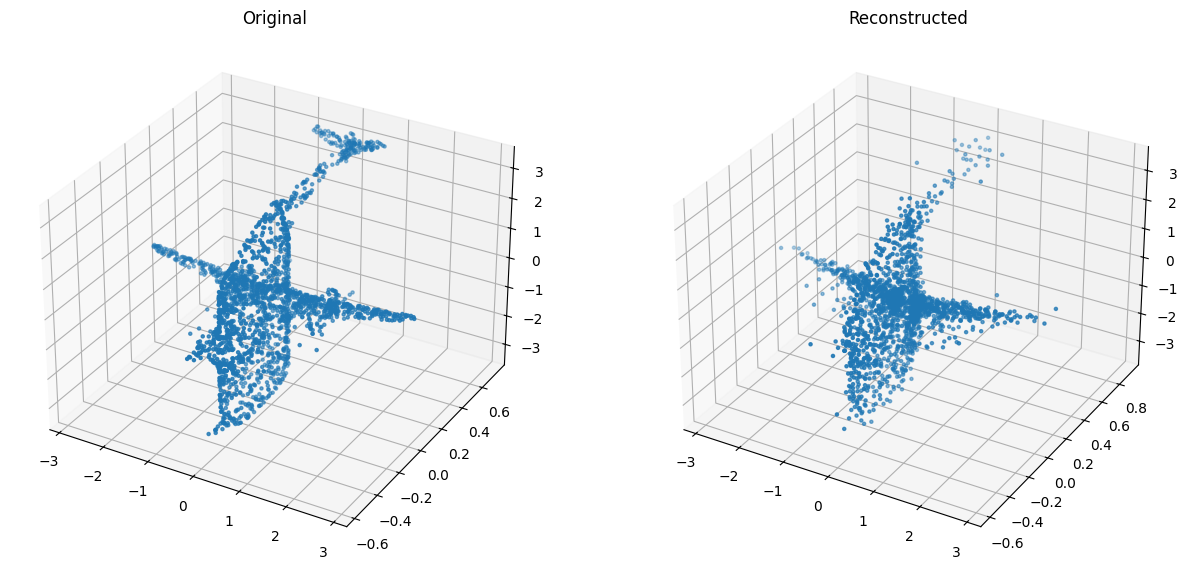

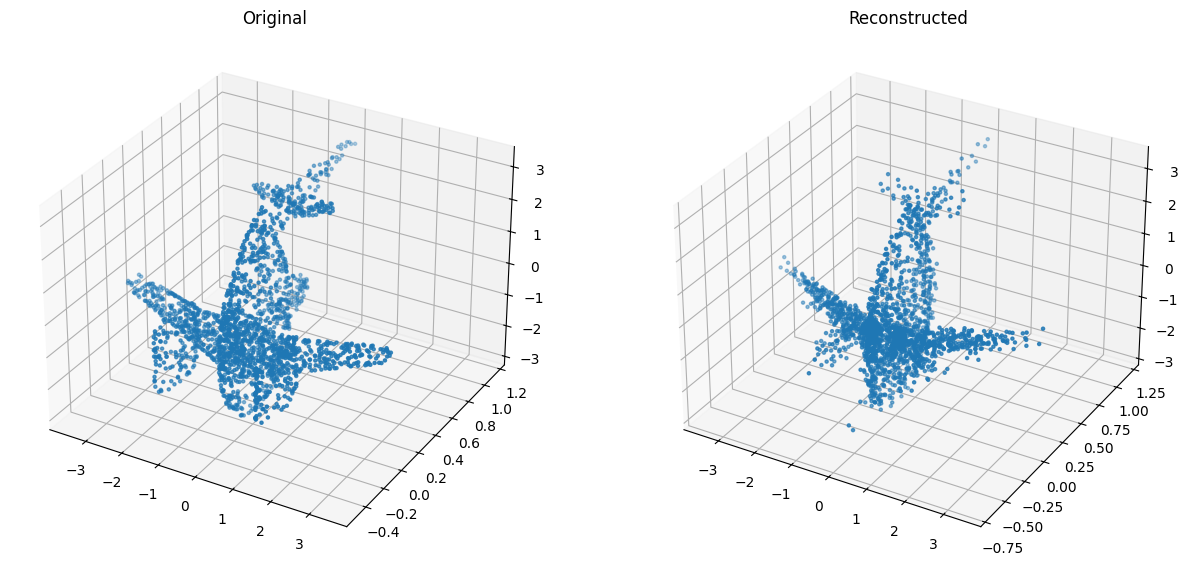

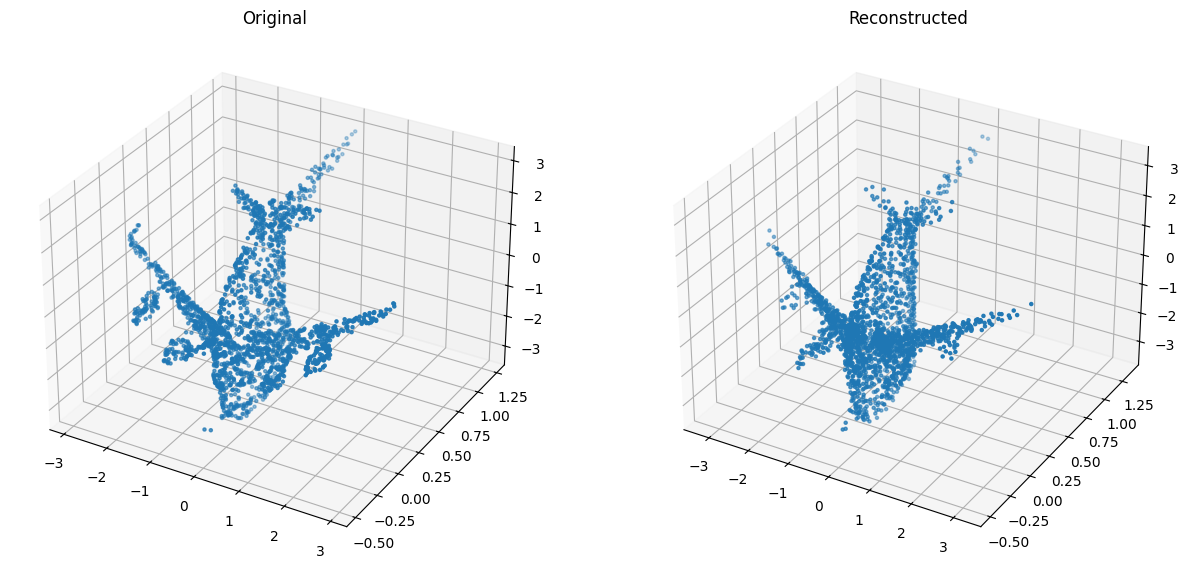

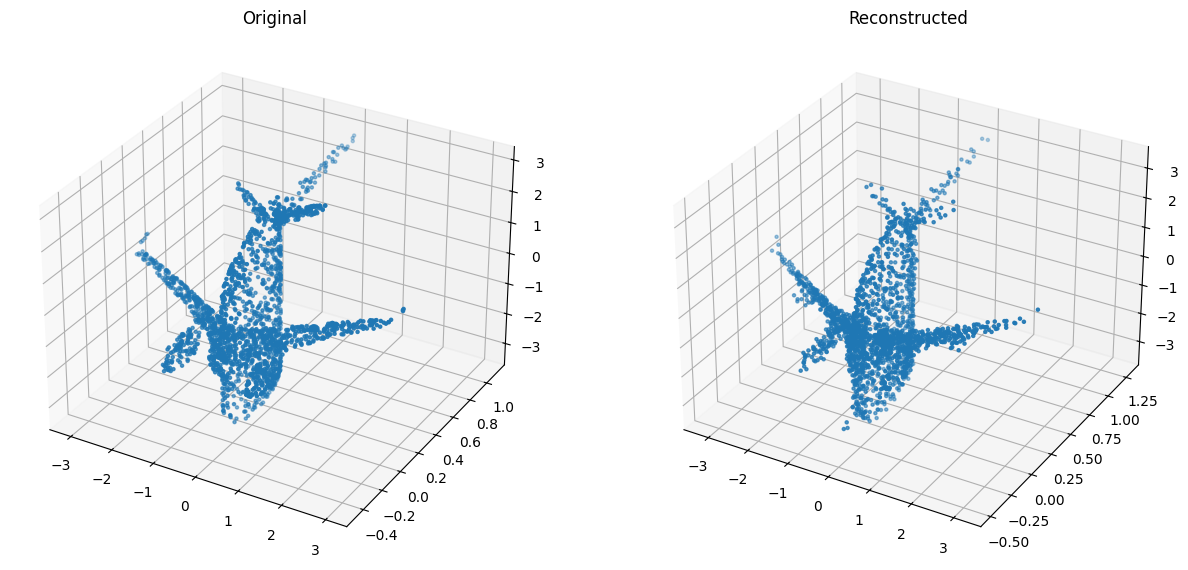

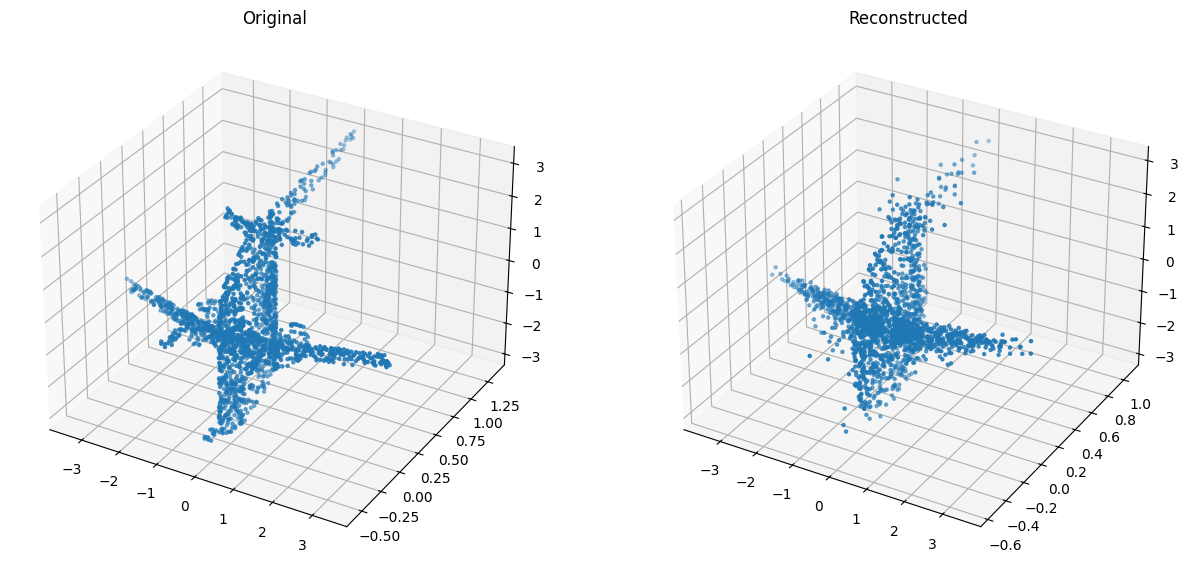

In [16]:
visualize_reconstruction(vae, val_dset) 

Generate a new model

In [17]:
def sample_from_vae(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    Samples point clouds from the VAE model.
    """
    model.eval()
    with torch.no_grad():
        #
        z_sampled = torch.randn(num_samples, latent_dim).to(device)
        generated_point_clouds = model.decoder(z_sampled)
    return generated_point_clouds


In [18]:
def visualize_generated_point_clouds(model, num_samples=5, latent_dim=256, device='cuda'):
    """
    Visualizes point clouds generated from the VAE.
    """
    generated_point_clouds = sample_from_vae(model, num_samples, latent_dim, device)
    for i in range(num_samples):
        points = generated_point_clouds[i].cpu().numpy()

        # Plotting
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=5)
        ax.set_title(f"Generated Point Cloud {i+1}")

        plt.show()


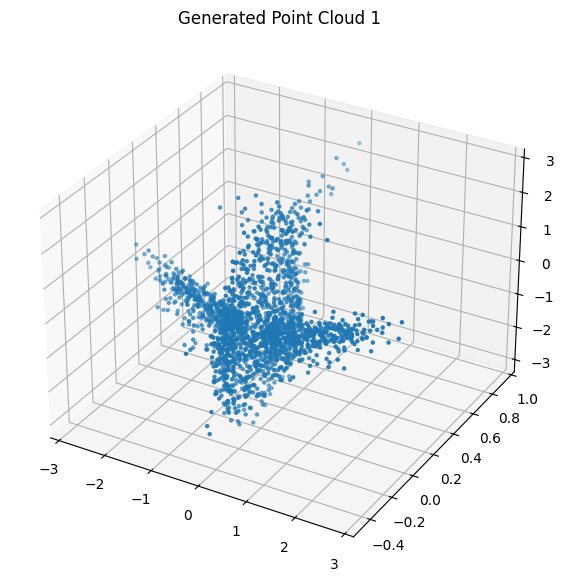

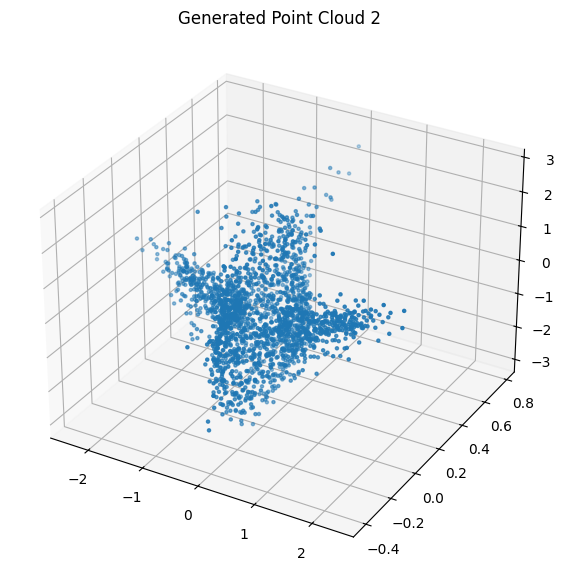

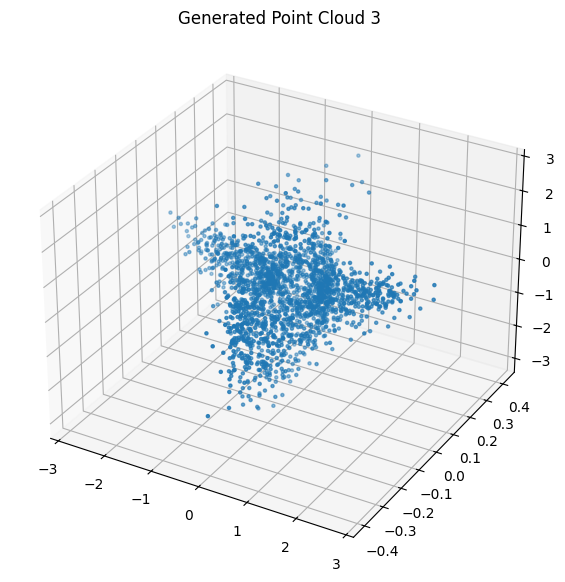

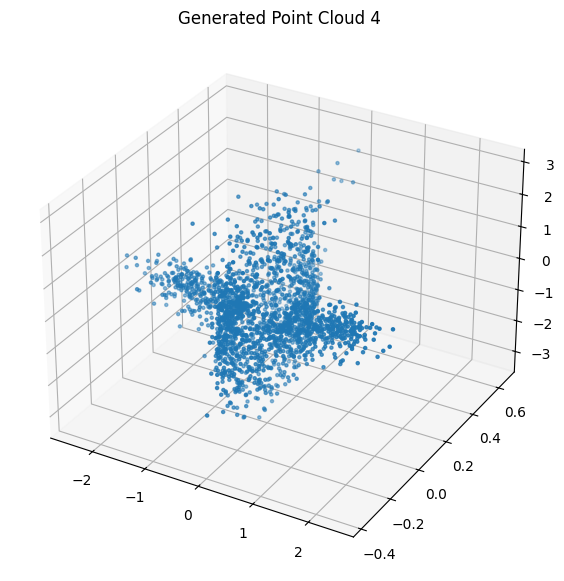

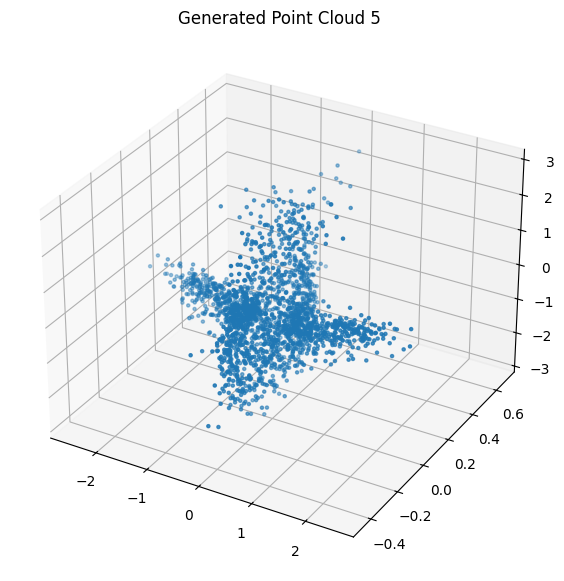

In [19]:
visualize_generated_point_clouds(vae)
